In [1]:
import numpy as np
def printifproblem(variablenames, notonlyifproblem=False):
    variablenames = variablenames.split(",")
    values = [locals()[var] if var in locals().keys() 
           else globals()[var] if var in globals().keys() 
           else None for var in variablenames]
    if any(val in [np.nan,np.inf,-np.inf] for val in values) or notonlyifproblem:
        print(variablenames)
        print(values)  


## Get Data

In [6]:
import numpy as np
import pandas as pd
sigmax = 1
n=100
def get_datapoints(n=100,xylist=True):
    pa = 0.2
    mua=30
    sigmaa=5
    m=2
    c=10
    
    points = [(x, np.random.normal(np.random.normal(mua,sigmaa),sigmax)
                 if np.random.uniform()<=pa 
                 else np.random.normal(m*x+c,sigmax)) for x in [u*9+0.5 for u in np.random.uniform(size=n)]]
    
    return points if not xylist else list(zip(*points))

xs,ys = zs = get_datapoints(n)

## Display Data

<ErrorbarContainer object of 3 artists>

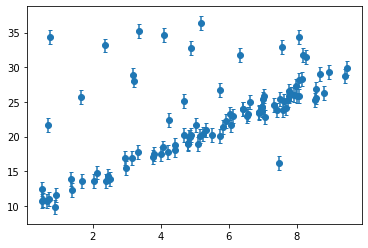

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})
plt.errorbar(xs,ys,yerr=[sigmax]*n, fmt='o')

## Define Likelihood, Prior and Posterior

In [8]:
from scipy import stats
import scipy,math
def product_elements_of_likelihood_z(zs,m,c,mua,sigmaa,pa): # ,magnitudePzis=None):
    Pzis = [scipy.stats.norm.pdf(y, loc=m*x+c, scale=sigmax)*(1-pa) 
                       + scipy.stats.norm.pdf(y, loc=mua,scale=np.sqrt(sigmaa**2+sigmax**2))*pa
                       for x,y in list(zip(xs,ys))]
    return Pzis #np.prod([Pzi*10**magnitudePzi for magnitudePzi, Pzi in list(zip(magnitudePzis,Pzis))]),magnitudePzis

def prior_theta(m,c,mua,sigmaa,pa): # ,magnitude=None):
    # Pm: wie groß Delta m für gleichverteiltes alpha: 
    # Pm propto 1/(mmax-mmin) mit mmin,mmax=M(alpha-DELalpha/2),M(alpha+DELalpha/2) mit M(.) = tan(alpha)
    #    propto 1/M'(alpha) propto cos^2(alpha)
    Pm = math.cos(math.atan(m))**2/math.pi # correct
    # Pc,Pmua, gleichverteilt in komplletten raum, daher ignorieren!
    Psigmaa = 1/sigmaa if sigmaa>0 else 0 # main referenced paper page 10 in acrobat at top-> p(sigma) propto 1/ sigma
    # Psigmaa not normalized as int_0^infty (1/sigma) does not converge! 
    # but dont worry, normalization not needed for mcmc as only ratios of posteriors used, for which normalization 
    # constant cancels out!
    Ppa = 1 if 0<=pa and pa<=1 else 0
    Pprior = Pm*Psigmaa*Ppa
    return Pprior #*10**magnitude,magnitude

def product_elements_of_posterior_theta(m,c,mua,sigmaa,pa,zs): #,magnitudel=None,magnitudep=None):
    return product_elements_of_likelihood_z(zs,m,c,mua,sigmaa,pa),prior_theta(m,c,mua,sigmaa,pa)

## Define Transition Kernel, Kernel Parameter Update Functions, Final Algorithm and Walkers

In [3]:
# optimal hyperparameter selection function:
def get_optimalacceptanceratio(theta):
    D = len(theta)
    optimal_acceptance_ratio =  0.441 if D==1 else \
                                0.352 if D==2 else \
                                0.316 if D==3 else \
                                0.279 if D==4 else \
                                0.275 if D==5 else \
                                0.266 if D==6 else \
                                0.230
    return optimal_acceptance_ratio

# model parameter update functions:
def proposal(thetai,si,Sigmai):
    thetaiproposal = np.random.multivariate_normal(thetai,si*Sigmai)
    print("thetai,thetaiproposal")
    print(thetai)
    print(thetaiproposal)
    return thetaiproposal
def get_acceptanceratioi(thetai,thetaiproposal,zs):
    Pzisthethai,priorthetai = product_elements_of_posterior_theta(*thetai,zs) #,None,None)
    Pzisthetaiproposal,priorthetaiproposal = product_elements_of_posterior_theta(*thetaiproposal,zs) #,magnitudel,magnitudep)
    if False:
        print("priorthetai,priorthetaipropoal,Pzisthethai,Pzisthethaiproposal")
        print(priorthetai,priorthetaiproposal)
        print(Pzisthethai)
        print(Pzisthetaiproposal)
    relPzis = [Pzitproposal/Pziti for Pzitproposal,Pziti in list(zip(Pzisthetaiproposal,Pzisthethai))]
    relpriors = priorthetaiproposal/priorthetai
    acceptanceratioi = np.prod(relPzis) * relpriors
    printifproblem("acceptanceratioi")
    return acceptanceratioi if acceptanceratioi<1 else 1

#posteriorthetaiproposal/posteriorthethai if posteriorthetaiproposal/posteriorthethai<1 else 1
def is_accepted(acceptance_ratioi):
    return True if acceptance_ratioi>np.random.uniform() else False
def kernel(thetai,thetaiproposal,acceptance_ratioi):
    return thetaiproposal if is_accepted(acceptance_ratioi) else thetai

# transition kernel parameter update functions:
def get_gammai(i,gamma,beta):
    printifproblem("i,gamma,beta,gamma/i**beta")
    return gamma/i**beta
def update_si(si,acceptanceratioi,gammaiplus1,optimalacceptanceratio):
    print("si,acceptanceratioi,gammaiplus1,optimalacceptanceratio")
    print(si,acceptanceratioi,gammaiplus1,optimalacceptanceratio)
    #3.3311634176842118 2.5012006278285594e-50 0.6597539553864472 0.275
    return si*math.exp(gammaiplus1*(acceptanceratioi-optimalacceptanceratio))
def update_Sigmai(Sigmai,thetaiplus1,mui,gammaiplus1):
    printifproblem("Sigmai,np.outer(thetaiplus1-mui,thetaiplus1-mui")
    return Sigmai+gammaiplus1*(np.outer(thetaiplus1-mui,thetaiplus1-mui)-Sigmai)
def update_mui(mui,thetaiplus1,gammaiplus1):
    return mui + gammaiplus1*(thetaiplus1-mui)

# final algorithm:
def update_all(paramsi,i,zs):
    thetai,rhoi,hyperp = paramsi
    gamma,beta,optimalacceptanceratio = hyperp
    
    mi,ci,muai,sigmaai,pai = thetai
    gammai,si,Sigmai,mui = rhoi
    
    # update step:
    iplus1 = i+1
    
    # update model parameters:
    thetaiproposal =proposal(thetai,si,Sigmai)
    acceptanceratioi = get_acceptanceratioi(thetai,thetaiproposal,zs)
    thetaiplus1 = kernel(thetai,thetaiproposal,acceptanceratioi)
    
    # update transition kernel parameters:
    gammaiplus1 = get_gammai(iplus1,gamma,beta)
    siplus1 = update_si(si,acceptanceratioi,gammaiplus1,optimalacceptanceratio)
    Sigmaiplus1 = update_Sigmai(Sigmai,thetaiplus1,mui,gammaiplus1)
    muiplus1 = update_mui(mui,thetaiplus1,gammaiplus1)
    rhoiplus1 = (gammaiplus1,siplus1,Sigmaiplus1,muiplus1)
    
    # update all params:
    paramsiplus1 = thetaiplus1, rhoiplus1, hyperp
    
    return paramsiplus1

# "parallel" walker functions:
def get_theta_rho_hyperp_hists(paramshistory):
    hists = [[doublezipped for doublezipped in list(zip(*zipped))]
              for zipped in list(zip(*paramshistory))]
    return hists
    
def get_convergence_ratios(convergence_stats,nwalkers,nlastdraws):
    convergence_ratios = {param:np.nan for param in ['m','c','mua','sigmaa','pa']}
    for param,walker_dict in convergence_stats.items():
        mean = np.mean([meanORvar['mean'] for meanORvar in walker_dict.values()])
        Zvar = np.mean([(meanORvar['mean']-mean)**2 for meanORvar in walker_dict.values()])
        Ivar = np.mean([meanORvar['var'] for meanORvar in walker_dict.values()])
        V = (nlastdraws-1)/nlastdraws*Ivar+(nwalkers+1)/nwalkers*Zvar
        convergence_ratio = np.sqrt(V/Ivar)
        convergence_ratios[param] = convergence_ratio
    return convergence_ratios
        
def exe_parallel_walkers(zs,params0,nwalkers,nlastdraws,checkevery):
    (theta0,rho0,hyperp) = params0
    walkers = {w:[params0] for w in range(nwalkers)}
    convergence_stats = {param:
                        {w: {'mean':np.nan,
                            'var':np.nan} for w in range(nwalkers)}
                         for param in ['m','c','mua','sigmaa','pa']}
    
    i=0
    converged = False
    while not converged:
        print("Schritt",i)
        for which, paramshistory in walkers.items():
            print("walker",which)
            paramsi = paramshistory[-1]
            paramsiplus1 = update_all(paramsi,i,zs)
            walkers[which] += [paramsiplus1]
            if i%nlastdraws==0 and i!=nlastdraws:
                thetas,_,_ = get_theta_rho_hyperp_hists(walkers[which])
                lastthetas = [param[-nlastdraws:] for param in thetas] 
                for param,lastvalues in list(zip(['m','c','mua','sigmaa','pa'],
                                               lastthetas)):
                    convergence_stats[param][which]['mean'] = np.mean(lastvalues)
                    convergence_stats[param][which]['var'] = np.var(lastvalues)
        if i%checkevery==0 and i>nlastdraws and i!=nlastdraws:
            convergence_ratios = get_convergence_ratios(convergence_stats,nwalkers,nlastdraws)
            if all(ratio<1.05 for ratio in convergence_ratios.values()):
                converged = True
        i += 1
    
    return walkers, convergence_stats, convergence_ratios  

## Define Starting Points

In [12]:
theta0 = (m0,c0,mua0,sigmaa0,pa0) = (0.5,13,25,1,0.5) # first guess modelparams
hyperp = (gamma,beta,optimalacceptanceratio) = (1,0.6,get_optimalacceptanceratio(theta0)) # hyperp set
rho0 = (gamma0,s0,Sigma0,mu0) = (1,1,np.eye(len(theta0)),
                                 np.array([0]*len(theta0))) # first guess transition kernel params

params0 = (theta0,rho0,hyperp)
nlastdraws,nwalkers,checkevery = 1000,5,100

## Execute MCMC
- Priorwahl aus Invarianzen abgeleitet

- Adaptive Random Walk Metropolis Hastings

- Konvergenz durch Vergleich der Inner- und Zwischenvarianz der Parameter verschiedener Ketten

In [14]:
walkers, convergence_stats, convergence_ratios = exe_parallel_walkers(zs,params0,nwalkers,nlastdraws,checkevery)

Schritt 0
walker 0
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[ 1.18283808 12.47664973 24.53216999  0.59225368  2.4126913 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1 -0.0 1.0 0.275
walker 1
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[-0.10958957 12.27954893 23.86510187  2.71710011  1.73479686]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1 -0.0 1.0 0.275
walker 2
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[-0.28773243 12.22686246 24.51202325  0.21198929  0.56028292]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1 6.809016849543617e-215 1.0 0.275
walker 3
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[ 2.02137288 13.56123985 25.08507338  0.71645407  0.70096044]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1 7.600630810083383e-74 1.0 0.275
walker 4
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[-0.62861488 13.12083273 24.55589439  1.19351176  2.22458518]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1 0.0 1.0 0.275
Schritt 1
walker 0
th

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5670978005426779 1.044462745340159e-27 0.2871745887492588 0.275
walker 2
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[ 0.4804599  12.49195749 24.02299517  0.9609198   0.4804599 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.392325340858452 1.1269773909220732e-31 0.2871745887492588 0.275
walker 3
thetai,thetaiproposal
[ 0.54676987 14.21601665 27.33849363  1.09353974  0.54676987]
[ 0.63291214 16.4557149  31.64560559  1.26582422  0.63291211]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5008897335502356 1.5643272460005317e-57 0.2871745887492588 0.275
walker 4
thetai,thetaiproposal
(0.5, 13, 25, 1, 0.5)
[ 0.4783608  12.43738084 23.91804011  0.9567216   0.4783608 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.3669613374552702 1.0220450002259673e-35 0.2871745887492588 0.275
Schritt 8
walker 0
thetai,thetaiproposal
[ 0.53937387 14.02372076 26.9686938   1.07874775  0.53937387]
[ 0.55655661 14.47047197 2

thetai,thetaiproposal
[ 0.54676987 14.21601665 27.33849363  1.09353974  0.54676987]
[ 0.53751971 13.97551242 26.87598548  1.07503942  0.53751971]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.3370801403801633 0.03574632390646455 0.20526891114486695 0.275
walker 4
thetai,thetaiproposal
[ 0.57007851 14.82204139 28.50392574  1.14015703  0.57007851]
[ 0.60501313 15.73034131 30.25065628  1.21002625  0.60501313]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.3246503141109909 2.0700500262345293e-29 0.20526891114486695 0.275
Schritt 14
walker 0
thetai,thetaiproposal
[ 0.53991427 14.03777087 26.9957133   1.07982853  0.53991426]
[ 0.52990707 13.77758357 26.49535311  1.05981412  0.52990706]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5045980857559063 0.00012809816382226795 0.19694512927085184 0.275
walker 1
thetai,thetaiproposal
[ 0.55742274 14.49299134 27.87113713  1.11484552  0.55742276]
[ 0.56174047 14.60525216 28.08702332  1.12348096  0.56174048]
si,acceptanc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.41338750252630513 0.15284709254679535 0.16572270086699933 0.275
Schritt 20
walker 0
thetai,thetaiproposal
[ 0.53991427 14.03777087 26.9957133   1.07982853  0.53991426]
[ 0.54525504 14.17663096 27.26275194  1.09051007  0.54525504]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.37564982342045633 1 0.16094164024930613 0.275
walker 1
thetai,thetaiproposal
[ 0.53577312 13.93010113 26.78865594  1.07154626  0.53577313]
[ 0.53207566 13.83396716 26.60378293  1.06415134  0.53207567]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.43592566892782053 0.02762730104208562 0.16094164024930613 0.275
walker 2
thetai,thetaiproposal
[ 0.53768243 13.97974326 26.88412167  1.07536487  0.53768244]
[ 0.52926333 13.7608466  26.46316658  1.05852667  0.52926334]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.4256982646380551 0.00021160890131317512 0.16094164024930613 0.275
walker 3
thetai,thetaiproposal
[ 0.54333857 14.12680263 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.48147068629145334 6.815068200421644e-05 0.1384145488461686 0.275
walker 2
thetai,thetaiproposal
[ 0.54220114 14.09722967 27.11005705  1.08440229  0.54220115]
[ 0.53907944 14.01606548 26.95397209  1.07815889  0.53907945]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.46380737061818883 0.23382570375761702 0.1384145488461686 0.275
walker 3
thetai,thetaiproposal
[ 0.55466527 14.42129699 27.73326351  1.10933054  0.55466527]
[ 0.54464542 14.1607809  27.23227102  1.08929084  0.54464542]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.31492888799817625 1 0.1384145488461686 0.275
walker 4
thetai,thetaiproposal
[ 0.55407892 14.40605184 27.70394577  1.10815783  0.55407892]
[ 0.56415668 14.66807382 28.20783423  1.12831337  0.56415669]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.4312904027009953 0.00027915547870620907 0.1384145488461686 0.275
Schritt 27
walker 0
thetai,thetaiproposal
[ 0.54882107 14.26934779 27

thetai,thetaiproposal
[ 0.55010871 14.3028265  27.50543553  1.10021742  0.55010871]
[ 0.55945933 14.54594266 27.9729666   1.11891866  0.55945933]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.4364942410195286 0.007857973501444971 0.12271330022108155 0.275
Schritt 33
walker 0
thetai,thetaiproposal
[ 0.5522527  14.35857033 27.61263536  1.10450541  0.5522527 ]
[ 0.5575106  14.49527574 27.87553038  1.11502121  0.55751061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5390106097619122 0.06311655436485987 0.12053485499943513 0.275
walker 1
thetai,thetaiproposal
[ 0.55559767 14.44553948 27.77988361  1.11119539  0.5555977 ]
[ 0.54809223 14.25039805 27.40461161  1.09618451  0.54809225]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5177963599888521 1 0.12053485499943513 0.275
walker 2
thetai,thetaiproposal
[ 0.545666   14.1873158  27.28329966  1.091332    0.545666  ]
[ 0.54285493 14.1142279  27.14274604  1.08570986  0.54285493]
si,acceptanceratioi,gammaiplus1,opt

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.6667458920906568 0.8425337344180461 0.10933620739432783 0.275
walker 2
thetai,thetaiproposal
[ 0.54972294 14.29279627 27.48614673  1.09944588  0.54972294]
[ 0.55387168 14.40066342 27.69358357  1.10774336  0.55387168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8503659247201277 0.2758326826238048 0.10933620739432783 0.275
walker 3
thetai,thetaiproposal
[ 0.54512053 14.17313358 27.25602617  1.09024104  0.54512052]
[ 0.54162037 14.08212959 27.0810185   1.08324073  0.54162037]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.496994026637908 0.3867380291718196 0.10933620739432783 0.275
walker 4
thetai,thetaiproposal
[ 0.54996768 14.2991598  27.49838416  1.09993536  0.54996768]
[ 0.55079437 14.32065356 27.53971832  1.10158873  0.55079436]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5347299498110163 0.8390417802863576 0.10933620739432783 0.275
Schritt 40
walker 0
thetai,thetaiproposal
[ 0.55071445 14.31

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.7119815565185824 1 0.10054148627613585 0.275
walker 2
thetai,thetaiproposal
[ 0.55119641 14.33110636 27.55981998  1.10239282  0.55119641]
[ 0.55029289 14.30761489 27.51464409  1.10058578  0.55029289]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9216619641980744 1 0.10054148627613585 0.275
walker 3
thetai,thetaiproposal
[ 0.55499288 14.42981488 27.74964405  1.10998576  0.55499288]
[ 0.54400549 14.14414269 27.20027446  1.08801097  0.54400549]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5666732539696491 1 0.10054148627613585 0.275
walker 4
thetai,thetaiproposal
[ 0.55554385 14.44414009 27.77719241  1.11108769  0.55554385]
[ 0.55799335 14.50782708 27.89966741  1.11598669  0.55799335]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.5886196957660699 0.1999804735857907 0.10054148627613585 0.275
Schritt 46
walker 0
thetai,thetaiproposal
[ 0.54626339 14.20284813 27.31316959  1.09252678  0.54626339]
[ 0.54

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.7839258529655058 1 0.09341099406970099 0.275
walker 4
thetai,thetaiproposal
[ 0.54636412 14.20546702 27.31820577  1.09272823  0.54636411]
[ 0.55196288 14.35103492 27.598144    1.10392576  0.55196288]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.7817051139495773 0.48639581193835346 0.09341099406970099 0.275
Schritt 52
walker 0
thetai,thetaiproposal
[ 0.54771434 14.24057283 27.38571709  1.09542868  0.54771434]
[ 0.55482304 14.42539903 27.7411521   1.10964608  0.55482304]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.029764839709336 0.14237857025816036 0.0923494850768241 0.275
walker 1
thetai,thetaiproposal
[ 0.54999667 14.29991344 27.49983351  1.09999338  0.54999669]
[ 0.54307863 14.1200446  27.15393194  1.08615733  0.54307867]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9963705906283293 0.6976887234334044 0.0923494850768241 0.275
walker 2
thetai,thetaiproposal
[ 0.54054378 14.05413818 27.0271888

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2024908995190504 0.07768262859832371 0.08659419774067573 0.275
walker 1
thetai,thetaiproposal
[ 0.54529398 14.17764372 27.26469951  1.09058805  0.54529402]
[ 0.54395164 14.14274305 27.19758281  1.08790337  0.54395169]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.15617105822532 0.7813581447870726 0.08659419774067573 0.275
walker 2
thetai,thetaiproposal
[ 0.54426778 14.15096206 27.21338865  1.08853556  0.54426778]
[ 0.53859855 14.00356196 26.92992705  1.0771971   0.53859855]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6350357961357616 0.09824436803013183 0.08659419774067573 0.275
walker 3
thetai,thetaiproposal
[ 0.54832894 14.25655227 27.41644667  1.09665786  0.54832893]
[ 0.54587206 14.1926734  27.29360267  1.0917441   0.54587205]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0190495441157776 0.968581897277205 0.08659419774067573 0.275
walker 4
thetai,thetaiproposal
[ 0.544973   14.16929787 27.2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9608692296827834 0.0005907237698928139 0.08170563056412121 0.275
walker 3
thetai,thetaiproposal
[ 0.54547514 14.18235362 27.27375695  1.09095027  0.54547513]
[ 0.5423659  14.10151315 27.11829445  1.08473177  0.54236588]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2758893753280993 0.4848015120107095 0.08170563056412121 0.275
walker 4
thetai,thetaiproposal
[ 0.5503118  14.30810674 27.51558982  1.10062359  0.55031179]
[ 0.54733495 14.2307088  27.36674766  1.0946699   0.54733495]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1728540504076987 1 0.08170563056412121 0.275
Schritt 65
walker 0
thetai,thetaiproposal
[ 0.55185786 14.34830429 27.59289299  1.10371571  0.55185786]
[ 0.55525543 14.43664108 27.76277143  1.11051085  0.55525543]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.25780799325082 0.22974991955276758 0.08096058519938314 0.275
walker 1
thetai,thetaiproposal
[ 0.53681007 13.95706168 26.8405

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6000241630555274 1 0.07684232595681066 0.275
walker 1
thetai,thetaiproposal
[ 0.5490597  14.27555284 27.45298635  1.09811954  0.54905977]
[ 0.54881596 14.26921574 27.44079964  1.09763208  0.54881604]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3489240798634703 1 0.07684232595681066 0.275
walker 2
thetai,thetaiproposal
[ 0.55098916 14.32571912 27.54945935  1.10197835  0.55098917]
[ 0.53517564 13.91456775 26.7587836   1.07035131  0.53517566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.24697672253157 0.009022419499987467 0.07684232595681066 0.275
walker 3
thetai,thetaiproposal
[ 0.54072609 14.05887816 27.03630409  1.08145216  0.54072608]
[ 0.53005436 13.78141314 26.50271747  1.06010869  0.53005435]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6562666957343 0.00010391972238148368 0.07684232595681066 0.275
walker 4
thetai,thetaiproposal
[ 0.54478451 14.16439728 27.23922554  1.08956902  0.54478451]

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3377106002200803 1 0.07323914039903467 0.275
walker 3
thetai,thetaiproposal
[ 0.54290866 14.11562497 27.14543244  1.08581728  0.54290864]
[ 0.53870013 14.00620292 26.93500527  1.07740019  0.5387001 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.820987247617907 0.14800805112095516 0.07323914039903467 0.275
walker 4
thetai,thetaiproposal
[ 0.54927281 14.2810931  27.46364056  1.09854562  0.54927281]
[ 0.55531476 14.43818378 27.76573794  1.11062952  0.55531476]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7220947465039667 0.12425300289112749 0.07323914039903467 0.275
Schritt 78
walker 0
thetai,thetaiproposal
[ 0.55235253 14.36116609 27.61762722  1.10470508  0.55235254]
[ 0.55612824 14.45933467 27.80641296  1.11225651  0.55612825]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9027812690165564 0.16284733295714374 0.07268147716143782 0.275
walker 1
thetai,thetaiproposal
[ 0.54732276 14.23039273 27.3661

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.065831176782501 0.485861672264091 0.07005391778841781 0.275
Schritt 84
walker 0
thetai,thetaiproposal
[ 0.54978421 14.2943893  27.4892103   1.09956841  0.5497842 ]
[ 0.54955395 14.28840206 27.47769637  1.09910786  0.54955393]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2903157075468887 1 0.06955824958648987 0.275
walker 1
thetai,thetaiproposal
[ 0.54050816 14.05321258 27.02540887  1.08101643  0.54050822]
[ 0.55170624 14.34436296 27.58531349  1.10341262  0.55170631]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0720109101803255 1 0.06955824958648987 0.275
walker 2
thetai,thetaiproposal
[ 0.54919969 14.27919275 27.45998569  1.0983994   0.5491997 ]
[ 0.54572208 14.18877593 27.28610667  1.0914442   0.5457221 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.844829805324657 1 0.06955824958648987 0.275
walker 3
thetai,thetaiproposal
[ 0.54250872 14.10522652 27.12543538  1.0850174   0.5425087 ]
[ 0.54650

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4618221958054973 0.025666470278072034 0.06676904500902375 0.275
walker 2
thetai,thetaiproposal
[ 0.54660027 14.21160941 27.33001688  1.09320059  0.54660029]
[ 0.54476007 14.16376306 27.23800522  1.08952016  0.54476008]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.3609257897822964 0.8157396910157584 0.06676904500902375 0.275
walker 3
thetai,thetaiproposal
[ 0.55248276 14.36455171 27.62413799  1.10496551  0.55248276]
[ 0.55500661 14.43017186 27.75033059  1.11001322  0.55500661]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1097010994688166 0.3244543717208057 0.06676904500902375 0.275
walker 4
thetai,thetaiproposal
[ 0.53799748 13.98793428 26.89987362  1.07599493  0.53799746]
[ 0.52712759 13.70531745 26.35637943  1.05425518  0.52712759]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.557873335581365 8.716596725966048e-06 0.06676904500902375 0.275
Schritt 91
walker 0
thetai,thetaiproposal
[ 0.54461387 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.1880017664787434 0.90154605470369 0.06425944339465392 0.275
walker 3
thetai,thetaiproposal
[ 0.54705786 14.22350423 27.35289268  1.09411569  0.54705785]
[ 0.54479602 14.16469634 27.23980053  1.08959201  0.54479601]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.671513832463708 0.8090375127205055 0.06425944339465392 0.275
walker 4
thetai,thetaiproposal
[ 0.55045761 14.3118978  27.52288058  1.10091519  0.55045759]
[ 0.55137775 14.33582137 27.56888729  1.10275548  0.55137774]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7980857835640855 0.7950071316650631 0.06425944339465392 0.275
Schritt 97
walker 0
thetai,thetaiproposal
[ 0.54482705 14.16550268 27.24135141  1.08965406  0.54482703]
[ 0.54572917 14.18895792 27.28645764  1.09145831  0.54572915]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8607670156656733 1 0.06386521147557009 0.275
walker 1
thetai,thetaiproposal
[ 0.55169653 14.34410935 27.58482552 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.036241739484587 0.004199156074030581 0.06198657851487586 0.275
walker 4
thetai,thetaiproposal
[ 0.5450614  14.17159656 27.25306977  1.09012282  0.54506141]
[ 0.53730387 13.96990094 26.86519311  1.07460781  0.53730391]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0134587734888743 0.03609241173712192 0.06198657851487586 0.275
Schritt 103
walker 0
thetai,thetaiproposal
[ 0.54660489 14.21172688 27.33024411  1.09320977  0.54660488]
[ 0.54198878 14.09170769 27.09943796  1.08397752  0.54198876]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5669732321264513 0.38482304406785034 0.061628272814065174 0.275
walker 1
thetai,thetaiproposal
[ 0.53693358 13.96026512 26.84666148  1.07386592  0.53693296]
[ 0.55432664 14.41248792 27.71632164  1.10865256  0.55432628]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.3538174525480526 1 0.061628272814065174 0.275
walker 2
thetai,thetaiproposal
[ 0.54605981 14.19755861 27.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8355892386613997 0.039755502760597944 0.059588765590906985 0.275
walker 2
thetai,thetaiproposal
[ 0.54862019 14.26411212 27.43099136  1.09724018  0.54862009]
[ 0.54713894 14.22560234 27.35693268  1.09427772  0.54713886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.387547907532811 1 0.059588765590906985 0.275
walker 3
thetai,thetaiproposal
[ 0.54404182 14.14508736 27.20209117  1.08808366  0.54404183]
[ 0.54292206 14.11597359 27.14610356  1.08584418  0.54292209]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.3041611761148606 0.7446426429142475 0.059588765590906985 0.275
walker 4
thetai,thetaiproposal
[ 0.54220998 14.09745942 27.11049875  1.08441995  0.54220997]
[ 0.53308546 13.86022182 26.65427285  1.06617088  0.53308544]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7692739101779225 0.001869895717981043 0.059588765590906985 0.275
Schritt 110
walker 0
thetai,thetaiproposal
[ 0.55245342 14.3637874  2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.677447782175482 0.28897710043969094 0.05771985168360861 0.275
walker 4
thetai,thetaiproposal
[ 0.54220998 14.09745942 27.11049875  1.08441995  0.54220997]
[ 0.54743947 14.2334263  27.37197339  1.09487895  0.54743947]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.603228665866205 1 0.05771985168360861 0.275
Schritt 116
walker 0
thetai,thetaiproposal
[ 0.54958234 14.28913895 27.47911348  1.09916456  0.54958228]
[ 0.55356987 14.39281165 27.67848405  1.10713943  0.55356972]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.577658250225171 0.3083328565108541 0.05742334443402935 0.275
walker 1
thetai,thetaiproposal
[ 0.54798391 14.24758639 27.39920596  1.09596867  0.54798434]
[ 0.54196797 14.09118127 27.09842927  1.08393825  0.54196912]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.0581888030293705 0.3821553966367895 0.05742334443402935 0.275
walker 2
thetai,thetaiproposal
[ 0.54124587 14.07237399 27.0622671

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.050964036000187 0.8234954541823044 0.05572587970891812 0.275
walker 1
thetai,thetaiproposal
[ 0.5437327  14.13706004 27.18665648  1.08746702  0.54373351]
[ 0.54136497 14.07548631 27.06824214  1.08272955  0.54136477]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.6036663028938785 0.4586933635806766 0.05572587970891812 0.275
walker 2
thetai,thetaiproposal
[ 0.55191845 14.34989353 27.59594207  1.10383714  0.55191857]
[ 0.55331672 14.38631065 27.66594335  1.10663459  0.55331729]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.8092820884864524 0.5975256804252523 0.05572587970891812 0.275
walker 3
thetai,thetaiproposal
[ 0.54510825 14.17281356 27.25540946  1.09021634  0.54510817]
[ 0.5458422  14.19189501 27.29210221  1.09168396  0.54584198]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.106168051851241 1 0.05572587970891812 0.275
walker 4
thetai,thetaiproposal
[ 0.543208   14.12340846 27.16039974  1.0864161

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.8859254105990635 0.23995915711204396 0.05415594940382042 0.275
walker 3
thetai,thetaiproposal
[ 0.54477022 14.16401707 27.23847927  1.08953841  0.54476921]
[ 0.54513998 14.1736221  27.25693424  1.09027576  0.54513788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.822048485392924 1 0.05415594940382042 0.275
walker 4
thetai,thetaiproposal
[ 0.54852521 14.26165594 27.42626047  1.09705051  0.54852526]
[ 0.55410026 14.40660771 27.70501219  1.10820078  0.55410039]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0016478606721044 0.213431512011911 0.05415594940382042 0.275
Schritt 129
walker 0
thetai,thetaiproposal
[ 0.54848955 14.26072886 27.42447863  1.09697914  0.54848957]
[ 0.56219741 14.61713117 28.10986775  1.12439473  0.56219736]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.717744793088451 0.0004937967125872928 0.05390561294202276 0.275
walker 1
thetai,thetaiproposal
[ 0.55301576 14.3783938  27.6507

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.11898913330286 0.17999472807645406 0.05246584295828745 0.275
walker 2
thetai,thetaiproposal
[ 0.55167199 14.34347555 27.58360485  1.10334402  0.55167201]
[ 0.54053526 14.053902   27.02674206  1.08107027  0.54053514]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.930679839735008 0.3974000113010635 0.05246584295828745 0.275
walker 3
thetai,thetaiproposal
[ 0.55295952 14.37692429 27.64789009  1.10591359  0.55295679]
[ 0.56603783 14.71694075 28.30173169  1.13206531  0.56603265]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.03453055565983 1.845998320861737e-05 0.05246584295828745 0.275
walker 4
thetai,thetaiproposal
[ 0.55170612 14.34435881 27.58530594  1.10341215  0.55170607]
[ 0.55878593 14.52843383 27.93929678  1.11757174  0.55878587]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.464117218908431 0.020275388010470612 0.05246584295828745 0.275
Schritt 136
walker 0
thetai,thetaiproposal
[ 0.54888831 14.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.842593131886951 1.5261375276173304e-07 0.051124255117162926 0.275
Schritt 142
walker 0
thetai,thetaiproposal
[ 0.55036358 14.30943493 27.51814412  1.10072604  0.55036302]
[ 0.53981219 14.03512664 26.99062823  1.07962498  0.53981249]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.254278070113881 0.19807602308067965 0.05090944675955334 0.275
walker 1
thetai,thetaiproposal
[ 0.5517242  14.34479745 27.58613918  1.10344278  0.55172139]
[ 0.56047252 14.57224418 28.02353303  1.12093735  0.56046867]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.0951394309534415 0.004855825781130031 0.05090944675955334 0.275
walker 2
thetai,thetaiproposal
[ 0.5510096  14.32631603 27.55057385  1.10202021  0.55101011]
[ 0.54316642 14.12233157 27.15832758  1.08633296  0.54316648]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.383989842317074 0.8958895653253742 0.05090944675955334 0.275
walker 3
thetai,thetaiproposal
[ 0.5483541

thetai,thetaiproposal
[ 0.54454764 14.15827768 27.22743729  1.08909595  0.54454797]
[ 0.55665317 14.47311513 27.83284598  1.11330833  0.55665416]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.616552614938146 0.06253112539964646 0.04966932281851884 0.275
walker 3
thetai,thetaiproposal
[ 0.54523314 14.1760796  27.26172103  1.09046983  0.54523492]
[ 0.54781494 14.24315072 27.39060378  1.09561996  0.54780998]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.582630221346891 1 0.04966932281851884 0.275
walker 4
thetai,thetaiproposal
[ 0.54589255 14.19320564 27.29462775  1.0917849   0.54589245]
[ 0.54715585 14.2260532  27.35779209  1.09431196  0.54715598]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.3975970800356405 1 0.04966932281851884 0.275
Schritt 149
walker 0
thetai,thetaiproposal
[ 0.54528471 14.17733355 27.26410279  1.09056516  0.54528258]
[ 0.53463215 13.90028882 26.73132421  1.06925522  0.53462761]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.872911051487992 1 0.048506616379289685 0.275
Schritt 155
walker 0
thetai,thetaiproposal
[ 0.54329818 14.12568674 27.16478184  1.0865923   0.54329615]
[ 0.54372027 14.13667731 27.18591775  1.08743748  0.54371874]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.051825560268611 1 0.04831981256736646 0.275
walker 1
thetai,thetaiproposal
[ 0.54374626 14.13747237 27.18747669  1.08750904  0.54375452]
[ 0.55381535 14.39911242 27.690569    1.10761282  0.55380641]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.17911694129668 0.3555315585761881 0.04831981256736646 0.275
walker 2
thetai,thetaiproposal
[ 0.55339533 14.38843237 27.66998384  1.10679296  0.55339648]
[ 0.54516055 14.17416165 27.25800963  1.09032095  0.54516047]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.014263064633705 1 0.04831981256736646 0.275
walker 3
thetai,thetaiproposal
[ 0.54303719 14.1189532  27.15180393  1.08606981  0.5430349 ]
[ 0.53111

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.625894189705845 0.07900400472928547 0.04723794446762188 0.275
walker 4
thetai,thetaiproposal
[ 0.55129733 14.33373513 27.56486382  1.10259592  0.55129796]
[ 0.54543652 14.18135543 27.27182257  1.09087465  0.54543732]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.0756146334958805 1 0.04723794446762188 0.275
Schritt 162
walker 0
thetai,thetaiproposal
[ 0.55186976 14.34808587 27.59247149  1.10370684  0.55185342]
[ 0.56390561 14.66129359 28.19479499  1.12779557  0.56389779]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.320477402582743 0.00015601976409549063 0.04706384849821222 0.275
walker 1
thetai,thetaiproposal
[ 0.54967563 14.29144267 27.48349846  1.09932588  0.54966294]
[ 0.54091239 14.06313617 27.04426412  1.08169727  0.54084863]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.903264347518017 0.2916076118247269 0.04706384849821222 0.275
walker 2
thetai,thetaiproposal
[ 0.55361424 14.39427085 27.681

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.545004781396409 0.40080273742256817 0.04621834935122564 0.275
walker 4
thetai,thetaiproposal
[ 0.54644816 14.20765244 27.32240767  1.09289634  0.54644817]
[ 0.54306301 14.11964933 27.15314405  1.08612909  0.54306454]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.516775631945898 0.5538579561446528 0.04621834935122564 0.275
Schritt 168
walker 0
thetai,thetaiproposal
[ 0.55186976 14.34808587 27.59247149  1.10370684  0.55185342]
[ 0.56470922 14.68028801 28.23131784  1.12928522  0.56464261]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.146613242758281 6.897743675241677e-05 0.04605406581088445 0.275
walker 1
thetai,thetaiproposal
[ 0.54848379 14.26078453 27.42466364  1.09701136  0.54850568]
[ 0.53732224 13.9708476  26.86719326  1.07474464  0.53737232]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.184625897143487 0.03299433577574511 0.04605406581088445 0.275
walker 2
thetai,thetaiproposal
[ 0.5534208  14

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.246235533547542 9.401717890377032e-07 0.04510006531023205 0.275
walker 2
thetai,thetaiproposal
[ 0.54889769 14.27140517 27.4449771   1.09779681  0.5488984 ]
[ 0.52458449 13.63886098 26.22875063  1.04916482  0.52458241]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.437194996769501 9.342655702271295e-09 0.04510006531023205 0.275
walker 3
thetai,thetaiproposal
[ 0.55839724 14.51829629 27.91975038  1.11678872  0.55839436]
[ 0.55073316 14.31896719 27.5363044   1.10144336  0.55072168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.49135760615304 1 0.04510006531023205 0.275
walker 4
thetai,thetaiproposal
[ 0.54459439 14.15945829 27.22971717  1.08918983  0.54459491]
[ 0.54408163 14.1461441  27.20406951  1.08816905  0.54408453]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.948720609279258 0.9020160593214306 0.04510006531023205 0.275
Schritt 175
walker 0
thetai,thetaiproposal
[ 0.55249282 14.3637822  27.6226

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.767900922447532 0.08809947616164165 0.04419700648571813 0.275
Schritt 181
walker 0
thetai,thetaiproposal
[ 0.54531229 14.17777587 27.26495194  1.09060331  0.54530166]
[ 0.55078806 14.31805797 27.53471778  1.1014256   0.5507128 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.484278282220044 0.7857178222717427 0.044051141542079134 0.275
walker 1
thetai,thetaiproposal
[ 0.54770593 14.24046314 27.38555294  1.09543776  0.54771888]
[ 0.55011354 14.30196964 27.50342234  1.10002177  0.55001088]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.798788218409907 0.7628578819295001 0.044051141542079134 0.275
walker 2
thetai,thetaiproposal
[ 0.54424192 14.15035569 27.21218881  1.08848468  0.54424234]
[ 0.54936506 14.28397193 27.46893172  1.09873698  0.54936849]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.628228680913395 1 0.044051141542079134 0.275
walker 3
thetai,thetaiproposal
[ 0.55207041 14.3538231  27.6034

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.420198712448219 0.00046450126977875096 0.043202143033826516 0.275
walker 3
thetai,thetaiproposal
[ 0.55241699 14.3627861  27.62064464  1.10482118  0.55241059]
[ 0.54944131 14.28527689 27.47132944  1.09883438  0.54941719]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.747171642580196 1 0.043202143033826516 0.275
walker 4
thetai,thetaiproposal
[ 0.54735287 14.23116912 27.36764633  1.09470416  0.54735208]
[ 0.54977504 14.29415804 27.4887478   1.09955199  0.549776  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.284511369887047 0.8098863813020313 0.043202143033826516 0.275
Schritt 188
walker 0
thetai,thetaiproposal
[ 0.54632732 14.1989465  27.30564036  1.09231027  0.54615513]
[ 0.56789712 14.75185388 28.36889149  1.13496039  0.5674802 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.246005688079768 1.2224582443579103e-06 0.04306484788199374 0.275
walker 1
thetai,thetaiproposal
[ 0.54877347 14.2666049  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.487132952662949 1 0.04239542195055442 0.275
walker 3
thetai,thetaiproposal
[ 0.55184222 14.34788936 27.59207324  1.10368048  0.55184024]
[ 0.55240074 14.36211393 27.61887924  1.10472123  0.55236061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.734935802335796 0.8377328476295981 0.04239542195055442 0.275
walker 4
thetai,thetaiproposal
[ 0.545558   14.18448157 27.2779142   1.09110899  0.5455545 ]
[ 0.5513782  14.33581998 27.56891712  1.10275296  0.55137648]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.4583698337159845 0.6250295665827206 0.04239542195055442 0.275
Schritt 194
walker 0
thetai,thetaiproposal
[ 0.55661896 14.44561706 27.77991532  1.11159912  0.55579956]
[ 0.56429897 14.62943195 28.13333413  1.12597711  0.56298855]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.986879307725347 0.003574547988379742 0.04226484038496501 0.275
walker 1
thetai,thetaiproposal
[ 0.54472114 14.16237534 27.23520

Schritt 200
walker 0
thetai,thetaiproposal
[ 0.54820213 14.27124297 27.44475648  1.09751765  0.54875883]
[ 0.53654841 13.98315245 26.89081818  1.07513292  0.53756646]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.984239962761732 0.03992895500943128 0.041503274765965756 0.275
walker 1
thetai,thetaiproposal
[ 0.55161392 14.34425574 27.58593614  1.10369573  0.55184787]
[ 0.56376262 14.65988274 28.19284253  1.12795283  0.56397642]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.813881053207057 0.00015737604631515728 0.041503274765965756 0.275
walker 2
thetai,thetaiproposal
[ 0.54381059 14.14045189 27.19247277  1.0876386   0.5438193 ]
[ 0.53610509 13.93965347 26.80655447  1.07222133  0.53611067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.907345210021636 0.01895107167526673 0.041503274765965756 0.275
walker 3
thetai,thetaiproposal
[ 0.55199736 14.35179694 27.59936269  1.10396058  0.55198029]
[ 0.55496321 14.42915132 27.74858947  1.1099605   0.55498025]
si,a

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.946110494490641 0.1821900265314189 0.04077723675423077 0.275
walker 2
thetai,thetaiproposal
[ 0.54827627 14.26512788 27.42786294  1.09669024  0.54834512]
[ 0.57130341 14.85356332 28.56471222  1.14260395  0.57130197]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.292365326614398 4.8083862434236e-09 0.04077723675423077 0.275
walker 3
thetai,thetaiproposal
[ 0.54780265 14.24290151 27.39024347  1.09561001  0.54780501]
[ 0.53717658 13.96663437 26.85898254  1.07436132  0.53718066]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.806084230672938 0.028090598351211943 0.04077723675423077 0.275
walker 4
thetai,thetaiproposal
[ 0.54844749 14.25929008 27.42256797  1.09680191  0.54840095]
[ 0.53284916 13.8535256  26.64276773  1.06554882  0.53277441]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.534206089109485 0.0006160953723571941 0.04077723675423077 0.275
Schritt 207
walker 0
thetai,thetaiproposal
[ 0.54574729 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.187012296338976 0.00020648634276637965 0.040084109323663346 0.275
walker 4
thetai,thetaiproposal
[ 0.54819478 14.25457224 27.4088931   1.09679635  0.54839818]
[ 0.5428731  14.11947748 27.14097472  1.08703475  0.54351738]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.063407429186066 0.6650618211798572 0.040084109323663346 0.275
Schritt 213
walker 0
thetai,thetaiproposal
[ 0.54905108 14.28274052 27.46681192  1.09856097  0.54928049]
[ 0.53407266 13.91696373 26.76343429  1.07006885  0.53503443]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.054667652014825 0.005433993538664007 0.03997161870769077 0.275
walker 1
thetai,thetaiproposal
[ 0.53965004 14.02791375 26.97565745  1.0786813   0.53934065]
[ 0.54445608 14.15496583 27.22075923  1.08872717  0.54436358]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.14416954579949 1 0.03997161870769077 0.275
walker 2
thetai,thetaiproposal
[ 0.55590057 14.41721074 27.7

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.600109958156613 0.9998362797131602 0.03942153501975941 0.275
walker 4
thetai,thetaiproposal
[ 0.54435116 14.16221576 27.21245758  1.09115392  0.54557696]
[ 0.52789638 13.73985695 26.38665027  1.0597187   0.52985935]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.55774887313548 2.8404255416803705e-06 0.03942153501975941 0.275
Schritt 219
walker 0
thetai,thetaiproposal
[ 0.55264916 14.38048363 27.65480657  1.10601669  0.55300834]
[ 0.55455953 14.40640775 27.70453151  1.10836765  0.55418383]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.706108453632272 0.8168490375125025 0.0393139237951967 0.275
walker 1
thetai,thetaiproposal
[ 0.54948789 14.28755442 27.47634829  1.09913787  0.54956893]
[ 0.54750861 14.23325604 27.37096111  1.09462847  0.54731423]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.36279731569153 1 0.0393139237951967 0.275
walker 2
thetai,thetaiproposal
[ 0.55590057 14.41721074 27.74388336

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.416500012250571 0.0528412508925274 0.03868431727060472 0.275
walker 3
thetai,thetaiproposal
[ 0.54786842 14.24356021 27.38936079  1.09541139  0.5477057 ]
[ 0.54851602 14.25910193 27.41640838  1.09624385  0.54812193]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.107515862551947 0.9630395190531786 0.03868431727060472 0.275
walker 4
thetai,thetaiproposal
[ 0.55250416 14.34119545 27.63862669  1.09855636  0.54927818]
[ 0.56766339 14.71420184 28.40845129  1.12317236  0.56158618]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.511308235350551 5.201268264217736e-07 0.03868431727060472 0.275
Schritt 226
walker 0
thetai,thetaiproposal
[ 0.5481744  14.2184839  27.34286923  1.09424117  0.54712058]
[ 0.55473775 14.33974273 27.57570448  1.10431075  0.55215537]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.924197855365788 0.8779142455504507 0.03858197770067523 0.275
walker 1
thetai,thetaiproposal
[ 0.54732999 14.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
13.623139042112363 0.47677550227506993 0.03798275370521937 0.275
walker 1
thetai,thetaiproposal
[ 0.54732999 14.23007089 27.36535388  1.09456427  0.54728213]
[ 0.54633518 14.20423192 27.31570215  1.09259412  0.54629706]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.449507112981719 0.9701570200860803 0.03798275370521937 0.275
walker 2
thetai,thetaiproposal
[ 0.54678756 14.16055054 27.2603711   1.09280306  0.54640153]
[ 0.53887524 13.88317753 26.7635283   1.07598566  0.53799283]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.172947146667449 0.012852810944065507 0.03798275370521937 0.275
walker 3
thetai,thetaiproposal
[ 0.54341357 14.12086915 27.13835517  1.08404607  0.54202304]
[ 0.54109413 14.06266943 27.03127889  1.08022593  0.54011296]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.09610594120492 0.44428219543118713 0.03798275370521937 0.275
walker 4
thetai,thetaiproposal
[ 0.55250416 14.34119545 27

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.286720756290208 0.41065779749700737 0.03740772178029052 0.275
walker 4
thetai,thetaiproposal
[ 0.54398384 14.11914246 27.21290162  1.08137459  0.54068729]
[ 0.5459615  14.14859675 27.32411103  1.07940345  0.53970173]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.35913145096189 0.2790768736167957 0.03740772178029052 0.275
Schritt 239
walker 0
thetai,thetaiproposal
[ 0.55249475 14.1289652  27.16933624  1.09038779  0.54519389]
[ 0.57031165 14.66776411 28.20658184  1.13069898  0.56534949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
14.153195577863478 3.691196392040033e-05 0.03731412439117026 0.275
walker 1
thetai,thetaiproposal
[ 0.54124153 14.06132427 27.03709573  1.08027113  0.54013557]
[ 0.54531339 14.16922104 27.24536974  1.08885096  0.54442548]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.462872902410544 1 0.03731412439117026 0.275
walker 2
thetai,thetaiproposal
[ 0.55422698 14.25383925 27.4908

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.681886287964371 0.26622654885378677 0.036855333834619704 0.275
Schritt 245
walker 0
thetai,thetaiproposal
[ 0.66915978 13.75618087 26.42608921  1.11288587  0.55644293]
[ 0.56133877 14.28305375 27.46576899  1.1033806   0.5516903 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
14.449387242052879 4.166660111728181e-10 0.03676536955534808 0.275
walker 1
thetai,thetaiproposal
[ 0.53868582 14.02917605 26.98732573  1.08199216  0.54099608]
[ 0.54705156 14.26320382 27.44324714  1.10204428  0.55102214]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.934417749933015 1 0.03676536955534808 0.275
walker 2
thetai,thetaiproposal
[ 0.55868978 14.27640415 27.5819908   1.11395171  0.55697586]
[ 0.56319023 14.23126947 27.5779616   1.12073015  0.56036507]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.213062774407721 1 0.03676536955534808 0.275
walker 3
thetai,thetaiproposal
[ 0.54848678 14.25740832 27.41025481  1.09560115

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
14.632838275048998 2.383104402828638e-77 0.036237620751795555 0.275
walker 1
thetai,thetaiproposal
[ 0.53941157 14.14973532 27.25500174  1.10374602  0.55187301]
[ 0.54276662 14.30789609 27.58414173  1.12461334  0.56230667]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.065169259482392 1 0.036237620751795555 0.275
walker 2
thetai,thetaiproposal
[ 0.6124177  13.86630629 27.71576639  1.19666794  0.59833397]
[ 0.65936153 12.96947478 27.07189908  1.26151938  0.63075969]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.105031067392117 1 0.036237620751795555 0.275
walker 3
thetai,thetaiproposal
[ 0.53923983 14.04310162 27.05473166  1.08624839  0.5431242 ]
[ 0.53868069 14.00281478 26.92217891  1.0763336   0.5381668 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.82996667385276 0.2463774924487667 0.036237620751795555 0.275
walker 4
thetai,thetaiproposal
[ 0.5510643  14.3774311  27.52529018  1.11555497  0.55777

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
13.78845391243202 1.0525658958107823e-08 0.03572960182687882 0.275
walker 1
thetai,thetaiproposal
[ 0.53852111 14.38278446 27.7933317   1.15306008  0.57653004]
[ 0.55575459 14.55929852 28.03735119  1.13343255  0.56671627]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.161171629605697 0.002549152208585062 0.03572960182687882 0.275
walker 2
thetai,thetaiproposal
[ 0.70202706 13.047233   27.7480057   1.3327302   0.6663651 ]
[ 0.79097297 12.09637981 27.58531009  1.465927    0.7329635 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.558409777958051 1 0.03572960182687882 0.275
walker 3
thetai,thetaiproposal
[ 0.54620638 14.19593144 27.28976159  1.0910022   0.5455011 ]
[ 0.56992908 14.82098206 28.50778848  1.14078089  0.57039045]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.177725091111832 2.4899213416942434e-08 0.03572960182687882 0.275
walker 4
thetai,thetaiproposal
[ 0.5496696  14.47511473 27.38038291 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.123373306220952 0.18803569509010518 0.03524014152505341 0.275
walker 4
thetai,thetaiproposal
[ 0.54645162 14.61361392 27.09481444  1.20241466  0.60120733]
[ 0.56801172 15.44707216 28.01968409  1.31916557  0.65958279]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.416630672803361 3.479738820828815e-06 0.03524014152505341 0.275
Schritt 264
walker 0
thetai,thetaiproposal
[ 1.22682997 13.22683314 25.29867566  1.29796744  0.64898372]
[ 1.24302306 12.03032079 22.98343037  1.23022922  0.61511461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
13.341054353278967 1.5231723135876827e-57 0.03516029220097589 0.275
walker 1
thetai,thetaiproposal
[ 0.52806803 14.12827426 27.30988476  1.13555898  0.56777949]
[ 0.56210816 14.10020445 26.93470427  1.02159571  0.51079785]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.08845576442177 2.1161056482420903e-05 0.03516029220097589 0.275
walker 2
thetai,thetaiproposal
[ 0.75

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.966582153941205 0.0018384828265663093 0.0346911283269961 0.275
walker 3
thetai,thetaiproposal
[ 0.54872665 14.26023328 27.40651499  1.09436504  0.54718252]
[ 0.53441496 13.91507582 26.79903687  1.07454893  0.53727447]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.364215187769394 0.010635554808055152 0.0346911283269961 0.275
walker 4
thetai,thetaiproposal
[ 0.53641447 15.39102151 26.01022371  1.46251526  0.73125763]
[ 0.53473793 14.24849067 26.5431113   1.16264666  0.58132333]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.92674754266005 1.0429389061150946e-07 0.0346911283269961 0.275
Schritt 271
walker 0
thetai,thetaiproposal
[ 1.1664666  14.2280699  27.24509364  1.33636369  0.66818184]
[ 2.61949397 11.4027508  21.51085784  1.72908557  0.86454279]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.919649674890838 1.3188756073693717e-42 0.03461454741441432 0.275
walker 1
thetai,thetaiproposal
[ 0.46424

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.472618741596868 1.5368713353981727e-24 0.03423829571204631 0.275
walker 3
thetai,thetaiproposal
[ 0.53873744 14.05143656 27.12229834  1.09425167  0.54712584]
[ 0.54160873 14.09330012 27.13538672  1.08959085  0.54479542]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.960005893367866 1 0.03423829571204631 0.275
walker 4
thetai,thetaiproposal
[ 0.545554   15.23079239 26.69047297  1.3734444   0.6867222 ]
[ 0.54056658 14.79311845 26.61395562  1.28036433  0.64018216]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.704781710882422 0.16641974972910198 0.03423829571204631 0.275
Schritt 277
walker 0
thetai,thetaiproposal
[ 1.1664666  14.2280699  27.24509364  1.33636369  0.66818184]
[ 0.19407278 12.81550041 24.69812253  0.8690704   0.4345352 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.206236305064458 7.656744395223897e-113 0.03416434685805196 0.275
walker 1
thetai,thetaiproposal
[ 0.2250718  12.53364033 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.226928187510945 0.0 0.03380089023298747 0.275
Schritt 283
walker 0
thetai,thetaiproposal
[ 1.1664666  14.2280699  27.24509364  1.33636369  0.66818184]
[ 1.1735722  13.39453885 25.63193816  1.28754326  0.64377163]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.540702939486925 0.39482999131923285 0.03372942952973405 0.275
walker 1
thetai,thetaiproposal
[ 0.2250718  12.53364033 26.45304432  1.78201333  0.89100666]
[-0.27377378  9.43022423 23.95480253  2.75097762  1.37548881]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.704116570171742 0.0 0.03372942952973405 0.275
walker 2
thetai,thetaiproposal
[ 0.7974498  11.97278872 27.49675627  1.47497063  0.73748532]
[ 0.68185096 13.05244561 27.48779897  1.2998898   0.6499449 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.226093554521764 0.0006419596107299521 0.03372942952973405 0.275
walker 3
thetai,thetaiproposal
[ 0.54641746 14.21879288 27.39350295  1.10401

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.322866519482336 3.2552070517965828e-167 0.03330896983716819 0.275
walker 3
thetai,thetaiproposal
[ 0.52624536 13.85509869 27.13591791  1.1474028   0.5737014 ]
[ 0.53358987 14.01669047 27.38858853  1.15345234  0.57672617]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.926753827867358 1 0.03330896983716819 0.275
walker 4
thetai,thetaiproposal
[ 0.5368259  14.84520487 26.34311023  1.31318055  0.65659028]
[ 0.52138591 14.89894977 25.31567663  1.40511987  0.70255993]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.944025522521837 0.002464824858467748 0.03330896983716819 0.275
Schritt 290
walker 0
thetai,thetaiproposal
[ 1.1735722  13.39453885 25.63193816  1.28754326  0.64377163]
[ 1.39405323 13.71787226 26.21488619  1.39368586  0.69684293]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.9646337946745 1 0.033240244271419424 0.275
walker 1
thetai,thetaiproposal
[ 0.22870867 12.33229267 25.96173929  1.730289

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.897802032503028 8.47431564729702e-46 0.0329022026832112 0.275
walker 3
thetai,thetaiproposal
[ 0.40231002 11.86087448 26.91567392  1.60972594  0.80486297]
[ 0.45032787 12.54748974 26.5684216   1.3767565   0.68837825]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.541921617905315 0.06978150295501782 0.0329022026832112 0.275
walker 4
thetai,thetaiproposal
[ 0.5368259  14.84520487 26.34311023  1.31318055  0.65659028]
[ 0.55882423 14.82349747 27.77618681  1.1969936   0.5984968 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.468805793413 8.54154764543135e-11 0.0329022026832112 0.275
Schritt 296
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21488619  1.39368586  0.69684293]
[ 0.42342351 13.19613741 25.38773696  0.9822234   0.4911117 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.73327499432724 2.9100185519890307e-68 0.03283568875607436 0.275
walker 1
thetai,thetaiproposal
[ 0.22870867 12.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.71585910105073 -0.0 0.032508417914684964 0.275
walker 4
thetai,thetaiproposal
[ 0.5468782  15.16647644 26.81210457  1.34944895  0.67472447]
[ 0.55121124 13.98738134 27.75368448  1.00957541  0.50478771]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.148564760629258 5.809722383952062e-28 0.032508417914684964 0.275
Schritt 302
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21488619  1.39368586  0.69684293]
[ 1.30244601 14.49204935 27.72767326  1.4058216   0.7029108 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.16998568171007 1.0448920249090562e-10 0.03244400225383341 0.275
walker 1
thetai,thetaiproposal
[ 0.22870867 12.33229267 25.96173929  1.73028925  0.86514462]
[ 0.29343342 12.74146195 26.30068116  1.60586469  0.80293235]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.439569360243508 5.4935324489450465e-06 0.03244400225383341 0.275
walker 2
thetai,thetaiproposal
[ 0.79091876 12.40665

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.001814804289118 1 0.032064532503489014 0.275
walker 2
thetai,thetaiproposal
[ 0.79091876 12.40665228 28.02287046  1.47006824  0.73503412]
[ 0.79457341 12.17564463 27.74504     1.47289944  0.73644972]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.154564167229102 0.683661843873422 0.032064532503489014 0.275
walker 3
thetai,thetaiproposal
[ 0.31131019 10.19790354 25.65055961  1.7941442   0.8970721 ]
[ 0.26933329  9.67607341 26.41672993  2.06699187  1.03349593]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
12.343639199586923 0.0 0.032064532503489014 0.275
walker 4
thetai,thetaiproposal
[ 0.54575528 15.18647646 26.72833138  1.36047705  0.68023853]
[ 0.54290132 14.23594243 27.07742886  1.11831742  0.55915871]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.915239523804457 1.8878742501930737e-12 0.032064532503489014 0.275
Schritt 309
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21488619  1.3936

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.724288733999286 1 0.031696672143962525 0.275
walker 4
thetai,thetaiproposal
[ 0.54575528 15.18647646 26.72833138  1.36047705  0.68023853]
[ 0.55599    15.65344046 27.12732702  1.435142    0.717571  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.5190276134557195 2.216669084488941e-05 0.031696672143962525 0.275
Schritt 315
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21488619  1.39368586  0.69684293]
[ 1.35419944 14.96114886 28.62693578  1.45507732  0.72753866]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.068534102196008 9.666952570119583e-36 0.03163645044204203 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.4330507  13.55036569 26.86411864  1.32276998  0.66138499]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.770731100270038 2.2102632609244952e-22 0.03163645044204203 0.275
walker 2
thetai,thetaiproposal
[ 0.82396536 11.7850234

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.493513697265245 0.00029081338424304657 0.03133985483897994 0.275
walker 4
thetai,thetaiproposal
[ 0.54575528 15.18647646 26.72833138  1.36047705  0.68023853]
[ 0.53795743 14.88114562 26.39599184  1.3172012   0.6586006 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.137659866311086 1 0.03133985483897994 0.275
Schritt 321
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21488619  1.39368586  0.69684293]
[ 1.87368342 12.96443957 24.66714463  1.53440984  0.76720492]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.609411782942667 2.1408882917733363e-30 0.03128142126969193 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.58498381 14.5380584  27.72171955  1.0361522   0.5180761 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.3773140336465 2.1448422021305106e-31 0.03128142126969193 0.275
walker 2
thetai,thetaiproposal
[ 0.77600301 12.37266812 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.17826468719035 3.629108720746088e-15 0.030936821660140373 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.44521913 13.78279566 27.28163912  1.33040284  0.66520142]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.007868212579715 6.682696013367407e-23 0.030936821660140373 0.275
walker 2
thetai,thetaiproposal
[ 0.77600301 12.37266812 27.77702993  1.44524108  0.72262054]
[ 0.90040771 10.35037257 26.57151975  1.62219096  0.81109548]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.6281923883615725 2.1957876214750675e-05 0.030936821660140373 0.275
walker 3
thetai,thetaiproposal
[ 0.3359899  10.63851068 25.98278667  1.74980236  0.87490118]
[ 0.98017022 21.73328998 31.0792906  -0.11307278 -0.05653639]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
11.165079252837723 0.0 0.030936821660140373 0.275
walker 4
thetai,thetaiproposal
[ 0.53795743 14.88114562 26.3959

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.660663925413701 2.128222983750134e-23 0.0306021627080991 0.275
walker 2
thetai,thetaiproposal
[ 0.77600301 12.37266812 27.77702993  1.44524108  0.72262054]
[ 0.99773494 10.96120804 28.72591058  1.79028985  0.89514492]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.301230140001691 7.20505966306663e-11 0.0306021627080991 0.275
walker 3
thetai,thetaiproposal
[ 0.31685009 10.32471487 25.91176201  1.81527698  0.90763849]
[ 0.11590469  6.88219665 24.50176515  2.43359984  1.21679992]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.944718060788869 0.0 0.0306021627080991 0.275
walker 4
thetai,thetaiproposal
[ 0.53795743 14.88114562 26.39599184  1.3172012   0.6586006 ]
[ 0.55611987 15.41094407 27.2718472   1.36906062  0.68453031]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.627779350053657 0.0002603936231447818 0.0306021627080991 0.275
Schritt 334
walker 0
thetai,thetaiproposal
[ 1.39405323 13.71787226 26.21

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.304824216270644 2.939012534809684e-14 0.03027698667970558 0.275
Schritt 340
walker 0
thetai,thetaiproposal
[ 1.14767677 13.8687367  26.55384114  1.30678073  0.65339037]
[ 1.32612663 13.96600124 26.7072247   1.38251025  0.69125513]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.655837816424 0.32207163484857965 0.0302236821011931 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.74987047 16.42141313 30.4982774   0.88683415  0.44341708]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.281596868060545 7.636899958598016e-64 0.0302236821011931 0.275
walker 2
thetai,thetaiproposal
[ 0.81883122 12.0080706  27.83036877  1.51060057  0.75530029]
[ 0.59215744 13.55346959 27.00528463  1.15948594  0.57974297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.229930779917179 2.0034251057974452e-12 0.0302236821011931 0.275
walker 3
thetai,thetaiproposal
[ 0.31685009 10

thetai,thetaiproposal
[ 0.79934668 12.30515522 27.99121384  1.48236465  0.74118232]
[ 0.8059033  12.38788405 28.19508932  1.49426611  0.74713305]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.162839897380419 0.8642098457273704 0.029909029088470224 0.275
walker 3
thetai,thetaiproposal
[ 0.31685009 10.32471487 25.91176201  1.81527698  0.90763849]
[ 0.38565168 11.37337066 25.68470875  1.50571277  0.75285639]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
10.135137936369956 2.8643940025090682e-09 0.029909029088470224 0.275
walker 4
thetai,thetaiproposal
[ 0.53408045 15.1399566  26.00029218  1.40647715  0.70323858]
[ 0.53858741 13.62332234 27.14251623  0.97465524  0.48732762]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.132212659593253 1.3887647219193272e-31 0.029909029088470224 0.275
Schritt 347
walker 0
thetai,thetaiproposal
[ 1.26443356 13.71362757 26.23165465  1.34278897  0.67139449]
[ 1.37079387 13.60598797 26.0034198   1.37767449  0.68883724]
si,acceptan

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.4067549515166915 3.4038779681645534e-19 0.029552759722089986 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[-0.12610483  9.98710196 23.87130904  2.392018    1.196009  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.644566940744049 0.0 0.029552759722089986 0.275
walker 2
thetai,thetaiproposal
[ 0.78085577 12.48349394 27.99788922  1.45461178  0.72730589]
[ 0.78191744 12.29632696 27.74792319  1.454212    0.727106  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.245034327152437 0.7364906892960622 0.029552759722089986 0.275
walker 3
thetai,thetaiproposal
[ 0.31510349 10.29840246 25.88148997  1.81227887  0.90613943]
[ 0.32794474 10.53661873 26.12248278  1.80160173  0.90080086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.725589864042899 1 0.029552759722089986 0.275
walker 4
thetai,thetaiproposal
[ 0.53443177 15.02170193 26.0893774   1.37280758  0.686

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.542506633466115 0.4619210791195258 0.029256239293554396 0.275
walker 4
thetai,thetaiproposal
[ 0.53712641 15.02714408 26.26036847  1.36076162  0.68038081]
[ 0.55408257 15.30431796 27.20002304  1.35050578  0.67525289]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.287875159185164 0.0007140670123565427 0.029256239293554396 0.275
Schritt 360
walker 0
thetai,thetaiproposal
[ 1.28515615 13.63277219 26.07100784  1.34587875  0.67293938]
[ 0.98300646 13.90640286 26.6565756   1.24478491  0.62239245]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.99915807272155 1.527441366641432e-06 0.02920758699096602 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[-0.11640691  9.95878025 23.71818386  2.35549695  1.17774848]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.3339437865739265 0.0 0.02920758699096602 0.275
walker 2
thetai,thetaiproposal
[ 0.78191744 12.29632696 27

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
9.218358644092076 9.315731444666195e-05 0.0289675222195942 0.275
walker 4
thetai,thetaiproposal
[ 0.53432234 15.1868274  25.98956678  1.41790913  0.70895457]
[ 0.52811508 15.609271   25.35157038  1.56302539  0.78151269]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.225818726777749 2.445058982225621e-07 0.0289675222195942 0.275
Schritt 366
walker 0
thetai,thetaiproposal
[ 1.28515615 13.63277219 26.07100784  1.34587875  0.67293938]
[ 1.25116753 13.6412763  26.09424577  1.33312812  0.66656406]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.671175148089473 0.5544701726263115 0.0289201380314068 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.60389046 14.69081384 27.89623414  1.00638798  0.50319399]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.083993135391903 1.8081929250799831e-34 0.0289201380314068 0.275
walker 2
thetai,thetaiproposal
[ 0.79194611 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.110012831376769 0.5168975984765819 0.028686280193199493 0.275
Schritt 372
walker 0
thetai,thetaiproposal
[ 1.37621953 13.45183181 25.70374003  1.37025118  0.68512559]
[ 1.37324563 13.30520468 25.42157164  1.36001363  0.68000681]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.483271279113326 0.12558851027646595 0.028640111269577606 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.36312578 24.74732169  1.88174643  0.94087322]
[ 0.18178131 11.78285189 25.14097395  1.77011115  0.88505557]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.848034735531466 0.01871296805943227 0.028640111269577606 0.275
walker 2
thetai,thetaiproposal
[ 0.81633941 12.27113863 28.16933246  1.51062849  0.75531424]
[ 0.7925524  12.364814   27.9870838   1.47420041  0.73710021]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.281623917670374 1 0.028640111269577606 0.275
walker 3
thetai,thetaiproposal
[ 0.32794474 10.53661873 26.122

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.400136639219814 0.011042696811701159 0.028367200220926623 0.275
walker 3
thetai,thetaiproposal
[ 0.32794474 10.53661873 26.12248278  1.80160173  0.90080086]
[ 0.23380599  8.87409787 25.12044548  2.03327004  1.01663502]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
8.326472978060346 -0.0 0.028367200220926623 0.275
walker 4
thetai,thetaiproposal
[ 0.53596783 15.03195442 26.18255483  1.36786454  0.68393227]
[ 0.56645112 14.63337864 28.37547223  1.10744009  0.55372004]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.151042850929907 1.472849036050399e-24 0.028367200220926623 0.275
Schritt 379
walker 0
thetai,thetaiproposal
[ 1.37621953 13.45183181 25.70374003  1.37025118  0.68512559]
[ 1.29049754 13.11162025 25.0611383   1.31570493  0.65785247]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.232147077365922 5.171470999576475e-06 0.02832238630194158 0.275
walker 1
thetai,thetaiproposal
[ 0.12041259 11.3631257

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.435010765676961 4.5421851970297606e-05 0.028057412499875662 0.275
walker 2
thetai,thetaiproposal
[ 0.82273314 12.056384   27.95163306  1.51919764  0.75959882]
[ 0.83480069 11.66526533 27.5603607   1.53499804  0.76749902]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.393293113936084 0.8166114711845743 0.028057412499875662 0.275
walker 3
thetai,thetaiproposal
[ 0.32794474 10.53661873 26.12248278  1.80160173  0.90080086]
[ 0.31045149 10.19190124 25.70940826  1.808445    0.9042225 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.886103842851597 0.34571429164519524 0.028057412499875662 0.275
walker 4
thetai,thetaiproposal
[ 0.53596783 15.03195442 26.18255483  1.36786454  0.68393227]
[ 0.56608163 14.56590143 28.38918325  1.09108292  0.54554146]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.829396943009604 3.1513209324749607e-26 0.028057412499875662 0.275
Schritt 386
walker 0
thetai,thetaiproposal
[ 1.296

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.55191518815793 5.248610350467849e-06 0.02779894791254182 0.275
walker 3
thetai,thetaiproposal
[ 0.32794474 10.53661873 26.12248278  1.80160173  0.90080086]
[ 0.31738484 10.28197421 25.60121295  1.76546641  0.88273321]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.614633308810466 0.3934751207154157 0.02779894791254182 0.275
walker 4
thetai,thetaiproposal
[ 0.53596783 15.03195442 26.18255483  1.36786454  0.68393227]
[ 0.52891067 15.05532263 25.71306403  1.40955196  0.70477598]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.587417345669112 0.0748453475008963 0.02779894791254182 0.275
Schritt 392
walker 0
thetai,thetaiproposal
[ 1.29630147 13.70194677 26.2045528   1.35451582  0.67725791]
[ 1.25611493 13.55342188 25.92611307  1.32962444  0.66481222]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.181339610280213 0.2397162108063584 0.027756485146458787 0.275
walker 1
thetai,thetaiproposal
[ 0.12832052 11.4

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.354547451905473 0.0 0.027546736626148885 0.275
walker 4
thetai,thetaiproposal
[ 0.54407561 15.03138969 26.70641324  1.32703959  0.66351979]
[ 0.54720704 15.92604544 26.40642034  1.5527301   0.77636505]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.658430809680001 1.3135965262457248e-08 0.027546736626148885 0.275
Schritt 398
walker 0
thetai,thetaiproposal
[ 1.29630147 13.70194677 26.2045528   1.35451582  0.67725791]
[ 1.29932949 13.56572501 25.94157569  1.34726717  0.67363359]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.951260017834194 0.7047429314119175 0.02750529217398635 0.275
walker 1
thetai,thetaiproposal
[ 0.12832052 11.4898793  24.96335654  1.88184951  0.94092476]
[6.19538762e-03 1.07211157e+01 2.43312794e+01 2.11727453e+00
 1.05863726e+00]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.309068473351833 0.0 0.02750529217398635 0.275
walker 2
thetai,thetaiproposal
[ 0.77261567 12.63829525 28.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.119853699207003 0.38941624762788246 0.02726007121547531 0.275
walker 2
thetai,thetaiproposal
[ 0.77261567 12.63829525 28.10695333  1.44288013  0.72144006]
[ 0.86729064 12.07883655 28.57285877  1.59045455  0.79522727]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.176914770467859 0.05589591568319226 0.02726007121547531 0.275
walker 3
thetai,thetaiproposal
[ 0.3381633  10.68871206 26.01562487  1.73721557  0.86860779]
[ 0.30900254 10.1402468  25.53835694  1.78846432  0.89423216]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
7.042617815726534 0.6370014862308516 0.02726007121547531 0.275
walker 4
thetai,thetaiproposal
[ 0.52916824 14.84449311 25.84866471  1.35139586  0.67569793]
[ 0.51825289 15.07650015 25.01254518  1.4687177   0.73435885]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.649495377098116 7.99900539958733e-05 0.02726007121547531 0.275
Schritt 405
walker 0
thetai,thetaiproposal
[ 1.29932949 13.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.4083659221367455 1.9177257251327686e-07 0.02702059492621777 0.275
Schritt 411
walker 0
thetai,thetaiproposal
[ 1.34440974 13.6543126  26.11061445  1.37036529  0.68518264]
[ 0.98395455 13.76517896 26.39515236  1.23642164  0.61821082]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.690221865252748 1.7916145388693573e-06 0.026981225421462304 0.275
walker 1
thetai,thetaiproposal
[ 0.15092252 11.61667269 25.04510648  1.83518828  0.91759414]
[ 0.12860951 11.46666091 24.90789781  1.87630149  0.93815075]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.123214550943069 1 0.026981225421462304 0.275
walker 2
thetai,thetaiproposal
[ 0.77261567 12.63829525 28.10695333  1.44288013  0.72144006]
[ 0.80393219 11.74942787 27.26967207  1.48554122  0.74277061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.884334514389867 0.8194008979839363 0.026981225421462304 0.275
walker 3
thetai,thetaiproposal
[ 0.31659401 10.29162293 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.896592865263933 0.41182337138746045 0.02674817962079355 0.275
walker 3
thetai,thetaiproposal
[ 0.33189421 10.52557368 25.69504929  1.72270001  0.86135001]
[ 0.41836111 11.9967549  26.24588975  1.44886284  0.72443142]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.770761805369333 4.268973943654129e-09 0.02674817962079355 0.275
walker 4
thetai,thetaiproposal
[ 0.54493049 15.37446622 26.56951375  1.41533036  0.70766518]
[ 0.5588108  15.74813944 27.2557322   1.4465099   0.72325495]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.2733304353127295 8.662363714130687e-07 0.02674817962079355 0.275
Schritt 418
walker 0
thetai,thetaiproposal
[ 1.21185429 13.87133418 26.55905578  1.33202038  0.66601019]
[ 1.2377834  13.90094678 26.60933612  1.34398085  0.67199042]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.573779690225851 1 0.026709858434890724 0.275
walker 1
thetai,thetaiproposal
[ 0.13434268 11.40524396 24.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.327996544810518 0.0025687610463039114 0.026520425398142776 0.275
Schritt 424
walker 0
thetai,thetaiproposal
[ 1.2377834  13.90094678 26.60933612  1.34398085  0.67199042]
[ 1.30026677 13.26001874 25.35372586  1.32871232  0.66435616]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.478976578888219 0.0033430254040658055 0.02648296715910072 0.275
walker 1
thetai,thetaiproposal
[ 0.1737971  11.94095934 25.57365141  1.82704366  0.91352183]
[ 0.2714282  12.7737073  26.57524645  1.68232594  0.84116297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.928221733912825 1.6664557767135402e-10 0.02648296715910072 0.275
walker 2
thetai,thetaiproposal
[ 0.76298514 12.56800189 27.87523882  1.42039571  0.71019785]
[ 0.79492961 12.35904889 28.00339732  1.46925695  0.73462847]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.852974754251708 1 0.02648296715910072 0.275
walker 3
thetai,thetaiproposal
[ 0.33189421 10.52557368 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8624597115314336 1 0.026261143806657627 0.275
walker 2
thetai,thetaiproposal
[ 0.79492961 12.35904889 28.00339732  1.46925695  0.73462847]
[ 0.83254831 12.02279037 28.03341827  1.53360238  0.76680119]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.78408970851535 0.8755714797917766 0.026261143806657627 0.275
walker 3
thetai,thetaiproposal
[ 0.29799766  9.92067969 25.27655675  1.79449212  0.89724606]
[ 0.29759385  9.87835434 25.06909201  1.76573796  0.88286898]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.2343109618485215 0.05629793332285589 0.026261143806657627 0.275
walker 4
thetai,thetaiproposal
[ 0.53941107 15.08326401 26.37549923  1.36440735  0.68220367]
[ 0.55821538 15.18509156 27.53343863  1.29758368  0.64879184]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.203638561575789 2.047952126825199e-06 0.026261143806657627 0.275
Schritt 431
walker 0
thetai,thetaiproposal
[ 1.2377834  13.90094678 26.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.016388455171993 0.35017633370920626 0.02604420696077487 0.275
Schritt 437
walker 0
thetai,thetaiproposal
[ 1.31525906 13.65162827 26.11303767  1.35881315  0.67940657]
[ 1.68454574 13.27872456 25.30942932  1.47997898  0.73998949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.142668891903896 2.7532796088554087e-20 0.026008513656691615 0.275
walker 1
thetai,thetaiproposal
[ 0.15637895 11.67057375 25.11779194  1.82855173  0.91427587]
[ 0.19851779 11.99357408 25.46723796  1.75883024  0.87941512]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8948653821241574 0.001107697481736156 0.026008513656691615 0.275
walker 2
thetai,thetaiproposal
[ 0.83254831 12.02279037 28.03341827  1.53360238  0.76680119]
[ 0.77389972 12.19247464 27.48952032  1.43306891  0.71653445]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.663763668773773 0.23592208031439876 0.026008513656691615 0.275
walker 3
thetai,thetaiproposal
[ 0.3075

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.994284837919016 0.146135274214283 0.02579706024705315 0.275
walker 1
thetai,thetaiproposal
[ 0.15637895 11.67057375 25.11779194  1.82855173  0.91427587]
[2.09635199e-02 1.06855063e+01 2.41152098e+01 2.06316250e+00
 1.03158125e+00]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.747396557498419 0.0 0.02579706024705315 0.275
walker 2
thetai,thetaiproposal
[ 0.79376115 12.25503771 27.85274153  1.48048032  0.74024016]
[ 0.91090024 11.27246164 28.01126797  1.64951414  0.82475707]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.7296040275072295 0.00149753901086814 0.02579706024705315 0.275
walker 3
thetai,thetaiproposal
[ 0.3075898  10.12456761 25.62180289  1.81299774  0.90649887]
[ 0.479787   12.94957505 26.17799315  1.19796792  0.59898396]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.03755281058966 9.981062128087688e-15 0.02579706024705315 0.275
walker 4
thetai,thetaiproposal
[ 0.54658094 15.33153476 26.

thetai,thetaiproposal
[ 0.11989786 11.43574671 24.91716851  1.89783489  0.94891745]
[ 0.19873075 12.07863983 25.65885112  1.77513415  0.88756708]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.716589870534316 0.00038692161379325215 0.02559012997582517 0.275
walker 2
thetai,thetaiproposal
[ 0.79376115 12.25503771 27.85274153  1.48048032  0.74024016]
[ 0.73824351 12.78104515 27.87464844  1.41582687  0.70791344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.627935872800635 0.9790996011914554 0.02559012997582517 0.275
walker 3
thetai,thetaiproposal
[ 0.32755764 10.50774149 25.98230167  1.78131799  0.890659  ]
[ 0.35125675 10.89836115 25.97289113  1.66981372  0.83490686]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.098887237454665 0.0011192101637545733 0.02559012997582517 0.275
walker 4
thetai,thetaiproposal
[ 0.5472809  15.19873541 26.81690988  1.35602929  0.67801464]
[ 0.55624894 15.7255917  27.10076993  1.45319713  0.72659857]
si,acceptanceratioi,gammaipl

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.809120957252019 1 0.025387567692482522 0.275
Schritt 456
walker 0
thetai,thetaiproposal
[ 1.26940638 13.68427849 26.18801797  1.34292465  0.67146232]
[ 1.40721944 13.30529389 25.43317809  1.37330316  0.68665158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.787072585683903 0.009167753287830347 0.025354221491713347 0.275
walker 1
thetai,thetaiproposal
[ 0.14826579 11.80063506 25.48774105  1.88025396  0.94012698]
[ 0.16669641 12.14189154 26.09549515  1.88962179  0.94481089]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.7034671762099265 0.0003464254115764513 0.025354221491713347 0.275
walker 2
thetai,thetaiproposal
[ 0.74398265 12.9765545  28.24231672  1.44688526  0.72344263]
[ 0.75291052 12.54146964 27.777654    1.49450336  0.74725168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.944887909576625 1 0.025354221491713347 0.275
walker 3
thetai,thetaiproposal
[ 0.32755764 10.50774149 25.98230167  1.7813

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.935986544224996 0.8039356697449569 0.02518922551937457 0.275
Schritt 462
walker 0
thetai,thetaiproposal
[ 1.32040779 13.58334427 25.98659589  1.35660225  0.67830112]
[ 1.34134229 13.38701833 25.62843873  1.35264507  0.67632254]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.699630311283061 0.2144165787538484 0.025156568779794948 0.275
walker 1
thetai,thetaiproposal
[ 0.1237533  11.45431603 24.92410812  1.88924437  0.94462219]
[ 0.22868911 12.08137424 25.39119597  1.68036201  0.840181  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.655545938466629 1.0853826780673458e-07 0.025156568779794948 0.275
walker 2
thetai,thetaiproposal
[ 0.76490641 11.44435057 26.47624013  1.6094944   0.8047472 ]
[ 0.71119126 11.32127563 25.65688663  1.60287966  0.80143983]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.3146218382993435 0.8982211014215498 0.025156568779794948 0.275
walker 3
thetai,thetaiproposal
[ 0.32411633

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.519533427782617 2.166667535921299e-20 0.024962972274309436 0.275
walker 3
thetai,thetaiproposal
[ 0.32411633 10.39785114 25.63807442  1.74118929  0.87059465]
[ 0.30046774  9.98802374 25.49947066  1.82597303  0.91298651]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.494678380199368 0.20328750344531044 0.024962972274309436 0.275
walker 4
thetai,thetaiproposal
[ 0.53192868 14.72481126 26.09489104  1.30528428  0.65264214]
[ 0.5196207  14.7606765  25.28449383  1.37683539  0.6884177 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.83142107502112 0.0033822750300532244 0.024962972274309436 0.275
Schritt 469
walker 0
thetai,thetaiproposal
[ 1.37126177 13.55573313 25.91552745  1.37475299  0.68737649]
[ 1.58115974 12.87085832 24.56754253  1.41436419  0.7071821 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.67081652408481 1.3350570385171357e-08 0.024931091075956598 0.275
walker 1
thetai,thetaiproposal
[ 0.123

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.796244538451483 1 0.024773298420890832 0.275
Schritt 475
walker 0
thetai,thetaiproposal
[ 1.27673639 13.80393912 26.38247421  1.35317028  0.67658514]
[ 1.34766771 13.55117692 25.90618148  1.36525066  0.68262533]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.605652425239315 0.9955627312367539 0.024742058440738467 0.275
walker 1
thetai,thetaiproposal
[ 0.13554444 11.51739423 24.95984835  1.86432315  0.93216157]
[ 0.12609388 11.39984536 24.77886715  1.87096925  0.93548462]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5060546893395137 0.4193684585470933 0.024742058440738467 0.275
walker 2
thetai,thetaiproposal
[ 0.69275984 11.03205487 25.14422244  1.74240341  0.8712017 ]
[ 0.93596051 11.22942062 28.24534124  1.64346265  0.82173132]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.214791449411231 4.865928760229551e-18 0.024742058440738467 0.275
walker 3
thetai,thetaiproposal
[ 0.32411633 10.39785114 25.6

3.5540190380391214 0.20776448968092454 0.024556800219079453 0.275
walker 2
thetai,thetaiproposal
[ 0.73508183 10.93922786 25.53027959  1.75565438  0.87782719]
[ 0.59425324 11.29544634 24.36845439  1.78139322  0.89069661]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
6.013709685583114 1 0.024556800219079453 0.275
walker 3
thetai,thetaiproposal
[ 0.32411633 10.39785114 25.63807442  1.74118929  0.87059465]
[ 0.28460532  9.77042443 25.62490675  1.89825025  0.94912512]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.0603345574853575 0.00208729348437067 0.024556800219079453 0.275
walker 4
thetai,thetaiproposal
[ 0.53963878 15.06946105 26.40051538  1.35962494  0.67981247]
[ 0.50992702 14.67113697 24.71041617  1.40135978  0.70067989]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.804932285764293 5.977966683850618e-09 0.024556800219079453 0.275
Schritt 482
walker 0
thetai,thetaiproposal
[ 1.25805992 13.68630237 26.19411827  1.33861738  0.66930869]
[ 1.38701527 13.500

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.8663335405370205 0.0203511436050234 0.02437519545382562 0.275
walker 4
thetai,thetaiproposal
[ 0.5368812  15.34478695 26.06752208  1.44772965  0.72386482]
[ 0.53887341 15.61129309 26.04771249  1.50968545  0.75484273]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.696746367216792 0.0018776636728465483 0.02437519545382562 0.275
Schritt 488
walker 0
thetai,thetaiproposal
[ 1.25570191 13.59468818 26.03015709  1.3320341   0.66601705]
[ 1.19149771 14.20760643 27.20085185  1.34487537  0.67243768]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.618232787063553 0.00030814904305944085 0.02434527499445789 0.275
walker 1
thetai,thetaiproposal
[ 0.14158447 11.71316507 25.35014092  1.88421101  0.94210551]
[ 0.17150962 12.10998923 25.97933499  1.86813838  0.93406919]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6137128687556754 0.0010617850092921326 0.02434527499445789 0.275
walker 2
thetai,thetaiproposal
[ 0.5942

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.582515072770027 0.371805660647043 0.024167786775293756 0.275
walker 1
thetai,thetaiproposal
[ 0.14158447 11.71316507 25.35014092  1.88421101  0.94210551]
[ 0.1673211  12.08399871 25.95874564  1.8763953   0.93819765]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5442944571854578 0.001864874731272134 0.024167786775293756 0.275
walker 2
thetai,thetaiproposal
[ 0.59425324 11.29544634 24.36845439  1.78139322  0.89069661]
[ 0.08332618  8.63804705 15.09109204  2.46037828  1.23018914]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.663231961831417 -0.0 0.024167786775293756 0.275
walker 3
thetai,thetaiproposal
[ 0.33231354 10.60921899 26.15739166  1.79134491  0.89567245]
[ 0.31884986 10.30434067 25.63290847  1.76958394  0.88479197]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.773515922558346 0.9243688605201615 0.024167786775293756 0.275
walker 4
thetai,thetaiproposal
[ 0.53945366 15.143197   26.34739133  1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.6039541675760445 0.00045865906877144854 0.023993707736588137 0.275
walker 1
thetai,thetaiproposal
[ 0.14225995 11.73028034 25.38241272  1.8852506   0.9426253 ]
[ 0.12893864 11.81890241 25.70569978  1.94525928  0.97262964]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.538341342831467 0.0016926917693750412 0.023993707736588137 0.275
walker 2
thetai,thetaiproposal
[ 0.59425324 11.29544634 24.36845439  1.78139322  0.89069661]
[ 0.60677574 12.16596595 25.56682293  1.56959231  0.78479615]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.442497352921436 2.5013034785005306e-06 0.023993707736588137 0.275
walker 3
thetai,thetaiproposal
[ 0.33415607 10.68181145 26.50063719  1.84789761  0.92394881]
[ 0.36551952 11.29990979 27.19609504  1.82230927  0.91115463]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.77264512146315 3.854898861990058e-07 0.023993707736588137 0.275
walker 4
thetai,thetaiproposal
[ 0.5321683  1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.721643058207268 -0.0 0.023822932729809242 0.275
walker 4
thetai,thetaiproposal
[ 0.5397063  15.15596591 26.355925    1.38260007  0.69130004]
[ 0.53353785 14.81281178 26.14761799  1.32088311  0.66044156]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.795591061164796 0.1851437898955268 0.023822932729809242 0.275
Schritt 507
walker 0
thetai,thetaiproposal
[ 1.31329409 13.6059115  26.06436435  1.35524268  0.67762134]
[ 1.34362575 13.244401   25.41547405  1.34475262  0.67237631]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.54565479225446 0.02008701096653098 0.023794784319813155 0.275
walker 1
thetai,thetaiproposal
[ 0.13955155 11.75893145 25.47263681  1.8997115   0.94985575]
[ 0.11431609 11.56934209 25.27212871  1.94224016  0.97112008]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6173263706301717 0.08988934026283502 0.023794784319813155 0.275
walker 2
thetai,thetaiproposal
[ 0.59425324 11.29544634 24.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.455673510597773 0.17038697505226785 0.023627737028062364 0.275
walker 1
thetai,thetaiproposal
[ 0.16533923 11.92179243 25.60734005  1.85011823  0.92505911]
[ 0.14588524 11.75315966 25.40139381  1.87831196  0.93915598]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5168823437856465 1 0.023627737028062364 0.275
walker 2
thetai,thetaiproposal
[ 0.564644   11.28413965 24.06038458  1.85732406  0.92866203]
[ 0.62468715 12.8498809  26.74897452  1.58159479  0.7907974 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
5.120414060262755 1.200309784834528e-05 0.023627737028062364 0.275
walker 3
thetai,thetaiproposal
[ 0.31749556 10.31959221 25.90948562  1.82513629  0.91256814]
[ 0.34984507 10.75653333 25.45817675  1.62606568  0.81303284]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.620217109621902 0.000549411234148136 0.023627737028062364 0.275
walker 4
thetai,thetaiproposal
[ 0.53594219 14.84760633 26.28641098  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.54989708233219 1 0.023463780855750377 0.275
walker 4
thetai,thetaiproposal
[ 0.53630273 15.09531184 26.15434724  1.38289403  0.69144702]
[ 0.53195597 14.50822263 26.21452634  1.2466097   0.62330485]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.829314063176952 0.0003027065941898058 0.023463780855750377 0.275
Schritt 520
walker 0
thetai,thetaiproposal
[ 1.29246735 13.61801583 26.20210996  1.34793322  0.67396661]
[ 1.21374836 13.68702443 26.37109648  1.32146836  0.66073418]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.384492771903694 0.15705439305602054 0.023436748844837735 0.275
walker 1
thetai,thetaiproposal
[ 0.1285992  11.66681812 25.36340261  1.916278    0.958139  ]
[ 0.12906582 11.65660423 25.33579979  1.91271013  0.95635507]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.4813610901035985 1 0.023436748844837735 0.275
walker 2
thetai,thetaiproposal
[ 0.564644   11.28413965 24.06038458  1.857324

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.4459202692242865 0.0013638325075213192 0.02327628310917371 0.275
walker 1
thetai,thetaiproposal
[ 0.13283803 11.51005696 24.96779579  1.8714242   0.9357121 ]
[ 0.14726255 11.49901418 24.81064713  1.82325484  0.91162742]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.582832183653435 0.07917349561595695 0.02327628310917371 0.275
walker 2
thetai,thetaiproposal
[ 0.54947646 11.59059138 24.28299652  1.82547809  0.91273905]
[ 0.44516646 12.8662456  24.67331637  1.63773161  0.81886581]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.822406961804799 4.794850235813022e-08 0.02327628310917371 0.275
walker 3
thetai,thetaiproposal
[ 0.32548314 10.40328937 25.8139036   1.80135504  0.90067752]
[ 0.27972561  9.63653184 25.52618022  1.93731631  0.96865815]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.467919956396268 2.760189252156654e-06 0.02327628310917371 0.275
walker 4
thetai,thetaiproposal
[ 0.53648333 15.03344

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.514612431165605 0.0005976882105834119 0.02311871411704615 0.275
walker 4
thetai,thetaiproposal
[ 0.53602819 14.94995807 26.21175033  1.34488495  0.67244248]
[ 0.53546752 15.12059668 26.10679315  1.39446772  0.69723386]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.919004293629479 1 0.02311871411704615 0.275
Schritt 533
walker 0
thetai,thetaiproposal
[ 1.38980617 13.5888202  26.84621899  1.38465178  0.69232589]
[ 1.38796158 13.91760776 27.3597873   1.40419704  0.70209852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.561495107260207 7.310813219120549e-07 0.02309272829638673 0.275
walker 1
thetai,thetaiproposal
[ 0.16434275 11.6598073  25.02033529  1.80099416  0.90049708]
[ 0.16986432 11.83660276 25.37243785  1.81885601  0.90942801]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.48717970943308 1 0.02309272829638673 0.275
walker 2
thetai,thetaiproposal
[ 0.54947646 11.59059138 24.28299652  1.82547809 

thetai,thetaiproposal
[ 0.54947646 11.59059138 24.28299652  1.82547809  0.91273905]
[ 0.52417238 11.65941622 24.08764398  1.83832668  0.91916334]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.455755229803575 0.4310456041699447 0.02293843287407427 0.275
walker 3
thetai,thetaiproposal
[ 0.33361771 10.45308236 25.85110252  1.84710707  0.92355353]
[ 0.31691912 10.00243778 24.97701992  1.81627727  0.90813864]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.502377984075503 0.008580676954290534 0.02293843287407427 0.275
walker 4
thetai,thetaiproposal
[ 0.5388786  14.93275451 26.43700796  1.32678412  0.66339206]
[ 0.53131662 14.47358563 26.18959392  1.24037453  0.62018726]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.947929860979634 0.00014022794872880294 0.02293843287407427 0.275
Schritt 540
walker 0
thetai,thetaiproposal
[ 1.56443719 13.14198709 26.38522666  1.42551451  0.71275726]
[ 1.58661748 12.95280878 25.96352103  1.42243204  0.71121602]
si,acceptancerati

thetai,thetaiproposal
[ 0.5388786  14.93275451 26.43700796  1.32678412  0.66339206]
[ 0.55105058 15.45639497 26.96733186  1.4080421   0.70402105]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.808775165411307 0.004799078040125638 0.02278685634266485 0.275
Schritt 546
walker 0
thetai,thetaiproposal
[ 1.54486456 13.1352733  26.32169309  1.4174155   0.70870775]
[ 1.4095076  13.36132015 26.74384718  1.37850413  0.68925206]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.503007156703182 1 0.02276185247242757 0.275
walker 1
thetai,thetaiproposal
[ 0.15693154 11.73211549 25.25423124  1.83974753  0.91987376]
[ 0.18448954 12.11148658 25.86566293  1.82786412  0.91393206]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.565112091724181 0.001955357582518322 0.02276185247242757 0.275
walker 2
thetai,thetaiproposal
[ 0.56856212 11.12722729 23.89346965  1.86500499  0.93250249]
[ 0.68620662 11.87044643 26.11448279  1.58593462  0.79296731]
si,acceptanceratioi,gammaiplus1,opti

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5129217527925034 0.279034992131036 0.022613350864399123 0.275
walker 2
thetai,thetaiproposal
[ 0.56856212 11.12722729 23.89346965  1.86500499  0.93250249]
[ 0.44926932 11.18733755 22.62370961  1.95242633  0.97621317]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.151011727899304 1.3829964602221197e-14 0.022613350864399123 0.275
walker 3
thetai,thetaiproposal
[ 0.50137056 12.19536234 25.44178975  1.83180233  0.91590116]
[ 0.80280746 15.76857094 25.27182144  1.59227578  0.79613789]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.724560104040534 4.59434798018119e-39 0.022613350864399123 0.275
walker 4
thetai,thetaiproposal
[ 0.5388786  14.93275451 26.43700796  1.32678412  0.66339206]
[ 0.53784683 14.852993   26.4141146   1.31041404  0.65520702]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.638605186256357 0.4660468202241814 0.022613350864399123 0.275
Schritt 553
walker 0
thetai,thetaiproposal
[ 1.713281

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.583703244742589 0.04814041896217698 0.022467405064648505 0.275
Schritt 559
walker 0
thetai,thetaiproposal
[ 1.63325184 12.45527167 26.05295636  1.41059042  0.70529521]
[ 2.39883454 10.64092579 27.19099426  1.60068724  0.80034362]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.548106051458407 1.7667354646540924e-25 0.022443324240543024 0.275
walker 1
thetai,thetaiproposal
[ 0.13953159 11.77766826 25.5158118   1.90367937  0.95183969]
[ 0.13575493 11.68457984 25.33823192  1.89697895  0.94848947]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.548401449002936 1 0.022443324240543024 0.275
walker 2
thetai,thetaiproposal
[ 0.57793867 11.35293186 24.29854937  1.83626684  0.91813342]
[ 0.70253675 11.19110893 25.47219717  1.72792186  0.86396093]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.101417891769777 3.421919917365095e-05 0.022443324240543024 0.275
walker 3
thetai,thetaiproposal
[ 0.50137056 12.19536234 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5769236790458483 0.0018153229971584466 0.022300271026796614 0.275
walker 2
thetai,thetaiproposal
[ 0.57793867 11.35293186 24.29854937  1.83626684  0.91813342]
[ 0.49895216 11.64508895 23.75774935  1.82767381  0.9138369 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.952838513167554 0.0008483503020704185 0.022300271026796614 0.275
walker 3
thetai,thetaiproposal
[ 0.60670743 13.4067642  25.11654583  1.7016469   0.85082345]
[ 0.46264184 12.32395168 25.99420491  1.51599802  0.75799901]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.482559379573406 1.938226545448907e-20 0.022300271026796614 0.275
walker 4
thetai,thetaiproposal
[ 0.54192697 14.99056675 26.60969903  1.32733804  0.66366902]
[ 0.53272387 14.71678385 26.20555815  1.30062626  0.65031313]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.597589131973875 0.17604055145342334 0.022300271026796614 0.275
Schritt 566
walker 0
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.415084350529999 2.4772297372144965e-11 0.022136411876622224 0.275
walker 1
thetai,thetaiproposal
[ 0.12872283 11.66600081 25.36200827  1.91645315  0.95822657]
[ 0.07669363 11.07815504 24.50167983  1.9653831   0.98269155]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.584455053239482 0.00015201756621926064 0.022136411876622224 0.275
walker 2
thetai,thetaiproposal
[ 0.61748594 11.01148118 24.29697034  1.84204419  0.9210221 ]
[ 0.67340092 12.29819289 26.57498758  1.60317089  0.80158545]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.7994233509677167 1.8096605564233477e-05 0.022136411876622224 0.275
walker 3
thetai,thetaiproposal
[ 0.56698348 12.77330533 24.89716502  1.80107661  0.90053831]
[ 0.72478389 14.94931871 25.30628119  1.5610383   0.78051915]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.5122239537023745 1.5133220322038071e-18 0.022136411876622224 0.275
walker 4
thetai,thetaiproposal
[ 0.536449

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.257158805271799 1.65751846500731e-107 0.021998489511616887 0.275
walker 1
thetai,thetaiproposal
[ 0.1409834  11.65491351 25.22519801  1.87546141  0.93773071]
[ 0.15727253 11.48695978 24.69064934  1.78851635  0.89425817]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6598029018168163 0.0019191722742457026 0.021998489511616887 0.275
walker 2
thetai,thetaiproposal
[ 0.61748594 11.01148118 24.29697034  1.84204419  0.9210221 ]
[ 0.60146236 11.72083884 25.07180676  1.80742735  0.90371368]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6635185887593975 1 0.021998489511616887 0.275
walker 3
thetai,thetaiproposal
[ 0.56698348 12.77330533 24.89716502  1.80107661  0.90053831]
[ 0.49814711 11.94279154 24.532463    1.74931444  0.87465722]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.350802006498879 2.10741166312034e-06 0.021998489511616887 0.275
walker 4
thetai,thetaiproposal
[ 0.52821319 14.89084619 25.8101922

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6156182049357244 0.224359163146419 0.021862835161215698 0.275
walker 3
thetai,thetaiproposal
[ 0.56698348 12.77330533 24.89716502  1.80107661  0.90053831]
[ 0.50991881 12.69160416 25.71949698  1.57029993  0.78514997]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.203355613647811 5.801756152583475e-12 0.021862835161215698 0.275
walker 4
thetai,thetaiproposal
[ 0.53340169 15.23365806 26.01382212  1.43820461  0.7191023 ]
[ 0.51542716 14.95990615 25.06601596  1.4561492   0.7280746 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.476930162797202 0.0002756612967110209 0.021862835161215698 0.275
Schritt 585
walker 0
thetai,thetaiproposal
[ 2.10979636  9.88662414 25.46890533  1.44086057  0.72043029]
[ 2.08513674  9.9732456  25.55728362  1.43653217  0.71826609]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.176305771294296 1 0.02184044235968532 0.275
walker 1
thetai,thetaiproposal
[ 0.1409834  11.65491351 25.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.166685602984929 5.211343356224787e-12 0.021707358361175166 0.275
walker 1
thetai,thetaiproposal
[ 0.12400023 11.52092129 25.07350027  1.90179864  0.95089932]
[ 0.10810895 11.29605531 24.70511563  1.90655284  0.95327642]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.560097992556618 0.1942407803556905 0.021707358361175166 0.275
walker 2
thetai,thetaiproposal
[ 0.58416831 12.1727924  25.44963384  1.74674719  0.8733736 ]
[ 0.62788395 12.59609969 26.52577693  1.69823239  0.8491162 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5224967389306796 0.01782774599653337 0.021707358361175166 0.275
walker 3
thetai,thetaiproposal
[ 0.53703329 12.43634595 24.99481673  1.83321826  0.91660913]
[ 0.32538702 10.18388369 25.1807424   1.80162923  0.90081461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.0941489891072305 4.56634159593186e-23 0.021707358361175166 0.275
walker 4
thetai,thetaiproposal
[ 0.52850601 14.9904

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.081821672239631 2.014353380002914e-34 0.02157641514294075 0.275
walker 4
thetai,thetaiproposal
[ 0.53506033 14.79211632 26.61383361  1.31739058  0.65869529]
[ 0.53091809 15.04750296 26.39626836  1.41237622  0.70618811]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.306085833886728 1 0.02157641514294075 0.275
Schritt 598
walker 0
thetai,thetaiproposal
[ 2.08513674  9.9732456  25.55728362  1.43653217  0.71826609]
[ 1.26075392 14.38983175 27.61272717  1.38326144  0.69163072]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9966661487205344 5.708569620291051e-40 0.021554795485271533 0.275
walker 1
thetai,thetaiproposal
[ 0.13399892 11.71174195 25.41861446  1.90914584  0.95457292]
[ 0.16282683 12.01934056 25.8547824   1.8787362   0.9393681 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.7370895510649524 0.024357366599858706 0.021554795485271533 0.275
walker 2
thetai,thetaiproposal
[ 0.56662216 12.13363954 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9394107528014337 4.585937627164755e-21 0.021447557302569042 0.275
walker 4
thetai,thetaiproposal
[ 0.51634315 15.02391731 26.10431432  1.49649173  0.74824587]
[ 0.50884256 15.04501098 25.92302129  1.54839674  0.77419837]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.437581636111225 1 0.021447557302569042 0.275
Schritt 604
walker 0
thetai,thetaiproposal
[ 2.08513674  9.9732456  25.55728362  1.43653217  0.71826609]
[ 3.14635877  4.61081085 23.94382624  1.5253873   0.76269365]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8573629711821154 3.4074827050817015e-67 0.02142627996087132 0.275
walker 1
thetai,thetaiproposal
[ 0.13399892 11.71174195 25.41861446  1.90914584  0.95457292]
[ 0.08167611 11.46422598 25.33153332  2.02519482  1.01259741]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6500964379648297 -0.0 0.02142627996087132 0.275
walker 2
thetai,thetaiproposal
[ 0.56974064 11.70352607 24.72379026  1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6727058641244135 0.4488695733991015 0.021299787656327406 0.275
walker 2
thetai,thetaiproposal
[ 0.56974064 11.70352607 24.72379026  1.87556765  0.93778382]
[ 0.5503603  11.37671232 24.0884917   1.94260067  0.97130033]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.425131815014742 0.0013822670998545833 0.021299787656327406 0.275
walker 3
thetai,thetaiproposal
[ 0.59946039 13.17170633 25.03823625  1.81076797  0.90538398]
[ 0.58701367 13.07558962 25.49096365  1.90800317  0.95400158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.782889807749273 0.04506159870199408 0.021299787656327406 0.275
walker 4
thetai,thetaiproposal
[ 0.50337196 14.75258317 26.06439375  1.50595951  0.75297975]
[ 0.52310299 14.90675215 26.2034504   1.41992593  0.70996297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.445051862489151 0.00032422241255097075 0.021299787656327406 0.275
Schritt 611
walker 0
thetai,thetaiproposal
[ 2.085

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.683047680624645 4.455307296659703e-27 0.021175267317021466 0.275
walker 4
thetai,thetaiproposal
[ 0.50869608 14.77562714 26.5229635   1.48896278  0.74448139]
[ 0.55546178 15.02012221 27.3044711   1.26291617  0.63145809]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.398318943557252 5.20395898426005e-12 0.021175267317021466 0.275
Schritt 617
walker 0
thetai,thetaiproposal
[ 2.08513674  9.9732456  25.55728362  1.43653217  0.71826609]
[ 2.25865792  8.3964718  24.88604857  1.40839081  0.7041954 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.574636498578287 8.834988227563904e-12 0.02115470214679417 0.275
walker 1
thetai,thetaiproposal
[ 0.15884975 11.73507793 25.24401045  1.8345007   0.91725035]
[ 0.16367901 11.96291423 25.71953155  1.86519084  0.93259542]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.568760415266535 0.11417890843502156 0.02115470214679417 0.275
walker 2
thetai,thetaiproposal
[ 0.53732

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.64167125707944 0.0002556326573843356 0.021032420024442004 0.275
walker 2
thetai,thetaiproposal
[ 0.53732328 12.26108434 25.08639167  1.8363821   0.91819105]
[ 0.44682181 11.20045053 22.70573905  2.06729988  1.03364994]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.2566618606198037 -0.0 0.021032420024442004 0.275
walker 3
thetai,thetaiproposal
[ 0.59543786 13.05332867 24.90003795  1.83307829  0.91653915]
[ 0.34219622 10.58841445 25.74109774  1.78052136  0.89026068]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5958835304238543 3.8120325286039266e-23 0.021032420024442004 0.275
walker 4
thetai,thetaiproposal
[ 0.40503814 13.21646986 25.86406661  1.72910429  0.86455215]
[ 0.39555665 13.67186851 26.31573315  1.93560761  0.96780381]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.546639123585692 1.3435043520902376e-05 0.021032420024442004 0.275
Schritt 624
walker 0
thetai,thetaiproposal
[ 1.93502326 10.66

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.1469775576356662 -0.0 0.020912004819566694 0.275
walker 3
thetai,thetaiproposal
[ 0.59543786 13.05332867 24.90003795  1.83307829  0.91653915]
[ 0.41594152 11.28508826 25.36718491  1.77587808  0.88793904]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.474153154785595 5.928983781709644e-12 0.020912004819566694 0.275
walker 4
thetai,thetaiproposal
[ 0.40661702 13.74148717 25.11099505  1.84757932  0.92378966]
[ 0.41176311 14.2819644  24.70390684  1.95570328  0.97785164]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.550815530249641 4.266187412130531e-12 0.020912004819566694 0.275
Schritt 630
walker 0
thetai,thetaiproposal
[ 1.93502326 10.66469622 25.87082679  1.41996055  0.70998028]
[ 2.37543791  8.65061831 25.57008087  1.46989313  0.73494656]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.3862064833205903 9.036830107604917e-05 0.02089211388016547 0.275
walker 1
thetai,thetaiproposal
[ 0.12799828 11.5163

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.3572908195575817 4.393505333389275e-07 0.02079341065279085 0.275
walker 4
thetai,thetaiproposal
[ 0.40661702 13.74148717 25.11099505  1.84757932  0.92378966]
[ 0.3495827  13.27481269 24.83975076  2.0937367   1.04686835]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.474524779705348 0.0 0.02079341065279085 0.275
Schritt 636
walker 0
thetai,thetaiproposal
[ 1.93502326 10.66469622 25.87082679  1.41996055  0.70998028]
[ 1.929424   10.73652806 26.02266021  1.42222744  0.71111372]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.278106580278159 1 0.02077381886881896 0.275
walker 1
thetai,thetaiproposal
[ 0.12819024 11.51205843 24.99920364  1.87943574  0.93971787]
[ 0.17171627 11.92709955 25.55492296  1.82804338  0.91402169]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.752283947348284 0.05782257062579787 0.02077381886881896 0.275
walker 2
thetai,thetaiproposal
[ 0.56068367 12.80362194 26.0745802   1.7730736

thetai,thetaiproposal
[ 0.14177149 11.66771974 25.22357408  1.86470174  0.93235087]
[ 0.12447824 11.55359281 25.11837084  1.89528487  0.94764243]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.7906943524803576 0.968043661700915 0.02065729331957268 0.275
walker 2
thetai,thetaiproposal
[ 0.56068367 12.80362194 26.0745802   1.77307369  0.88653685]
[ 0.55426806 12.81745889 26.02633955  1.78418802  0.89209401]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9858781788687914 1 0.02065729331957268 0.275
walker 3
thetai,thetaiproposal
[ 0.59543786 13.05332867 24.90003795  1.83307829  0.91653915]
[ 0.49007285 12.1509727  25.65258775  1.82441391  0.91220695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.2848838735832357 3.695521542965113e-05 0.02065729331957268 0.275
walker 4
thetai,thetaiproposal
[ 0.40661702 13.74148717 25.11099505  1.84757932  0.92378966]
[ 0.58137604 15.70892188 26.58825773  1.26414897  0.63207448]
si,acceptanceratioi,gammaiplus1,optimalacceptan

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.1894975307288935 0.00147950320999062 0.02054249462066929 0.275
walker 4
thetai,thetaiproposal
[ 0.40661702 13.74148717 25.11099505  1.84757932  0.92378966]
[ 0.41037158 14.26677208 25.03600916  1.96988419  0.9849421 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.167835002918691 3.1806274806225054e-14 0.02054249462066929 0.275
Schritt 649
walker 0
thetai,thetaiproposal
[ 2.12703249  9.26940666 27.6899373   1.41176616  0.70588308]
[ 1.63092488 11.66833143 31.12189184  1.36555404  0.68277702]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.307699618707055 5.070206641889486e-13 0.020523526479195052 0.275
walker 1
thetai,thetaiproposal
[ 0.12638011 11.56636368 25.17375037  1.91183544  0.95591772]
[ 0.14869185 11.67785701 25.30085802  1.89860612  0.94930306]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8916321844563244 1 0.020523526479195052 0.275
walker 2
thetai,thetaiproposal
[ 0.50908133 11.84501142 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.339852844396624 1.5750905723137786e-31 0.020410690457362723 0.275
walker 1
thetai,thetaiproposal
[ 0.16016731 11.69712031 25.20144614  1.84834808  0.92417404]
[ 0.13638325 11.52110148 24.94007937  1.85296938  0.92648469]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9299293163088294 0.2626122338302995 0.020410690457362723 0.275
walker 2
thetai,thetaiproposal
[ 0.45690945 13.07346193 25.26038485  1.83116495  0.91558247]
[ 0.42254721 12.35739769 23.97138787  1.98573267  0.99286633]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9444552744292327 2.6072628528458573e-10 0.020410690457362723 0.275
walker 3
thetai,thetaiproposal
[ 0.5579797  12.51163066 24.63817952  1.86304799  0.931524  ]
[ 0.48133981 11.94550416 25.18801389  1.7802511   0.89012555]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.2020909381549525 1.8265582633169723e-05 0.020410690457362723 0.275
walker 4
thetai,thetaiproposal
[ 0.37029116 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0965363158886334 2.3429296115356016e-10 0.020299493711569073 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.32144    24.48937397  1.93789724  0.96894862]
[ 0.37926396 12.84188646 25.01160625  1.77374227  0.88687114]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.037671135834212 0.02739005848573488 0.020299493711569073 0.275
Schritt 662
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 2.21779898  8.4242365  27.52007261  1.39593623  0.69796811]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.211517001792848 4.1434250500757685e-08 0.020281117583466658 0.275
walker 1
thetai,thetaiproposal
[ 0.15348935 11.64440402 25.19368461  1.88253408  0.94126704]
[ 0.15445981 11.77797629 25.42014216  1.87464288  0.93732144]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.041979928765671 0.2503371933121192 0.020281117583466658 0.275
walker 2
thetai,thetaiproposal
[ 0.45

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8444578206755926 0.08095223937237159 0.020171784941215635 0.275
walker 3
thetai,thetaiproposal
[ 0.54887653 12.60784858 25.0553993   1.81701659  0.90850829]
[ 0.60755006 13.44543992 25.39157315  1.75760013  0.87880006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0538203629954888 1 0.020171784941215635 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.32144    24.48937397  1.93789724  0.96894862]
[ 0.31397423 12.30521967 24.06804172  2.03761954  1.01880977]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.8855061195615024 -0.0 0.020171784941215635 0.275
Schritt 669
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 1.96496411 11.05296201 25.40984217  1.45485218  0.72742609]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0889385979767376 1.6980108273608733e-25 0.02015371526011055 0.275
walker 1
thetai,thetaiproposal
[ 0.16331488 11.67888178 25.19024798  1

3.7585908249594966 7.154698569810576e-33 0.020064010032165208 0.275
Schritt 675
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 2.29422264  9.6300888  23.56282338  1.49607039  0.74803519]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9928001584128974 9.122551427268099e-44 0.020046196466871113 0.275
walker 1
thetai,thetaiproposal
[ 0.19270368 11.73544832 25.13922826  1.82038004  0.91019002]
[ 0.22046435 11.81394297 25.04875973  1.74070494  0.87035247]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9993950860376604 0.0009934928617738711 0.020046196466871113 0.275
walker 2
thetai,thetaiproposal
[ 0.57243755 12.14967859 25.36603999  1.85669487  0.92834743]
[ 0.34522468 15.14014906 26.82252073  1.83045132  0.91522566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7968095950144227 7.54448898354613e-20 0.020046196466871113 0.275
walker 3
thetai,thetaiproposal
[ 0.58301654 12.93538298 24.93509202  1.82614883  0.9130

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8956405494181476 4.8866575612121216e-09 0.019940193812604715 0.275
walker 1
thetai,thetaiproposal
[ 0.15529339 11.50838259 24.88209638  1.85623621  0.9281181 ]
[ 0.15277735 11.3726317  24.52651048  1.80516132  0.90258066]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.012138749820306 0.001364965355808027 0.019940193812604715 0.275
walker 2
thetai,thetaiproposal
[ 0.57243755 12.14967859 25.36603999  1.85669487  0.92834743]
[ 0.46513151 12.57138387 24.68156435  1.86414635  0.93207317]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7065475429730164 0.2000200448982214 0.019940193812604715 0.275
walker 3
thetai,thetaiproposal
[ 0.60449936 13.32874026 25.16782156  1.76251635  0.88125817]
[ 0.603732   13.4754036  25.43207098  1.70755378  0.85377689]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.010620305295991 0.21373356960855627 0.019940193812604715 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.321

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9983586325734093 1.8033561451559127e-13 0.019835672859356928 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.32144    24.48937397  1.93789724  0.96894862]
[ 0.1516764  10.51265177 22.66586626  2.58845203  1.29422601]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.507276203756335 0.0 0.019835672859356928 0.275
Schritt 688
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 1.84779504 10.76635356 27.86593362  1.39341714  0.69670857]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.788498143790112 0.001347100576896785 0.01981839439673489 0.275
walker 1
thetai,thetaiproposal
[ 0.10669167 11.31290376 24.79016082  1.92988918  0.96494459]
[ 0.09227495 10.89667369 24.09102658  1.94593687  0.97296843]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.882583075760383 0.0003368366590202703 0.01981839439673489 0.275
walker 2
thetai,thetaiproposal
[ 0.57243755 12.1496785

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.939419534612127 0.3814432370383273 0.019732600242886533 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.32144    24.48937397  1.93789724  0.96894862]
[ 0.58611564 15.99315398 26.78817261  1.31852552  0.65926276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.405644945941104 6.466933512311837e-36 0.019732600242886533 0.275
Schritt 694
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 2.48498367  7.16388278 30.96114981  1.42641956  0.71320978]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6997389612133373 1.1867029412899042e-27 0.019715559998997188 0.275
walker 1
thetai,thetaiproposal
[ 0.20927924 11.69859135 25.01698748  1.81215896  0.90607948]
[ 0.26936489 11.68877788 24.78336741  1.77405242  0.88702621]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.914844520680731 0.7120872623002299 0.019715559998997188 0.275
walker 2
thetai,thetaiproposal
[ 0.5321

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.950094651443955 1.040723849339185e-06 0.01963094363025725 0.275
walker 4
thetai,thetaiproposal
[ 0.33105875 12.32144    24.48937397  1.93789724  0.96894862]
[ 0.43469546 14.03149193 25.16096829  1.74128088  0.87064044]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.301436268963939 0.0005132163035488621 0.01963094363025725 0.275
Schritt 700
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 1.87003786 10.67220336 28.64083348  1.39694671  0.69847336]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6135109213216885 0.03482127738795634 0.01961413631367934 0.275
walker 1
thetai,thetaiproposal
[ 0.22040567 11.94677981 25.57520948  1.8699829   0.93499145]
[ 0.2083188  11.70647314 25.2722724   1.92159814  0.96079907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.955581538414215 1 0.01961413631367934 0.275
walker 2
thetai,thetaiproposal
[ 0.53214927 12.44097647 25.3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9831071018390585 1.9082932828022108e-14 0.01951409216012573 0.275
walker 2
thetai,thetaiproposal
[ 0.55745729 11.91493961 24.9085868   1.9190882   0.9595441 ]
[ 0.57267729 11.94751887 25.14461781  1.92972466  0.96486233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5532252242348217 0.2139974649322015 0.01951409216012573 0.275
walker 3
thetai,thetaiproposal
[ 0.60720498 13.0994681  24.63603122  1.82776391  0.91388195]
[ 0.7197148  13.85533883 23.58863576  1.94292838  0.97146419]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.952824712072239 3.4948419559018667e-19 0.01951409216012573 0.275
walker 4
thetai,thetaiproposal
[ 0.34685995 12.58538465 24.76948557  1.91369145  0.95684572]
[ 0.22721491 11.27436851 23.83260033  2.32541     1.162705  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.2421289336207333 -0.0 0.01951409216012573 0.275
Schritt 707
walker 0
thetai,thetaiproposal
[ 1.99583204  9.9495835

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.1400555418383225 1.4207966727444312e-07 0.019415397303886982 0.275
Schritt 713
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 1.9650487   9.52343108 31.93213942  1.36679964  0.68339982]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4548235354410473 4.2133431872743247e-13 0.019399077270821366 0.275
walker 1
thetai,thetaiproposal
[ 0.23529484 11.57495471 24.92799033  1.9019586   0.9509793 ]
[ 0.27667045 11.93633118 25.42049746  1.8647259   0.93236295]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.992880539477311 0.6035970462317436 0.019399077270821366 0.275
walker 2
thetai,thetaiproposal
[ 0.55745729 11.91493961 24.9085868   1.9190882   0.9595441 ]
[ 0.58095273 12.03472637 25.42197075  1.99934882  0.99967441]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.480334915823225 6.338757395653508e-33 0.019399077270821366 0.275
walker 3
thetai,thetaiproposal
[ 0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4611791455816845 7.791954904758802e-48 0.01930191959365491 0.275
walker 3
thetai,thetaiproposal
[ 0.59972401 13.30067574 25.40868466  1.81205926  0.90602963]
[ 0.59478617 13.48219432 25.98480446  1.77951255  0.88975628]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8706005084461923 0.2137642982374396 0.01930191959365491 0.275
walker 4
thetai,thetaiproposal
[ 0.33336547 12.2899823  24.46480191  1.91262134  0.95631067]
[ 0.37917654 13.38159735 24.4497102   1.91295324  0.95647662]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.085331462597423 0.0013101277431260658 0.01930191959365491 0.275
Schritt 720
walker 0
thetai,thetaiproposal
[ 1.99583204  9.94958356 29.10877679  1.40267124  0.70133562]
[ 1.48334931 12.33594064 30.21851667  1.34768345  0.67384172]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.368437099648015 1.0252157240795251e-21 0.019285852511322057 0.275
walker 1
thetai,thetaiproposal
[ 0.817

thetai,thetaiproposal
[ 0.33336547 12.2899823  24.46480191  1.91262134  0.95631067]
[ 0.32050272 12.73635304 24.25792938  2.12149923  1.06074962]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.988890704169895 -0.0 0.019206048780833564 0.275
Schritt 726
walker 0
thetai,thetaiproposal
[ 1.95495959 10.06802626 28.84052412  1.39368453  0.69684226]
[ 1.82302958 10.49448827 29.30493244  1.3682765   0.68413825]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.327544743957017 0.00012163264126368613 0.019190193483045372 0.275
walker 1
thetai,thetaiproposal
[ 0.81702861 12.9322726  25.83704061  1.76151428  0.88075714]
[ 0.50915916 12.36338141 25.60932347  1.82594638  0.91297319]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.0744014047404695 5.998551799150906e-10 0.019190193483045372 0.275
walker 2
thetai,thetaiproposal
[ 0.59711789 11.63855037 24.95966417  1.87554091  0.93777045]
[ 0.65524807 10.53938315 24.19194936  1.97271778  0.98635888]
si,acceptanceratioi,gammai

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
4.101867285938522 2.189654492284451e-72 0.0190957893496267 0.275
walker 2
thetai,thetaiproposal
[ 0.59711789 11.63855037 24.95966417  1.87554091  0.93777045]
[ 0.59048854 11.49943099 24.70208805  1.89604445  0.94802222]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3556861410716383 0.9266135442443508 0.0190957893496267 0.275
walker 3
thetai,thetaiproposal
[ 0.60826571 13.55139427 25.70606243  1.76636667  0.88318334]
[ 0.70090648 14.12059366 24.56485043  1.82457705  0.91228852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.762455379297189 9.740063726315858e-10 0.0190957893496267 0.275
walker 4
thetai,thetaiproposal
[ 0.33336547 12.2899823  24.46480191  1.91262134  0.95631067]
[ 0.25689672 11.24621916 23.98407401  2.12027283  1.06013641]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8824094008944416 -0.0 0.0190957893496267 0.275
Schritt 733
walker 0
thetai,thetaiproposal
[ 1.95495959 10.06802626 28.84

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7971519138249126 0.0025575713960695194 0.019002613577429807 0.275
Schritt 739
walker 0
thetai,thetaiproposal
[ 2.07844924  9.49770442 29.01188142  1.40752436  0.70376218]
[ 2.06994604  9.65656767 28.89649821  1.41374173  0.70687086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2045826901540977 1 0.01898720188608355 0.275
walker 1
thetai,thetaiproposal
[ 1.02382276 13.5583643  26.29016334  1.65001174  0.82500587]
[ 2.34092977 16.37480421 27.89084973  1.33876719  0.6693836 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.9660847985719894 5.830252942009256e-307 0.01898720188608355 0.275
walker 2
thetai,thetaiproposal
[ 0.52335699 11.94798458 24.51069742  1.87338846  0.93669424]
[ 0.5156533  12.36800133 24.94668643  1.79834453  0.89917228]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3850614519479385 0.1098439463798885 0.01898720188608355 0.275
walker 3
thetai,thetaiproposal
[ 0.61133473 13.42560045 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.421141749964274 0.7157423914141824 0.018895426692811787 0.275
walker 3
thetai,thetaiproposal
[ 0.61133473 13.42560045 25.45105887  1.82811681  0.91405841]
[ 0.60001771 13.60449196 26.18077243  1.78231264  0.89115632]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6354290725719123 0.09049641101456855 0.018895426692811787 0.275
walker 4
thetai,thetaiproposal
[ 0.33336547 12.2899823  24.46480191  1.91262134  0.95631067]
[ 0.36270579 12.88071976 24.65833544  1.88745317  0.94372658]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6996632050541 0.5689240556834182 0.018895426692811787 0.275
Schritt 746
walker 0
thetai,thetaiproposal
[ 2.14186638  9.21763873 29.15763042  1.41544945  0.70772472]
[ 2.28287478  8.42814937 28.55187126  1.42232302  0.71116151]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1973625100819763 0.0001222501852950885 0.018880245577251674 0.275
walker 1
thetai,thetaiproposal
[ 1.02382276

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5983301256811138 2.5385645637031367e-09 0.0188048249768487 0.275
walker 4
thetai,thetaiproposal
[ 0.36270579 12.88071976 24.65833544  1.88745317  0.94372658]
[ 0.42708152 13.36567495 25.48552195  1.61187343  0.80593672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.648475481289937 1.6269327143130766e-07 0.0188048249768487 0.275
Schritt 752
walker 0
thetai,thetaiproposal
[ 2.1612876   9.23621387 29.3239139   1.42427944  0.71213972]
[ 2.05714192  9.21453499 30.00915223  1.38274505  0.69137252]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.13741303929398 0.0026756666677431686 0.018789837070301973 0.275
walker 1
thetai,thetaiproposal
[ 1.02382276 13.5583643  26.29016334  1.65001174  0.82500587]
[ 0.05622332 11.36701784 24.94444194  1.90395603  0.95197801]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.752272748748519 1.4400391389414968e-21 0.018789837070301973 0.275
walker 2
thetai,thetaiproposal
[ 0.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.524366498465332 1 0.018715372548995638 0.275
walker 4
thetai,thetaiproposal
[ 0.36270579 12.88071976 24.65833544  1.88745317  0.94372658]
[ 0.40676498 13.38850496 25.23073641  1.74916747  0.87458374]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5688129491266154 0.012479700821495887 0.018715372548995638 0.275
Schritt 758
walker 0
thetai,thetaiproposal
[ 1.96605136 10.03331777 28.27944903  1.39552734  0.69776367]
[ 1.58524119 12.19553197 26.11994666  1.37614687  0.68807344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1124835413275638 3.9861488072424835e-25 0.01870057388720076 0.275
walker 1
thetai,thetaiproposal
[ 1.02382276 13.5583643  26.29016334  1.65001174  0.82500587]
[ 0.86348095 13.24284219 26.06801587  1.65235414  0.82617707]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.6379488189213878 0.009115715240681232 0.01870057388720076 0.275
walker 2
thetai,thetaiproposal
[ 0.50392141 12.22463918

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.5282262971802396 0.00010642986397677365 0.0186124326354556 0.275
walker 2
thetai,thetaiproposal
[ 0.55858436 12.31799187 25.47030416  1.89851327  0.94925663]
[ 0.54527802 11.65230148 24.40022803  1.9255092   0.9627546 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.441493423104574 0.5367022024543511 0.0186124326354556 0.275
walker 3
thetai,thetaiproposal
[ 0.58529513 12.97862597 25.1072031   1.86148931  0.93074465]
[ 0.6433584  13.58613486 25.11559427  1.8965274   0.9482637 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5669705968188326 0.0009729906897578576 0.0186124326354556 0.275
walker 4
thetai,thetaiproposal
[ 0.36270579 12.88071976 24.65833544  1.88745317  0.94372658]
[ 0.36732007 13.18340199 24.52407839  1.93883465  0.96941732]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.481962429597741 0.0023828965699863014 0.0186124326354556 0.275
Schritt 765
walker 0
thetai,thetaiproposal
[ 2.01288698

thetai,thetaiproposal
[ 0.49470218 12.38963938 24.77504931  1.85801999  0.92901001]
[ 0.44493548 12.35116104 24.19684178  1.94468817  0.97234409]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4403591407912724 0.0038420742872343826 0.018525390578955747 0.275
walker 3
thetai,thetaiproposal
[ 0.58529513 12.97862597 25.1072031   1.86148931  0.93074465]
[ 0.55647722 12.71608162 25.3071654   1.87081654  0.93540827]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.496898142715285 0.39537854348581347 0.018525390578955747 0.275
walker 4
thetai,thetaiproposal
[ 0.34233897 12.39419809 24.4632737   1.88145796  0.94072898]
[ 0.43993784 13.90136663 25.00394534  1.66433506  0.83216753]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.461826350443555 6.859243602847098e-07 0.018525390578955747 0.275
Schritt 771
walker 0
thetai,thetaiproposal
[ 2.01288698  9.72233284 28.73281715  1.39531242  0.69765621]
[ 1.99648723  9.60179227 30.008103    1.38249177  0.69124589]
si,acceptanc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9612698874224144 0.006669594916400341 0.018425201320014357 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.46874099 14.1721419  26.18418403  1.53321861  0.7666093 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.4278369467341308 1.910437672202089e-33 0.018425201320014357 0.275
walker 2
thetai,thetaiproposal
[ 0.62602806 11.0189832  24.46303578  1.90824738  0.95412371]
[ 0.58754887 10.96192779 23.91618231  1.8991707   0.94958538]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.392465757979773 0.002128236582244024 0.018425201320014357 0.275
walker 3
thetai,thetaiproposal
[ 0.58903735 13.16887515 25.4059875   1.82235898  0.91117949]
[ 0.66810059 14.11069545 25.46015416  1.78469013  0.89234507]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.482335427378846 0.00025032762134519676 0.018425201320014357 0.275
walker 4
thetai,thetaiproposal
[ 0.34233897 12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9030853531729637 0.005677886024151153 0.01834046584088128 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.60137246 14.67393865 26.84208352  1.54554818  0.77277409]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.325633895099565 2.859107650469355e-80 0.01834046584088128 0.275
walker 2
thetai,thetaiproposal
[ 0.59074009 11.78725359 25.12147615  1.91210845  0.95605422]
[ 0.49083747 12.18960871 24.54483932  1.97711976  0.98855988]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.470699425114905 2.363898192501694e-06 0.01834046584088128 0.275
walker 3
thetai,thetaiproposal
[ 0.60690645 13.36188386 25.30075939  1.79621532  0.89810766]
[ 0.5596469  12.77306774 25.15108685  1.80631007  0.90315504]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4385533194643916 0.28587257896040186 0.01834046584088128 0.275
walker 4
thetai,thetaiproposal
[ 0.34233897 12.39419

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4558557432808956 0.10903169486367607 0.018256761630388908 0.275
walker 3
thetai,thetaiproposal
[ 0.59284979 13.32438271 25.53579898  1.7636826   0.8818413 ]
[ 0.56926703 12.9906811  25.38493313  1.78041538  0.89020769]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.531042628733215 0.4949218089404458 0.018256761630388908 0.275
walker 4
thetai,thetaiproposal
[ 0.34745245 12.64170351 24.56690749  1.92020849  0.96010425]
[ 0.21535941 10.60858701 23.58602975  2.20917619  1.1045881 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2907821847753156 0.0 0.018256761630388908 0.275
Schritt 790
walker 0
thetai,thetaiproposal
[ 2.01288698  9.72233284 28.73281715  1.39531242  0.69765621]
[ 2.09835579  9.0905732  29.83610947  1.39122267  0.69561134]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8389208177250498 0.00018171975338128317 0.018242909761505763 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.4577689

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7928759675682306 0.025712878707834834 0.018160383153435048 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.50839616 14.86294685 27.45314047  1.57226767  0.78613383]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.1180308420819984 1.6628233218546494e-73 0.018160383153435048 0.275
walker 2
thetai,thetaiproposal
[ 0.57330073 11.65037216 24.69222611  1.87607793  0.93803898]
[ 0.58114538 10.94644676 23.86451011  1.95668114  0.97834059]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.450041826674662 4.5345716074082577e-07 0.018160383153435048 0.275
walker 3
thetai,thetaiproposal
[ 0.60579028 13.44999887 25.54435017  1.7818339   0.89091695]
[ 0.53919846 12.78086614 25.50636595  1.70958905  0.85479453]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.600348299225734 0.00018829321082765099 0.018160383153435048 0.275
walker 4
thetai,thetaiproposal
[ 0.35894542

thetai,thetaiproposal
[ 0.58829422 13.17111499 25.37619445  1.80453298  0.90226649]
[ 0.61197402 13.55660192 25.63117598  1.7751005   0.88755025]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.575987628625879 0.5869835413601125 0.018078844646269358 0.275
walker 4
thetai,thetaiproposal
[ 0.35894542 12.7959533  24.63873173  1.8882387   0.94411935]
[ 0.30922273 12.1113431  24.2478702   2.01943765  1.00971883]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.207616163658211 -0.0 0.018078844646269358 0.275
Schritt 803
walker 0
thetai,thetaiproposal
[ 1.93990566 10.13800538 28.370635    1.39171267  0.69585634]
[ 1.77117059 10.9972267  28.01272175  1.37755614  0.68877807]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8010807879771435 7.978630090479395e-05 0.018065349613072653 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.45909463 14.08327216 26.19623843  1.6039761   0.80198805]
si,acceptanceratioi,gammaiplus

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.615223413498571 0.012112398548058593 0.01799827515796219 0.275
walker 4
thetai,thetaiproposal
[ 0.35894542 12.7959533  24.63873173  1.8882387   0.94411935]
[ 0.3732858  12.73855385 24.71805711  1.77680257  0.88840129]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.144077931458461 0.003661335185418581 0.01799827515796219 0.275
Schritt 809
walker 0
thetai,thetaiproposal
[ 1.93990566 10.13800538 28.370635    1.39171267  0.69585634]
[ 2.01329865  9.53312215 29.20452614  1.3843438   0.6921719 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7698047153130567 0.047346817580494534 0.01798493980852607 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 0.17975318 11.57367277 25.05980085  1.90734977  0.95367489]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.925429171183189 6.445745229650493e-19 0.01798493980852607 0.275
walker 2
thetai,thetaiproposal
[ 0.558375

2.6156976743610216 5.019387164593447e-05 0.017918656112949814 0.275
walker 4
thetai,thetaiproposal
[ 0.36455192 12.87725798 24.63171206  1.87322769  0.93661385]
[ 0.41877612 13.61697052 25.0313311   1.72746405  0.86373203]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1074513087107647 0.00096178215483484 0.017918656112949814 0.275
Schritt 815
walker 0
thetai,thetaiproposal
[ 1.93166639 10.28432276 28.2438021   1.39726515  0.69863258]
[ 2.05604183  9.87292651 27.93393775  1.42074144  0.71037072]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7463754652936587 0.2885884339481085 0.017905477399380736 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.77063839 14.49674351 26.23134597  1.58610055  0.79305027]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8444707926339694 4.411015358694012e-95 0.017905477399380736 0.275
walker 2
thetai,thetaiproposal
[ 0.55537708 11.94825534 24.91266616  1.89710047  0.94855027

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7618123532074086 0.02301186502963657 0.01782694437946714 0.275
walker 2
thetai,thetaiproposal
[ 0.57156923 11.93547916 25.06613506  1.86987851  0.93493932]
[ 0.55519618 11.6369284  24.45885884  1.87815598  0.93907806]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5242468664435305 0.24737842517816802 0.01782694437946714 0.275
walker 3
thetai,thetaiproposal
[ 0.61036463 13.37677688 25.27628935  1.80903666  0.90451833]
[ 0.57440716 13.37358324 25.98109179  1.67714946  0.83857473]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.599257493597427 0.002141920644966676 0.01782694437946714 0.275
walker 4
thetai,thetaiproposal
[ 0.36455192 12.87725798 24.63171206  1.87322769  0.93661385]
[ 0.38691401 13.17681181 25.24864214  1.82388409  0.91194204]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.059629304306171 0.3818687596602624 0.01782694437946714 0.275
Schritt 822
walker 0
thetai,thetaiproposal
[ 2.03573412  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5798219515981695 1 0.01774932321302751 0.275
walker 4
thetai,thetaiproposal
[ 0.34971774 12.62354371 24.90668971  1.9089434   0.9544717 ]
[ 0.29629355 11.79590317 24.37310814  2.0205492   1.0102746 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.050427510788504 -0.0 0.01774932321302751 0.275
Schritt 828
walker 0
thetai,thetaiproposal
[ 1.8891074  10.55235211 30.01521936  1.39809798  0.69904899]
[ 1.93277657 10.55423089 30.07728606  1.41532083  0.70766042]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7254862066985588 0.35135238339336056 0.017736473798506545 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 2.12571667 15.20584552 26.46728217  1.45485014  0.72742507]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6726086522791794 8.802234265219975e-169 0.017736473798506545 0.275
walker 2
thetai,thetaiproposal
[ 0.57243286 11.80192554 24.88844873  1.8

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.59689858147418 0.625622712248013 0.017672596819125686 0.275
walker 4
thetai,thetaiproposal
[ 0.38648393 13.27180591 25.28905637  1.85498707  0.92749354]
[ 0.35582964 12.85543679 24.99979134  1.93617846  0.96808923]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0125218396241884 0.14641177458504223 0.017672596819125686 0.275
Schritt 834
walker 0
thetai,thetaiproposal
[ 1.94000971 10.39445879 28.78571865  1.40757248  0.70378624]
[ 1.94187749 10.72967994 27.13736086  1.42745587  0.71372793]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7492014873684478 5.794855559042332e-07 0.01765989490381272 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 0.54880387 12.38463429 25.50742712  1.80135074  0.90067537]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5956808571296737 3.811321486068371e-12 0.01765989490381272 0.275
walker 2
thetai,thetaiproposal
[ 0.512393

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.539645017887308 6.471292133799695e-09 0.017584191408809388 0.275
walker 2
thetai,thetaiproposal
[ 0.55667124 12.19265703 25.2791582   1.90760272  0.95380141]
[ 0.53745084 12.23573582 25.12642103  1.92791347  0.96395683]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5885758983728016 0.3220887386727282 0.017584191408809388 0.275
walker 3
thetai,thetaiproposal
[ 0.61986064 13.57138296 25.61416153  1.83200513  0.91600257]
[ 0.61941312 13.64990734 25.72217437  1.79209049  0.89604525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6131709007012436 1 0.017584191408809388 0.275
walker 4
thetai,thetaiproposal
[ 0.37567585 13.25667293 25.27734272  1.92362914  0.96181457]
[ 0.41747984 14.2530623  25.91334806  1.94172671  0.97086335]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.964484523543533 3.038471841665033e-09 0.017584191408809388 0.275
Schritt 841
walker 0
thetai,thetaiproposal
[ 1.99435801  9.93081437 

thetai,thetaiproposal
[ 1.96204582 10.0147032  28.9107551   1.39327357  0.69663679]
[ 1.90393634 10.30575142 27.75166022  1.38738211  0.69369105]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7401209841972067 0.01950137149520428 0.01749695555495589 0.275
walker 1
thetai,thetaiproposal
[ 1.11035263 13.45776892 25.95307238  1.66778411  0.83389206]
[ 1.53611998 14.36536687 26.48633674  1.57682515  0.78841257]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.455322434475585 5.154434554110072e-51 0.01749695555495589 0.275
walker 2
thetai,thetaiproposal
[ 0.62547262 11.7100979  25.40256766  1.88046186  0.94023097]
[ 0.66659215 11.41949067 25.5425816   1.94998559  0.9749929 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5939069661718728 0.000556810504426433 0.01749695555495589 0.275
walker 3
thetai,thetaiproposal
[ 0.58468283 13.15241057 25.24196417  1.74576541  0.8728827 ]
[ 0.61869567 13.4836724  25.19562622  1.77222228  0.88611114]
si,acceptanceratioi,gammaip

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.545207906976471 0.06571761106744406 0.017423093914896434 0.275
walker 3
thetai,thetaiproposal
[ 0.58403421 13.15077677 25.38839079  1.78458292  0.89229146]
[ 0.55801751 13.05791571 26.15218727  1.84113205  0.92056602]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.724482284827227 0.0073439390031777236 0.017423093914896434 0.275
walker 4
thetai,thetaiproposal
[ 0.38570433 13.11314545 24.90886229  1.80464382  0.90232191]
[ 0.34153613 12.49355334 24.43156788  1.91437346  0.95718673]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9828746893393034 1 0.017423093914896434 0.275
Schritt 854
walker 0
thetai,thetaiproposal
[ 2.02369349  9.78079797 29.07739952  1.40331592  0.70165796]
[ 2.09277786  9.48881371 29.84444155  1.41316539  0.7065827 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.715613473799597 0.019556653882094228 0.01741086432070803 0.275
walker 1
thetai,thetaiproposal
[ 0.98732168 13.28719819 25

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6774778769663803 0.05426215237732555 0.017337964489715335 0.275
walker 1
thetai,thetaiproposal
[ 1.01211378 13.31047234 25.86982715  1.6545982   0.8272991 ]
[ 0.49834432 12.45796599 25.58861415  1.72568684  0.86284342]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4174902099169384 1.9538913037673193e-15 0.017337964489715335 0.275
walker 2
thetai,thetaiproposal
[ 0.5797594  11.60893441 24.68501601  1.8435839   0.92179198]
[ 0.59866376 11.89393668 25.33196866  1.87046623  0.93523316]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4723741165299025 1 0.017337964489715335 0.275
walker 3
thetai,thetaiproposal
[ 0.59140783 13.27625586 25.63395914  1.82057045  0.91028523]
[ 0.56826503 13.00696609 25.5334853   1.80157002  0.90078501]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7564635295247215 0.40525051564205516 0.017337964489715335 0.275
walker 4
thetai,thetaiproposal
[ 0.34153613 12.49355334 24.4315678

walker 3
thetai,thetaiproposal
[ 0.56874703 13.00209129 25.62827794  1.83793107  0.91896553]
[ 0.49621681 12.28745356 25.71063392  1.78458044  0.89229022]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7312016842296116 1.0404069326986039e-05 0.01726587297624016 0.275
walker 4
thetai,thetaiproposal
[ 0.34153613 12.49355334 24.43156788  1.91437346  0.95718673]
[ 0.39876038 13.53594719 25.28531372  1.8469849   0.92349245]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9522593298597501 0.11991393500924617 0.01726587297624016 0.275
Schritt 867
walker 0
thetai,thetaiproposal
[ 1.95631662  9.93475101 28.57891993  1.38596175  0.69298088]
[ 1.89359067 10.46844396 29.51159835  1.39441808  0.69720904]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.653375954564046 0.15637206248095853 0.01725393528953854 0.275
walker 1
thetai,thetaiproposal
[ 1.01211378 13.31047234 25.86982715  1.6545982   0.8272991 ]
[ 1.11176164 13.59643871 26.21961804  1.67442589  0.83721295]
si,acc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3054196454178886 0.7004742449734584 0.01718276855727446 0.275
walker 2
thetai,thetaiproposal
[ 0.49805601 12.00159225 24.29041955  1.88180813  0.94090385]
[ 0.44390126 12.27084375 24.04222225  1.90801002  0.95400484]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4829424181962216 0.04993786097323591 0.01718276855727446 0.275
walker 3
thetai,thetaiproposal
[ 0.58401159 13.23480099 25.69610063  1.80364276  0.90182138]
[ 0.64040459 13.76544985 25.48030008  1.82257819  0.9112891 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7565331654132947 0.09379235516383434 0.01718276855727446 0.275
walker 4
thetai,thetaiproposal
[ 0.34004187 12.34698658 24.2530956   1.87783424  0.93891712]
[ 0.40831477 13.40362712 25.06071176  1.73834208  0.86917104]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9593068275724823 0.007518723080094935 0.01718276855727446 0.275
Schritt 874
walker 0
thetai,thetaiproposal
[ 1.94740155

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.733112505365876 0.07593864154257463 0.017112379252644697 0.275
walker 4
thetai,thetaiproposal
[ 0.33091133 12.13219778 24.2046659   1.87716614  0.93858307]
[ 0.30142846 11.88369545 24.15303015  2.00478392  1.00239196]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9703973239610553 -0.0 0.017112379252644697 0.275
Schritt 880
walker 0
thetai,thetaiproposal
[ 2.06001344  9.62687682 28.79918091  1.4079952   0.7039976 ]
[ 1.95908411 10.05094142 29.49554195  1.39471782  0.69735891]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7174303858721718 0.20550104192425753 0.017100722317747254 0.275
walker 1
thetai,thetaiproposal
[ 1.00288941 13.52854159 26.37948729  1.69498952  0.84749476]
[ 0.90601541 13.45605597 26.50916985  1.71771529  0.85885764]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.321015493395606 0.0680352160755312 0.017100722317747254 0.275
walker 2
thetai,thetaiproposal
[ 0.55675866 11.83502829 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.727844680883819 0.0008265561739301752 0.01703122271140984 0.275
walker 1
thetai,thetaiproposal
[ 1.0121295  13.48836434 26.30448154  1.70384224  0.85192112]
[ 1.42862863 14.21037144 26.5449599   1.62587471  0.81293736]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3027261675929096 1.869738992888712e-28 0.01703122271140984 0.275
walker 2
thetai,thetaiproposal
[ 0.55311274 12.16219824 25.15051841  1.85398947  0.92699436]
[ 0.59112568 11.3626638  24.54708679  1.93205338  0.96602651]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5059989076641824 0.08344942009716538 0.01703122271140984 0.275
walker 3
thetai,thetaiproposal
[ 0.57977866 12.94022165 24.97315614  1.80166595  0.90083297]
[ 0.5611079  12.72599806 25.10186233  1.84506427  0.92253214]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.680931444364604 1 0.01703122271140984 0.275
walker 4
thetai,thetaiproposal
[ 0.35144564 12.46275542 24.93520682  1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4570945579868475 0.17118152829554636 0.01696247125359504 0.275
walker 3
thetai,thetaiproposal
[ 0.52440075 12.34425057 25.21230223  1.85439732  0.92719866]
[ 0.5481676  12.53102175 24.82340633  1.80434783  0.90217392]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.688971683342792 0.6427822080579099 0.01696247125359504 0.275
walker 4
thetai,thetaiproposal
[ 0.35144564 12.46275542 24.93520682  1.85214293  0.92607147]
[ 0.36348966 13.02510402 25.3269079   1.94156323  0.97078161]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.975804765775044 0.002998165989007041 0.01696247125359504 0.275
Schritt 893
walker 0
thetai,thetaiproposal
[ 2.0832026   9.36510311 28.83417989  1.40122977  0.70061489]
[ 2.06195696  9.44215138 28.24300067  1.39718094  0.69859047]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7137041006000981 0.8443324385007385 0.016951084496566803 0.275
walker 1
thetai,thetaiproposal
[ 0.98177296 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.414275903166083 0.3641276738425898 0.016894454944547846 0.275
walker 3
thetai,thetaiproposal
[ 0.55897947 12.69266821 25.06180547  1.84247159  0.92123579]
[ 0.53970265 12.58793476 25.37863146  1.84154661  0.9207733 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7856349736251613 0.21847059544534597 0.016894454944547846 0.275
walker 4
thetai,thetaiproposal
[ 0.32881589 12.00213928 24.7606407   1.86943894  0.93471947]
[ 0.31568905 11.72221629 24.74171381  1.87808708  0.93904354]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9576404617479226 0.12013020400350455 0.016894454944547846 0.275
Schritt 899
walker 0
thetai,thetaiproposal
[ 2.07730533  9.54219294 28.3048201   1.40927997  0.70463998]
[ 2.11672502  9.33901691 27.75589346  1.411998    0.705999  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7201054568532586 0.06117648160254827 0.01688318947040394 0.275
walker 1
thetai,thetaiproposal
[ 1.0134942

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.704805908066511 0.002806049482715382 0.01681601481863155 0.275
walker 1
thetai,thetaiproposal
[ 1.00482032 13.22825748 25.82803774  1.69744656  0.84872328]
[ 1.01740791 13.52192201 26.21516066  1.63988739  0.8199437 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2496668724991253 0.16147711369166012 0.01681601481863155 0.275
walker 2
thetai,thetaiproposal
[ 0.6071977  11.75726367 25.2273042   1.85205713  0.926028  ]
[ 0.68995503 10.85482103 24.96298672  1.86714354  0.93357094]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.408103097019232 0.009269624436703561 0.01681601481863155 0.275
walker 3
thetai,thetaiproposal
[ 0.5863178  13.02795219 25.29050198  1.88468811  0.94234405]
[ 0.60693116 13.15423995 25.04053117  1.89895454  0.94947727]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8639768238170222 0.1482851867940577 0.01681601481863155 0.275
walker 4
thetai,thetaiproposal
[ 0.33506767 12.12142195 

thetai,thetaiproposal
[ 1.07367886 13.34181985 25.85359352  1.68294515  0.84147258]
[ 1.11394906 13.33386495 25.64710812  1.63565577  0.81782789]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.269082048114422 0.12646949586459047 0.01674954820275652 0.275
walker 2
thetai,thetaiproposal
[ 0.53721453 12.14192482 24.94573776  1.87079523  0.93539689]
[ 0.48579722 12.38813327 24.6802136   1.87488276  0.93744136]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4059129366883325 0.32267557598507496 0.01674954820275652 0.275
walker 3
thetai,thetaiproposal
[ 0.57706215 13.08484094 25.42712877  1.78761242  0.89380621]
[ 0.55250644 12.96528192 25.69422626  1.73525998  0.86762999]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.842685732085719 0.009836761541256456 0.01674954820275652 0.275
walker 4
thetai,thetaiproposal
[ 0.33506767 12.12142195 24.70817133  1.85964122  0.92982061]
[ 0.3342871  12.16702615 24.52555459  1.87295132  0.93647566]
si,acceptanceratioi,gammaiplus

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8940029319004659 1 0.01668377757498516 0.275
Schritt 918
walker 0
thetai,thetaiproposal
[ 1.98314601  9.76042877 28.71451109  1.3859849   0.69299245]
[ 1.92646302  9.91786788 28.35609677  1.37311868  0.68655934]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7250861200542025 0.03732907870265779 0.016672882639006046 0.275
walker 1
thetai,thetaiproposal
[ 1.07367886 13.34181985 25.85359352  1.68294515  0.84147258]
[ 0.88605927 13.20241064 26.21434809  1.77638968  0.88819484]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2022861392217727 0.004257073465606586 0.016672882639006046 0.275
walker 2
thetai,thetaiproposal
[ 0.55696919 11.69731039 24.58279699  1.90109714  0.95054692]
[ 0.4897759  12.73890262 25.19688113  1.84736746  0.92368279]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.418316513692384 0.49829912745111854 0.016672882639006046 0.275
walker 3
thetai,thetaiproposal
[ 0.57974812 13.03459525 25

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2386342753804587 0.5469682382069425 0.016607909146038425 0.275
walker 2
thetai,thetaiproposal
[ 0.50416009 12.4871174  25.00762415  1.83724675  0.91862254]
[ 0.56809912 12.1146981  25.31848757  1.92288353  0.9614408 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4698588306920257 0.3084750937497428 0.016607909146038425 0.275
walker 3
thetai,thetaiproposal
[ 0.60053364 13.29912321 25.38879482  1.81587307  0.90793653]
[ 0.61969348 13.37572265 25.19006408  1.87346012  0.93673006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9077191770401294 0.08638834380325455 0.016607909146038425 0.275
walker 4
thetai,thetaiproposal
[ 0.33541248 12.34341352 24.5640404   1.91667909  0.95833954]
[ 0.35142989 12.85017644 24.83151785  1.95990748  0.97995374]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.871559984699576 0.00048205831170219763 0.016607909146038425 0.275
Schritt 925
walker 0
thetai,thetaiproposal
[ 1.9838

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1988962977841884 1 0.016543606493891676 0.275
walker 2
thetai,thetaiproposal
[ 0.58198886 12.45418364 25.87718328  1.81980685  0.90990393]
[ 0.64913692 12.47991076 26.69978576  1.80049983  0.90025133]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.498978618545185 0.0018407347238323828 0.016543606493891676 0.275
walker 3
thetai,thetaiproposal
[ 0.63029142 13.70621004 25.32041711  1.73273489  0.86636745]
[ 0.66874863 13.91403556 24.69338055  1.73562359  0.8678118 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.895531791842838 1.6818100237369712e-05 0.016543606493891676 0.275
walker 4
thetai,thetaiproposal
[ 0.35063282 12.6039171  24.78657711  1.89385321  0.9469266 ]
[ 0.33963787 12.52919882 24.7978003   1.94739349  0.97369674]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8777606472908568 0.03514009106154817 0.016543606493891676 0.275
Schritt 931
walker 0
thetai,thetaiproposal
[ 1.97144576 10.1801286

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1762129276038586 1.5257368562624215e-08 0.016479963499440278 0.275
walker 2
thetai,thetaiproposal
[ 0.53668359 12.60987194 25.5510499   1.81574166  0.90787144]
[ 0.50489659 13.71516148 26.66217582  1.74317855  0.8715912 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.480325335643487 1.335672170581523e-05 0.016479963499440278 0.275
walker 3
thetai,thetaiproposal
[ 0.56615437 12.92904491 25.46669176  1.8292944   0.9146472 ]
[ 0.51165088 12.40140993 25.68789024  1.82777413  0.91388707]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.90536463759095 0.00082838245553159 0.016479963499440278 0.275
walker 4
thetai,thetaiproposal
[ 0.35063282 12.6039171  24.78657711  1.89385321  0.9469266 ]
[ 0.35293837 12.57175276 24.93227086  1.87301549  0.93650774]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8517612780998343 0.5933830176943022 0.016479963499440278 0.275
Schritt 937
walker 0
thetai,thetaiproposal
[ 2.054

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8487932934641331 1 0.016416969236043126 0.275
Schritt 943
walker 0
thetai,thetaiproposal
[ 2.15518779  9.19827203 28.74761993  1.41919672  0.70959836]
[ 2.13638596  8.95662691 28.53839144  1.39706995  0.69853498]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6934605206750706 0.08712671535725174 0.016406532509902438 0.275
walker 1
thetai,thetaiproposal
[ 1.05624792 13.06100654 25.61520049  1.79300089  0.89650045]
[ 0.94963823 13.10536463 25.92643096  1.79052098  0.89526049]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.122437012586086 0.06531510777112418 0.016406532509902438 0.275
walker 2
thetai,thetaiproposal
[ 0.52808769 12.80051328 25.73285574  1.83738349  0.91869141]
[ 0.64875295 11.62898312 25.4925921   1.78875991  0.89437926]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.520797365921868 0.008188607302232713 0.016406532509902438 0.275
walker 3
thetai,thetaiproposal
[ 0.56609917 13.03322722 25

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4650238227042545 4.6097175621504916e-06 0.016344281621151553 0.275
walker 3
thetai,thetaiproposal
[ 0.56699692 12.91112794 25.23019252  1.78112608  0.89056304]
[ 0.60255859 13.64890118 25.6204179   1.60374224  0.80187112]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8485157040436206 0.00016718254541373578 0.016344281621151553 0.275
walker 4
thetai,thetaiproposal
[ 0.34473174 12.45652629 24.82635342  1.89289538  0.94644769]
[ 0.36464048 12.79577433 24.55196694  1.84718986  0.92359492]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8373528104736478 0.134169357420339 0.016344281621151553 0.275
Schritt 950
walker 0
thetai,thetaiproposal
[ 2.15518779  9.19827203 28.74761993  1.41919672  0.70959836]
[ 2.13431757  9.25948107 29.15655525  1.41503167  0.70751583]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6554473506934417 1 0.016333967601850522 0.275
walker 1
thetai,thetaiproposal
[ 1.0980137  13.252072

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.694720940670052 1 0.01627244593708368 0.275
walker 1
thetai,thetaiproposal
[ 1.18074133 13.42001342 25.89329479  1.74343158  0.87171579]
[ 1.19487405 13.82247695 26.49618406  1.69455278  0.84727639]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.108881451900461 0.00010003573068863285 0.01627244593708368 0.275
walker 2
thetai,thetaiproposal
[ 0.48945662 13.27105119 25.91982338  1.82395732  0.91197712]
[ 0.52630512 13.02038839 25.97605814  1.78363527  0.89181641]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3889160643799117 1 0.01627244593708368 0.275
walker 3
thetai,thetaiproposal
[ 0.60972775 13.31721735 25.23490558  1.84461518  0.92230759]
[ 0.56766985 12.83248365 25.19162727  1.84419474  0.92209737]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8531146669678535 1 0.01627244593708368 0.275
walker 4
thetai,thetaiproposal
[ 0.35006794 12.56587456 24.78482948  1.88675127  0.94337563]
[ 0.34006031 12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7133839819478853 0.26005321114403157 0.016211538339673634 0.275
walker 1
thetai,thetaiproposal
[ 1.06132003 13.25139786 25.83976934  1.74043956  0.87021978]
[ 1.11933202 13.23087301 25.67593298  1.7412539   0.87062695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.089821326150406 1 0.016211538339673634 0.275
walker 2
thetai,thetaiproposal
[ 0.49536147 13.15735274 25.83375283  1.82736335  0.91368017]
[ 0.46610963 12.96693666 25.23265165  1.84612613  0.92306137]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4494285980052886 1 0.016211538339673634 0.275
walker 3
thetai,thetaiproposal
[ 0.59053648 13.22162436 25.43793457  1.79806587  0.89903293]
[ 0.66188237 14.15810375 25.72245378  1.75998065  0.87999032]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8875769828112094 0.0007014946130593518 0.016211538339673634 0.275
walker 4
thetai,thetaiproposal
[ 0.35426846 12.55025916 24.88080098  1.85647626  0.928

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5043460808554077 1 0.01615123491140245 0.275
walker 3
thetai,thetaiproposal
[ 0.59053648 13.22162436 25.43793457  1.79806587  0.89903293]
[ 0.59044254 13.06162466 25.01963912  1.8087059   0.90435295]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8353897000557904 0.42301444317833625 0.01615123491140245 0.275
walker 4
thetai,thetaiproposal
[ 0.31905235 11.8908448  24.38091465  1.89355946  0.94677974]
[ 0.3206412  11.88762154 24.04150415  1.87262334  0.93631168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.836135238350367 0.04022755088114411 0.01615123491140245 0.275
Schritt 969
walker 0
thetai,thetaiproposal
[ 1.98266489  9.90916844 28.32676348  1.39453364  0.69726682]
[ 1.91316678 10.26248317 28.43725473  1.38884795  0.69442397]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7102159620050106 0.32069797184852217 0.01614124239593891 0.275
walker 1
thetai,thetaiproposal
[ 1.20734174 13.10925827 25.295

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.551484757158466 4.987592537464987e-09 0.016091525973607315 0.275
walker 3
thetai,thetaiproposal
[ 0.60985562 13.3258354  25.27616171  1.84262025  0.92131013]
[ 0.67543102 14.22253396 25.72744427  1.82876856  0.91438428]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9606335075613104 2.760054999364402e-05 0.016091525973607315 0.275
walker 4
thetai,thetaiproposal
[ 0.31279577 11.74131309 24.79960727  1.90471799  0.95235899]
[ 0.29435997 11.45025027 24.53745863  1.93955574  0.96977787]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8212080096251786 0.0045650487392814906 0.016091525973607315 0.275
Schritt 975
walker 0
thetai,thetaiproposal
[ 2.00804815 10.1279587  29.03719916  1.41819737  0.70909869]
[ 2.06717243  9.7522875  28.94186681  1.41848635  0.70924318]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7003866740395592 1 0.016081631613979196 0.275
walker 1
thetai,thetaiproposal
[ 1.01662017 13.20823

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.901865868888816 0.0038964300950978816 0.016032402060995824 0.275
walker 4
thetai,thetaiproposal
[ 0.33699184 12.21185474 25.26625313  1.88757933  0.94378966]
[ 0.31123875 11.32957478 25.09649266  1.80592131  0.90296065]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8319049705238186 8.079579628782148e-07 0.016032402060995824 0.275
Schritt 981
walker 0
thetai,thetaiproposal
[ 2.09465542  9.70049377 28.72213116  1.42593709  0.71296854]
[ 2.04840938 10.06571275 29.53543678  1.43054787  0.71527394]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.726441693929209 0.03230434794258354 0.016022604299976276 0.275
walker 1
thetai,thetaiproposal
[ 1.01662017 13.20823726 25.86451806  1.74302262  0.87151131]
[ 0.92304918 12.57134023 25.22341965  1.89192825  0.94596413]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.036023088651756 2.2150272064954566e-05 0.016022604299976276 0.275
walker 2
thetai,thetaiproposal
[ 0.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7878898397760277 0.214543955933747 0.015973853915672104 0.275
Schritt 987
walker 0
thetai,thetaiproposal
[ 1.90952106 10.24369105 28.86774864  1.38658583  0.69329292]
[ 2.03511987  9.75223729 29.12560286  1.40608547  0.70304273]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.750567790222645 1 0.015964151230033887 0.275
walker 1
thetai,thetaiproposal
[ 1.11418495 13.13803232 25.45160387  1.71150477  0.85575239]
[ 0.75178341 12.42196825 25.05248578  1.76639015  0.88319507]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0425757133744082 4.195038301152564e-08 0.015964151230033887 0.275
walker 2
thetai,thetaiproposal
[ 0.51911353 12.68417488 25.46316329  1.83789543  0.9189479 ]
[ 0.58137873 11.66188948 24.75894204  1.81921091  0.9096058 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.564939564036898 0.051739141495214316 0.015964151230033887 0.275
walker 3
thetai,thetaiproposal
[ 0.55989893 12.60990041 24

thetai,thetaiproposal
[ 2.04143941  9.94964398 28.34440855  1.41996663  0.70998332]
[ 2.00066061 10.20897165 28.63426238  1.41993654  0.70996827]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7704108396587728 0.5020365206598114 0.01590626338093797 0.275
walker 1
thetai,thetaiproposal
[ 1.12669258 13.38243845 25.86718361  1.70848796  0.85424398]
[ 1.00774927 13.61603269 26.36885277  1.62116196  0.81058098]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0232368719360827 0.00861075361369377 0.01590626338093797 0.275
walker 2
thetai,thetaiproposal
[ 0.54149493 12.04545676 24.89625452  1.91339297  0.95669642]
[ 0.53662988 13.4154033  26.67847182  1.81479638  0.90739814]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5760772029608034 7.40963276032012e-05 0.01590626338093797 0.275
walker 3
thetai,thetaiproposal
[ 0.60903597 13.45813406 25.45718906  1.78396442  0.89198221]
[ 0.57651207 13.15940134 25.56421042  1.76161187  0.88080593]
si,acceptanceratioi,gammaiplu

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.995769161419733 0.03161228894013662 0.015848931924611138 0.275
walker 2
thetai,thetaiproposal
[ 0.59511193 11.20354639 24.36469104  1.92286001  0.96143167]
[ 0.6470992  10.79429248 24.40745299  1.91725708  0.95863022]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5613126378717928 0.049371622306190716 0.015848931924611138 0.275
walker 3
thetai,thetaiproposal
[ 0.58355567 12.99284763 25.02949554  1.80440557  0.90220278]
[ 0.55838675 12.78213928 25.22001834  1.80365042  0.90182521]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9275489689429395 0.5432409590357336 0.015848931924611138 0.275
walker 4
thetai,thetaiproposal
[ 0.33559021 12.17972858 24.86691534  1.8770762   0.9385381 ]
[ 0.35766366 12.70059604 25.13855818  1.88336334  0.94168167]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.773617749364001 0.910920709399397 0.015848931924611138 0.275
Schritt 1000
walker 0
thetai,thetaiproposal
[ 1.9838784

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.963414840074279 1.863201399859297e-05 0.01579214822275261 0.275
walker 2
thetai,thetaiproposal
[ 0.45602132 12.90819604 25.04812722  1.86796492  0.93398338]
[ 0.41286884 12.68317398 24.22414285  1.8771684   0.93858227]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.602642539366308 0.02223152541082533 0.01579214822275261 0.275
walker 3
thetai,thetaiproposal
[ 0.5979715  13.15729882 25.13731845  1.83596612  0.91798306]
[ 0.6151937  13.17805588 24.61664215  1.82996063  0.91498032]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.94064480668757 0.018689517420123782 0.01579214822275261 0.275
walker 4
thetai,thetaiproposal
[ 0.34069183 12.38478573 24.6524052   1.89509559  0.9475478 ]
[ 0.32310397 11.87222446 24.60964436  1.86700453  0.93350227]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8167446779002376 0.04239116309071855 0.01579214822275261 0.275
Schritt 1006
walker 0
thetai,thetaiproposal
[ 1.91328396

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9801062987188005 2.599836332719995e-05 0.015735903821656298 0.275
walker 2
thetai,thetaiproposal
[ 0.5293927  11.91284737 24.55423411  1.89815523  0.94908045]
[ 0.63511265 11.27857004 24.94718991  1.92227149  0.96113784]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6172984900441563 0.13687389215006227 0.015735903821656298 0.275
walker 3
thetai,thetaiproposal
[ 0.614338   13.49199541 25.48393536  1.84436456  0.92218228]
[ 0.63379902 14.0048041  26.19380664  1.81335398  0.90667699]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.995421041022538 0.00616483742199271 0.015735903821656298 0.275
walker 4
thetai,thetaiproposal
[ 0.34282111 12.44987025 24.69989029  1.90053481  0.95026741]
[ 0.3080501  11.75909444 24.67348998  1.93853505  0.96926753]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8039232144358497 0.006579328438289085 0.015735903821656298 0.275
Schritt 1012
walker 0
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9374975157121364 1.8552494792859982e-05 0.015680190447200128 0.275
walker 2
thetai,thetaiproposal
[ 0.62085717 11.38983654 24.91105475  1.89465061  0.94732951]
[ 0.65277289 10.70451336 24.33563236  1.899154    0.94958238]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.61448352144927 0.0008129530739257231 0.015680190447200128 0.275
walker 3
thetai,thetaiproposal
[ 0.614338   13.49199541 25.48393536  1.84436456  0.92218228]
[ 0.60722068 13.21674134 24.90569524  1.79702913  0.89851457]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.944657414086956 0.35096847217330857 0.015680190447200128 0.275
walker 4
thetai,thetaiproposal
[ 0.34784873 12.59228575 24.39648027  1.89878974  0.94939488]
[ 0.33283592 12.24756603 24.22026506  1.89746141  0.94873071]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8122009983093426 0.4595265002175307 0.015680190447200128 0.275
Schritt 1018
walker 0
thetai,thetaiproposal
[ 1.97

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7896631142788408 1 0.015625000000000003 0.275
Schritt 1024
walker 0
thetai,thetaiproposal
[ 2.08142673  9.63221486 28.30200337  1.41634078  0.7081704 ]
[ 2.14647723  9.0205409  28.47958032  1.40484322  0.70242162]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.835299843390516 0.04049842990765053 0.015615851873071594 0.275
walker 1
thetai,thetaiproposal
[ 1.14466984 12.92558446 25.16470435  1.79003661  0.89501831]
[ 0.96538522 12.73404267 25.4001235   1.87843961  0.93921981]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8969535917572706 0.0005757727103011624 0.015615851873071594 0.275
walker 2
thetai,thetaiproposal
[ 0.53639009 12.18546403 24.98607261  1.85683607  0.92841918]
[ 0.39921809 13.52985505 25.21509627  1.83663145  0.91831423]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.676511069122416 0.0010074646444794874 0.015615851873071594 0.275
walker 3
thetai,thetaiproposal
[ 0.57135421 12.9509740

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7919910270610737 1 0.015570324550721994 0.275
Schritt 1030
walker 0
thetai,thetaiproposal
[ 2.12604081  9.29503546 27.77054593  1.41298699  0.70649351]
[ 1.88432683 10.59057179 28.59035656  1.39755307  0.69877654]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8209373276220258 1 0.015561261497559898 0.275
walker 1
thetai,thetaiproposal
[ 1.0430401  13.34312832 26.08606614  1.7575386   0.8787693 ]
[ 0.8592564  13.23538831 26.4113961   1.81191379  0.90595689]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.917513476797715 0.00013694882981796244 0.015561261497559898 0.275
walker 2
thetai,thetaiproposal
[ 0.53639009 12.18546403 24.98607261  1.85683607  0.92841918]
[ 0.39680307 12.8643977  24.25252405  1.83479367  0.9173971 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.639513742489875 0.00015016316752451613 0.015561261497559898 0.275
walker 3
thetai,thetaiproposal
[ 0.58576587 12.95862411 25.07843897  1

[ 1.9602084   9.9955524  28.27729414  1.39095517  0.69547759]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8618675905114805 1 0.015507177077962514 0.275
walker 1
thetai,thetaiproposal
[ 1.16271868 13.47630991 25.91303632  1.68670905  0.84335453]
[ 1.0410787  13.38115704 25.87194294  1.62517615  0.81258807]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.944221468638769 0.2526514819927652 0.015507177077962514 0.275
walker 2
thetai,thetaiproposal
[ 0.54104276 11.67996013 24.37433839  1.90797698  0.95398893]
[ 0.49200646 12.82881499 25.35944343  1.85819922  0.92910348]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.584724700873957 1 0.015507177077962514 0.275
walker 3
thetai,thetaiproposal
[ 0.60864127 13.46096063 25.46204589  1.79506865  0.89753432]
[ 0.57314133 13.07285873 25.46185695  1.81365451  0.90682726]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.95363246081986 0.8778550247326147 0.015507177077962514 0.275
walker 4
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9518649801147454 6.835472951293128e-06 0.015453591038023044 0.275
walker 2
thetai,thetaiproposal
[ 0.48179768 12.36981078 24.61084302  1.87837502  0.93919272]
[ 0.37604123 12.78320253 23.94223506  1.89710462  0.94855708]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.612310934938068 0.00015521323820686663 0.015453591038023044 0.275
walker 3
thetai,thetaiproposal
[ 0.55718274 12.73275321 25.22075468  1.88212638  0.94106319]
[ 0.50474427 11.96271027 25.07129358  1.95692609  0.97846304]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.986017539102643 0.00019215422963249365 0.015453591038023044 0.275
walker 4
thetai,thetaiproposal
[ 0.30582019 11.63894296 24.31243008  1.90959196  0.954796  ]
[ 0.30928597 11.8777042  24.07731938  1.94779127  0.97389566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8222238398927122 0.15595669223152459 0.015453591038023044 0.275
Schritt 1043
walker 0
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9619593404187587 1 0.015391693997273278 0.275
walker 1
thetai,thetaiproposal
[ 0.99178927 13.38057419 26.14515551  1.70118579  0.8505929 ]
[ 1.00526196 13.40176019 26.11174665  1.68164076  0.84082038]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.911405667505014 0.9873698668723405 0.015391693997273278 0.275
walker 2
thetai,thetaiproposal
[ 0.53687401 11.60813404 24.22450437  1.90886779  0.9544339 ]
[ 0.49254416 11.48118644 23.54592679  1.94390996  0.97195681]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5731638644721517 4.1371948729182625e-06 0.015391693997273278 0.275
walker 3
thetai,thetaiproposal
[ 0.55718274 12.73275321 25.22075468  1.88212638  0.94106319]
[ 0.5616137  12.91153277 25.26695307  1.80955119  0.90477559]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9250342399081526 1 0.015391693997273278 0.275
walker 4
thetai,thetaiproposal
[ 0.32632563 12.05373438 24.35153254  1.88994335  0.944

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.950603866795172 0.02342051536126835 0.015339162527635194 0.275
walker 4
thetai,thetaiproposal
[ 0.33851739 12.27272375 24.53465311  1.87464922  0.93732461]
[ 0.31903436 11.7574221  24.63787816  1.86264053  0.93132027]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8614117413131317 0.023343609849153357 0.015339162527635194 0.275
Schritt 1056
walker 0
thetai,thetaiproposal
[ 2.08483704  9.68707351 27.86299623  1.4206887   0.71034436]
[ 1.92873227 10.3361006  26.74508833  1.39821094  0.69910549]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.966634501290967 2.546288131282637e-05 0.01533045369156762 0.275
walker 1
thetai,thetaiproposal
[ 1.09077944 13.1806818  25.60729689  1.72325119  0.8616256 ]
[ 1.02210221 13.42063435 26.17040282  1.70964695  0.85482347]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9434787369555917 0.17125688346382176 0.01533045369156762 0.275
walker 2
thetai,thetaiproposal
[ 0.6261

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.911615331835217 0.00019927770451401422 0.01527847617467387 0.275
walker 2
thetai,thetaiproposal
[ 0.53859117 12.86372926 25.96007652  1.85483437  0.92741295]
[ 0.65666352 12.50836858 26.82310008  1.79692581  0.89844936]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.532818437329146 0.0014215310130205937 0.01527847617467387 0.275
walker 3
thetai,thetaiproposal
[ 0.55739513 12.60702807 24.83439721  1.86473385  0.93236692]
[ 0.60581978 13.1925098  24.73682066  1.70838926  0.85419463]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.913803949629582 0.0005532093030407169 0.01527847617467387 0.275
walker 4
thetai,thetaiproposal
[ 0.37214461 12.99366619 24.45740594  1.85010511  0.92505253]
[ 0.39386882 13.40941771 25.48862182  1.84950877  0.92475436]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.879011257060386 1 0.01527847617467387 0.275
Schritt 1063
walker 0
thetai,thetaiproposal
[ 2.08483704  9.68707351 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8962953108792593 0.013267003753004736 0.015226965960209202 0.275
walker 2
thetai,thetaiproposal
[ 0.52585297 12.03068304 24.70181772  1.93081104  0.96540122]
[ 0.51491545 12.87279075 25.71951264  1.89224612  0.94611566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5700318731828955 0.12314119800612151 0.015226965960209202 0.275
walker 3
thetai,thetaiproposal
[ 0.62225909 13.60081093 25.2849097   1.75540623  0.87770312]
[ 0.6573843  14.16996393 25.72841361  1.71072302  0.85536151]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.902379593388954 0.004087119788155405 0.015226965960209202 0.275
walker 4
thetai,thetaiproposal
[ 0.4047681  13.690421   25.86634753  1.86607139  0.93303567]
[ 0.39549335 13.55348658 25.86454681  1.8898768   0.94493838]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.880195718248774 0.38361211302959214 0.015226965960209202 0.275
Schritt 1069
walker 0
thetai,thetaiproposal
[ 1.991

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8923955678272057 0.29435920145569444 0.01517591625925071 0.275
walker 4
thetai,thetaiproposal
[ 0.40107738 13.61687559 25.81004063  1.86853007  0.93426499]
[ 0.38607092 13.28219858 25.83629573  1.87551933  0.93775962]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8748988273638416 1 0.01517591625925071 0.275
Schritt 1075
walker 0
thetai,thetaiproposal
[ 1.9919991  10.16760922 28.58653197  1.41401378  0.70700689]
[ 1.93561173 10.5444865  28.55479164  1.41478068  0.70739035]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8927444432306109 0.06941243177100917 0.015167452278794052 0.275
walker 1
thetai,thetaiproposal
[ 1.06843825 13.12667302 25.59016902  1.73835746  0.86917873]
[ 1.15027748 13.30765154 25.56391198  1.65628784  0.82814392]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.889569349496379 0.11762602127120005 0.015167452278794052 0.275
walker 2
thetai,thetaiproposal
[ 0.5774528  11.16197768 24.

thetai,thetaiproposal
[ 1.06843825 13.12667302 25.59016902  1.73835746  0.86917873]
[ 1.04071891 13.13860724 25.51334884  1.66498283  0.83249142]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8636497441687048 0.04754622837548808 0.015116931444132798 0.275
walker 2
thetai,thetaiproposal
[ 0.55503125 11.81876909 24.68939017  1.84982219  0.92491347]
[ 0.58669448 10.97470957 23.88521968  1.84981503  0.92491271]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.649798293773571 7.906523780868064e-06 0.015116931444132798 0.275
walker 3
thetai,thetaiproposal
[ 0.57644878 12.971314   25.30429589  1.84109217  0.92054608]
[ 0.59708008 13.36526349 25.88010477  1.86396675  0.93198338]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.931169395715688 0.08246924246304134 0.015116931444132798 0.275
walker 4
thetai,thetaiproposal
[ 0.33295804 12.14054566 24.61621987  1.87690544  0.93845272]
[ 0.30352028 11.48344552 23.6433816   1.86266062  0.93133035]
si,acceptanceratioi,gammai

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6057540029509814 7.953302232415645e-14 0.015066856874929391 0.275
walker 3
thetai,thetaiproposal
[ 0.52107552 12.55820791 25.43133137  1.82117115  0.91058557]
[ 0.54519274 12.93699498 25.66344481  1.86251389  0.93125694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8954669859635715 1 0.015066856874929391 0.275
walker 4
thetai,thetaiproposal
[ 0.33295804 12.14054566 24.61621987  1.87690544  0.93845272]
[ 0.3721565  12.92491688 24.84658315  1.84104078  0.92052037]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8439420409991394 0.5105351835625397 0.015066856874929391 0.275
Schritt 1088
walker 0
thetai,thetaiproposal
[ 2.02066728  9.85910317 28.75500902  1.40665121  0.7033256 ]
[ 2.01298492 10.12624526 28.96108892  1.41997036  0.70998518]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8893859960032044 0.1095063486775069 0.015058554051149291 0.275
walker 1
thetai,thetaiproposal
[ 1.10476359 13.18505767 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8687481811241202 1.800158133945506e-05 0.015017222200606868 0.275
walker 4
thetai,thetaiproposal
[ 0.36156775 12.69966949 24.71320191  1.84505946  0.92252974]
[ 0.3361848  12.00887145 24.95135966  1.82666813  0.91333409]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8752717780659032 0.015160227201283493 0.015017222200606868 0.275
Schritt 1094
walker 0
thetai,thetaiproposal
[ 2.05390944  9.69664378 28.74727336  1.40979793  0.70489897]
[ 1.99592332  9.94405378 29.18200901  1.40242316  0.70121158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9214934886867865 0.8063492813374744 0.015008992082118188 0.275
walker 1
thetai,thetaiproposal
[ 1.21459895 13.47821845 25.85347928  1.71023982  0.85511991]
[ 1.18646405 13.51475098 25.95478796  1.6974379   0.84871895]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.840252538929035 1 0.015008992082118188 0.275
walker 2
thetai,thetaiproposal
[ 0.58586905 11.57209087

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.954051206984677 0.13491203179821204 0.014959862733686633 0.275
walker 1
thetai,thetaiproposal
[ 1.18830444 13.24813186 25.72460097  1.81872284  0.90936142]
[ 0.9383704  13.1850816  26.14869845  1.8138058   0.9069029 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8716054280663894 0.09365646852725841 0.014959862733686633 0.275
walker 2
thetai,thetaiproposal
[ 0.63113235 11.95964145 25.77139892  1.82094183  0.91046937]
[ 0.65562867 11.22937577 25.06342547  1.85119672  0.92559053]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6617251165120446 0.5282884480679113 0.014959862733686633 0.275
walker 3
thetai,thetaiproposal
[ 0.53159597 12.40433251 24.83659388  1.91426992  0.95713496]
[ 0.50072071 12.15153403 24.83957406  1.88160733  0.94080367]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8586066953823828 0.8307795530388987 0.014959862733686633 0.275
walker 4
thetai,thetaiproposal
[ 0.38680899 13.2155340

<ipython-input-11-bbd6073eed3a>:96: RuntimeWarning: invalid value encountered in double_scalars
  convergence_ratio = np.sqrt(V/Ivar)


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8824733351017264 0.00010937018444355493 0.014951716138991898 0.275
walker 4
thetai,thetaiproposal
[ 0.36410689 12.70448795 24.75098978  1.83030329  0.91515167]
[ 0.38700806 13.37335419 24.9426096   1.87102983  0.93551494]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9111078897378442 0.7063625090135294 0.014951716138991898 0.275
Schritt 1102
walker 0
thetai,thetaiproposal
[ 1.90546667 10.5489471  29.1110033   1.40365321  0.7018266 ]
[ 1.89820234 10.7995848  29.21196995  1.41606327  0.70803163]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9436974997512344 0.01842265086822828 0.01494358136380427 0.275
walker 1
thetai,thetaiproposal
[ 1.08497711 13.15456162 25.62087495  1.74561269  0.87280634]
[ 1.26981457 13.20710064 25.20639077  1.69800402  0.84900201]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8868781673428614 0.0016249623162809396 0.01494358136380427 0.275
walker 2
thetai,thetaiproposal
[ 0.6

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9462868047784636 0.0005600400110784627 0.014895019369569964 0.275
walker 1
thetai,thetaiproposal
[ 1.12404856 13.28248633 25.74625362  1.73465994  0.86732997]
[ 0.96936816 13.10249182 25.86039304  1.7825614   0.8912807 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8792416100100944 0.04545727453355882 0.014895019369569964 0.275
walker 2
thetai,thetaiproposal
[ 0.54636956 11.94531477 24.76773185  1.85980463  0.92988936]
[ 0.53448636 12.02247428 24.66239156  1.77341849  0.88668906]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.767368810458918 0.0010643812252775252 0.014895019369569964 0.275
walker 3
thetai,thetaiproposal
[ 0.61725821 13.1966787  25.23395377  1.86964881  0.9348244 ]
[ 0.60642908 12.68900587 24.74635351  1.93661652  0.96830826]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.942460582756569 0.005127618380350214 0.014895019369569964 0.275
walker 4
thetai,thetaiproposal
[ 0.34567528 12.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7065188721169204 0.16201963896525143 0.014846875939101346 0.275
walker 3
thetai,thetaiproposal
[ 0.59211057 13.11704144 25.51911693  1.8840993   0.94204965]
[ 0.60366291 13.41786111 25.82029987  1.94463912  0.97231956]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8889399521114374 8.329862500369608e-07 0.014846875939101346 0.275
walker 4
thetai,thetaiproposal
[ 0.33634284 12.38178722 24.87860484  1.92988999  0.964945  ]
[ 0.33339138 12.29430416 25.0994723   1.93096083  0.96548041]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9179260829128624 0.22699291911281858 0.014846875939101346 0.275
Schritt 1115
walker 0
thetai,thetaiproposal
[ 1.9744385  10.0221347  28.6071828   1.39835144  0.69917571]
[ 2.05236321  9.64819928 27.82412575  1.4056184   0.7028092 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.958301464202329 0.13617830980690238 0.014838892316637495 0.275
walker 1
thetai,thetaiproposal
[ 1.12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.833166031939276 4.846251264425829e-05 0.014799145241341625 0.275
walker 4
thetai,thetaiproposal
[ 0.36202412 12.76125906 24.83848695  1.86300002  0.93150004]
[ 0.37279153 13.14183634 25.56610776  1.91822164  0.9591108 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9500401574542907 0.003504895409289395 0.014799145241341625 0.275
Schritt 1121
walker 0
thetai,thetaiproposal
[ 1.96949    10.02804161 28.47581256  1.39668097  0.69834049]
[ 1.94887712 10.03267174 29.17182601  1.38938775  0.69469387]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9598110964141884 0.25177288562981087 0.014791229848650214 0.275
walker 1
thetai,thetaiproposal
[ 1.12404856 13.28248633 25.74625362  1.73465994  0.86732997]
[ 1.18867512 13.24171015 25.66475022  1.79700743  0.89850372]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8298812256879966 0.10171965034137495 0.014791229848650214 0.275
walker 2
thetai,thetaiproposal
[ 0.6

thetai,thetaiproposal
[ 0.62542095 11.31401353 24.85193736  1.89138365  0.94567621]
[ 0.6752267  11.80529382 26.10685466  1.85773662  0.92884747]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6126959903215794 0.007333260757674019 0.014743973451679855 0.275
walker 3
thetai,thetaiproposal
[ 0.56683591 12.65241021 24.82267491  1.81700069  0.90850034]
[ 0.56393732 12.34088852 24.73687473  1.92464043  0.96232022]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8009646777461925 0.361680899220193 0.014743973451679855 0.275
walker 4
thetai,thetaiproposal
[ 0.38271104 13.29845094 25.07629311  1.88239644  0.94119824]
[ 0.33958336 12.53524048 24.29902069  1.93602962  0.96801486]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.909821629515312 0.6068618480571384 0.014743973451679855 0.275
Schritt 1128
walker 0
thetai,thetaiproposal
[ 1.94887712 10.03267174 29.17182601  1.38938775  0.69469387]
[ 1.68930901 10.95964168 31.42127154  1.34564407  0.672822  ]
si,acceptancerat

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.908724910953527 0.003124542197264365 0.014697117533627787 0.275
Schritt 1134
walker 0
thetai,thetaiproposal
[ 2.03323329  9.56009492 28.47034848  1.39325102  0.69662551]
[ 2.02440798  9.41107385 28.18865302  1.38058441  0.6902922 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.921886594983279 0.017136921490613397 0.01468934676266772 0.275
walker 1
thetai,thetaiproposal
[ 1.18358166 13.43794329 25.98488302  1.77303662  0.88651832]
[ 1.28902345 13.35962057 25.71691225  1.822827    0.91141351]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8678122854292574 0.0003324200776870588 0.01468934676266772 0.275
walker 2
thetai,thetaiproposal
[ 0.62542095 11.31401353 24.85193736  1.89138365  0.94567621]
[ 0.70010442 11.20907011 25.59573156  1.89239738  0.94617516]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.542932729020009 0.00577418175224044 0.01468934676266772 0.275
walker 3
thetai,thetaiproposal
[ 0.60112

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9145945413544636 0.06082339506141802 0.014642951143591518 0.275
walker 2
thetai,thetaiproposal
[ 0.62542095 11.31401353 24.85193736  1.89138365  0.94567621]
[ 0.54020982 11.6714697  24.40013554  1.97263942  0.98630061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.515582694025242 6.710980281553176e-05 0.014642951143591518 0.275
walker 3
thetai,thetaiproposal
[ 0.63818123 13.07582446 24.6899      1.83483828  0.91741914]
[ 0.69093904 12.89421484 23.74868975  1.84249178  0.92124589]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.770887782863612 9.084802962640943e-07 0.014642951143591518 0.275
walker 4
thetai,thetaiproposal
[ 0.39128787 13.3539964  25.03451327  1.83909034  0.91954523]
[ 0.36870077 12.78440494 24.461444    1.8141654   0.90708276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8894656702922403 0.08484933176867138 0.014642951143591518 0.275
Schritt 1141
walker 0
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.733520957950495 0.04296219969043986 0.014596944247683482 0.275
walker 4
thetai,thetaiproposal
[ 0.39128787 13.3539964  25.03451327  1.83909034  0.91954523]
[ 0.36737707 12.87614049 24.83018864  1.85926203  0.92963105]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8586764449088788 1 0.014596944247683482 0.275
Schritt 1147
walker 0
thetai,thetaiproposal
[ 2.02286997  9.85176503 28.60972055  1.40694579  0.7034729 ]
[ 2.076495    9.52192303 28.00917166  1.40750605  0.70375304]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9706119824728583 0.17048207961285985 0.014589313853099709 0.275
walker 1
thetai,thetaiproposal
[ 1.1304873  13.36583118 25.85659224  1.72149094  0.86074547]
[ 1.20609085 13.34898873 25.80685474  1.78939624  0.89469812]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9202290285020542 0.03674134406217356 0.014589313853099709 0.275
walker 2
thetai,thetaiproposal
[ 0.5538912  11.87588739 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.988532216413201 0.0008082578368706134 0.014543753820248698 0.275
walker 1
thetai,thetaiproposal
[ 1.09560986 13.43327629 26.12878943  1.75413965  0.87706983]
[ 1.15021452 13.29797614 25.7301945   1.7407408   0.8703704 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8902462451328204 1 0.014543753820248698 0.275
walker 2
thetai,thetaiproposal
[ 0.47341602 12.54267518 24.75589211  1.88235729  0.94118242]
[ 0.51483905 12.23819008 24.81175229  1.87037173  0.93517954]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5189547856893135 1 0.014543753820248698 0.275
walker 3
thetai,thetaiproposal
[ 0.68308451 13.275924   24.89093046  1.8441166   0.9220583 ]
[ 0.7825778  14.01058434 24.87969031  1.80736162  0.90368081]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7469381607197376 3.7275031941437146e-06 0.014543753820248698 0.275
walker 4
thetai,thetaiproposal
[ 0.33998873 12.35984123 24.84871114  1.89801781  0.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5511864919215173 5.0161399459495705e-19 0.014498571227280188 0.275
walker 3
thetai,thetaiproposal
[ 0.68308451 13.275924   24.89093046  1.8441166   0.9220583 ]
[ 0.76220871 13.82409728 25.09301841  1.93750095  0.96875048]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6841671299251924 1.0701442215872115e-09 0.014498571227280188 0.275
walker 4
thetai,thetaiproposal
[ 0.36818349 12.88744898 24.6615018   1.85221893  0.92610943]
[ 0.44553207 14.40393107 25.49485226  1.78304619  0.89152306]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8788515235391368 3.4561942754154545e-05 0.014498571227280188 0.275
Schritt 1160
walker 0
thetai,thetaiproposal
[ 2.04509264  9.72673855 29.28553362  1.40852322  0.7042616 ]
[ 1.97587673 10.13850089 30.57211276  1.40730926  0.70365461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0023265963262444 0.0022915950377513767 0.014491077134343614 0.275
walker 1
thetai,thetaipropo

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9872550421982216 1 0.014446328505508543 0.275
walker 1
thetai,thetaiproposal
[ 1.07436189 13.05062343 25.48176217  1.75915457  0.87957728]
[ 1.17185427 12.87413889 25.05082224  1.80907833  0.90453916]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9447843762816432 0.12065725091696784 0.014446328505508543 0.275
walker 2
thetai,thetaiproposal
[ 0.57048355 12.27467442 25.49903803  1.83382301  0.91690996]
[ 0.54470567 11.87553006 24.63347538  1.84072711  0.92034575]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5403538190550106 0.2744451199444874 0.014446328505508543 0.275
walker 3
thetai,thetaiproposal
[ 0.68308451 13.275924   24.89093046  1.8441166   0.9220583 ]
[ 0.63547334 13.25498566 25.09259762  1.83031315  0.91515657]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6143681723785144 1 0.014446328505508543 0.275
walker 4
thetai,thetaiproposal
[ 0.35313154 12.52576995 24.6514134   1.85074226  0.92537

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6309409697784254 0.2460784963868216 0.014401946481739992 0.275
walker 4
thetai,thetaiproposal
[ 0.351657   12.55507044 25.16863806  1.8833811   0.94169055]
[ 0.40508921 13.62838982 25.54207348  1.83746494  0.91873248]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.859117286707985 0.14280530853945944 0.014401946481739992 0.275
Schritt 1173
walker 0
thetai,thetaiproposal
[ 1.99678268  9.8617754  28.21417572  1.39702664  0.69851334]
[ 1.92432871 10.4776809  27.5002656   1.4054883   0.70274417]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.978019793716132 0.0025960144383880414 0.014394584777681704 0.275
walker 1
thetai,thetaiproposal
[ 1.12237728 13.11660358 25.5377242   1.77751729  0.88875865]
[ 1.15399513 13.0543536  25.18240674  1.69911259  0.84955629]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9344987694854723 0.07426661768956364 0.014394584777681704 0.275
walker 2
thetai,thetaiproposal
[ 0.5848

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5825279875320186 0.06487646345789205 0.014357926207326496 0.275
walker 4
thetai,thetaiproposal
[ 0.35203971 12.65536171 24.66212329  1.89552306  0.9477615 ]
[ 0.33290172 12.31529373 24.59469853  1.92653298  0.96326649]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.898752138836006 0.5804436725989546 0.014357926207326496 0.275
Schritt 1179
walker 0
thetai,thetaiproposal
[ 2.05763029  9.55570393 28.44797416  1.40248254  0.70124127]
[ 2.03704435  9.76541062 27.96550963  1.40684038  0.7034202 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.01342197655852 0.5096654941249131 0.014350624328995795 0.275
walker 1
thetai,thetaiproposal
[ 1.12237728 13.11660358 25.5377242   1.77751729  0.88875865]
[ 1.16320723 13.18685119 25.48130089  1.7334886   0.8667443 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.902380698116801 0.6853906765207248 0.014350624328995795 0.275
walker 2
thetai,thetaiproposal
[ 0.48375026 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9079867321322674 0.9515199190837956 0.014314262915155836 0.275
Schritt 1185
walker 0
thetai,thetaiproposal
[ 1.99490489 10.02876776 28.8961914   1.40696236  0.70348118]
[ 2.01730854  9.70476019 28.52034546  1.39584874  0.69792438]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0402285167715353 0.6792107764619671 0.01430702007650266 0.275
walker 1
thetai,thetaiproposal
[ 1.12237728 13.11660358 25.5377242   1.77751729  0.88875865]
[ 1.15905221 13.16079071 25.51215516  1.76580578  0.88290289]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8983166779882525 0.8102973956305038 0.01430702007650266 0.275
walker 2
thetai,thetaiproposal
[ 0.53928819 12.62759425 25.59316097  1.81111311  0.90551482]
[ 0.48309605 12.63832684 24.97762427  1.85707984  0.92851233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6192972681633178 1 0.01430702007650266 0.275
walker 3
thetai,thetaiproposal
[ 0.68908485 13.59711978 25.128

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.963707238836375 1 0.01426376735386232 0.275
walker 2
thetai,thetaiproposal
[ 0.49806746 12.30998777 24.74230231  1.9097977   0.95488566]
[ 0.37121383 13.36152198 24.63910551  1.83571331  0.91783488]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6346992809505463 0.00022511257976156853 0.01426376735386232 0.275
walker 3
thetai,thetaiproposal
[ 0.69406368 13.40859877 24.90963911  1.84956329  0.92478164]
[ 0.80391122 13.77746478 24.50632506  1.87019896  0.93509948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5011054573936207 6.759094504032239e-07 0.01426376735386232 0.275
walker 4
thetai,thetaiproposal
[ 0.35530282 12.76418616 24.53065982  1.90054235  0.95027105]
[ 0.38755202 13.53689959 24.94792206  1.91368006  0.95683991]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9303091814579074 0.004119877256707737 0.01426376735386232 0.275
Schritt 1192
walker 0
thetai,thetaiproposal
[ 2.08215666  9.53305953

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.481351241663516 7.081999252315535e-14 0.014220861578953829 0.275
walker 4
thetai,thetaiproposal
[ 0.35569859 12.78241469 24.871119    1.91244938  0.9562246 ]
[ 0.35941121 12.8087294  24.99749836  1.89826543  0.94913264]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9309473717642913 1 0.014220861578953829 0.275
Schritt 1198
walker 0
thetai,thetaiproposal
[ 2.02918792  9.88396106 28.17638969  1.41101228  0.70550615]
[ 1.99763014 10.34011472 27.87745954  1.42608307  0.71304155]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.132539764179207 0.003566573287026326 0.014213744030351807 0.275
walker 1
thetai,thetaiproposal
[ 1.17537803 13.18428331 25.51676796  1.76437028  0.88218514]
[ 1.33261735 13.35214907 25.46055053  1.75595578  0.87797788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0130843128371056 1.1154366936280338e-05 0.014213744030351807 0.275
walker 2
thetai,thetaiproposal
[ 0.49806746 12.30998

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.467167779776896 0.29715332863652055 0.014178298251942724 0.275
walker 4
thetai,thetaiproposal
[ 0.34855776 12.506118   24.60931391  1.87503066  0.93751527]
[ 0.3719671  12.92397223 24.99674556  1.84645977  0.92322995]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.965107102656726 0.3921762555107664 0.014178298251942724 0.275
Schritt 1204
walker 0
thetai,thetaiproposal
[ 2.02992852  9.75308034 28.57682141  1.40366374  0.70183187]
[ 2.00587201  9.98427612 29.1255411   1.4086545   0.70432724]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1327325868444467 0.599999299713458 0.014171237346179267 0.275
walker 1
thetai,thetaiproposal
[ 1.14385679 13.06611801 25.36085397  1.76038587  0.88019294]
[ 1.15581031 13.24188425 25.49193788  1.68402219  0.84201111]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.019762775217193 0.2977746090626655 0.014171237346179267 0.275
walker 2
thetai,thetaiproposal
[ 0.56216483 1

thetai,thetaiproposal
[ 2.00587201  9.98427612 29.1255411   1.4086545   0.70432724]
[ 2.10344813  9.68177712 29.44659873  1.42865677  0.71432836]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1055942673521484 0.012299066797849418 0.0141290679615946 0.275
walker 1
thetai,thetaiproposal
[ 1.15226974 13.25725384 25.67003752  1.74930396  0.87465199]
[ 1.15394018 13.33478047 25.92406635  1.80221797  0.90110899]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.025953060828547 0.08072535197096202 0.0141290679615946 0.275
walker 2
thetai,thetaiproposal
[ 0.5205686  12.73529307 25.55065887  1.83755379  0.91877189]
[ 0.53663127 12.76499192 25.72091563  1.7536914   0.87686006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.579088714690278 0.04600530472705634 0.0141290679615946 0.275
walker 3
thetai,thetaiproposal
[ 0.60203182 12.85264185 25.14162092  1.89076465  0.94538233]
[ 0.58421453 12.82505145 25.25211317  1.90587893  0.95293947]
si,acceptanceratioi,gammaiplus1,o

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.024815689147991 0.011325096546246662 0.014087231548674578 0.275
walker 2
thetai,thetaiproposal
[ 0.50555581 12.72432079 25.36104676  1.85436906  0.92714356]
[ 0.50454627 12.68122332 25.25388618  1.81388108  0.90689112]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.590904100725632 0.43932313737160916 0.014087231548674578 0.275
walker 3
thetai,thetaiproposal
[ 0.61731504 13.1085892  25.3912227   1.88110532  0.94055266]
[ 0.53535744 13.10765594 25.9587651   1.79375049  0.89687525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.443450452646116 0.008474013449708863 0.014087231548674578 0.275
walker 4
thetai,thetaiproposal
[ 0.34789302 12.45111349 24.83856116  1.87024679  0.93512338]
[ 0.3432219  12.35397693 24.98500544  1.87741062  0.93870503]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9733060113429501 0.6045204695505227 0.014087231548674578 0.275
Schritt 1217
walker 0
thetai,thetaiproposal
[ 1.92866

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.426967352309792 0.05927492996085315 0.014045723856008916 0.275
walker 4
thetai,thetaiproposal
[ 0.38044095 13.14660799 25.09191037  1.85430822  0.92715392]
[ 0.3869181  13.35187685 24.78798559  1.86117456  0.93058727]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.004325752463341 0.21104070837668318 0.014045723856008916 0.275
Schritt 1223
walker 0
thetai,thetaiproposal
[ 1.92866711 10.24056268 28.89118518  1.39366569  0.69683284]
[ 1.88906428 10.27029534 29.48193418  1.38031909  0.69015953]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.134133486633394 0.015904458820603515 0.014038837571800888 0.275
walker 1
thetai,thetaiproposal
[ 1.08098044 13.11478042 25.687392    1.8059296   0.9029648 ]
[ 1.03807029 12.99168856 25.69971389  1.87195882  0.93597941]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0156382416494223 0.003126964051830094 0.014038837571800888 0.275
walker 2
thetai,thetaiproposal
[ 0.5526

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0410925439383973 1 0.013997708112476645 0.275
walker 2
thetai,thetaiproposal
[ 0.49234826 12.85541306 25.36113364  1.8235459   0.91172793]
[ 0.49796903 12.45151746 24.85631154  1.81485065  0.90738517]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.582015210704574 0.3329776260002692 0.013997708112476645 0.275
walker 3
thetai,thetaiproposal
[ 0.58228487 13.1458338  25.57410031  1.78353253  0.89176627]
[ 0.60904069 13.5391044  25.97146806  1.76993092  0.88496546]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3891369864478667 0.8031477889674496 0.013997708112476645 0.275
walker 4
thetai,thetaiproposal
[ 0.38044095 13.14660799 25.09191037  1.85430822  0.92715392]
[ 0.39117561 13.32253752 25.24114886  1.83587698  0.91793833]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9886533593367426 0.5568213696119348 0.013997708112476645 0.275
Schritt 1230
walker 0
thetai,thetaiproposal
[ 1.92866711 10.24056268 28.8

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.36466328526701 5.988571714396483e-07 0.013956898416369622 0.275
walker 4
thetai,thetaiproposal
[ 0.35971988 12.80014082 24.98991325  1.89329396  0.94664683]
[ 0.37773925 13.22454491 25.40376842  1.9037715   0.95188571]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.032810792801358 0.037790807992565144 0.013956898416369622 0.275
Schritt 1236
walker 0
thetai,thetaiproposal
[ 1.99747995 10.01170151 28.65722795  1.40686893  0.70343449]
[ 2.02474785  9.84224492 29.01030865  1.40745164  0.70372583]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.125846337980435 0.8707014046437783 0.013950127605129432 0.275
walker 1
thetai,thetaiproposal
[ 1.12901888 13.20931288 25.7289169   1.7934044   0.8967022 ]
[ 1.09546055 13.05527605 25.51126992  1.78919349  0.89459675]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.08484653435 1 0.013950127605129432 0.275
walker 2
thetai,thetaiproposal
[ 0.49234826 12.85541306 25.3611

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3464754470984444 3.6845035831500334e-05 0.013916404463234595 0.275
walker 4
thetai,thetaiproposal
[ 0.37875929 13.03987579 25.39929689  1.84341521  0.92170733]
[ 0.38690423 13.42019916 25.40841155  1.89691433  0.9484569 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0471604303109516 0.13173403237846884 0.013916404463234595 0.275
Schritt 1242
walker 0
thetai,thetaiproposal
[ 2.07082658  9.58807551 28.72145283  1.40992973  0.7049649 ]
[ 2.07210792  9.54346183 28.74868125  1.40779701  0.70389855]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1396509650917146 0.9069010198296601 0.013909685889879004 0.275
walker 1
thetai,thetaiproposal
[ 1.14217255 13.35219347 25.83018406  1.73202976  0.86601489]
[ 1.14599506 13.10740122 25.47506461  1.77914639  0.88957321]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1041294079208983 1 0.013909685889879004 0.275
walker 2
thetai,thetaiproposal
[ 0.55141129 12.4165545

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.186681774708888 0.2285807017052017 0.013869555315233949 0.275
walker 1
thetai,thetaiproposal
[ 1.07478576 13.29683034 25.94549528  1.76327342  0.88163672]
[ 1.12423002 13.86055442 26.73687979  1.70047632  0.85023817]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.139260668063992 3.910294252705939e-05 0.013869555315233949 0.275
walker 2
thetai,thetaiproposal
[ 0.51936968 12.7902165  25.59684415  1.83272998  0.91630704]
[ 0.6196777  12.44526644 26.21685486  1.72041698  0.86013508]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.597718005405153 0.0016306247598805142 0.013869555315233949 0.275
walker 3
thetai,thetaiproposal
[ 0.69838249 13.41839497 24.79975444  1.87366928  0.93683464]
[ 0.68689612 13.33399546 24.64460194  1.81643114  0.90821557]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3190184364937574 1 0.013869555315233949 0.275
walker 4
thetai,thetaiproposal
[ 0.35466626 12.77153581 24.20564878  

thetai,thetaiproposal
[ 1.11246752 13.27792241 25.80553815  1.75339994  0.87669999]
[ 1.20985889 13.369437   25.68625269  1.72018091  0.86009047]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.171630004030793 0.06474736048872602 0.013829732009917462 0.275
walker 2
thetai,thetaiproposal
[ 0.52499074 12.84728092 25.71703247  1.80917903  0.90449873]
[ 0.6110129  12.22590192 25.8957264   1.83199511  0.91592275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6545770987339905 0.5895508284133826 0.013829732009917462 0.275
walker 3
thetai,thetaiproposal
[ 0.5889334  13.18471187 25.50139033  1.82617374  0.91308687]
[ 0.66511092 13.53873633 25.37509237  1.89096385  0.94548193]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.347051768566141 0.0127057620828726 0.013829732009917462 0.275
walker 4
thetai,thetaiproposal
[ 0.35649742 12.60223423 24.71481324  1.85158625  0.92579309]
[ 0.37493108 12.85603861 24.78617455  1.8003022   0.90015085]
si,acceptanceratioi,gammaiplus

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3447495244947825 0.2786566229228192 0.013790212169028244 0.275
walker 4
thetai,thetaiproposal
[ 0.32854793 12.06545456 24.73159531  1.88810263  0.94405117]
[ 0.35819112 12.44177248 25.21653805  1.80777537  0.90388758]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.11015807828729 0.007611723525789749 0.013790212169028244 0.275
Schritt 1261
walker 0
thetai,thetaiproposal
[ 2.01602185  9.71124134 28.9597757   1.39636577  0.69818291]
[ 1.88966034 10.1929221  28.88240579  1.37562144  0.68781071]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2412178933595914 0.020503203451996157 0.013783654768823261 0.275
walker 1
thetai,thetaiproposal
[ 1.0800865  13.2845662  25.84996714  1.73496861  0.86748433]
[ 1.01386711 13.32586707 26.10154562  1.74788631  0.87394319]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1841424056529535 0.17874716102479168 0.013783654768823261 0.275
walker 2
thetai,thetaiproposal
[ 0.5724

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1277962183188315 0.27374662702404917 0.01375099205259323 0.275
Schritt 1267
walker 0
thetai,thetaiproposal
[ 2.09312727  9.48435234 29.11978275  1.41295438  0.70647722]
[ 2.15964776  8.90357609 28.77085894  1.4037483   0.70187419]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2047959507283696 0.013960450485310307 0.013744484247335785 0.275
walker 1
thetai,thetaiproposal
[ 1.0161669  13.28907883 25.98767179  1.72977685  0.86488844]
[ 0.93561388 13.1665499  26.11326571  1.80891498  0.90445751]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1968286113061573 0.014500050007375581 0.013744484247335785 0.275
walker 2
thetai,thetaiproposal
[ 0.51371933 12.27850707 24.81270122  1.84791608  0.92385091]
[ 0.57563094 11.58019878 24.58921443  1.87420356  0.93697181]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7291993319200416 0.8916515531624929 0.013744484247335785 0.275
walker 3
thetai,thetaiproposal
[ 0.587

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2137574213432605 0.09472254343571576 0.013705609167184917 0.275
walker 1
thetai,thetaiproposal
[ 1.10014119 13.13987131 25.59297789  1.75909023  0.87954515]
[ 1.18483571 12.94831075 25.23291544  1.84172212  0.92086109]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1927124724830396 0.01992599835808454 0.013705609167184917 0.275
walker 2
thetai,thetaiproposal
[ 0.45285895 12.57780136 24.50417042  1.8406379   0.92023148]
[ 0.44157303 13.53142415 25.67558327  1.78582788  0.89288474]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7309880717870394 0.06910104757516311 0.013705609167184917 0.275
walker 3
thetai,thetaiproposal
[ 0.58389723 13.1136052  25.46691576  1.79924643  0.89962321]
[ 0.54445264 13.33414805 26.25547763  1.74554896  0.87277448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.330912401327423 0.000621307793118822 0.013705609167184917 0.275
walker 4
thetai,thetaiproposal
[ 0.36525497 12.8240

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.790316995388248 1 0.013667025924290978 0.275
walker 3
thetai,thetaiproposal
[ 0.63518588 13.1233089  25.05867702  1.85899746  0.92949872]
[ 0.60789489 12.62838991 25.21770805  1.94929137  0.97464569]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.325462203748263 0.00020283471669704925 0.013667025924290978 0.275
walker 4
thetai,thetaiproposal
[ 0.34328623 12.31616659 24.56403582  1.85238     0.92618893]
[ 0.38000656 13.2798025  25.14725899  1.89389987  0.94694878]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.191747132989064 0.33692666140449146 0.013667025924290978 0.275
Schritt 1280
walker 0
thetai,thetaiproposal
[ 2.00729387  9.75895608 28.4937478   1.39522078  0.69761038]
[ 2.06790109  9.42477881 28.59419023  1.39883363  0.69941682]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2222156128093284 0.39203588999039 0.013660623507191322 0.275
walker 1
thetai,thetaiproposal
[ 1.15276112 13.17427958 25.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1735357138157845 1 0.013628730975166108 0.275
Schritt 1286
walker 0
thetai,thetaiproposal
[ 2.12579471  9.34515566 28.00099868  1.41637465  0.70818735]
[ 2.11125948  9.51106365 27.48654218  1.42045945  0.71022976]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.207122685877519 0.1110224638657983 0.01362237626670439 0.275
walker 1
thetai,thetaiproposal
[ 1.06692947 13.04013244 25.45472383  1.74641748  0.87320879]
[ 1.09864569 13.15375929 25.51349157  1.71108934  0.85554468]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.191766612044479 1 0.01362237626670439 0.275
walker 2
thetai,thetaiproposal
[ 0.55996498 12.55517114 25.78930444  1.80466513  0.90252536]
[ 0.51212509 13.24537115 26.22187743  1.84257581  0.92150561]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.796920752271377 0.01714847625915767 0.01362237626670439 0.275
walker 3
thetai,thetaiproposal
[ 0.677726   13.5352489  25.28763212  1.80571224  

thetai,thetaiproposal
[ 0.63609039 13.65129813 25.4380811   1.77249474  0.88624737]
[ 0.62848217 13.58160055 25.52824819  1.83705648  0.91852824]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.336953352111059 0.9999363689807874 0.013584413260772133 0.275
walker 4
thetai,thetaiproposal
[ 0.37885372 13.03112517 24.82074696  1.82525924  0.91262961]
[ 0.37985547 13.19377511 24.31546427  1.85099218  0.92549604]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.162674709858333 0.034558630451290845 0.013584413260772133 0.275
Schritt 1293
walker 0
thetai,thetaiproposal
[ 2.00532081  9.98376463 28.99429654  1.40861292  0.70430647]
[ 1.95797811 10.21558824 28.89808765  1.40400691  0.70200347]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2624127959061475 0.7186239740376824 0.013578113486296778 0.275
walker 1
thetai,thetaiproposal
[ 1.17615974 13.09569196 25.22845252  1.70790597  0.85395299]
[ 1.14130124 12.98889616 25.07155036  1.68854324  0.84427168]
si,acceptancerat

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3176358338515315 1 0.013546731072789149 0.275
walker 4
thetai,thetaiproposal
[ 0.32763376 12.16512722 24.54625319  1.91798621  0.95899307]
[ 0.36351823 12.78424025 24.63943106  1.85438199  0.92719116]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1751182387118893 0.4912742493225861 0.013546731072789149 0.275
Schritt 1299
walker 0
thetai,thetaiproposal
[ 1.8895756  10.68971948 28.94035571  1.40573089  0.70286542]
[ 1.79685395 11.225454   29.69977095  1.40215305  0.70107648]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2708388114678035 0.00030282795184228325 0.01354047777312742 0.275
walker 1
thetai,thetaiproposal
[ 1.10465395 13.30663441 25.76284461  1.70364007  0.85182003]
[ 1.11003941 13.18772895 25.42385323  1.6534607   0.82673035]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2443954544952747 0.057120809296750286 0.01354047777312742 0.275
walker 2
thetai,thetaiproposal
[ 0.50449077 12.73111947

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2411536392733082 0.22006171469601346 0.013503118963323325 0.275
walker 2
thetai,thetaiproposal
[ 0.5297302  12.10244367 24.69414118  1.84849337  0.92387316]
[ 0.59294476 11.72541201 25.00935403  1.92374238  0.96161448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.858907329805193 1 0.013503118963323325 0.275
walker 3
thetai,thetaiproposal
[ 0.55607571 12.50760498 25.25876325  1.84558283  0.92279142]
[ 0.58946219 12.04326281 24.36315405  1.90913379  0.9545669 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.340528641959989 0.279993526282857 0.013503118963323325 0.275
walker 4
thetai,thetaiproposal
[ 0.36351823 12.78424025 24.63943106  1.85438199  0.92719116]
[ 0.3884982  13.23140184 24.9559367   1.82148158  0.91074105]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.153325160083035 0.3512765066717783 0.013503118963323325 0.275
Schritt 1306
walker 0
thetai,thetaiproposal
[ 1.94553043 10.22573289 28.314

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1537379655540887 0.013057878917805537 0.01346603376141347 0.275
Schritt 1312
walker 0
thetai,thetaiproposal
[ 1.98109997  9.94571226 28.93068531  1.39662589  0.69831298]
[ 1.85770382 10.66427154 28.66032442  1.39139685  0.69569842]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3631967522507216 0.028924394284793844 0.013459879266816473 0.275
walker 1
thetai,thetaiproposal
[ 1.12325858 13.24069177 25.67158485  1.73659016  0.86829507]
[ 1.15180185 13.10683658 25.26077682  1.6910997   0.84554984]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.282657860343978 0.0752749029362328 0.013459879266816473 0.275
walker 2
thetai,thetaiproposal
[ 0.58707292 12.45483853 25.79002508  1.84724633  0.92290659]
[ 0.50524859 13.14799329 25.72634934  1.81626703  0.90727911]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8763987272530387 0.1854029985892463 0.013459879266816473 0.275
walker 3
thetai,thetaiproposal
[ 0.61055

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2626786492172246 0.2385180032786373 0.013423109181062237 0.275
walker 2
thetai,thetaiproposal
[ 0.54072243 12.66378655 25.5264294   1.83014609  0.91440255]
[ 0.44918452 12.94980947 24.9869365   1.82554613  0.91275908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9155973710948224 0.0357467754913845 0.013423109181062237 0.275
walker 3
thetai,thetaiproposal
[ 0.6456685  13.31156623 25.44928232  1.8011054   0.90055271]
[ 0.69025684 13.17889543 24.88449633  1.87844686  0.93922344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.364501026252092 0.03751888922691915 0.013423109181062237 0.275
walker 4
thetai,thetaiproposal
[ 0.3518839  12.46534053 25.29734014  1.85839289  0.92919597]
[ 0.34339766 12.31836029 25.19204808  1.86988107  0.93493963]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1732579904196223 1 0.013423109181062237 0.275
Schritt 1319
walker 0
thetai,thetaiproposal
[ 2.01856588  9.9875617  28.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3489157759431682 1 0.013380547545349751 0.275
walker 1
thetai,thetaiproposal
[ 1.0939168  13.28106122 25.94772236  1.79677809  0.89838905]
[ 1.17848722 13.42990811 25.9078357   1.73980069  0.86990034]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2925574150854007 0.47276292584900376 0.013380547545349751 0.275
walker 2
thetai,thetaiproposal
[ 0.56548167 12.58196767 25.51474778  1.77616611  0.88678764]
[ 0.57550391 12.78965057 25.86087064  1.72539797  0.86130446]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.926497294103889 0.08840886026828583 0.013380547545349751 0.275
walker 3
thetai,thetaiproposal
[ 0.6456685  13.31156623 25.44928232  1.8011054   0.90055271]
[ 0.78606478 13.81036092 24.46464593  1.8531738   0.9265869 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.316194426677901 6.317615853766208e-09 0.013380547545349751 0.275
walker 4
thetai,thetaiproposal
[ 0.35249506 12.63494245 24.86763443  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9545548381938276 0.7162440174089162 0.013344351254805768 0.275
walker 3
thetai,thetaiproposal
[ 0.6456685  13.31156623 25.44928232  1.8011054   0.90055271]
[ 0.64428923 13.44686856 25.58565652  1.837803    0.91890152]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2858064273607686 0.2314951920778502 0.013344351254805768 0.275
walker 4
thetai,thetaiproposal
[ 0.33241486 12.24610115 24.8658375   1.91267688  0.95633681]
[ 0.33765107 12.46760058 25.15602605  1.94702776  0.97351182]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2019920339680557 0.01050213963321114 0.013344351254805768 0.275
Schritt 1332
walker 0
thetai,thetaiproposal
[ 1.97407475 10.12327635 29.22049318  1.40534201  0.70267108]
[ 2.11301763  9.49572185 28.86381421  1.42118788  0.71059397]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.390899242441998 0.25923831840388445 0.013338343893616298 0.275
walker 1
thetai,thetaiproposal
[ 1.136278

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2204447712005657 0.33612745550522943 0.013308414902171786 0.275
Schritt 1338
walker 0
thetai,thetaiproposal
[ 1.92296339 10.34918821 28.50145444  1.39855047  0.69927528]
[ 1.87206488 10.64871119 29.07736164  1.39750039  0.69875028]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.386280696019559 0.102984982056669 0.013302450569053355 0.275
walker 1
thetai,thetaiproposal
[ 1.14880671 13.34810971 25.83088738  1.74291645  0.87145823]
[ 1.10611659 13.36909591 25.89714569  1.71283206  0.85641603]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.356493803876313 1 0.013302450569053355 0.275
walker 2
thetai,thetaiproposal
[ 0.59470949 12.92480128 25.97326754  1.82664453  0.91030052]
[ 0.52763488 13.60533207 26.51455603  1.76169844  0.87967693]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.990432716407083 5.7993341697251655e-05 0.013302450569053355 0.275
walker 3
thetai,thetaiproposal
[ 0.70404904 13.39954648 25

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.014081241250239 0.07745534685025061 0.01326681366398237 0.275
walker 3
thetai,thetaiproposal
[ 0.71587312 12.92950931 25.13117075  1.84043569  0.92021787]
[ 0.70822374 13.17058881 24.67886756  1.92204616  0.96102309]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3283662203942224 2.9115198137854636e-06 0.01326681366398237 0.275
walker 4
thetai,thetaiproposal
[ 0.32587195 12.12370052 24.73562133  1.9099696   0.95498024]
[ 0.32284792 12.01712074 24.68983624  1.89370929  0.94684835]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2076116385305022 0.6110369195359655 0.01326681366398237 0.275
Schritt 1345
walker 0
thetai,thetaiproposal
[ 1.94388539 10.28478996 28.70726783  1.40425497  0.70212766]
[ 1.99890706 10.02162537 28.59818307  1.41042109  0.70521077]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.419796457189189 1 0.013260898900694483 0.275
walker 1
thetai,thetaiproposal
[ 1.1182966  13.31883975 25.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.435465449243194 1 0.01322555740947204 0.275
walker 2
thetai,thetaiproposal
[ 0.59707396 12.39437663 25.35361508  1.84335159  0.9189977 ]
[ 0.58617334 12.36734588 25.13866616  1.76675518  0.88076207]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.988273056841407 0.01476110093759823 0.01322555740947204 0.275
walker 3
thetai,thetaiproposal
[ 0.73813866 12.82600275 25.0004957   1.8305357   0.91526787]
[ 0.86928318 13.58149224 25.03917167  1.75924301  0.87962154]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.336108108835488 0.00961152240282511 0.01322555740947204 0.275
walker 4
thetai,thetaiproposal
[ 0.3503222  12.66282571 24.81593871  1.90839126  0.95419388]
[ 0.29205738 11.5885964  24.694353    1.98768325  0.99383783]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2144752676074395 1.5660431937487924e-11 0.01322555740947204 0.275
Schritt 1352
walker 0
thetai,thetaiproposal
[ 2.03550676  9.64886784 29.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.34796234950584 0.012244404364143325 0.013190465976395822 0.275
walker 4
thetai,thetaiproposal
[ 0.35686789 12.76628808 24.68674936  1.89542579  0.947713  ]
[ 0.35984022 12.83121326 24.50677077  1.88583475  0.94291643]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.20136277004957 0.4478235415442975 0.013190465976395822 0.275
Schritt 1358
walker 0
thetai,thetaiproposal
[ 2.019284    9.78114798 29.2558816   1.40248328  0.70124181]
[ 2.11213526  9.29288603 30.32525904  1.41052771  0.70526408]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4542628468620102 0.0005958067296529725 0.01318464151377108 0.275
walker 1
thetai,thetaiproposal
[ 0.9572886  13.20488417 26.08264166  1.78734495  0.89367246]
[ 0.83201162 12.94303565 26.29355232  1.9762159   0.98810794]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4244458955341712 3.653444643828018e-21 0.01318464151377108 0.275
walker 2
thetai,thetaiproposal
[ 0.57162

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4313420678271047 0.03451760223501834 0.013149838200593506 0.275
walker 2
thetai,thetaiproposal
[ 0.60005836 12.21941403 25.07105927  1.926029    0.95975038]
[ 0.41414954 12.14934876 23.91854125  1.9324616   0.9678323 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.937394346864857 4.335920901488163e-05 0.013149838200593506 0.275
walker 3
thetai,thetaiproposal
[ 0.82297967 13.06948285 26.46537298  1.62123167  0.8106159 ]
[ 0.83298521 12.75257431 26.1771213   1.64818762  0.82409388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3200036773124237 1 0.013149838200593506 0.275
walker 4
thetai,thetaiproposal
[ 0.3373825  12.27289535 24.55660594  1.8846613   0.94233123]
[ 0.32650363 12.01947758 24.47475486  1.88559314  0.94279772]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1877782502369616 0.3221975595390688 0.013149838200593506 0.275
Schritt 1365
walker 0
thetai,thetaiproposal
[ 1.9756341  10.16025494 

thetai,thetaiproposal
[ 1.9756341  10.16025494 28.21126117  1.40753058  0.70376539]
[ 1.86408501 10.94180122 28.0191196   1.41166373  0.70583184]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4175638768855996 0.00029483430343766844 0.013109542419626936 0.275
walker 1
thetai,thetaiproposal
[ 1.07707569 13.08893807 25.4496805   1.71824929  0.8591246 ]
[ 0.95509854 12.85263732 25.20712924  1.68295829  0.84147913]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.474191567816138 0.0006963284865239461 0.013109542419626936 0.275
walker 2
thetai,thetaiproposal
[ 0.6194618  12.75720998 26.00060938  1.82337923  0.90853898]
[ 0.67374639 11.58963686 25.00086804  1.88120484  0.93720663]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.907938313545631 0.8814191567936052 0.013109542419626936 0.275
walker 3
thetai,thetaiproposal
[ 1.13239404 12.47673217 26.52653967  1.51444253  0.7572214 ]
[ 1.09237964 12.39329702 26.10214426  1.61314565  0.80657295]
si,acceptanceratioi,gamm

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8924118016578646 0.0014971164840290963 0.013075264092654446 0.275
walker 3
thetai,thetaiproposal
[ 1.63535981 12.63715021 27.72682333  1.24143273  0.62071662]
[ 1.19317779 13.0345997  27.66240146  1.42353743  0.71176887]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4536765703500127 2.3405778158990622e-08 0.013075264092654446 0.275
walker 4
thetai,thetaiproposal
[ 0.35812309 12.71499075 24.86954385  1.87039466  0.93519511]
[ 0.36380668 12.87117111 24.83018229  1.88105653  0.94052799]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.177663172206805 0.9067323051863351 0.013075264092654446 0.275
Schritt 1378
walker 0
thetai,thetaiproposal
[ 1.96800839 10.2142838  28.70867002  1.40854503  0.70427271]
[ 1.92844734 10.55605633 28.15835313  1.41369476  0.70684747]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.40205127627939 0.022691430997221863 0.013069574247371787 0.275
walker 1
thetai,thetaiproposal
[ 1.1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.190420930300505 0.0003881659870981704 0.013041223741150392 0.275
Schritt 1384
walker 0
thetai,thetaiproposal
[ 1.96800839 10.2142838  28.70867002  1.40854503  0.70427271]
[ 1.99082358 10.07640113 29.50618859  1.41048947  0.70524495]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.398026121393113 0.4120195322458518 0.013035573297431187 0.275
walker 1
thetai,thetaiproposal
[ 1.0978018  13.43453796 25.98120752  1.69411306  0.84705644]
[ 1.15759646 13.32712681 25.58386241  1.66130035  0.83065011]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.448214209218346 0.24855260686125624 0.013035573297431187 0.275
walker 2
thetai,thetaiproposal
[ 0.84741739 13.11479197 26.05025556  1.63961048  0.80397029]
[ 0.90381614 14.02774977 26.60737967  1.49114371  0.72438691]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9719138306178645 2.0579388313313434e-05 0.013035573297431187 0.275
walker 3
thetai,thetaiproposal
[ 1.49

2.3994290124530426 0.38648990851238413 0.013001807208368776 0.275
walker 1
thetai,thetaiproposal
[ 1.0978018  13.43453796 25.98120752  1.69411306  0.84705644]
[ 1.21138476 13.62271882 25.8200286   1.58346596  0.79173278]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4065024775674106 7.201801259438329e-05 0.013001807208368776 0.275
walker 2
thetai,thetaiproposal
[ 1.58606286 12.30499974 27.74713509  1.59771211  0.75805346]
[ 0.92543918 13.59339632 26.83968656  1.78527776  0.87290246]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0246453133892883 8.003610259310063e-27 0.013001807208368776 0.275
walker 3
thetai,thetaiproposal
[ 1.88241967 11.12819557 27.85838144  1.20745542  0.60372805]
[ 2.27037795 10.87284321 28.14007194  1.08018589  0.54009336]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4496448542475635 2.1645170083316084e-57 0.013001807208368776 0.275
walker 4
thetai,thetaiproposal
[ 0.37235383 13.13233472 24.50159499  1.88436037  0.94217845]
[ 0.35

thetai,thetaiproposal
[ 0.34267324 12.68947737 24.32827163  1.95399437  0.97699527]
[ 0.37274181 13.19383436 24.18195254  1.90273269  0.95136876]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.184883775592733 0.4415860374783508 0.012968273355282797 0.275
Schritt 1397
walker 0
thetai,thetaiproposal
[ 1.93037943 10.36885145 28.93335289  1.40407667  0.70203869]
[ 1.97837328 10.15989414 28.91431264  1.4108318   0.70541647]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3688455526694963 1 0.01296270677621168 0.275
walker 1
thetai,thetaiproposal
[ 1.0698981  13.09976085 25.50804663  1.73549585  0.86774777]
[ 1.06547967 13.11224977 25.5900956   1.75134734  0.87567361]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.422743359455137 1 0.01296270677621168 0.275
walker 2
thetai,thetaiproposal
[ 1.58606286 12.30499974 27.74713509  1.59771211  0.75805346]
[ 1.44479918 12.42659287 28.00572374  1.60211741  0.76768293]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio

walker 3
thetai,thetaiproposal
[ 1.69753083 11.4393171  27.75488358  1.27897213  0.63948636]
[ 2.23640216 10.37547584 28.55453881  1.02064589  0.51032338]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.369723389431502 6.496207336515856e-33 0.012929440601429792 0.275
walker 4
thetai,thetaiproposal
[ 0.33463642 12.35012133 24.58600337  1.91518712  0.95759041]
[ 0.27969883 11.13012341 24.00228933  1.92128588  0.96063895]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2010479018831552 1.398819733283924e-07 0.012929440601429792 0.275
Schritt 1404
walker 0
thetai,thetaiproposal
[ 2.05932447  9.6087697  28.5272726   1.41305166  0.70652706]
[ 2.0096946   9.89684326 28.26567854  1.40988276  0.7049424 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.450189333259313 1 0.012923918345898358 0.275
walker 1
thetai,thetaiproposal
[ 1.13492889 13.60958618 26.14723794  1.66446237  0.83223103]
[ 1.06031969 13.26482772 25.8362816   1.72467714  0.86233861]
si,acceptanceratioi,

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4780352355771016 0.12392444054523599 0.012890916394523735 0.275
walker 2
thetai,thetaiproposal
[ 1.58606286 12.30499974 27.74713509  1.59771211  0.75805346]
[ 2.13354856 13.19554299 29.52283383  1.35305361  0.61135331]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8167332314656077 1.5444460405890818e-160 0.012890916394523735 0.275
walker 3
thetai,thetaiproposal
[ 1.69753083 11.4393171  27.75488358  1.27897213  0.63948636]
[ 2.71848285  9.92952516 28.99671582  0.86913458  0.43456783]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.311544447577616 6.157810782455327e-139 0.012890916394523735 0.275
walker 4
thetai,thetaiproposal
[ 0.33463642 12.35012133 24.58600337  1.91518712  0.95759041]
[ 0.36576535 13.03592839 24.52836189  1.90098215  0.95048887]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1926148692454905 0.09280687928581043 0.012890916394523735 0.275
Schritt 1411
walker 0
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5117163162204017 0.1446952945501945 0.012852696770445617 0.275
walker 1
thetai,thetaiproposal
[ 0.97529703 13.26591741 25.96742236  1.69404467  0.84702247]
[ 0.87918329 13.58356947 26.80495224  1.71997124  0.85998564]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.476523520411368 0.0006946648994060254 0.012852696770445617 0.275
walker 2
thetai,thetaiproposal
[ 1.58606286 12.30499974 27.74713509  1.59771211  0.75805346]
[ 0.82644237 12.15429405 25.99885649  1.74764401  0.8641    ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.747783473322762 5.612303363050791e-30 0.012852696770445617 0.275
walker 3
thetai,thetaiproposal
[ 2.14964225  9.68938759 28.67365119  1.09152508  0.54576298]
[ 2.55744949  8.92616272 28.96628318  0.96571659  0.48285883]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.28416720772681 4.4396626474091286e-54 0.012852696770445617 0.275
walker 4
thetai,thetaiproposal
[ 0.33463642 12.35

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7601290281120985 0.0001302688763183217 0.012820176562184657 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 1.70881032  9.89584309 27.40068953  1.40903093  0.70451577]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.248763291773019 7.23629125206452e-17 0.012820176562184657 0.275
walker 4
thetai,thetaiproposal
[ 0.34220256 12.32634237 24.49471802  1.86034397  0.93017078]
[ 0.3234565  11.92947179 23.96436177  1.85615205  0.92807358]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.12215190637198 0.0027207645124061566 0.012820176562184657 0.275
Schritt 1424
walker 0
thetai,thetaiproposal
[ 2.04722717  9.62687696 28.03350763  1.41390906  0.7069568 ]
[ 2.01080916  9.61167716 27.19873899  1.4010639   0.70053479]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.547032689669284 0.0008341488495104162 0.012814777835247934 0.275
walker 1
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2017535407576156 4.141763657517258e-21 0.012787874855098141 0.275
walker 4
thetai,thetaiproposal
[ 0.33554182 12.30117776 24.43747388  1.88443189  0.94221051]
[ 0.32700849 12.04301611 24.15450567  1.86675463  0.93337386]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1285721353029285 0.03669226764173826 0.012787874855098141 0.275
Schritt 1430
walker 0
thetai,thetaiproposal
[ 2.05946631  9.62357797 28.38989896  1.4206497   0.71032746]
[ 2.08599342  9.4728821  28.66722467  1.4206107   0.71030767]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.533444013479771 0.6178144991393616 0.012782512313084589 0.275
walker 1
thetai,thetaiproposal
[ 1.11129556 12.99246034 25.24795764  1.73523485  0.86761749]
[ 1.03650174 12.78694576 25.04204266  1.7355447   0.86777247]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5094516059936325 0.017300314210564546 0.012782512313084589 0.275
walker 2
thetai,thetaiproposal
[ 1.74

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5224078501364895 1 0.012750462523950306 0.275
walker 2
thetai,thetaiproposal
[ 2.04512468  9.88648067 26.80551627  1.59880984  0.7458763 ]
[ 2.87473685  8.42605535 27.6184603   1.39903711  0.61711837]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.705068988067012 2.739640486615273e-56 0.012750462523950306 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 1.56526567 10.70866469 27.15054081  1.39382443  0.69691248]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1482817981718703 1.7822056018546368e-16 0.012750462523950306 0.275
walker 4
thetai,thetaiproposal
[ 0.33554182 12.30117776 24.43747388  1.88443189  0.94221051]
[ 0.35913718 12.66501163 24.55080636  1.82666373  0.9133248 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.083858278866854 0.07390488802037849 0.012750462523950306 0.275
Schritt 1437
walker 0
thetai,thetaiproposal
[ 1.97543975 10.065658

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1036038895401865 4.813515250819696e-43 0.012718626133650135 0.275
walker 4
thetai,thetaiproposal
[ 0.34527519 12.5741119  24.31061056  1.89674011  0.94836595]
[ 0.35578656 12.84627335 24.21236092  1.90500269  0.95249884]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.080350471156109 0.11388473972477471 0.012718626133650135 0.275
Schritt 1443
walker 0
thetai,thetaiproposal
[ 1.99567149 10.11293625 27.87814485  1.41311659  0.70655866]
[ 1.90744649 10.7147597  27.53541559  1.4163024   0.70815183]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.578664023157203 0.0008875493063027994 0.012713340653753007 0.275
walker 1
thetai,thetaiproposal
[ 1.0950313  12.96172258 25.31530095  1.77360694  0.88680355]
[ 1.17204585 12.38339406 24.21129996  1.82049115  0.91024586]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.532193207155862 5.5872380607906596e-06 0.012713340653753007 0.275
walker 2
thetai,thetaiproposal
[ 2

thetai,thetaiproposal
[ 1.1439041  13.2508046  25.6587898   1.73514931  0.86757475]
[ 1.20441713 13.3225049  25.67276477  1.75149849  0.87574919]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5186609780162725 0.09495345962185427 0.012681750325018724 0.275
walker 2
thetai,thetaiproposal
[ 2.04512468  9.88648067 26.80551627  1.59880984  0.7458763 ]
[ 2.48232505 10.10723056 28.29245102  1.47487454  0.6673761 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5852453124715145 2.965771014721693e-57 0.012681750325018724 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 1.7231053  10.77982096 27.56515931  1.25117303  0.62558681]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.052788522718916 0.000137958730130903 0.012681750325018724 0.275
walker 4
thetai,thetaiproposal
[ 0.35418706 12.55955116 24.80308563  1.85303422  0.92651555]
[ 0.37534335 13.26141349 24.62068744  1.90207728  0.95103615]
si,acceptanceratioi,gamm

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.531766085233753 5.948137884345398e-36 0.012650368456281966 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 2.87305446  6.98134286 29.4802019   0.83132632  0.41566381]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.010338462444211 1.6139994411246098e-77 0.012650368456281966 0.275
walker 4
thetai,thetaiproposal
[ 0.32956429 12.31374319 24.72174648  1.93710356  0.96854663]
[ 0.36736005 12.82009196 25.50748791  1.8588857   0.92944185]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0871820928531615 0.1459499296168389 0.012650368456281966 0.275
Schritt 1456
walker 0
thetai,thetaiproposal
[ 2.0042786   9.83328303 28.80947331  1.42479483  0.7124023 ]
[ 2.13443551  9.23080577 28.69233888  1.44528307  0.72264761]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.623865801275752 0.0719035370044664 0.01264515825497461 0.275
walker 1
thetai,thetaiproposal
[ 1.1311

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.113083626264661 0.0054416216791458765 0.012619192821377218 0.275
Schritt 1462
walker 0
thetai,thetaiproposal
[ 2.06190211  9.58810375 28.54781706  1.4557218   0.72787011]
[ 1.94091379 10.1189635  28.61287379  1.42239133  0.71120148]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6508400631834115 0.9853612247835644 0.012614016778253358 0.275
walker 1
thetai,thetaiproposal
[ 1.12912912 13.27220983 25.68488568  1.6870076   0.84350428]
[ 1.11128779 13.1049207  25.48099857  1.70842922  0.8542152 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.509518633676843 1 0.012614016778253358 0.275
walker 2
thetai,thetaiproposal
[ 2.01617321 10.26887429 27.43318555  1.54859775  0.72277455]
[ 0.95455662 13.2378844  27.18280005  1.72688572  0.84597344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.502430264884251 2.0186213895517742e-38 0.012614016778253358 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623

thetai,thetaiproposal
[ 1.07270542 13.22871078 25.79284972  1.65657564  0.82828919]
[ 1.05768401 12.8625934  25.2681261   1.73120407  0.86560305]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5652177765341264 0.1771352704631992 0.012583078979561057 0.275
walker 2
thetai,thetaiproposal
[ 2.01617321 10.26887429 27.43318555  1.54859775  0.72277455]
[ 1.5937206  11.6783273  27.10668661  1.57715347  0.74845675]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4509373292907237 1.8403355091926593e-10 0.012583078979561057 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 1.87970155  8.72385354 27.80004883  1.28237462  0.64118769]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9216598946517822 1.5265558193499299e-30 0.012583078979561057 0.275
walker 4
thetai,thetaiproposal
[ 0.37977274 13.16375018 24.89103401  1.84550934  0.92275016]
[ 0.40377351 13.46524904 24.70482861  1.78056588  0.89028418]
si,acceptanceratioi,g

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4006261819051757 1.2519393535921454e-56 0.012552342702985364 0.275
walker 3
thetai,thetaiproposal
[ 2.07627737  9.04479623 27.90527484  1.19128086  0.59564084]
[ 2.03950614  9.26398845 28.0032654   1.15195314  0.57597697]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.882213407720456 1 0.012552342702985364 0.275
walker 4
thetai,thetaiproposal
[ 0.37163129 13.07759003 24.45441075  1.86333707  0.93166373]
[ 0.35157832 12.82012235 24.27364915  1.92072296  0.96035658]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.098933483669988 0.9906911604031023 0.012552342702985364 0.275
Schritt 1475
walker 0
thetai,thetaiproposal
[ 2.04902627  9.56344338 28.66332273  1.41853297  0.70927001]
[ 1.96851736 10.03818528 27.91227072  1.39918381  0.69959248]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.68963155885681 0.34754877600383877 0.012547239433025848 0.275
walker 1
thetai,thetaiproposal
[ 1.2000667  12.87886304 24

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8670473957938383 1.8414922197187513e-13 0.012521805824082941 0.275
walker 4
thetai,thetaiproposal
[ 0.34176352 12.35020032 24.56908672  1.84993771  0.92496007]
[ 0.34055008 12.36664546 24.88243925  1.86486159  0.93241977]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1108684536575852 1 0.012521805824082941 0.275
Schritt 1481
walker 0
thetai,thetaiproposal
[ 1.94902691 10.16570261 28.38462796  1.46515117  0.73258818]
[ 2.04074335  9.66371669 28.15418952  1.4339201   0.71696597]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.709883216410989 1 0.01251673558270288 0.275
walker 1
thetai,thetaiproposal
[ 1.11448739 13.13696023 25.78053014  1.78616253  0.89308235]
[ 1.02994473 13.03595549 25.83583793  1.72352571  0.86176524]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.616700396028754 1 0.01251673558270288 0.275
walker 2
thetai,thetaiproposal
[ 2.01617321 10.26887429 27.43318555  1.54859775  0.72277455]


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.122440232717015 8.446398932995215e-06 0.012491466249294883 0.275
Schritt 1487
walker 0
thetai,thetaiproposal
[ 1.94090532 10.14641238 28.15996017  1.45669063  0.72835711]
[ 1.84477553 10.53956628 28.81801784  1.40673655  0.7033733 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7234275475893086 0.04156840024812642 0.012486428690530132 0.275
walker 1
thetai,thetaiproposal
[ 1.04963591 12.50949681 25.22504196  1.8032937   0.9016507 ]
[ 1.07333656 11.98610471 24.57913584  1.96764385  0.98382582]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6164244847693787 4.598564042604187e-13 0.012486428690530132 0.275
walker 2
thetai,thetaiproposal
[ 1.9110815  10.44981766 27.45246573  1.57562479  0.74047589]
[ 1.89359834 10.25839837 27.41982256  1.55022939  0.72972723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.324398532298117 0.5673979844361764 0.012486428690530132 0.275
walker 3
thetai,thetaiproposal
[ 2.03

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.707944910454956 1 0.012456316698259265 0.275
walker 1
thetai,thetaiproposal
[ 1.11074813 12.35382012 24.95122753  1.77932193  0.88966612]
[ 0.95251927 11.73422464 24.76533161  1.78653996  0.89327908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.599337327499691 1.8063354001122863e-06 0.012456316698259265 0.275
walker 2
thetai,thetaiproposal
[ 1.89359834 10.25839837 27.41982256  1.55022939  0.72972723]
[ 2.82024819  9.05690412 28.95340647  1.34737994  0.59608266]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.293236652045629 9.182300024906185e-91 0.012456316698259265 0.275
walker 3
thetai,thetaiproposal
[ 2.03950614  9.26398845 28.0032654   1.15195314  0.57597697]
[ 1.85146856 10.50386766 27.85380749  1.20169012  0.6008454 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7855047042550303 1 0.012456316698259265 0.275
walker 4
thetai,thetaiproposal
[ 0.33315631 12.19067537 24.80816042  1.89523704  0.94

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2466312619276625 4.076100235416819e-12 0.012426397577304507 0.275
walker 3
thetai,thetaiproposal
[ 1.85146856 10.50386766 27.85380749  1.20169012  0.6008454 ]
[ 1.83820942  9.4183057  27.30785383  1.31489311  0.6574469 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7711430195818105 2.283368036505559e-17 0.012426397577304507 0.275
walker 4
thetai,thetaiproposal
[ 0.34779391 12.48620818 24.98530897  1.90191008  0.95096083]
[ 0.35513656 12.55553845 25.51552876  1.87881237  0.93940939]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1413555699247446 0.01598701533549748 0.012426397577304507 0.275
Schritt 1500
walker 0
thetai,thetaiproposal
[ 1.9529317  10.27146924 28.57628553  1.42736422  0.71368619]
[ 1.99976203  9.98650973 29.27390074  1.40262914  0.70131392]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7377328664596727 1 0.01242142966770765 0.275
walker 1
thetai,thetaiproposal
[ 1.11675449 13.073749

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8517641953765533 0.011876488637340154 0.012391733038198835 0.275
walker 1
thetai,thetaiproposal
[ 1.25127089 12.87815687 25.37460012  1.73555161  0.86778007]
[ 1.19367404 13.76707934 26.21843778  1.67282522  0.83641176]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.682180720408885 5.808405912849733e-08 0.012391733038198835 0.275
walker 2
thetai,thetaiproposal
[ 1.89359834 10.25839837 27.41982256  1.55022939  0.72972723]
[ 0.71424824 12.1023165  26.00144473  1.829474    0.9106712 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1949313787389557 2.8642902380786945e-48 0.012391733038198835 0.275
walker 3
thetai,thetaiproposal
[ 2.01055708 10.18605972 28.39928346  1.12965323  0.564827  ]
[ 0.8710205  12.44368085 25.81251699  1.72939606  0.86469811]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.752375564248551 1.1155297608313094e-37 0.012391733038198835 0.275
walker 4
thetai,thetaiproposal
[ 0.3394934  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1773136925640575 2.293084860954432e-16 0.012362224983920674 0.275
walker 3
thetai,thetaiproposal
[ 2.01055708 10.18605972 28.39928346  1.12965323  0.564827  ]
[ 2.86414112  8.56974077 30.23335199  0.71345344  0.35672734]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7169445471779812 1.5814045479966043e-162 0.012362224983920674 0.275
walker 4
thetai,thetaiproposal
[ 0.35947071 12.84147415 24.88349142  1.89299159  0.94649193]
[ 0.33919468 12.55934495 24.58608517  1.96367617  0.9818417 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.159623118267603 0.0017835932238662287 0.012362224983920674 0.275
Schritt 1513
walker 0
thetai,thetaiproposal
[ 2.01881454  9.92510078 28.90949564  1.4067223   0.70336063]
[ 1.98637169 10.12051669 29.55235225  1.38046257  0.69022604]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.852411052038227 0.4083796247410453 0.012357325172080921 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.133400045348689 0.029896789931240363 0.012332903566686877 0.275
walker 3
thetai,thetaiproposal
[ 2.01055708 10.18605972 28.39928346  1.12965323  0.564827  ]
[ 2.49704283  9.63200189 29.23989324  0.90602402  0.45301251]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6823117529298959 5.625302365010604e-78 0.012332903566686877 0.275
walker 4
thetai,thetaiproposal
[ 0.35947071 12.84147415 24.88349142  1.89299159  0.94649193]
[ 0.35196107 12.59069589 25.12250953  1.8862253   0.94311124]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1367217787566455 0.5743373617320228 0.012332903566686877 0.275
Schritt 1519
walker 0
thetai,thetaiproposal
[ 2.03919708  9.73982762 28.87219431  1.4033843   0.70169173]
[ 2.13580072  9.2860918  28.35529793  1.41668716  0.7083438 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.883899227081215 0.08675779721877244 0.012328034674522837 0.275
walker 1
thetai,thetaiproposal
[ 1.152

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1222708559972743 0.8213648518207215 0.012303766875785193 0.275
Schritt 1525
walker 0
thetai,thetaiproposal
[ 1.93770277 10.19784464 29.00569684  1.38063991  0.69031747]
[ 1.95247844 10.12318989 29.13406755  1.39152056  0.69575963]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9181211223468977 0.9835020367131702 0.012298928587480945 0.275
walker 1
thetai,thetaiproposal
[ 1.30664078 13.16951918 25.95576832  1.72632827  0.86316956]
[ 0.99699232 13.08661177 26.15019419  1.72846838  0.86423747]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.670223124944153 0.014242115217262603 0.012298928587480945 0.275
walker 2
thetai,thetaiproposal
[ 2.07674644  9.57760824 27.32740452  1.4898395   0.69417906]
[ 2.33202816  8.78377381 27.94997924  1.35420192  0.62131212]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0841746299873876 1.0849809718807455e-07 0.012298928587480945 0.275
walker 3
thetai,thetaiproposal
[ 2.01

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.620241161738719 0.0012962523441589291 0.012270005031670302 0.275
walker 2
thetai,thetaiproposal
[ 2.07674644  9.57760824 27.32740452  1.4898395   0.69417906]
[ 2.58229428  8.44082525 27.82683542  1.30665686  0.58666846]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0423469177274094 5.702134466708762e-30 0.012270005031670302 0.275
walker 3
thetai,thetaiproposal
[ 2.01264069  9.74609726 27.99219763  1.19654687  0.59827382]
[ 2.25702706  8.7134756  28.28800858  1.09263741  0.54631916]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6317422692067403 3.1259984716513686e-06 0.012270005031670302 0.275
walker 4
thetai,thetaiproposal
[ 0.3654025  12.98272609 25.02992576  1.89296278  0.94647613]
[ 0.38804633 13.53306509 25.15842774  1.87464236  0.9373073 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1412262143735163 0.10380076805724582 0.012270005031670302 0.275
Schritt 1532
walker 0
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1521602054517546 0.04400736215443049 0.012241262154219723 0.275
Schritt 1538
walker 0
thetai,thetaiproposal
[ 2.0185113   9.85680792 28.62591757  1.27006819  0.63501008]
[ 2.00935896 10.16313802 27.55279186  1.2890546   0.64450409]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0292031853569705 0.00034858446985568326 0.01223648911194133 0.275
walker 1
thetai,thetaiproposal
[ 1.08807102 13.15597897 26.82174924  1.63937475  0.81969676]
[ 1.28957109 12.97863406 27.02076994  1.68047534  0.84025275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6172847218383475 1 0.01223648911194133 0.275
walker 2
thetai,thetaiproposal
[ 2.07674644  9.57760824 27.32740452  1.4898395   0.69417906]
[ 3.4682169   7.82118336 30.00030629  1.18575862  0.49502645]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9947999708588005 4.360409793063672e-207 0.01223648911194133 0.275
walker 3
thetai,thetaiproposal
[ 2.01264069  9.746097

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6608836313820636 1 0.012207954718670031 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.31770177  9.73630186 28.40861307  1.43673166  0.65934179]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9741045244587732 2.8654140749394396e-22 0.012207954718670031 0.275
walker 3
thetai,thetaiproposal
[ 2.01264069  9.74609726 27.99219763  1.19654687  0.59827382]
[ 0.95171244 12.95605474 26.22080169  1.65666038  0.82833027]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.562369074527689 2.2227913425437198e-35 0.012207954718670031 0.275
walker 4
thetai,thetaiproposal
[ 0.33665295 12.25860216 24.35425705  1.90648502  0.95325213]
[ 0.33601061 12.13515378 24.58588161  1.86563908  0.9328236 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.184937139231366 0.4915593778610914 0.012207954718670031 0.275
Schritt 1545
walker 0
thetai,thetaiproposal
[ 2.04201735  9.680861

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.201019484294771 0.8826088123190694 0.012179597077581174 0.275
Schritt 1551
walker 0
thetai,thetaiproposal
[ 1.99802957 10.04147195 28.86931475  1.26794597  0.63394757]
[ 2.09458641  9.60409435 26.29848473  1.4382215   0.71911441]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0399063875495926 3.7643488747088464e-08 0.012174887863501764 0.275
walker 1
thetai,thetaiproposal
[ 1.50166836 11.41127385 26.35083058  1.75854704  0.87930502]
[ 1.66451572 11.38949709 27.27144714  1.84316495  0.9216214 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.631076968938599 0.20334958370033118 0.012174887863501764 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.88872795  8.72020648 29.35548092  1.26570959  0.55575926]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.928305995785167 5.636670834737048e-105 0.012174887863501764 0.275
walker 3
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2026863356991155 0.8292257508347931 0.012151414416378193 0.275
Schritt 1557
walker 0
thetai,thetaiproposal
[ 1.93853911 10.47044288 28.59809316  1.28574795  0.64285115]
[ 1.93053678 10.53751903 27.51523984  1.35119464  0.67558619]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.990534721960603 0.003037463417057764 0.012146734195033931 0.275
walker 1
thetai,thetaiproposal
[ 1.50166836 11.41127385 26.35083058  1.75854704  0.87930502]
[ 1.68313364  9.7504564  26.24891616  1.81292628  0.90651576]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.585290683082234 6.191300508237827e-09 0.012146734195033931 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.44434337  8.72045423 27.97446533  1.36252643  0.62029761]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8899922131075542 2.4289073361150325e-17 0.012146734195033931 0.275
walker 3
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.564985019382373 0.003800708066324937 0.01211875346972173 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.95093285  7.90321819 28.42365616  1.31364243  0.57734225]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8561462302925351 5.871463748133928e-70 0.01211875346972173 0.275
walker 3
thetai,thetaiproposal
[ 2.01264069  9.74609726 27.99219763  1.19654687  0.59827382]
[ 2.25595254  8.06562694 28.02628296  1.14844289  0.57422191]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.467857855885295 1.1933540276762276e-11 0.01211875346972173 0.275
walker 4
thetai,thetaiproposal
[ 0.36024492 12.90520065 24.99163665  1.90189159  0.95093959]
[ 0.33117436 12.20334199 24.71878766  1.88347757  0.94172986]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2427546456017984 1 0.01211875346972173 0.275
Schritt 1564
walker 0
thetai,thetaiproposal
[ 2.09019452  9.65930116 

thetai,thetaiproposal
[ 2.0767705   9.57334101 28.34299265  1.40141346  0.70070521]
[ 2.06709532  9.60035855 28.28991341  1.37598897  0.68798885]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.016587897687553 1 0.012086325578133668 0.275
walker 1
thetai,thetaiproposal
[ 1.9595965  10.11104029 27.88204042  1.51328481  0.75670973]
[ 2.03330076 10.06416973 27.87519213  1.58008235  0.79010907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.598743081726296 0.009977975031275246 0.012086325578133668 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.98081313  7.83847511 28.7925603   1.30292316  0.5724497 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8133946901828448 4.260714858088068e-79 0.012086325578133668 0.275
walker 3
thetai,thetaiproposal
[ 2.01264069  9.74609726 27.99219763  1.19654687  0.59827382]
[ 2.24534543  9.63654095 28.91106694  1.00177817  0.50088953]
si,acceptanceratioi,gammaiplus1,optimalacce

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.422837833357489 3.2726969711253924e-10 0.01205871369479638 0.275
walker 4
thetai,thetaiproposal
[ 0.32331035 12.26177765 24.81990002  1.92906207  0.96451288]
[ 0.28893079 11.64057577 24.56155952  1.96018422  0.9800679 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.290016305724553 0.00014216316358983406 0.01205871369479638 0.275
Schritt 1577
walker 0
thetai,thetaiproposal
[ 2.08404879  9.40073645 28.42675481  1.41860511  0.70930585]
[ 2.01390568  9.7052957  29.3086209   1.36074076  0.68036474]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.046849444400882 1 0.012054128051259867 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 3.07323079  7.6605779  32.02749582  1.23385696  0.61707228]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5619037297547997 2.297743801423905e-179 0.012054128051259867 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0519426603365503 7.79902727559273e-05 0.012026711514565533 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 2.92281375  6.61908203 31.35383961  1.27856061  0.63942951]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.511500092833693 6.397556869620953e-89 0.012026711514565533 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 2.88230009  7.01176816 28.77357163  1.25408677  0.55790627]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7368804133966473 2.190460142591276e-52 0.012026711514565533 0.275
walker 3
thetai,thetaiproposal
[ 1.96010783 10.25885972 28.01148266  1.20428337  0.60214206]
[ 1.64397005 11.39523414 27.44970458  1.33557424  0.6677874 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3903131966225393 3.3788387394308402e-09 0.012026711514565533 0.275
walker 4
thetai,thetaiproposal
[ 0.32331035 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.053483322148453 7.068549652283056e-06 0.011999460636908566 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 1.47150217 12.42306454 28.73387545  1.44599803  0.72303807]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.462199133798614 3.041189755750383e-19 0.011999460636908566 0.275
walker 2
thetai,thetaiproposal
[ 2.09363655  9.23859838 27.69979119  1.46433478  0.68422017]
[ 1.61739138 10.15532991 26.94115917  1.61527924  0.77445958]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7028179848227187 6.90370656466817e-24 0.011999460636908566 0.275
walker 3
thetai,thetaiproposal
[ 1.96010783 10.25885972 28.01148266  1.20428337  0.60214206]
[ 1.5296652  10.50597848 26.65669699  1.46492225  0.73246139]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.363021968870209 1.338022919009851e-25 0.011999460636908566 0.275
walker 4
thetai,thetaiproposal
[ 0.33318054 12.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6895892593686692 1.2881787272917306e-23 0.011972373797844146 0.275
walker 3
thetai,thetaiproposal
[ 1.96010783 10.25885972 28.01148266  1.20428337  0.60214206]
[ 2.77606485  7.85272849 29.3397107   0.87171457  0.43585789]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3364699375982427 1.2044744953509351e-79 0.011972373797844146 0.275
walker 4
thetai,thetaiproposal
[ 0.3504542  12.86953616 24.95156302  1.90756338  0.95375865]
[ 0.33196767 12.34978684 25.07446415  1.89666606  0.94831298]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.236540950480306 0.9563528499281526 0.011972373797844146 0.275
Schritt 1596
walker 0
thetai,thetaiproposal
[ 1.86858323 10.65336572 29.40359794  1.37667819  0.68833687]
[ 1.9883222  10.2918517  29.58370888  1.25383805  0.6268895 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0164344160753562 1 0.011967875160300942 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.0655734084224595 0.0006203754415995514 0.011940977680681709 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 1.69466734 10.9722486  28.1462068   1.5573821   0.77874534]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3658502887300816 5.779777815254828e-08 0.011940977680681709 0.275
walker 2
thetai,thetaiproposal
[ 2.00330443  9.84047946 27.47566254  1.53257023  0.71815426]
[ 2.3685435   8.82818837 27.74786747  1.44341154  0.66267902]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6527309146748375 3.418738624304726e-10 0.011940977680681709 0.275
walker 3
thetai,thetaiproposal
[ 1.96010783 10.25885972 28.01148266  1.20428337  0.60214206]
[ 1.95725334 10.36135052 27.94430262  1.20883135  0.60441606]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3065688671027462 0.26884726032515294 0.011940977680681709 0.275
walker 4
thetai,thetaiproposal
[ 0.35315227 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
3.010399557305477 0.08480814121371816 0.011914240803200138 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 0.31890312 15.31785375 23.87550303  1.88114209  0.94052079]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3197357490985175 6.806039542049142e-78 0.011914240803200138 0.275
walker 2
thetai,thetaiproposal
[ 2.00330443  9.84047946 27.47566254  1.53257023  0.71815426]
[ 2.07570486  9.57560725 27.52403419  1.53151264  0.7157631 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6205163116251868 1 0.011914240803200138 0.275
walker 3
thetai,thetaiproposal
[ 1.95725334 10.36135052 27.94430262  1.20883135  0.60441606]
[ 2.17532906  9.74784142 28.64546502  1.07230896  0.53615493]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2852208986048679 4.9868794915659016e-08 0.011914240803200138 0.275
walker 4
thetai,thetaiproposal
[ 0.37833784 13.30187611 25.201803

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9633898614584657 0.0012697390905366745 0.01188766297537295 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 2.26239861  8.97913469 29.87022461  1.4414704   0.72083448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2762972525428284 4.3871276769385955e-07 0.01188766297537295 0.275
walker 2
thetai,thetaiproposal
[ 2.07570486  9.57560725 27.52403419  1.53151264  0.7157631 ]
[ 2.84929166  8.34238037 28.26966003  1.37878967  0.61155883]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.608044502872945 1.7921657435841189e-62 0.01188766297537295 0.275
walker 3
thetai,thetaiproposal
[ 1.9436043   9.95116707 27.93828932  1.22810747  0.61405412]
[ 1.61988957 11.08903424 27.22993563  1.38789885  0.69394971]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2735323587429532 3.109962963088296e-11 0.01188766297537295 0.275
walker 4
thetai,thetaiproposal
[ 0.33806241 12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2498752099651187 2.5036820864653915e-20 0.01186124266541923 0.275
walker 4
thetai,thetaiproposal
[ 0.36026064 12.52008708 24.99473584  1.83860603  0.91931268]
[ 0.34416779 12.4314763  24.74944175  1.86530433  0.93264473]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.296914586107898 1 0.01186124266541923 0.275
Schritt 1621
walker 0
thetai,thetaiproposal
[ 1.97614366  9.87106766 30.01790108  1.04148965  0.52068192]
[ 1.85878648 10.59420148 33.04534737  0.70318217  0.35146742]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.9164106398611014 2.525904728495414e-16 0.011856854488243508 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 2.84694534  6.70461227 32.03422687  1.20520138  0.60275328]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.225746646464186 1.867473941674982e-85 0.011856854488243508 0.275
walker 2
thetai,thetaiproposal
[ 2.09531496  9.713396

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.8940093816923267 2.2304160660120447e-07 0.011830616040272376 0.275
walker 1
thetai,thetaiproposal
[ 1.95254     9.92896084 28.85949549  1.4727311   0.73644194]
[ 2.47428382  7.84008427 30.73817126  1.30912217  0.65468474]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.18266529551148 4.085490074627887e-21 0.011830616040272376 0.275
walker 2
thetai,thetaiproposal
[ 2.09531496  9.7133963  27.93567821  1.5080401   0.70404073]
[ 2.26686953  9.03744266 28.09746449  1.46061822  0.67655067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5597541287841512 0.00015546339281400281 0.011830616040272376 0.275
walker 3
thetai,thetaiproposal
[ 2.03113111  9.70644473 28.18501145  1.15715783  0.5785793 ]
[ 1.90569152 10.22108807 27.86567073  1.25486221  0.62743148]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2620799060254122 0.5867940891873372 0.011830616040272376 0.275
walker 4
thetai,thetaiproposal
[ 0.34416779 12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.838275370051356 2.985657021729322e-06 0.011804531860672247 0.275
walker 1
thetai,thetaiproposal
[ 2.0152744  10.01121121 28.93290434  1.43743255  0.71879356]
[ 2.21313308 10.11125946 30.03760292  1.36863443  0.68440433]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.165946371648329 1.1981432187223208e-24 0.011804531860672247 0.275
walker 2
thetai,thetaiproposal
[ 2.09499358  9.77926676 27.65447287  1.48519532  0.69114551]
[ 1.96845423  9.6611451  27.39384283  1.58634048  0.74731287]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5485040129178744 0.00848354629927848 0.011804531860672247 0.275
walker 3
thetai,thetaiproposal
[ 1.91025545 10.23272307 27.88170536  1.24092809  0.62046441]
[ 1.7958754   9.65634468 27.56225679  1.30139204  0.65069635]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.264316169010594 1.1090703583525433e-18 0.011804531860672247 0.275
walker 4
thetai,thetaiproposal
[ 0.38985783 12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2401930920141775 0.00025088692621402103 0.011778600480935385 0.275
walker 4
thetai,thetaiproposal
[ 0.34977769 12.85346308 25.19892111  1.90914934  0.95455007]
[ 0.35937341 12.908833   25.40801447  1.9014929   0.95073404]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3231485150592612 0.3850467819088964 0.011778600480935385 0.275
Schritt 1640
walker 0
thetai,thetaiproposal
[ 1.95097854 10.05754894 30.42581533  1.0654469   0.53266384]
[ 1.91731858 10.09319686 30.51113406  0.92251205  0.46117274]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7772857415903283 0.03973142215647108 0.011774293337817035 0.275
walker 1
thetai,thetaiproposal
[ 2.0152744  10.01121121 28.93290434  1.43743255  0.71879356]
[ 1.66423794 11.64559124 26.79404433  1.64435659  0.82221382]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1176966667951316 1.169492907423326e-13 0.011774293337817035 0.275
walker 2
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2163484057705745 4.5364209594932453e-14 0.011752820451838973 0.275
walker 4
thetai,thetaiproposal
[ 0.3550443  12.56006572 25.05257145  1.85319291  0.92659483]
[ 0.3699766  12.31729046 25.00427424  1.79840172  0.89923958]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.319805372706195 0.019315666437496007 0.011752820451838973 0.275
Schritt 1646
walker 0
thetai,thetaiproposal
[ 2.00294656  9.95373584 30.06162208  1.00561895  0.5027351 ]
[ 2.00789134  9.97290136 30.37953744  1.11264078  0.55626541]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.753715869713113 0.7748789293643796 0.011748538394266827 0.275
walker 1
thetai,thetaiproposal
[ 1.98098526  9.87793317 28.80237481  1.47888175  0.73951781]
[ 1.9530615  10.58456861 29.06625226  1.38350725  0.69182479]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0845177830427524 0.053906889900681466 0.011748538394266827 0.275
walker 2
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7418091298452456 0.34888346193630415 0.011722933134541317 0.275
walker 1
thetai,thetaiproposal
[ 1.98098526  9.87793317 28.80237481  1.47888175  0.73951781]
[ 2.05836138  9.91618146 27.77704294  1.60454688  0.80234247]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.045831295687646 0.0014553233099938888 0.011722933134541317 0.275
walker 2
thetai,thetaiproposal
[ 2.02788185  9.77513637 27.76937139  1.46369841  0.68433561]
[ 1.95112059 10.05084472 27.65163187  1.4653539   0.68688744]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4869734802914114 0.14472361749268037 0.011722933134541317 0.275
walker 3
thetai,thetaiproposal
[ 1.96871684 10.07787849 27.88773048  1.22798083  0.61399079]
[ 2.08507275  9.73004882 28.00600714  1.16442346  0.58221212]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.203221232866634 0.03697638404552474 0.011722933134541317 0.275
walker 4
thetai,thetaiproposal
[ 0.31177396 11.8491

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1807046329579975 3.3228125744120036e-10 0.011697476150104283 0.275
walker 4
thetai,thetaiproposal
[ 0.32456209 12.3853431  24.68153652  1.92086487  0.96040352]
[ 0.32062874 12.4717305  24.93180795  1.90915812  0.95452617]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3521406907288998 0.6253905398458275 0.011697476150104283 0.275
Schritt 1659
walker 0
thetai,thetaiproposal
[ 1.91833229 10.3221546  30.7682727   0.96578709  0.48281119]
[ 1.88964937 10.07788394 30.92000193  0.85147443  0.42564046]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.7567790042418205 3.0432139780680756e-05 0.011693247637135275 0.275
walker 1
thetai,thetaiproposal
[ 1.98098526  9.87793317 28.80237481  1.47888175  0.73951781]
[ 2.01208126  9.82948719 28.59756751  1.46970416  0.73492887]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0002756006614817 1 0.011693247637135275 0.275
walker 2
thetai,thetaiproposal
[ 1.89982698 10.3050

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.731745164227494 3.3310272897872512e-06 0.011667961884680252 0.275
walker 1
thetai,thetaiproposal
[ 2.01208126  9.82948719 28.59756751  1.46970416  0.73492887]
[ 1.90022887 10.51801395 28.55063464  1.41473976  0.70743729]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9851644814781104 0.2653049540742053 0.011667961884680252 0.275
walker 2
thetai,thetaiproposal
[ 2.18829437  9.11371626 27.68974427  1.46132823  0.67867952]
[ 1.99951738  9.20303172 27.29392345  1.50157155  0.70593201]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4487743423824422 1.1808372296767455e-06 0.011667961884680252 0.275
walker 3
thetai,thetaiproposal
[ 1.96871684 10.07787849 27.88773048  1.22798083  0.61399079]
[ 1.93491741 10.04717448 27.72492061  1.25909869  0.6295497 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1549479660781943 0.1470206070621428 0.011667961884680252 0.275
walker 4
thetai,thetaiproposal
[ 0.32189916 12.3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.421189346096874 0.06200192580569995 0.011642821418013866 0.275
walker 3
thetai,thetaiproposal
[ 1.96871684 10.07787849 27.88773048  1.22798083  0.61399079]
[ 2.05181895 10.13273584 28.15115627  1.17107474  0.58553777]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1394774443420035 0.003484125408758919 0.011642821418013866 0.275
walker 4
thetai,thetaiproposal
[ 0.32189916 12.32162524 24.32187873  1.92987497  0.964915  ]
[ 0.35770233 12.80278228 24.37440629  1.89566982  0.94783631]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.304684051483147 1 0.011642821418013866 0.275
Schritt 1672
walker 0
thetai,thetaiproposal
[ 1.99554714  9.85510043 30.17563473  0.94238003  0.47110525]
[ 2.06552187  9.39489219 29.67696534  0.93807732  0.46894993]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.674664823199678 0.0032224562541555662 0.011638645370079878 0.275
walker 1
thetai,thetaiproposal
[ 2.01208126  9.82948719 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4126166789022134 3.3642859612443386e-26 0.011617824885477121 0.275
walker 3
thetai,thetaiproposal
[ 2.017524    9.78646404 27.91074949  1.2092457   0.60462323]
[ 2.15878904  9.75878776 28.2506222   1.13829843  0.56914965]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.129528383391081 1.4376298225482683e-06 0.011617824885477121 0.275
walker 4
thetai,thetaiproposal
[ 0.35370503 12.91325495 24.58097337  1.9179488   0.95896172]
[ 0.351668   13.01168327 24.25436629  1.94160187  0.97078504]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3439583246460947 0.007985204956523452 0.011617824885477121 0.275
Schritt 1678
walker 0
thetai,thetaiproposal
[ 1.99554714  9.85510043 30.17563473  0.94238003  0.47110525]
[ 2.08053205  9.62817459 27.88371071  1.32960758  0.66478672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6276665075127488 0.006964499497320785 0.011613672696375846 0.275
walker 1
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.628513389455732 0.002447046292198808 0.011588842401773927 0.275
walker 1
thetai,thetaiproposal
[ 2.01208126  9.82948719 28.59756751  1.46970416  0.73492887]
[ 1.66764942 11.18049475 27.03783424  1.5686165   0.78435225]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8916414376065929 3.1048697950896415e-10 0.011588842401773927 0.275
walker 2
thetai,thetaiproposal
[ 2.03071201  9.70169549 27.96809878  1.48430506  0.69569279]
[ 2.49794924  9.02538096 28.49108565  1.38216612  0.62774158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.397623803911033 2.945639142847084e-33 0.011588842401773927 0.275
walker 3
thetai,thetaiproposal
[ 2.017524    9.78646404 27.91074949  1.2092457   0.60462323]
[ 2.040664    9.71327988 28.07418855  1.18077412  0.59038746]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1062649390116197 1 0.011588842401773927 0.275
walker 4
thetai,thetaiproposal
[ 0.31815622 12.39656184 24.829904

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3176542538144713 0.2850574198917173 0.011564153171847932 0.275
Schritt 1691
walker 0
thetai,thetaiproposal
[ 1.91270595 10.24697058 30.67687633  1.06961491  0.53475078]
[ 1.94685158 10.20839438 31.2090624   1.15497932  0.57744726]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.6147549733558675 0.09216071643894061 0.011560051923454258 0.275
walker 1
thetai,thetaiproposal
[ 2.01208126  9.82948719 28.59756751  1.46970416  0.73492887]
[ 3.08248349  6.22390441 33.42571544  1.03591108  0.51812891]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8512907785878598 3.1949708539519997e-177 0.011560051923454258 0.275
walker 2
thetai,thetaiproposal
[ 2.11815099  9.43243964 27.85432451  1.45888098  0.67979365]
[ 2.1390136   8.89068702 27.88469992  1.44405238  0.67469519]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.385410559289641 0.002838725111424864 0.011560051923454258 0.275
walker 3
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3594122966901279 1.549216010955418e-13 0.011535525630015754 0.275
walker 3
thetai,thetaiproposal
[ 2.01921331  9.75040133 27.71774809  1.24731847  0.62365963]
[ 1.98591814 10.1179727  27.6735668   1.27331072  0.63665575]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.099790555571616 1 0.011535525630015754 0.275
walker 4
thetai,thetaiproposal
[ 0.3645992  13.09623501 25.40515845  1.88295641  0.941454  ]
[ 0.3907987  13.18625116 25.79461659  1.79667911  0.89833433]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3291371717945886 0.06808051437850542 0.011535525630015754 0.275
Schritt 1698
walker 0
thetai,thetaiproposal
[ 1.91270595 10.24697058 30.67687633  1.06961491  0.53475078]
[ 1.8954315  10.25257508 31.46677084  0.64557925  0.32265321]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.561168646143472 4.241371791577087e-08 0.011531451392020733 0.275
walker 1
thetai,thetaiproposal
[ 2.06819512  9.6357214

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.5455542057692213 1.4156698642910376e-06 0.01150708629488657 0.275
walker 1
thetai,thetaiproposal
[ 2.06819512  9.6357214  29.61082532  1.31647841  0.65832801]
[ 2.46741832  7.58267163 30.68054269  1.20956161  0.60490857]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7971632470101926 1.8277453689067417e-21 0.01150708629488657 0.275
walker 2
thetai,thetaiproposal
[ 2.11815099  9.43243964 27.85432451  1.45888098  0.67979365]
[ 2.60901083  8.79717667 28.6836075   1.34341835  0.60508618]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.329660254460193 4.252939501286377e-46 0.01150708629488657 0.275
walker 3
thetai,thetaiproposal
[ 1.98591814 10.1179727  27.6735668   1.27331072  0.63665575]
[ 1.95106204 10.27398583 27.70036128  1.27020935  0.63510505]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0922583374950365 0.6228406882488072 0.01150708629488657 0.275
walker 4
thetai,thetaiproposal
[ 0.33921852 12.56

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0972955156278286 1 0.01148285800040934 0.275
walker 4
thetai,thetaiproposal
[ 0.34448563 12.87580507 24.68135813  1.90717698  0.95355347]
[ 0.31102198 12.2607147  24.35812621  1.91636185  0.9581341 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3105559481995055 1 0.01148285800040934 0.275
Schritt 1711
walker 0
thetai,thetaiproposal
[ 1.96195248 10.14892257 30.50116875  1.00757448  0.5037157 ]
[ 1.93230085 10.33271009 31.41329129  0.96938268  0.48461487]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.4961052177384726 0.01579587346539298 0.011478833164023275 0.275
walker 1
thetai,thetaiproposal
[ 2.06819512  9.6357214  29.61082532  1.31647841  0.65832801]
[ 1.89589514 10.09205603 28.60332429  1.38246912  0.69130788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7580805134578392 0.008404738336744976 0.011478833164023275 0.275
walker 2
thetai,thetaiproposal
[ 2.07547774  9.95518417 27.99393434  1.4563

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.739101212563425 1.328136956196329e-16 0.01145476290171085 0.275
walker 2
thetai,thetaiproposal
[ 2.07417946  9.78728073 27.88980848  1.39736167  0.64950698]
[ 2.35618173  9.63075124 28.37909912  1.37835906  0.62892259]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2923368710837517 7.500796501071182e-27 0.01145476290171085 0.275
walker 3
thetai,thetaiproposal
[ 1.96403231 10.20333954 28.14948995  1.18430726  0.59215402]
[ 1.90483578 10.45309294 27.96995199  1.22440774  0.61220424]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.09502090003757 0.3035509153060887 0.01145476290171085 0.275
walker 4
thetai,thetaiproposal
[ 0.31102198 12.2607147  24.35812621  1.91636185  0.9581341 ]
[ 0.38496146 13.38432965 25.77993159  1.84210034  0.92102753]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3017210500582372 0.0316798870055929 0.01145476290171085 0.275
Schritt 1718
walker 0
thetai,thetaiproposal
[ 1.96195248

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0889754092939303 0.018080113085611336 0.01143082676684316 0.275
walker 4
thetai,thetaiproposal
[ 0.32508836 12.38352655 24.70091305  1.88810956  0.94401615]
[ 0.30934664 12.43591691 24.16837308  1.9551976   0.97754621]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2901681363879 0.0019829485036366675 0.01143082676684316 0.275
Schritt 1724
walker 0
thetai,thetaiproposal
[ 1.96195248 10.14892257 30.50116875  1.00757448  0.5037157 ]
[ 1.82423258 10.90538771 32.31185834  0.74776195  0.37376326]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.402314867524292 7.862968571938832e-12 0.011426850365994896 0.275
walker 1
thetai,thetaiproposal
[ 1.92172786 10.31983335 29.36473771  1.33478006  0.66746663]
[ 1.97787972  9.95924865 29.70379562  1.31047676  0.65532268]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7012291175199958 1 0.011426850365994896 0.275
walker 2
thetai,thetaiproposal
[ 2.07417946  9.78728073 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.689792340354115 0.0501985078061037 0.011403069184505052 0.275
walker 2
thetai,thetaiproposal
[ 1.9936996  10.12492162 27.83020971  1.36806029  0.63675082]
[ 2.36157174  9.52102156 28.41571544  1.22599797  0.5537845 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2521572068366333 1.3226907052012153e-28 0.011403069184505052 0.275
walker 3
thetai,thetaiproposal
[ 1.95548407 10.04094919 27.94021159  1.22353692  0.61176885]
[ 1.95100778 10.33998193 28.09780825  1.19800044  0.59900059]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0735585134075205 0.7105796786413623 0.011403069184505052 0.275
walker 4
thetai,thetaiproposal
[ 0.33237285 12.41781096 24.50545561  1.89060024  0.94527729]
[ 0.27912769 11.52235962 23.72636519  1.93144229  0.96568269]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2683014366246885 1.3060185794997005e-06 0.011403069184505052 0.275
Schritt 1731
walker 0
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0632124168510866 0.0028927562033608926 0.011379419527142042 0.275
walker 4
thetai,thetaiproposal
[ 0.37158869 13.30137807 25.12253741  1.88836112  0.94415621]
[ 0.34222885 12.78091536 24.49071042  1.94785101  0.97390959]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2871696974820503 0.13419916473918148 0.011379419527142042 0.275
Schritt 1737
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 1.83914145 10.80919963 31.71685827  0.87917861  0.43949657]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.36429114209281 4.674792701559649e-06 0.011375490621723189 0.275
walker 1
thetai,thetaiproposal
[ 1.97787972  9.95924865 29.70379562  1.31047676  0.65532268]
[ 2.12213696  9.31195683 30.04511407  1.30328277  0.65173788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6610657752637488 0.05278513329507014 0.011375490621723189 0.275
walker 2
thetai,thetaiproposal
[ 1.9

thetai,thetaiproposal
[ 1.97787972  9.95924865 29.70379562  1.31047676  0.65532268]
[ 1.98847296  9.81770776 31.01755858  1.1565616   0.57837781]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6312270329362253 1 0.011351992921383605 0.275
walker 2
thetai,thetaiproposal
[ 2.05718148  9.75338659 27.90981322  1.36889017  0.63650118]
[ 2.0474562   9.40935449 27.52441048  1.4345426   0.66999797]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2169526974113538 0.0222786898435731 0.011351992921383605 0.275
walker 3
thetai,thetaiproposal
[ 1.95100778 10.33998193 28.09780825  1.19800044  0.59900059]
[ 1.97850429 10.38477727 28.26336834  1.15406295  0.57703185]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0496054679593363 0.0685984287570092 0.011351992921383605 0.275
walker 4
thetai,thetaiproposal
[ 0.33554849 12.70086577 24.89104779  1.87666788  0.93828219]
[ 0.33207435 12.93709687 24.99262216  1.87507054  0.93745128]
si,acceptanceratioi,gammaiplus1,optimalaccepta

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0502784897897315 3.278241343413512e-10 0.01132862421129678 0.275
walker 4
thetai,thetaiproposal
[ 0.29127235 11.95567267 24.11340734  1.93420437  0.96704663]
[ 0.24567583 10.94511884 24.17565015  1.94012456  0.97000058]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2978286497457843 4.530288955797942e-07 0.01132862421129678 0.275
Schritt 1750
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 2.00583512  9.87679659 28.00220787  1.26881724  0.63438123]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2867295450590115 0.002340882518870167 0.011324741886276753 0.275
walker 1
thetai,thetaiproposal
[ 2.01162252 10.10037727 31.04157255  1.09864323  0.54941659]
[ 2.46318322  8.08008222 33.35401555  0.83089901  0.4155943 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6286177902327892 8.135038596089638e-41 0.011324741886276753 0.275
walker 2
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.281904422174346 0.2503307769138884 0.011305383344750392 0.275
Schritt 1756
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 1.97203946 10.23011722 30.38050959  0.97095909  0.48539748]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2501467415802425 0.5193150311030511 0.011301522216492145 0.275
walker 1
thetai,thetaiproposal
[ 2.01162252 10.10037727 31.04157255  1.09864323  0.54941659]
[ 2.48983144  8.18643081 32.80385457  0.97626455  0.48827042]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5988306835270836 1.1556678344750674e-45 0.011301522216492145 0.275
walker 2
thetai,thetaiproposal
[ 2.08052738  9.45217856 28.04444893  1.52144369  0.71342866]
[ 2.13576021  9.00480903 27.88745723  1.53488206  0.71930737]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.207017930926394 0.013817604225971234 0.011301522216492145 0.275
walker 3
thetai,thetaiproposal
[ 1.956

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1879973364799266 2.7314759880284605e-08 0.011278429070180469 0.275
walker 3
thetai,thetaiproposal
[ 1.95686646 10.31768943 27.9121816   1.22295245  0.6114766 ]
[ 2.16000183  9.47929336 28.10043614  1.15757739  0.57878913]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0306069238086604 0.0029830781660042326 0.011278429070180469 0.275
walker 4
thetai,thetaiproposal
[ 0.33991881 12.47777956 24.31849975  1.8908622   0.94542131]
[ 0.36229913 12.72900813 24.25312079  1.90825212  0.95415107]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2789075991538743 0.31135800706082534 0.011278429070180469 0.275
Schritt 1763
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 1.97615385 10.25293903 29.01601602  1.15033015  0.57511277]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.220883612341534 0.0030888511210237037 0.011274592434758007 0.275
walker 1
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.260838553843725 0.0017933380581165832 0.011255461330830285 0.275
Schritt 1769
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 1.75973008 11.10352395 32.15991924  0.78322987  0.39150316]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.186419040200874 1.6356796146001315e-13 0.011251645488976116 0.275
walker 1
thetai,thetaiproposal
[ 1.94295178 10.2382837  31.12346311  1.09895737  0.54957154]
[ 2.44256576  8.05220127 32.88548727  0.97079989  0.48553968]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5601644418860565 1.254441818393367e-33 0.011251645488976116 0.275
walker 2
thetai,thetaiproposal
[ 2.09000432  9.28865262 27.92970932  1.45437733  0.68012699]
[ 1.83415791 10.09744475 27.5973999   1.53001342  0.72435361]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1756759622686643 1.795248698769069e-06 0.011251645488976116 0.275
walker 3
thetai,thetaiproposal


thetai,thetaiproposal
[ 2.09000432  9.28865262 27.92970932  1.45437733  0.68012699]
[ 2.14732247  8.81491668 27.9275089   1.45869371  0.6821753 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1543115629260217 0.0026818790713831293 0.011228822664728084 0.275
walker 3
thetai,thetaiproposal
[ 2.04192842  9.73098311 28.0423139   1.19900917  0.599505  ]
[ 2.09809362  9.8435767  28.44518669  1.13246886  0.56623486]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0493222392126293 0.00644383132585628 0.011228822664728084 0.275
walker 4
thetai,thetaiproposal
[ 0.3923422  13.37386285 24.7701385   1.87871073  0.93936996]
[ 0.35415384 12.9073404  24.97240301  1.8722116   0.93607388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2476021926982304 1 0.011228822664728084 0.275
Schritt 1776
walker 0
thetai,thetaiproposal
[ 1.92408799 10.3285417  30.26019275  1.02024968  0.51005349]
[ 1.88299745 10.50301561 30.91349328  0.94703792  0.47343451]
si,acceptanceratioi,gammaiplu

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2718495006603296 0.11414115217568113 0.011206122874694411 0.275
Schritt 1782
walker 0
thetai,thetaiproposal
[ 1.93666912 10.27756633 30.60657579  1.00181207  0.50083126]
[ 1.83450056 10.62759533 31.72581649  0.90902603  0.45442717]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.148364651746174 9.418884101616625e-07 0.011202351462400457 0.275
walker 1
thetai,thetaiproposal
[ 1.94295178 10.2382837  31.12346311  1.09895737  0.54957154]
[ 1.6787048  11.09851519 32.51780833  0.90222227  0.45120189]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4996188753712856 4.1996236962708035e-23 0.011202351462400457 0.275
walker 2
thetai,thetaiproposal
[ 2.09000432  9.28865262 27.92970932  1.45437733  0.68012699]
[ 1.88524573  9.52176708 27.80302179  1.49973378  0.71100269]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.13005292600356 2.0658870759163968e-11 0.011202351462400457 0.275
walker 3
thetai,thetaiproposal
[ 

thetai,thetaiproposal
[ 2.01501667  9.81710931 28.10109653  1.19815731  0.59907907]
[ 1.93733511 10.07321317 28.14047316  1.20414643  0.60207361]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0342531920938927 0.24549575263107204 0.01117979385555701 0.275
walker 4
thetai,thetaiproposal
[ 0.40451712 13.2922751  24.86231735  1.8424486   0.92125957]
[ 0.40755475 13.20562415 25.08754724  1.83798125  0.91903737]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.26160393271524 1 0.01117979385555701 0.275
Schritt 1789
walker 0
thetai,thetaiproposal
[ 1.92913954 10.24915118 30.7454851   1.01771267  0.50878547]
[ 1.96760986 10.09409716 30.70941945  1.09711721  0.54850233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.157176414583871 1 0.011176046019807186 0.275
walker 1
thetai,thetaiproposal
[ 1.94295178 10.2382837  31.12346311  1.09895737  0.54957154]
[ 1.87242636 10.63930063 30.75691889  1.13787276  0.56902044]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0277733923705508 1 0.011157356971891305 0.275
walker 4
thetai,thetaiproposal
[ 0.38549389 12.97458615 25.18239597  1.86148435  0.93076604]
[ 0.36864599 13.07131743 24.88575205  1.90170356  0.95084294]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.290422295335295 0.3588542740012659 0.011157356971891305 0.275
Schritt 1795
walker 0
thetai,thetaiproposal
[ 1.96760986 10.09409716 30.70941945  1.09711721  0.54850233]
[ 1.89365258 10.40890359 31.10941226  0.98490942  0.49237853]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1438009781240686 0.06308768840687475 0.011153629154598808 0.275
walker 1
thetai,thetaiproposal
[ 1.87242636 10.63930063 30.75691889  1.13787276  0.56902044]
[ 1.18239218 13.49730114 28.91004843  1.2202717   0.6101624 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4458014556588388 1.6153648079785154e-43 0.011153629154598808 0.275
walker 2
thetai,thetaiproposal
[ 1.98714403  9.92137368

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4391627375783766 1.7230707663757698e-32 0.01113133179300749 0.275
walker 2
thetai,thetaiproposal
[ 1.98714403  9.92137368 27.93021925  1.37554151  0.6424096 ]
[ 1.90378405  9.76179844 27.70647605  1.3419551   0.6299026 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0864285419713655 1.5218311707592656e-07 0.01113133179300749 0.275
walker 3
thetai,thetaiproposal
[ 1.95206215 10.19024618 28.24596802  1.20363513  0.60181794]
[ 2.06909653  9.95612919 28.39002452  1.1687476   0.58437422]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0402709589363954 0.03157252848752398 0.01113133179300749 0.275
walker 4
thetai,thetaiproposal
[ 0.43059224 13.24542225 24.6076948   1.82361285  0.91190128]
[ 0.44109723 13.50980703 24.34542433  1.79557121  0.89787038]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.302970811502161 0.0014471809845328907 0.01113133179300749 0.275
Schritt 1802
walker 0
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.081433380106119 0.11814426194074885 0.011109152903231759 0.275
walker 3
thetai,thetaiproposal
[ 2.0226748  10.00906908 28.4705976   1.17050223  0.58525153]
[ 2.08648651  9.87886345 29.03890994  1.04571042  0.52285564]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.052403732178653 0.0017536772447479814 0.011109152903231759 0.275
walker 4
thetai,thetaiproposal
[ 0.38235058 12.79101383 24.19212883  1.90265724  0.95138554]
[ 0.45528724 13.75627895 25.32819506  1.83437035  0.91728015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.327461182450065 1 0.011109152903231759 0.275
Schritt 1808
walker 0
thetai,thetaiproposal
[ 2.03692694  9.70959588 30.53301508  1.03181873  0.51583714]
[ 2.08023451  9.60303418 29.16232953  1.20322021  0.60157039]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0925863450978692 0.02474527615036507 0.011105467867931774 0.275
walker 1
thetai,thetaiproposal
[ 2.03073291  9.78978554 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3378885664938265 0.02648390332886141 0.011087091465764353 0.275
Schritt 1814
walker 0
thetai,thetaiproposal
[ 2.03692694  9.70959588 30.53301508  1.03181873  0.51583714]
[ 1.88682726 10.42782806 31.44360878  0.84001612  0.41990793]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.064523570039491 0.0003337163505027255 0.011083425907583174 0.275
walker 1
thetai,thetaiproposal
[ 2.00124693  9.54121017 28.56000249  1.4677225   0.73394112]
[ 2.14532589  9.38946911 28.8799135   1.47107576  0.73562364]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4047644963054726 1 0.011083425907583174 0.275
walker 2
thetai,thetaiproposal
[ 1.99678063  9.91175812 28.41165393  1.41632175  0.6642549 ]
[ 2.045991    9.65229438 28.33592479  1.49881802  0.70396782]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0943717893942255 0.6100338571701355 0.011083425907583174 0.275
walker 3
thetai,thetaiproposal
[ 1.92672147 10.53906504 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.347142396464891 0.06536141164322355 0.011065146473205658 0.275
Schritt 1820
walker 0
thetai,thetaiproposal
[ 2.03692694  9.70959588 30.53301508  1.03181873  0.51583714]
[ 1.98226863  9.89104126 30.77378407  0.98254179  0.49119465]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.034383936299726 0.9295110680670228 0.011061500225407578 0.275
walker 1
thetai,thetaiproposal
[ 1.98573836  9.86146852 28.23285269  1.57036095  0.78525258]
[ 1.87191204 10.16863923 29.12431749  1.38261376  0.69138231]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4046795506132383 0.06057475036103396 0.011061500225407578 0.275
walker 2
thetai,thetaiproposal
[ 2.045991    9.65229438 28.33592479  1.49881802  0.70396782]
[ 1.75043309  9.90586803 27.83641373  1.65353857  0.79201908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0899248249203184 3.686706303185617e-19 0.011061500225407578 0.275
walker 3
thetai,thetaiproposal
[ 1.9467

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3807831447545704 2.9321409526385915e-17 0.011039689827899749 0.275
walker 2
thetai,thetaiproposal
[ 2.045991    9.65229438 28.33592479  1.49881802  0.70396782]
[ 2.21106793  9.19413114 28.8243235   1.50635884  0.70418777]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0716106819863738 0.0006244352937367478 0.011039689827899749 0.275
walker 3
thetai,thetaiproposal
[ 1.98871149 10.14444708 28.11097895  1.28239641  0.64119862]
[ 1.88284078 10.65567074 28.0173533   1.3045182   0.65225948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0514116066508192 0.04697629826049206 0.011039689827899749 0.275
walker 4
thetai,thetaiproposal
[ 0.41345087 13.16876489 25.05167048  1.85754992  0.92884407]
[ 0.32655807 12.50433157 24.79807055  1.93912507  0.96953357]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3160410382994687 0.11150024189457257 0.011039689827899749 0.275
Schritt 1827
walker 0
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0588360304458995 1 0.011017993733269567 0.275
walker 4
thetai,thetaiproposal
[ 0.41345087 13.16876489 25.05167048  1.85754992  0.92884407]
[ 0.39705808 13.33760703 25.63709375  1.91338975  0.956728  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2943809962657755 0.002007732702762452 0.011017993733269567 0.275
Schritt 1833
walker 0
thetai,thetaiproposal
[ 1.99705283 10.19597554 30.36898169  1.03736921  0.51861192]
[ 2.01501679 10.08994023 30.47358465  1.11073918  0.55531009]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0681636731389412 0.49417784879131854 0.011014388761983261 0.275
walker 1
thetai,thetaiproposal
[ 2.07869842  9.66308733 29.87058709  1.29829903  0.64924009]
[ 1.91003706  9.97165765 27.8855929   1.57525253  0.78769362]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3868301514679497 0.0002661435710935687 0.011014388761983261 0.275
walker 2
thetai,thetaiproposal
[ 2.05892789  9.562868

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0645997716135815 1 0.010996410971266087 0.275
walker 4
thetai,thetaiproposal
[ 0.45998839 13.40886552 24.99634817  1.83629815  0.91829245]
[ 0.45233681 13.1779391  24.87052238  1.87297167  0.93664786]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3001523927997436 1 0.010996410971266087 0.275
Schritt 1839
walker 0
thetai,thetaiproposal
[ 2.01501679 10.08994023 30.47358465  1.11073918  0.55531009]
[ 1.98098534 10.38327601 32.08472077  0.86305444  0.43141847]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.049687808593303 1.1148326106294777e-05 0.010992824795221554 0.275
walker 1
thetai,thetaiproposal
[ 2.03979307  9.83579647 29.42716565  1.33572745  0.66794822]
[ 2.1376616   9.56234601 30.28159095  1.22648193  0.61333732]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4030695498632642 0.0005247285287120842 0.010992824795221554 0.275
walker 2
thetai,thetaiproposal
[ 2.06061815  9.53490769 28.3374714   1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.021333686660671 6.660447178397998e-05 0.010971373043481086 0.275
walker 1
thetai,thetaiproposal
[ 2.03979307  9.83579647 29.42716565  1.33572745  0.66794822]
[ 2.12464066  9.26262711 28.52415284  1.4552953   0.72773259]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3779247763643543 0.054677838999800166 0.010971373043481086 0.275
walker 2
thetai,thetaiproposal
[ 2.06873129  9.42747685 28.30902494  1.51569276  0.7124177 ]
[ 2.02864595  9.44048324 28.16644772  1.51908227  0.71543351]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.069671980712698 0.0629867994225252 0.010971373043481086 0.275
walker 3
thetai,thetaiproposal
[ 1.93397033 10.46100413 28.52964396  1.25853839  0.62926958]
[ 1.97683251 10.3544708  28.60024022  1.16833786  0.58416932]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0703523706783467 0.059664643264246045 0.010971373043481086 0.275
walker 4
thetai,thetaiproposal
[ 0.58098265 12.506

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.065292342751222 0.3001919411959586 0.010950032560924092 0.275
walker 4
thetai,thetaiproposal
[ 0.89761086 12.66658399 25.29939576  1.78348924  0.89288053]
[ 0.79816393 12.33542496 24.68135619  1.81069902  0.90631601]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.386759505251599 2.6781607377986867e-05 0.010950032560924092 0.275
Schritt 1852
walker 0
thetai,thetaiproposal
[ 1.95787257 10.35483014 30.06406279  1.13993992  0.5699239 ]
[ 1.86921626 10.51464517 29.96736807  1.15851502  0.57922605]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0346185734565676 0.773645291730155 0.010946486565868694 0.275
walker 1
thetai,thetaiproposal
[ 1.91002382 10.34579766 29.95548229  1.24554623  0.62285442]
[ 1.976407    9.99517287 29.39682202  1.39256033  0.69636081]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3652138128124083 1 0.010946486565868694 0.275
walker 2
thetai,thetaiproposal
[ 2.09901785  9.33977857 27

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.390693873388932 1.085799987723896e-12 0.010928802412715669 0.275
Schritt 1858
walker 0
thetai,thetaiproposal
[ 1.91824178 10.24824647 30.36749438  1.1545851   0.5772587 ]
[ 2.03022612  9.54436471 29.94973466  1.19539595  0.5976688 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0551595714972755 0.039190128901769955 0.010925274716595126 0.275
walker 1
thetai,thetaiproposal
[ 1.976407    9.99517287 29.39682202  1.39256033  0.69636081]
[ 2.02835629  9.84945491 29.4661312   1.43406905  0.7171175 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3572222649827355 0.3556144433066026 0.010925274716595126 0.275
walker 2
thetai,thetaiproposal
[ 2.07158829  9.48870377 27.82776765  1.52074756  0.71240767]
[ 2.01530137  9.34283304 27.46324501  1.56928766  0.73866055]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0717181991364102 0.00014636363088699843 0.010925274716595126 0.275
walker 3
thetai,thetaiproposal
[ 1

thetai,thetaiproposal
[ 2.10616688  9.69093303 28.90942257  1.21856896  0.60928493]
[ 2.17923437  9.27432944 28.82608575  1.09072936  0.54536513]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.105396058545791 0.00038215965492434915 0.010904172124718487 0.275
walker 4
thetai,thetaiproposal
[ 1.33384338 12.14139645 25.11036955  1.68149074  0.84283611]
[ 1.03395703 12.48758377 25.20700053  1.73028524  0.86657059]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3926438891993054 1.0534039312643896e-07 0.010904172124718487 0.275
Schritt 1865
walker 0
thetai,thetaiproposal
[ 1.87374012 10.32018181 30.02400043  1.10003662  0.54997529]
[ 1.84420544 10.29359821 30.07419865  1.13266278  0.56630048]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0588984802173163 0.004775841820498319 0.010900665584159435 0.275
walker 1
thetai,thetaiproposal
[ 2.03898509  9.71233574 29.8586124   1.35670337  0.67844018]
[ 1.72575405 10.74586668 27.29859493  1.7160334   0.85806623]
si,acce

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0735685200558867 0.014151581063758294 0.01087968930788637 0.275
walker 1
thetai,thetaiproposal
[ 1.9063751  10.31734398 30.46964407  1.19455193  0.5973617 ]
[ 1.53556903 11.61117499 29.25748644  1.32278961  0.66144988]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3544526366809946 1.4075475818277499e-18 0.01087968930788637 0.275
walker 2
thetai,thetaiproposal
[ 2.00339399 10.02984004 28.93925903  1.46892493  0.69156669]
[ 2.09013557  9.76043686 29.30937351  1.48740195  0.69953481]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0736252585401491 0.028527437682084114 0.01087968930788637 0.275
walker 3
thetai,thetaiproposal
[ 2.07592172  9.66762797 28.78848154  1.26175081  0.63087586]
[ 2.07246078  9.68287539 28.58198325  1.2854462   0.64272355]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1039011028644772 0.9800009814888805 0.01087968930788637 0.275
walker 4
thetai,thetaiproposal
[ 1.59710679 11.8478

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0569223417563565 0.3576792420727464 0.010858820327239395 0.275
walker 3
thetai,thetaiproposal
[ 2.03501618  9.82992708 28.22700326  1.31496511  0.65748297]
[ 2.12004969  9.84488979 28.50368574  1.25290558  0.62645323]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1178009704617962 0.00021626300284064 0.010858820327239395 0.275
walker 4
thetai,thetaiproposal
[ 1.85948321 11.5290357  25.82072204  1.58287431  0.79467818]
[-0.14270639 12.16585504 24.59706604  1.96406972  0.98103084]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.352946012022226 1.6996572654947273e-36 0.010858820327239395 0.275
Schritt 1878
walker 0
thetai,thetaiproposal
[ 1.89667534 10.32264279 30.00407253  1.02865533  0.51426078]
[ 1.83333734 10.76982317 31.07728637  0.82034485  0.41006326]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0581028887467387 0.0008642298610241853 0.010855352532745676 0.275
walker 1
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.361998067353683 1 0.010838057753216062 0.275
Schritt 1884
walker 0
thetai,thetaiproposal
[ 1.95036789 10.2917816  29.93476366  0.98054223  0.49018539]
[ 1.89695844 10.35902447 30.12490268  0.98140954  0.49062624]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.058812808252046 1 0.010834607607444853 0.275
walker 1
thetai,thetaiproposal
[ 2.02133583  9.81849883 30.94004504  1.16697132  0.58358251]
[ 1.94285321 10.19850594 31.84323232  0.99455667  0.49737797]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3340944668139856 0.011763699996789717 0.010834607607444853 0.275
walker 2
thetai,thetaiproposal
[ 1.90863246 10.45020893 29.24882668  1.44711162  0.68430648]
[ 2.0462195   9.94434454 29.34965233  1.41954801  0.66712417]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.046724423026622 1 0.010834607607444853 0.275
walker 3
thetai,thetaiproposal
[ 2.0538762   9.96029829 28.69880419  1.35907341  0.67953716]
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0544101811371251 0.05321730466656892 0.010813968064437032 0.275
walker 3
thetai,thetaiproposal
[ 1.98464238 10.33045899 29.00301909  1.33659318  0.66829706]
[ 1.90169919 10.56764656 28.78702378  1.3291648   0.66458282]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.126328440020776 0.95371268766674 0.010813968064437032 0.275
walker 4
thetai,thetaiproposal
[ 2.07475317 10.37540218 26.30212792  1.56913256  0.78836532]
[ 2.26143828 10.9267165  26.83342968  1.54353316  0.77590853]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.3385033035390084 1.2798696352712823e-34 0.010813968064437032 0.275
Schritt 1891
walker 0
thetai,thetaiproposal
[ 1.86678796 10.40943189 30.38194699  0.96335808  0.48159425]
[ 1.87104867 10.26968458 30.70069469  0.75727806  0.37851322]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.049064313680412 0.0002872377362226287 0.010810538325069568 0.275
walker 1
thetai,thetaiproposal
[ 1.960

thetai,thetaiproposal
[ 1.96474974 10.20471454 30.91471956  1.08978783  0.54498629]
[ 2.00114998  9.92885416 30.39320898  1.15638187  0.57828275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3151353089940403 0.8353455345657165 0.01079002063276746 0.275
walker 2
thetai,thetaiproposal
[ 1.99806978  9.9779629  28.69717935  1.36542855  0.63972397]
[ 2.1974428   9.1472951  28.03402497  1.41886799  0.65838092]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0458759877620503 0.004666543640526752 0.01079002063276746 0.275
walker 3
thetai,thetaiproposal
[ 1.97440622 10.06280904 28.3452407   1.30234338  0.65117212]
[ 2.01925497 10.10940677 28.58176486  1.29766725  0.64883409]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.136303695556143 0.4064371314279246 0.01079002063276746 0.275
walker 4
thetai,thetaiproposal
[ 2.07475317 10.37540218 26.30212792  1.56913256  0.78836532]
[ 0.94676362 11.48373059 25.20399276  1.79185013  0.89727304]
si,acceptanceratioi,gammaiplus1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0317187743635772 6.649030404092065e-07 0.010769606456345249 0.275
walker 3
thetai,thetaiproposal
[ 1.93075363 10.53126221 28.85543112  1.33350915  0.66675501]
[ 2.02845271 10.13014157 29.02222223  1.35970372  0.67985234]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1359700703007354 0.863730342088849 0.010769606456345249 0.275
walker 4
thetai,thetaiproposal
[ 1.78749425 10.87010901 25.81796462  1.57636763  0.79132386]
[ 1.30740818 11.78522409 25.44138843  1.66631759  0.83521445]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2633996918384915 4.8710041349556655e-17 0.010769606456345249 0.275
Schritt 1904
walker 0
thetai,thetaiproposal
[ 1.94818181 10.42743729 30.82358143  1.02260999  0.51122406]
[ 1.7514774  11.23480565 30.6696241   0.98563599  0.49274658]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.008065071291153 0.00032862418618176165 0.010766214098108792 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.2235657445480315 2.8155244601536606e-27 0.01074929494980039 0.275
Schritt 1910
walker 0
thetai,thetaiproposal
[ 2.00554875 10.04076412 30.96345627  0.98297069  0.49139896]
[ 1.99421146 10.18412231 31.71867265  0.88236317  0.441069  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9983281450423769 0.001323207340503786 0.01074591962163203 0.275
walker 1
thetai,thetaiproposal
[ 2.00114998  9.92885416 30.39320898  1.15638187  0.57828275]
[ 1.82139596 10.52497155 29.23650901  1.32323852  0.6616913 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.28900017468354 3.697098209743538e-05 0.01074591962163203 0.275
walker 2
thetai,thetaiproposal
[ 2.0610043   9.71896223 28.72624055  1.36021143  0.63562534]
[ 1.93612635 10.16541213 29.19888271  1.39471806  0.65837343]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0332567958903225 0.16313162572710124 0.01074591962163203 0.275
walker 3
thetai,thetaiproposal
[ 2.098

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2817155774937268 0.08295029213217141 0.01072572684008178 0.275
walker 2
thetai,thetaiproposal
[ 1.95527769 10.03469534 28.16160239  1.47759982  0.69499418]
[ 1.85552044 10.70909703 28.98923283  1.31932647  0.62089404]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0289554817820639 0.029672920215892944 0.01072572684008178 0.275
walker 3
thetai,thetaiproposal
[ 1.98790306  9.83277027 27.95494443  1.30666522  0.65333304]
[ 2.10604168  9.42686893 27.89516155  1.28044477  0.64022285]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.155618982440692 0.26477808639621847 0.01072572684008178 0.275
walker 4
thetai,thetaiproposal
[ 1.78749425 10.87010901 25.81796462  1.57636763  0.79132386]
[ 2.82751031 10.25340272 26.35653058  1.35714591  0.68394007]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1781144802726273 7.902032585629706e-77 0.01072572684008178 0.275
Schritt 1917
walker 0
thetai,thetaiproposal
[ 2.03164

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.030935302612167 0.00013298094376719364 0.010705634927959697 0.275
walker 3
thetai,thetaiproposal
[ 2.05856227  9.66044764 27.98806466  1.26205057  0.6310257 ]
[ 1.99743579  9.9840707  28.46905399  1.36326313  0.68163199]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1596742343904105 1 0.010705634927959697 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 1.94174462 10.85619279 25.90012082  1.56520063  0.78606994]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.1630047323200574 0.0036891103044005592 0.010705634927959697 0.275
Schritt 1923
walker 0
thetai,thetaiproposal
[ 2.03164575  9.7415244  30.7258201   0.92036565  0.46009066]
[ 1.92491255 10.04187107 30.75097712  0.72284888  0.36130536]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.967587614618547 0.00010961742493336937 0.010702296025241455 0.275
walker 1
thetai,thetaiproposal
[ 1.90056212 10.436

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.153988303334241 0.23689089501073976 0.010685643069016733 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 0.97071733 11.21284374 24.91339018  1.71283683  0.85781521]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.125594027785692 1.7884760377953214e-35 0.010685643069016733 0.275
Schritt 1929
walker 0
thetai,thetaiproposal
[ 2.00957561  9.69239204 30.57478809  1.05477658  0.52732664]
[ 2.03060932  9.48098514 30.43348376  0.98373501  0.49179158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9620161083886072 0.11405046976408556 0.010682320763112887 0.275
walker 1
thetai,thetaiproposal
[ 1.89173935 10.32224159 30.84045039  1.09648191  0.54833028]
[ 1.79194403 10.82439561 30.95230644  1.08475725  0.54246137]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2817841722484966 0.002507514140877347 0.010682320763112887 0.275
walker 2
thetai,thetaiproposal
[ 2.0

thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 1.94852584  9.2787065  25.49759257  1.58358567  0.79542847]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0884740592474977 1.5908441448596553e-07 0.010665750456121123 0.275
Schritt 1935
walker 0
thetai,thetaiproposal
[ 1.97162903 10.05440891 29.45737552  1.24331235  0.62162402]
[ 1.94079535 10.15189768 29.36258608  1.2638311   0.63188347]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9583721854415574 0.44667888071276074 0.010662444613386975 0.275
walker 1
thetai,thetaiproposal
[ 1.95560205 10.18300922 30.97781969  1.02448416  0.51233598]
[ 1.89016616 10.48374303 31.24882909  0.92928301  0.46473404]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2729805305777246 0.0224852355117611 0.010662444613386975 0.275
walker 2
thetai,thetaiproposal
[ 2.01611692  9.66741903 28.11825614  1.42536677  0.6679842 ]
[ 1.96895151  9.68585446 27.98807374  1.39719505  0.65570067]
si,acceptan

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0497120309394983 0.3697158211300881 0.010642666779404989 0.275
walker 3
thetai,thetaiproposal
[ 1.97174379 10.16269991 28.41603229  1.32845835  0.66422958]
[ 1.85301894 10.80092436 28.22581915  1.40983472  0.70491773]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1576082253346889 0.006608676013183674 0.010642666779404989 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 1.1166755  12.17467063 25.23137629  1.67626814  0.83974573]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0473082189083405 8.811853222145674e-25 0.010642666779404989 0.275
Schritt 1942
walker 0
thetai,thetaiproposal
[ 2.03012053  9.87330648 29.10535741  1.21947141  0.60967902]
[ 2.14199723  9.43071744 30.14194827  0.8387495   0.41924496]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9577661336276742 0.00020458966681814744 0.010639379976770705 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
2.0116977341057165 5.9991720125162425e-71 0.010622986473347246 0.275
Schritt 1948
walker 0
thetai,thetaiproposal
[ 2.01644524  9.79734883 31.2505165   0.78478798  0.39226012]
[ 2.03916864  9.65643396 30.65140386  0.90004818  0.44990525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9374432376506643 1 0.0106197158493871 0.275
walker 1
thetai,thetaiproposal
[ 1.928838   10.31472402 30.13315247  1.12753204  0.5638509 ]
[ 1.9223097  10.30803254 28.65901381  1.24948756  0.62481722]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.24760365165655 0.019076801223548746 0.0106197158493871 0.275
walker 2
thetai,thetaiproposal
[ 1.98177182 10.27401333 29.57808097  1.36379382  0.64168268]
[ 2.10784656  9.91339868 29.09921205  1.3920621   0.64952015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0470799869526357 0.0035801342487635653 0.0106197158493871 0.275
walker 3
thetai,thetaiproposal
[ 1.97174379 10.16269991 28

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0521475086123246 1 0.010600148341809798 0.275
walker 3
thetai,thetaiproposal
[ 1.90620858 10.3619964  28.34167177  1.40004992  0.70002536]
[ 1.93722144 10.21687751 28.17643829  1.41024496  0.70512289]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1310673649423775 1 0.010600148341809798 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 1.5835426  10.85276266 25.11051021  1.62412904  0.81478687]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9710162307471146 7.027063378678814e-14 0.010600148341809798 0.275
Schritt 1955
walker 0
thetai,thetaiproposal
[ 1.97671397  9.97698984 30.09843074  1.05006003  0.52493391]
[ 2.0685187   9.68467073 28.67261699  1.27936671  0.63960483]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9404327701876627 0.04010192395221143 0.010596896430012182 0.275
walker 1
thetai,thetaiproposal
[ 1.98023713 10.15213482 30.64532477  1.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.228205713789277 0.0016195993643679382 0.010577440674087824 0.275
walker 2
thetai,thetaiproposal
[ 2.04610343  9.61704377 28.64198995  1.48925168  0.70070142]
[ 2.04697395  9.65146851 28.58605393  1.45956974  0.68548015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.060658491445031 1 0.010577440674087824 0.275
walker 3
thetai,thetaiproposal
[ 1.98809905  9.83087756 27.81840421  1.43094287  0.71547186]
[ 2.05924673  9.75926792 28.32368409  1.35492207  0.67746149]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1551690815740279 1 0.010577440674087824 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 3.93690121  6.4704976  26.22480038  1.13930975  0.57767806]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9312408650637098 3.857770238280849e-111 0.010577440674087824 0.275
Schritt 1962
walker 0
thetai,thetaiproposal
[ 1.96388809 10.00375787 30.00390755  1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.897853057845462 9.059369934242531e-37 0.010558079882271603 0.275
Schritt 1968
walker 0
thetai,thetaiproposal
[ 2.02229772  9.87666053 29.64325468  1.32521641  0.662584  ]
[ 2.0488223   9.65032516 29.88516075  1.22922185  0.61457162]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.94304764721285 0.4267530404825653 0.010554862263409077 0.275
walker 1
thetai,thetaiproposal
[ 1.97553352  9.95000511 30.64406943  1.14095228  0.5705692 ]
[ 1.93837942  9.95313246 30.90682517  1.08335328  0.54177173]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2135579646589014 0.05932905879098677 0.010554862263409077 0.275
walker 2
thetai,thetaiproposal
[ 2.04697395  9.65146851 28.58605393  1.45956974  0.68548015]
[ 2.05416285  9.74527465 28.66922508  1.44374683  0.67705949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0546661914695357 1 0.010554862263409077 0.275
walker 3
thetai,thetaiproposal
[ 2.0299379   9.86542149 28

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.075983401566257 0.0009088645992558963 0.010535611314533002 0.275
walker 3
thetai,thetaiproposal
[ 1.97238946 10.18407939 28.86749564  1.29108846  0.64554468]
[ 1.90327408 10.61789838 28.98060075  1.34779652  0.6738987 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1711826442252897 0.08479391683123498 0.010535611314533002 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 0.23378956 13.12415338 24.54065206  1.85022362  0.92479786]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8597043631956744 2.159578440226765e-41 0.010535611314533002 0.275
Schritt 1975
walker 0
thetai,thetaiproposal
[ 2.02804169  9.56311292 29.9808109   1.08709607  0.54346684]
[ 2.10551222  9.36385819 31.41145214  0.77412522  0.38690273]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9564971516795164 0.0014205682396636562 0.010532411918402271 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0863188609227592 0.24115126519750085 0.01051645371309438 0.275
walker 3
thetai,thetaiproposal
[ 1.92100065 10.35422021 28.68100701  1.38176188  0.69088138]
[ 1.9823871  10.13130576 29.47598112  1.42973683  0.71486892]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1585193170000534 0.31938159896817453 0.01051645371309438 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 2.28688538  8.52624931 24.93322438  1.50002386  0.75441837]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8276791815601598 6.1332912265657e-10 0.01051645371309438 0.275
Schritt 1981
walker 0
thetai,thetaiproposal
[ 2.02804169  9.56311292 29.9808109   1.08709607  0.54346684]
[ 2.21397218  8.78802766 30.28356303  1.21166482  0.60575796]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9382118770922188 1.855971117479299e-05 0.010513269803359012 0.275
walker 1
thetai,thetaiproposal
[ 1.9322

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.796262254528848 6.45178583544393e-80 0.01049738872577585 0.275
Schritt 1987
walker 0
thetai,thetaiproposal
[ 2.06031881  9.56781858 30.47569668  1.03405377  0.51695748]
[ 1.89906494 10.67274188 30.00884288  1.03386869  0.51689262]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9311292802998694 0.09293941038332253 0.010494220180992426 0.275
walker 1
thetai,thetaiproposal
[ 1.95169859 10.12288924 30.36042885  1.07954058  0.53986002]
[ 1.88581193 10.34545128 29.53712811  1.35643607  0.67829464]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.204259968748767 0.0007965911329256366 0.010494220180992426 0.275
walker 2
thetai,thetaiproposal
[ 2.01140547  9.94022155 29.39787639  1.38268856  0.65078519]
[ 1.98369748 10.09050997 29.49714215  1.38513287  0.6529194 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0825751273162023 0.5976187089806028 0.010494220180992426 0.275
walker 3
thetai,thetaiproposal
[ 2.0411

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1490168675163703 0.36948407782893916 0.010475262327252266 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 0.70120059 13.79377154 25.42343333  1.78560405  0.89341213]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7603607879906558 5.5962680959134604e-36 0.010475262327252266 0.275
Schritt 1994
walker 0
thetai,thetaiproposal
[ 2.00892024  9.89073193 30.34964727  1.02040998  0.51013404]
[ 2.0461083   9.74499591 31.19775148  0.86695637  0.43339255]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9243987456853004 0.02362093514651142 0.010472111556508028 0.275
walker 1
thetai,thetaiproposal
[ 2.00123763 10.04110702 30.69639982  1.09620621  0.54819646]
[ 1.97807849 10.25127799 31.2648036   0.93157953  0.46588642]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1907037272639385 0.07379206778785254 0.010472111556508028 0.275
walker 2
thetai,thetaiproposal
[ 2.

walker 1
thetai,thetaiproposal
[ 2.02372345  9.92077142 31.35208432  1.04229016  0.52124528]
[ 2.1062119   9.57486463 31.55956372  1.0945081   0.54736015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1947542614915345 0.0024664298755500513 0.010453259861478936 0.275
walker 2
thetai,thetaiproposal
[ 2.0041371   9.97786656 28.06838039  1.42749851  0.66760754]
[ 1.88915432 10.5340564  27.65406731  1.39860823  0.65401126]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0841135534925828 0.0032330768052448488 0.010453259861478936 0.275
walker 3
thetai,thetaiproposal
[ 2.01808733  9.8129108  28.65003918  1.3998584   0.69992964]
[ 2.13186894  9.34559101 29.01655852  1.42503051  0.71251576]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1616403681953111 0.043807028708916146 0.010453259861478936 0.275
walker 4
thetai,thetaiproposal
[ 1.98480223  9.94611461 25.5192448   1.55468011  0.78098283]
[ 2.04949932  9.59439998 25.47833329  1.54820023  0.77791138]
si,acceptanc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7234680340804043 2.293747288350657e-11 0.010434498392999328 0.275
Schritt 2007
walker 0
thetai,thetaiproposal
[ 2.04337518  9.59954289 30.4748019   1.06872001  0.53430444]
[ 1.9972663   9.82461471 30.86589173  0.93517542  0.4675055 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8892908296904716 1 0.010431380204375642 0.275
walker 1
thetai,thetaiproposal
[ 1.94816809 10.42159407 30.72679503  1.0675971   0.53388719]
[ 1.90363003 10.66884177 30.31497414  1.06743184  0.53379825]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2066891780040956 0.34898583188195736 0.010431380204375642 0.275
walker 2
thetai,thetaiproposal
[ 2.01036956  9.99247449 28.62858591  1.44932592  0.68039833]
[ 2.13746072  9.55333383 28.26999451  1.57764622  0.73883854]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0992592110018218 0.0049856957286214705 0.010431380204375642 0.275
walker 3
thetai,thetaiproposal
[ 2.02505185  9.79666

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6940709632019157 9.966298481833945e-07 0.010415826451429248 0.275
Schritt 2013
walker 0
thetai,thetaiproposal
[ 1.9972663   9.82461471 30.86589173  0.93517542  0.4675055 ]
[ 1.85361044 10.38428252 30.48295989  0.82740517  0.41358458]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8831099327810512 0.00040855207794145604 0.01041272311646398 0.275
walker 1
thetai,thetaiproposal
[ 1.90363003 10.66884177 30.31497414  1.06743184  0.53379825]
[ 1.90526763 10.62196837 29.98418195  1.27546625  0.63781076]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2021842100632523 0.06199096656614073 0.01041272311646398 0.275
walker 2
thetai,thetaiproposal
[ 2.01036956  9.99247449 28.62858591  1.44932592  0.68039833]
[ 1.89065624 10.58470961 28.75880204  1.37740465  0.64774096]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0954044097274545 0.0487929393630204 0.01041272311646398 0.275
walker 3
thetai,thetaiproposal
[ 2.01

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6652265341385444 1.3144873934205905e-35 0.01039724334461819 0.275
Schritt 2019
walker 0
thetai,thetaiproposal
[ 2.01676169  9.76396559 30.5063798   1.03391371  0.51688148]
[ 2.01878974  9.59395416 31.25437989  0.9113749   0.4555987 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8830624705665069 0.006174410752102646 0.01039415474867387 0.275
walker 1
thetai,thetaiproposal
[ 1.98944037 10.08320138 29.87606098  1.26239768  0.6312837 ]
[ 2.03988756  9.76568214 28.76036459  1.42929775  0.71472851]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2070153788457427 0.8781564571037045 0.01039415474867387 0.275
walker 2
thetai,thetaiproposal
[ 1.98620329  9.92403045 28.27789061  1.49547499  0.70345825]
[ 1.93935647 10.13849702 29.27041278  1.5393325   0.73048553]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0951166619856156 0.01116051047035922 0.01039415474867387 0.275
walker 3
thetai,thetaiproposal
[ 2.0897

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8542481375142108 3.480362421888915e-06 0.010375674417463553 0.275
walker 1
thetai,thetaiproposal
[ 2.03988756  9.76568214 28.76036459  1.42929775  0.71472851]
[ 1.89931163 10.54474502 28.89939592  1.25980323  0.62997334]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2014364408317957 0.13059365598986655 0.010375674417463553 0.275
walker 2
thetai,thetaiproposal
[ 2.14170582  9.45111888 28.4126204   1.44613504  0.67451299]
[ 2.21575244  8.99483569 27.65493436  1.4607858   0.67758653]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0954816009910624 0.01585948151476894 0.010375674417463553 0.275
walker 3
thetai,thetaiproposal
[ 2.07383456  9.44422991 29.09473683  1.4190357   0.70951827]
[ 2.20490969  8.79218939 29.82771351  1.42481983  0.71241035]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1715635784459 7.685522059931725e-05 0.010375674417463553 0.275
walker 4
thetai,thetaiproposal
[ 2.05635494  9.394

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1075773218506162 0.01732472889049859 0.010357281446561563 0.275
walker 3
thetai,thetaiproposal
[ 2.05892729  9.64273222 29.26050982  1.17605708  0.58802895]
[ 1.99380845  9.91449635 29.03965159  1.18280276  0.59140177]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1948700816647546 0.8420815747375281 0.010357281446561563 0.275
walker 4
thetai,thetaiproposal
[ 2.05900233  9.77783454 26.00876663  1.55384591  0.78073799]
[ 1.85353596  9.75553476 25.82937489  1.61098644  0.808887  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6212823755095458 4.4170128662247607e-08 0.010357281446561563 0.275
Schritt 2032
walker 0
thetai,thetaiproposal
[ 2.01676169  9.76396559 30.5063798   1.03391371  0.51688148]
[ 2.03613343  9.77180779 30.6752247   1.0972787   0.54859535]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8384437845053703 0.34694359365796934 0.010354224397688997 0.275
walker 1
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1967710974152632 1 0.01033897516686822 0.275
walker 4
thetai,thetaiproposal
[ 2.05900233  9.77783454 26.00876663  1.55384591  0.78073799]
[ 1.58922771 10.44960729 25.39416144  1.62921076  0.81737589]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5938560310872762 1.6492366463476339e-18 0.01033897516686822 0.275
Schritt 2038
walker 0
thetai,thetaiproposal
[ 1.97483365  9.96203262 30.70668407  1.05835369  0.52911274]
[ 1.98119033  9.76886407 31.39114228  0.86486797  0.43232344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.834505715334495 0.0007005494192977688 0.010335932501977242 0.275
walker 1
thetai,thetaiproposal
[ 1.99031322 10.18193489 29.16814694  1.25267502  0.62641679]
[ 1.82037342 10.54851292 27.41615725  1.49708214  0.74859845]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1974257581240486 4.581537828524924e-05 0.010335932501977242 0.275
walker 2
thetai,thetaiproposal
[ 2.03955096  9.81135

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1995113279236422 1.0041328427139886e-09 0.010317726525792987 0.275
walker 2
thetai,thetaiproposal
[ 2.03955096  9.81135843 28.90797521  1.44833513  0.6806805 ]
[ 2.03863224  9.63869741 28.73130228  1.51059695  0.71192194]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.114118430283638 0.26337738976404734 0.010317726525792987 0.275
walker 3
thetai,thetaiproposal
[ 2.14832936  9.20158677 30.05778648  1.16792988  0.5839654 ]
[ 2.15627946  9.23556687 30.55723651  1.20843071  0.60421584]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.197842418134087 0.11180425077140783 0.010317726525792987 0.275
walker 4
thetai,thetaiproposal
[ 2.05900233  9.77783454 26.00876663  1.55384591  0.78073799]
[ 2.20433454  9.20526745 26.11704953  1.54782142  0.77808717]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.562475865765118 0.256814330991956 0.010317726525792987 0.275
Schritt 2045
walker 0
thetai,thetaiproposal
[ 1.85889

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2160364540637882 0.012359904522494258 0.010299605815245113 0.275
walker 4
thetai,thetaiproposal
[ 2.20433454  9.20526745 26.11704953  1.54782142  0.77808717]
[ 2.05776936  9.36487967 25.95092138  1.58155506  0.79463603]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5402052697168187 0.1733576796253843 0.010299605815245113 0.275
Schritt 2051
walker 0
thetai,thetaiproposal
[ 1.85889127 10.64657678 30.55234659  0.90056827  0.45023236]
[ 1.91929009 10.14228477 30.52900431  0.94829425  0.47410791]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.789394059723315 1 0.010296593941004227 0.275
walker 1
thetai,thetaiproposal
[ 1.90901403 10.49560209 30.42938206  1.03256366  0.51636765]
[ 2.04936298  9.84363629 30.0827235   1.12275473  0.56146944]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2403294270466503 0.05495245832407439 0.010296593941004227 0.275
walker 2
thetai,thetaiproposal
[ 2.08035491  9.57643408 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8083287185824102 1 0.01027857188974706 0.275
walker 1
thetai,thetaiproposal
[ 1.90901403 10.49560209 30.42938206  1.03256366  0.51636765]
[ 1.85502644 10.6036243  30.08658865  1.06816942  0.53416568]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2248839454912444 0.1388067565969525 0.01027857188974706 0.275
walker 2
thetai,thetaiproposal
[ 1.99312432 10.00546029 27.47960158  1.52517507  0.71404299]
[ 1.97054578  9.96902066 27.64568737  1.61400727  0.76019887]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1173394289361744 0.21798517147657703 0.01027857188974706 0.275
walker 3
thetai,thetaiproposal
[ 1.99717653  9.98148065 30.67525367  0.97683752  0.48841917]
[ 1.94117639 10.3021325  28.57621556  1.12730852  0.56365461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2064037436463988 8.396701287212842e-05 0.01027857188974706 0.275
walker 4
thetai,thetaiproposal
[ 2.09272022  9.84635824 26.38579144  1.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1934233530239067 1 0.010260633710808691 0.275
walker 4
thetai,thetaiproposal
[ 2.09272022  9.84635824 26.38579144  1.57465699  0.79121674]
[ 0.84354605 12.35004836 25.30106529  1.78831257  0.89520381]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5182702956969112 4.222350681202774e-35 0.010260633710808691 0.275
Schritt 2064
walker 0
thetai,thetaiproposal
[ 2.12825243  9.13066225 31.27898091  0.92871227  0.46428373]
[ 2.03890512  9.6476082  31.7490128   0.75069013  0.37523818]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8011008759635327 0.02208093649961246 0.010257652124067356 0.275
walker 1
thetai,thetaiproposal
[ 1.89940985 10.34393384 30.39210821  1.09400268  0.54708767]
[ 1.74801229 10.93840258 29.61553161  1.20035605  0.60024838]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2123616804583859 4.08180004143875e-06 0.010257652124067356 0.275
walker 2
thetai,thetaiproposal
[ 1.97277033 10.226061

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7896567432324406 0.2578911116408037 0.010239810997286533 0.275
walker 1
thetai,thetaiproposal
[ 1.94557492 10.37886407 31.15238676  0.93175638  0.46597215]
[ 1.98780454 10.36454615 30.86289913  0.92234626  0.46126611]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.208225744467601 0.05651303702753994 0.010239810997286533 0.275
walker 2
thetai,thetaiproposal
[ 2.05934316  9.91946072 28.04073815  1.52746185  0.71471561]
[ 1.99141914 10.04318528 28.73080209  1.39973467  0.65684865]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1460858894437695 1 0.010239810997286533 0.275
walker 3
thetai,thetaiproposal
[ 1.99117947  9.91172214 30.79408517  1.05492535  0.52746307]
[ 1.92739459 10.03435143 30.92621721  0.71890353  0.35945207]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1948633837080662 2.8281026378037357e-05 0.010239810997286533 0.275
walker 4
thetai,thetaiproposal
[ 2.09272022  9.84635824 26.38579144 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7887652335908235 1 0.010222052380834934 0.275
walker 1
thetai,thetaiproposal
[ 1.88094052 10.56581373 30.62991701  1.003311    0.50174177]
[ 1.95639279 10.12558367 30.64966575  0.99370213  0.496944  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2120973584411772 1 0.010222052380834934 0.275
walker 2
thetai,thetaiproposal
[ 1.97610445 10.20563238 29.22801227  1.39236184  0.65508168]
[ 1.99568051 10.01841909 29.24988379  1.35896246  0.63870579]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1594252797833415 1 0.010222052380834934 0.275
walker 3
thetai,thetaiproposal
[ 2.01373996  9.94663818 30.1004969   1.03944625  0.51972348]
[ 2.04901172  9.71857656 30.18289343  1.07437844  0.53718959]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.191072753217908 0.5421398853400942 0.010222052380834934 0.275
walker 4
thetai,thetaiproposal
[ 2.09272022  9.84635824 26.38579144  1.57465699  0.79121674]
[ 1.24979643 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1927787481078171 0.8119156491618494 0.010204375656419528 0.275
walker 4
thetai,thetaiproposal
[ 2.03176667  9.66903826 26.86201403  1.597639    0.80260009]
[ 2.40332535  8.96452706 26.73474641  1.4984683   0.75384668]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4692696675210593 4.855776859312025e-12 0.010204375656419528 0.275
Schritt 2083
walker 0
thetai,thetaiproposal
[ 2.09790622  9.4638401  30.66619395  0.92884996  0.46432717]
[ 2.13673589  9.26580444 31.64868673  0.7969178   0.39833257]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7798410714186295 0.00010875014535446117 0.01020143745435164 0.275
walker 1
thetai,thetaiproposal
[ 1.88666222 10.49902269 30.82520053  1.00602911  0.503103  ]
[ 1.99786794 10.00871725 29.63475323  1.23541557  0.61779249]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.231613298232391 0.4299071849778671 0.01020143745435164 0.275
walker 2
thetai,thetaiproposal
[ 2.064

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4447558443067663 1.4634991659329392e-24 0.010186780212144047 0.275
Schritt 2089
walker 0
thetai,thetaiproposal
[ 2.09790622  9.4638401  30.66619395  0.92884996  0.46432717]
[ 2.06549457  9.76136488 30.32977316  1.04289123  0.52131406]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7505443345635767 1 0.010183855497720686 0.275
walker 1
thetai,thetaiproposal
[ 1.91985381 10.24424476 31.04282292  0.99642431  0.49830571]
[ 1.85261257 10.46348839 31.14465661  1.06037835  0.53027886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2292224690866385 0.007846790220915863 0.010183855497720686 0.275
walker 2
thetai,thetaiproposal
[ 2.10127182  9.3834679  28.57200236  1.44838356  0.67871527]
[ 2.14113925  9.07281603 28.91175786  1.33982325  0.62605067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1682297385715985 0.04977116375662474 0.010183855497720686 0.275
walker 3
thetai,thetaiproposal
[ 2.10051474  9.40720

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.750331526659314 0.11255035796237262 0.010166354115323043 0.275
walker 1
thetai,thetaiproposal
[ 1.96324641 10.11423799 30.95785631  1.01053725  0.50536358]
[ 1.85657513 10.55654814 32.00872237  0.8095195   0.40485768]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2212079915193146 2.2676129559244572e-08 0.010166354115323043 0.275
walker 2
thetai,thetaiproposal
[ 1.99888794  9.85734784 28.29265892  1.40840367  0.66002844]
[ 1.97661906 10.04020499 28.00359089  1.43083324  0.6699967 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1846790864151757 0.495156989887584 0.010166354115323043 0.275
walker 3
thetai,thetaiproposal
[ 1.96333796 10.01865657 30.54648429  0.92677579  0.46338821]
[ 1.87978396 10.3057713  29.96491168  1.07010199  0.53505126]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2086988025628362 0.04284288346441512 0.010166354115323043 0.275
walker 4
thetai,thetaiproposal
[ 2.03176667  9.6690

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2024005629716683 7.209087527468963e-10 0.010148932708834608 0.275
walker 2
thetai,thetaiproposal
[ 2.07479205  9.62119851 28.42416552  1.41348391  0.66068999]
[ 2.04636665  9.63457023 27.97214861  1.45232948  0.6794337 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1959895985473203 0.40679396783390354 0.010148932708834608 0.275
walker 3
thetai,thetaiproposal
[ 2.00772526  9.86030347 30.07866867  0.82514031  0.41257039]
[ 2.07813971  9.41126919 30.03035268  0.90327381  0.4516371 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1916161360710897 0.45627935967393557 0.010148932708834608 0.275
walker 4
thetai,thetaiproposal
[ 2.03176667  9.66903826 26.86201403  1.597639    0.80260009]
[ 2.35443739  9.00966733 27.07857381  1.52745893  0.76824151]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3966690340286387 4.51286563258815e-08 0.010148932708834608 0.275
Schritt 2102
walker 0
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2117570068758947 0.056293456199475705 0.010131590686065617 0.275
walker 3
thetai,thetaiproposal
[ 2.03727429  9.75676306 30.07437843  0.94735804  0.47367934]
[ 2.08382483  9.36490818 30.43404202  0.97307044  0.48653549]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2014074350080284 0.35873642145420476 0.010131590686065617 0.275
walker 4
thetai,thetaiproposal
[ 2.03176667  9.66903826 26.86201403  1.597639    0.80260009]
[ 2.98065667  7.15253873 27.5270309   1.42625549  0.71911867]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3734920361604874 1.3928194578622495e-41 0.010131590686065617 0.275
Schritt 2108
walker 0
thetai,thetaiproposal
[ 1.97717306 10.00974405 31.13632466  0.94524281  0.47248108]
[ 1.99036317 10.16379023 32.81244605  0.71022932  0.35494064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7576887887673924 4.1528225629166816e-11 0.01012870802555511 0.275
walker 1
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.223526164408008 0.20266052200129658 0.010114327460880496 0.275
walker 3
thetai,thetaiproposal
[ 1.98782332  9.94237679 30.38674787  1.08209233  0.54104659]
[ 1.97426998 10.0575895  30.32418791  0.99229681  0.49614879]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2119775552489986 1 0.010114327460880496 0.275
walker 4
thetai,thetaiproposal
[ 2.03176667  9.66903826 26.86201403  1.597639    0.80260009]
[ 2.59562822  8.80690202 26.99015955  1.49052677  0.75030036]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.350738402906359 1.0797967385675935e-26 0.010114327460880496 0.275
Schritt 2114
walker 0
thetai,thetaiproposal
[ 1.88662876 10.40370661 29.89853904  1.01249815  0.50608379]
[ 1.82081979 10.78629997 30.0041643   0.87268767  0.43607356]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7670551883365793 0.007273468133500389 0.01011145787673594 0.275
walker 1
thetai,thetaiproposal
[ 1.99447213  9.93638681

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3509447717243415 3.945479482339007e-14 0.010097142453119021 0.275
Schritt 2120
walker 0
thetai,thetaiproposal
[ 1.89168807 10.58902578 30.22332528  1.05784434  0.52868756]
[ 1.88330933 10.39120692 28.96121737  1.31990676  0.65976419]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7588354889792845 0.018709491952566607 0.010094285849222511 0.275
walker 1
thetai,thetaiproposal
[ 1.99447213  9.93638681 30.77262151  1.01666541  0.508429  ]
[ 2.11598822  9.5689129  31.41218032  0.97880531  0.4895098 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1872637789896199 0.00014166366360435386 0.010094285849222511 0.275
walker 2
thetai,thetaiproposal
[ 2.04100532  9.9732639  29.00597654  1.30650322  0.60961871]
[ 1.95668559 10.53206212 29.73807501  1.27021608  0.5956031 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.240587340632887 0.02800265764012829 0.010094285849222511 0.275
walker 3
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.328658874153446 1.1869919125286652e-14 0.010080035088518681 0.275
Schritt 2126
walker 0
thetai,thetaiproposal
[ 1.89168807 10.58902578 30.22332528  1.05784434  0.52868756]
[ 1.94719464 10.15952186 29.70475631  1.1986969   0.59924898]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7434191408402728 0.22109674534739573 0.010077191369727807 0.275
walker 1
thetai,thetaiproposal
[ 1.99447213  9.93638681 30.77262151  1.01666541  0.508429  ]
[ 2.00369563  9.84244854 31.12548121  0.92120108  0.4607019 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1695155030915347 0.12674635469929305 0.010077191369727807 0.275
walker 2
thetai,thetaiproposal
[ 2.00940882 10.33380821 29.01617448  1.21575633  0.56407851]
[ 2.0395676   9.92626574 27.80852908  1.30029171  0.60188385]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2426567623098055 1 0.010077191369727807 0.275
walker 3
thetai,thetaiproposal
[ 2.04373516  9.5492777

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.279264414491636 0.23192517880209687 0.010060173870773521 0.275
walker 3
thetai,thetaiproposal
[ 1.91968268 10.27272484 28.81036119  1.31961784  0.65980934]
[ 1.97481577 10.11047786 29.80618052  1.07144519  0.53572296]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2099979469192454 1 0.010060173870773521 0.275
walker 4
thetai,thetaiproposal
[ 2.09199625  9.46569244 28.00422207  1.62314727  0.81550906]
[ 1.96043938  9.99911008 26.69609463  1.60049911  0.80384766]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3031693091337149 0.03575121934185948 0.010060173870773521 0.275
Schritt 2133
walker 0
thetai,thetaiproposal
[ 1.92069061 10.43642302 30.44507952  1.10129782  0.55042399]
[ 1.8776951  10.89702516 30.728802    1.10712515  0.55325429]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7366450300322578 0.0027875161349826074 0.010057345065640341 0.275
walker 1
thetai,thetaiproposal
[ 1.8800194  10.42356799

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2725466419348552 0.1215826369873731 0.010043232790615074 0.275
walker 3
thetai,thetaiproposal
[ 1.95673097 10.21202457 29.33011951  1.22664646  0.61332365]
[ 1.98103205  9.81265976 29.81170566  1.2165966   0.60829868]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2292027080610552 0.2524290900097777 0.010043232790615074 0.275
walker 4
thetai,thetaiproposal
[ 1.96043938  9.99911008 26.69609463  1.60049911  0.80384766]
[ 2.40507949  9.72377814 26.56520204  1.49396314  0.75152475]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2822005984552378 2.2232099149078904e-25 0.010043232790615074 0.275
Schritt 2139
walker 0
thetai,thetaiproposal
[ 1.97703088 10.08722158 30.68683676  0.88095411  0.44025652]
[ 2.09248185  9.34499286 31.34131725  0.76251356  0.38104993]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7378829399524156 0.00022660520286237425 0.010040416667732295 0.275
walker 1
thetai,thetaiproposal
[ 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2744720674302086 4.595529220502517e-06 0.010026367573167782 0.275
Schritt 2145
walker 0
thetai,thetaiproposal
[ 1.99741408  9.86080469 30.93975538  0.90311062  0.45129024]
[ 2.02587315  9.65875507 31.42184624  0.80993164  0.40459382]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7206115754193192 0.004080268679433741 0.010023564040399774 0.275
walker 1
thetai,thetaiproposal
[ 2.02616317  9.93110764 30.04989109  1.03724534  0.51871455]
[ 1.92489539 10.3679956  29.98941412  1.0997013   0.54993436]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1783251309954748 1 0.010023564040399774 0.275
walker 2
thetai,thetaiproposal
[ 2.02234271  9.85704004 28.16012901  1.46449211  0.68614396]
[ 1.98806966 10.17567465 28.38202748  1.3632022   0.63661471]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.294941775961325 0.3114670054487675 0.010023564040399774 0.275
walker 3
thetai,thetaiproposal
[ 1.93850272 10.20239012

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2589643688851846 0.05289128719900041 0.010009577667934203 0.275
Schritt 2151
walker 0
thetai,thetaiproposal
[ 1.98778822  9.97429299 30.44652814  0.97267618  0.48597872]
[ 2.07674449  9.53217579 30.05342809  0.95067002  0.47492207]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7244670558739557 0.02580701551341234 0.010006786634069556 0.275
walker 1
thetai,thetaiproposal
[ 1.97595946 10.14627739 29.99099423  1.10229032  0.5512323 ]
[ 2.04965722  9.63510931 31.37431175  0.89685685  0.44853492]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1858606549376782 0.05254423408492298 0.010006786634069556 0.275
walker 2
thetai,thetaiproposal
[ 2.02234271  9.85704004 28.16012901  1.46449211  0.68614396]
[ 2.01714053  9.90810052 28.78678755  1.42047631  0.66687706]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2946914798422535 1 0.010006786634069556 0.275
walker 3
thetai,thetaiproposal
[ 1.99643266  9.95540637 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2420494302654506 6.577381384892321e-49 0.0099928625299326 0.275
Schritt 2157
walker 0
thetai,thetaiproposal
[ 1.98778822  9.97429299 30.44652814  0.97267618  0.48597872]
[ 1.9928372   9.92508262 30.3136885   1.0555772   0.52740322]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7061012599156395 0.8918336711105724 0.009990083904672313 0.275
walker 1
thetai,thetaiproposal
[ 1.9773836  10.15337413 30.84593873  1.00130464  0.50074643]
[ 2.02416472  9.9176699  30.32887169  1.05809889  0.52914287]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1801739037641248 0.564954752482442 0.009990083904672313 0.275
walker 2
thetai,thetaiproposal
[ 2.01858384  9.83419214 28.22424348  1.50198141  0.70535836]
[ 2.05467771  9.63025252 27.41324369  1.54593419  0.72316431]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3130231073344412 0.05298439903029301 0.009990083904672313 0.275
walker 3
thetai,thetaiproposal
[ 1.909688

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1873341633882741 0.11736036847824784 0.009973455313572369 0.275
walker 2
thetai,thetaiproposal
[ 2.04722346  9.67843267 28.55692212  1.37326276  0.64230545]
[ 1.92570357 10.39918812 28.37341947  1.40848007  0.66087447]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.325804895777504 0.15595625515019304 0.009973455313572369 0.275
walker 3
thetai,thetaiproposal
[ 1.90968846 10.26960398 30.65606669  1.13702233  0.56851164]
[ 1.87266007 10.3480195  30.09847669  1.0932      0.54660037]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2070152822741285 0.2029491217050495 0.009973455313572369 0.275
walker 4
thetai,thetaiproposal
[ 2.1470343   9.17365588 28.0829913   1.61250411  0.81032827]
[ 2.66293521  7.64926892 29.293511    1.55106064  0.78083103]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2286378931035573 4.5234592157814344e-30 0.009973455313572369 0.275
Schritt 2164
walker 0
thetai,thetaiproposal
[ 1.99

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3295937115888323 1 0.00995690032749856 0.275
walker 3
thetai,thetaiproposal
[ 1.95813877  9.98454524 30.38733757  1.0911876   0.54559417]
[ 1.97128    10.01280741 28.68694174  1.38711572  0.69355829]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2146184544394614 0.11946421953056223 0.00995690032749856 0.275
walker 4
thetai,thetaiproposal
[ 2.1470343   9.17365588 28.0829913   1.61250411  0.81032827]
[ 2.12843379  9.51734074 26.2289483   1.56200175  0.78499199]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2086090382593406 0.000845962912445252 0.00995690032749856 0.275
Schritt 2170
walker 0
thetai,thetaiproposal
[ 1.96713745 10.24357232 30.33976752  1.20434784  0.60175093]
[ 1.93371884 10.77007712 29.73375851  1.19726823  0.59852212]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7311669629939161 0.0005458875512109421 0.00995414828204798 0.275
walker 1
thetai,thetaiproposal
[ 1.96913651 10.04022944 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7403150011710395 0.042516158251342494 0.009937678501571416 0.275
walker 1
thetai,thetaiproposal
[ 1.96913651 10.04022944 30.6539962   0.96760459  0.48389699]
[ 1.94474748 10.22310882 30.60637601  0.92238729  0.46128618]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1588080835319632 0.5565213097421506 0.009937678501571416 0.275
walker 2
thetai,thetaiproposal
[ 1.98565192  9.9607286  28.401215    1.39220528  0.65256718]
[ 1.96058665 10.06703718 27.71257224  1.49297723  0.70035442]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3481700164373174 0.11268165728506736 0.009937678501571416 0.275
walker 3
thetai,thetaiproposal
[ 1.94001956 10.25027925 30.55755647  0.88654787  0.44327427]
[ 1.93996564 10.27089216 30.04582877  1.05905801  0.5295294 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2008026680875874 1 0.009937678501571416 0.275
walker 4
thetai,thetaiproposal
[ 1.96432003 10.13447992 26.89779813  

1.34924379492353 0.9748643574169685 0.009921281188780448 0.275
walker 3
thetai,thetaiproposal
[ 1.93996564 10.27089216 30.04582877  1.05905801  0.5295294 ]
[ 1.95858313 10.12285526 29.42306586  1.25729216  0.62864651]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1967530310405787 0.09457495863411049 0.009921281188780448 0.275
walker 4
thetai,thetaiproposal
[ 1.96432003 10.13447992 26.89779813  1.61086955  0.80903106]
[ 2.27742593  9.022638   29.7370005   1.64933831  0.82904754]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1716894172970311 2.749066279001088e-11 0.009921281188780448 0.275
Schritt 2183
walker 0
thetai,thetaiproposal
[ 1.97548286 10.24643569 30.48881592  1.05190967  0.52565339]
[ 1.94376071 10.69488513 30.22608635  1.06504355  0.53220908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7371174693691336 0.00030373485081308324 0.009918555312427371 0.275
walker 1
thetai,thetaiproposal
[ 1.90668681 10.3234925  30.81490475  1.03176986  0.51597534

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.15267786987049 1 0.009904955826947351 0.275
Schritt 2189
walker 0
thetai,thetaiproposal
[ 1.9749512  10.23918633 30.02877056  1.11194307  0.55575527]
[ 1.83758547 11.19210999 29.1843474   1.30198623  0.65044526]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.714198519227182 2.2715900877571433e-05 0.009902241892541342 0.275
walker 1
thetai,thetaiproposal
[ 1.91314513 10.38020081 31.07361138  0.99893046  0.49955728]
[ 1.91766727 10.32163313 30.24620549  1.12125554  0.56071343]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1833571883838216 1 0.009902241892541342 0.275
walker 2
thetai,thetaiproposal
[ 2.02585684  9.87082095 29.78572917  1.29885862  0.61057074]
[ 1.94883516 10.06993897 30.49580269  1.23692118  0.58549638]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3614175125065604 0.11506581606132006 0.009902241892541342 0.275
walker 3
thetai,thetaiproposal
[ 1.94139885 10.28079743 30.3051653   1.057

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1541905554548106 0.00023187227722692495 0.009888701904432067 0.275
Schritt 2195
walker 0
thetai,thetaiproposal
[ 2.08214008  9.41146187 30.33590621  0.95711949  0.47864281]
[ 2.1337393   9.28932164 30.45302656  1.07375823  0.53649166]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.699644666557099 0.05394233458380099 0.009885999827189922 0.275
walker 1
thetai,thetaiproposal
[ 2.01246367 10.03527879 30.75681772  1.04033203  0.52026101]
[ 1.98252293 10.16805577 30.79487833  0.95775567  0.47897238]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1959486133814674 1 0.009885999827189922 0.275
walker 2
thetai,thetaiproposal
[ 1.97416997 10.03430696 29.20725517  1.44774649  0.68361608]
[ 1.9471891  10.27220586 29.80652998  1.42344549  0.67400333]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3787664130491055 0.11603531056230439 0.009885999827189922 0.275
walker 3
thetai,thetaiproposal
[ 1.94139885 10.2807974

thetai,thetaiproposal
[ 1.98879134  9.79236993 30.28099446  0.99810326  0.499052  ]
[ 2.03640432  9.63709903 30.56812896  0.9693776   0.48468919]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1788397882116584 1 0.009869828610588065 0.275
walker 4
thetai,thetaiproposal
[ 2.01655249  9.55234177 27.61916146  1.61753119  0.81252794]
[ 1.85942681  9.818434   27.20746182  1.62787352  0.81733906]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1367467258150774 3.641823585159415e-06 0.009869828610588065 0.275
Schritt 2202
walker 0
thetai,thetaiproposal
[ 2.1337393   9.28932164 30.45302656  1.07375823  0.53649166]
[ 2.0379427   9.77219935 29.97368331  1.10425279  0.55156455]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6746987423360906 1 0.0098671402606555 0.275
walker 1
thetai,thetaiproposal
[ 1.99065633 10.19378081 30.2141641   0.89798499  0.44908403]
[ 1.94031209 10.21900472 29.58401062  1.12600042  0.56308307]
si,acceptanceratioi,gammaiplus1,optimalacceptance

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.118396949437938 1.2428033273872051e-09 0.00985372774190131 0.275
Schritt 2208
walker 0
thetai,thetaiproposal
[ 1.98341574  9.8008405  30.32569203  1.02290459  0.51101204]
[ 1.95415996  9.64202105 29.34112908  0.93370528  0.46682297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.69055740283848 5.741411108175024e-07 0.009851051068273196 0.275
walker 1
thetai,thetaiproposal
[ 1.94031209 10.21900472 29.58401062  1.12600042  0.56308307]
[ 1.81112607 10.72141978 30.69786746  0.8265701   0.41337191]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1867976176362378 0.0010292671067605938 0.009851051068273196 0.275
walker 2
thetai,thetaiproposal
[ 2.01864602  9.93176016 29.18419461  1.43031117  0.67325047]
[ 2.0426446   9.76165002 28.96479443  1.54924078  0.73117183]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.376981370473932 0.0954676368674283 0.009851051068273196 0.275
walker 3
thetai,thetaiproposal
[ 2.02

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.192789506184477 1 0.009835031645673805 0.275
walker 2
thetai,thetaiproposal
[ 2.03543873  9.90399724 29.29899081  1.37024812  0.64324131]
[ 2.06865739  9.78898586 28.50227081  1.45424056  0.68062439]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3753830192877148 0.6508934715838139 0.009835031645673805 0.275
walker 3
thetai,thetaiproposal
[ 1.93254321 10.1760567  30.42260106  0.98105935  0.49053013]
[ 1.95676263 10.00290934 31.20181753  0.76665084  0.38332586]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1833254417719952 0.000852981280646066 0.009835031645673805 0.275
walker 4
thetai,thetaiproposal
[ 2.01655249  9.55234177 27.61916146  1.61753119  0.81252794]
[ 2.29941111  9.17415981 27.21417056  1.54163017  0.77519605]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0974168131504987 5.3832150443611294e-06 0.009835031645673805 0.275
Schritt 2215
walker 0
thetai,thetaiproposal
[ 1.93386083 10.3941775

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0927043914855206 0.00012752829809639416 0.009819081502538574 0.275
Schritt 2221
walker 0
thetai,thetaiproposal
[ 1.93386083 10.39417756 30.56943036  1.08455518  0.54197348]
[ 2.02706155 10.06781    30.87030969  1.08990003  0.5446422 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6659138092736514 0.032718135868253305 0.00981642984668963 0.275
walker 1
thetai,thetaiproposal
[ 1.9910748   9.99043034 29.3756182   1.32334884  0.6617559 ]
[ 1.96043228 10.14761434 29.57000634  1.29343242  0.64679713]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2144225257835828 0.6084069161573229 0.00981642984668963 0.275
walker 2
thetai,thetaiproposal
[ 2.08606201  9.37295938 29.22782481  1.43579857  0.67606183]
[ 2.0449916   9.34190858 28.79671685  1.38241483  0.64997317]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.382609689367051 0.07538792501444198 0.00981642984668963 0.275
walker 3
thetai,thetaiproposal
[ 1.9498

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6639520064530389 0.02387730863065539 0.009800559916232205 0.275
walker 1
thetai,thetaiproposal
[ 1.94606645 10.31664625 29.99767636  1.1494779   0.57482282]
[ 2.004093    9.80481572 30.26387415  1.16265983  0.58142251]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2347313346863862 1 0.009800559916232205 0.275
walker 2
thetai,thetaiproposal
[ 2.02910949  9.7914831  29.15774107  1.3912195   0.65396515]
[ 1.97407612 10.04930962 29.28892522  1.37744218  0.64890847]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.407750849094572 0.5302008483355264 0.009800559916232205 0.275
walker 3
thetai,thetaiproposal
[ 1.94636225 10.3030231  30.5895219   0.93426288  0.46713183]
[ 1.96977454 10.26537211 30.96137051  1.0696054   0.53480307]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.191997271651112 0.26004786479070285 0.009800559916232205 0.275
walker 4
thetai,thetaiproposal
[ 2.08512901  9.51915452 27.60436975  1.5

thetai,thetaiproposal
[ 2.08512901  9.51915452 27.60436975  1.58665906  0.79723178]
[ 1.99437988  9.75251124 27.04386748  1.57708328  0.7922247 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.087586758454011 0.09357804348717891 0.0097847582191266 0.275
Schritt 2234
walker 0
thetai,thetaiproposal
[ 2.0349974   9.75875525 30.16816342  1.03480013  0.51724011]
[ 2.07466454  9.39617335 29.58689703  1.07756827  0.53870515]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.648828876698857 0.0069668861766247975 0.009782131203288863 0.275
walker 1
thetai,thetaiproposal
[ 2.02122567  9.70767172 30.92208105  1.03817415  0.51918723]
[ 1.94385882 10.07913505 32.20397134  0.93585647  0.46803248]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2474758800846752 4.572282595487986e-06 0.009782131203288863 0.275
walker 2
thetai,thetaiproposal
[ 1.99590263  9.98098826 28.56817135  1.27602748  0.59483766]
[ 1.95334791 10.16158414 28.16376007  1.25805071  0.58528405]
si,acceptance

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2288487679752793 0.8039464562240672 0.009766408511164351 0.275
walker 2
thetai,thetaiproposal
[ 2.02581287 10.04201679 28.67104042  1.30979931  0.61014465]
[ 2.04676673  9.8825269  28.89623313  1.42263434  0.66700352]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4268763144621972 1 0.009766408511164351 0.275
walker 3
thetai,thetaiproposal
[ 1.97296214  9.91953357 30.17497681  0.93807318  0.46903693]
[ 1.95721093  9.95092555 29.51881597  0.89751981  0.44876016]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2038156113457654 0.0035129619675431617 0.009766408511164351 0.275
walker 4
thetai,thetaiproposal
[ 2.08512901  9.51915452 27.60436975  1.58665906  0.79723178]
[ 1.93834112  9.86196953 26.19763474  1.58944519  0.79828104]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0707325468953732 2.4040035862217463e-06 0.009766408511164351 0.275
Schritt 2241
walker 0
thetai,thetaiproposal
[ 1.96284746 10.09519

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2304853558334374 0.24317764653263632 0.009750753028024596 0.275
walker 2
thetai,thetaiproposal
[ 2.04676673  9.8825269  28.89623313  1.42263434  0.66700352]
[ 2.10809018  9.73047931 29.78091116  1.41405795  0.66429345]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4282690857058042 0.004357005218980187 0.009750753028024596 0.275
walker 3
thetai,thetaiproposal
[ 1.96466893  9.92803067 30.71745037  0.94297025  0.4714854 ]
[ 1.95050973  9.72168989 30.81805809  1.07592412  0.53796237]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1951517470415507 0.0011932004037081543 0.009750753028024596 0.275
walker 4
thetai,thetaiproposal
[ 2.08512901  9.51915452 27.60436975  1.58665906  0.79723178]
[ 2.05435749  9.74911243 27.56117951  1.59640953  0.80202317]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.05389056751471 0.73817987962925 0.009750753028024596 0.275
Schritt 2247
walker 0
thetai,thetaiproposal
[ 1.96158

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2285675044769984 0.011497686619638061 0.009735164288259391 0.275
walker 2
thetai,thetaiproposal
[ 2.04676673  9.8825269  28.89623313  1.42263434  0.66700352]
[ 2.06864049  9.78597107 29.48372969  1.38787403  0.65167189]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4099534812958867 0.31540580653244127 0.009735164288259391 0.275
walker 3
thetai,thetaiproposal
[ 1.9118895  10.16956594 30.5767251   1.06377062  0.53188563]
[ 1.92680468 10.2205003  30.48190056  0.96232976  0.48116513]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1830539985750597 1 0.009735164288259391 0.275
walker 4
thetai,thetaiproposal
[ 2.05435749  9.74911243 27.56117951  1.59640953  0.80202317]
[ 2.36433592  9.11617913 28.73143351  1.55692934  0.7829918 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0518626699195468 1.9716444075044928e-15 0.009735164288259391 0.275
Schritt 2253
walker 0
thetai,thetaiproposal
[ 2.06592594  9.42135

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1809419190080908 0.06811571863110095 0.009719641830712956 0.275
walker 4
thetai,thetaiproposal
[ 2.05435749  9.74911243 27.56117951  1.59640953  0.80202317]
[ 2.03390415  9.54560857 26.9536907   1.59276209  0.80017354]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0353636396583632 0.029953356379531153 0.009719641830712956 0.275
Schritt 2259
walker 0
thetai,thetaiproposal
[ 2.04203244  9.70049264 30.76962584  1.1582359   0.5781538 ]
[ 2.03213832  9.72769107 30.71840149  1.10085009  0.54909934]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6561429048532266 1 0.009717061166424372 0.275
walker 1
thetai,thetaiproposal
[ 1.95016668 10.2595015  30.81140937  0.92332632  0.46175663]
[ 1.90435088 10.38888303 31.48695543  0.76773666  0.38396634]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2143568013619128 0.00011680226357398971 0.009717061166424372 0.275
walker 2
thetai,thetaiproposal
[ 2.04676673  9.88252

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.647362126699075 9.346345400171856e-06 0.009701615461150725 0.275
walker 1
thetai,thetaiproposal
[ 2.00096401 10.05280539 30.46691556  0.88043078  0.44031061]
[ 2.00259962 10.08952281 30.42620426  0.86372506  0.43195723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.210770515753307 0.3788396547105187 0.009701615461150725 0.275
walker 2
thetai,thetaiproposal
[ 2.0038575  10.09651184 28.52278728  1.40137378  0.6557117 ]
[ 1.97702137 10.0632594  27.628919    1.54186428  0.72332329]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.421715714847475 0.10141620475972853 0.009701615461150725 0.275
walker 3
thetai,thetaiproposal
[ 1.91007094 10.49172377 30.6793595   0.90818236  0.45409139]
[ 1.95520629 10.43041853 31.13481032  0.7612535   0.3806268 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1847724475643557 0.0020614364084894934 0.009701615461150725 0.275
walker 4
thetai,thetaiproposal
[ 2.05435749  9.7491

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4413316577757724 0.8849285859106116 0.00968623505394848 0.275
walker 3
thetai,thetaiproposal
[ 1.91189739 10.4481891  30.17992947  1.05434567  0.52717297]
[ 1.87048748 10.5828321  31.34203639  0.81929733  0.40964871]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.192010801958465 0.0004407415810943568 0.00968623505394848 0.275
walker 4
thetai,thetaiproposal
[ 2.0600682   9.62585498 27.43567466  1.60367794  0.80568262]
[ 1.93458132  9.68826379 27.52492505  1.64129792  0.82422928]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0095046054297723 0.0002241094201603352 0.00968623505394848 0.275
Schritt 2272
walker 0
thetai,thetaiproposal
[ 1.95894594 10.2362721  30.69464026  1.02299813  0.51085979]
[ 1.91261248 10.45105863 30.93229633  0.96833375  0.48337295]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6652655298723447 0.23433846055957097 0.00968367796969453 0.275
walker 1
thetai,thetaiproposal
[ 1.96982

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6836298121218387 0.05999833054883492 0.009668373178403897 0.275
walker 1
thetai,thetaiproposal
[ 1.95733954  9.95221094 30.40414583  1.05500329  0.52759426]
[ 1.94188614  9.93979134 30.05794042  1.21146107  0.60581827]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2194745298988185 0.015252472708903156 0.009668373178403897 0.275
walker 2
thetai,thetaiproposal
[ 1.99319472 10.02170238 29.67356752  1.30333693  0.61291175]
[ 2.03585597  9.67149229 30.6416717   1.27206016  0.60135851]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4474610179735325 0.017365841096763313 0.009668373178403897 0.275
walker 3
thetai,thetaiproposal
[ 1.86816518 10.68768307 30.96365275  1.03979849  0.5198993 ]
[ 1.93589764 10.4537303  30.4703356   1.08117471  0.54058734]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1804473619962998 1 0.009668373178403897 0.275
walker 4
thetai,thetaiproposal
[ 2.07670071  9.5949045  27.2699217 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4452036468853056 0.10904607904209788 0.009653132721154978 0.275
walker 3
thetai,thetaiproposal
[ 1.91052542 10.4624443  30.06280063  1.14559223  0.57279613]
[ 1.87718789 10.6502204  30.22965985  1.12228543  0.56114265]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1893531187138866 0.6477663600921191 0.009653132721154978 0.275
walker 4
thetai,thetaiproposal
[ 2.07670071  9.5949045  27.2699217   1.58049307  0.7941204 ]
[ 2.15379809  9.53260875 27.13319257  1.55088135  0.77947447]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9902006789535007 0.03544163157592849 0.009653132721154978 0.275
Schritt 2285
walker 0
thetai,thetaiproposal
[ 1.98349739 10.0587312  30.70852487  1.05504904  0.52693724]
[ 1.97003475  9.96430283 30.95329906  1.03735871  0.51799852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6726587181018335 0.36153355302353724 0.00965059886880927 0.275
walker 1
thetai,thetaiproposal
[ 1.93286

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4658047858290608 0.18649651567566372 0.00963795615965103 0.275
walker 3
thetai,thetaiproposal
[ 1.9716758  10.1505333  28.5618276   1.26198191  0.63099121]
[ 1.98463043  9.95975904 27.40665982  1.39755116  0.69877579]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1894470788675167 0.024676323721620225 0.00963795615965103 0.275
walker 4
thetai,thetaiproposal
[ 2.05880149  9.74288218 27.26701023  1.57783577  0.79273804]
[ 1.76106774 10.19998145 26.27182964  1.60621845  0.80625988]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9846063607031441 4.197970160360953e-11 0.00963795615965103 0.275
Schritt 2291
walker 0
thetai,thetaiproposal
[ 1.88905029 10.42848952 30.7753214   1.05139586  0.52544895]
[ 1.78581816 11.09239246 30.49177631  1.06872683  0.53466678]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6587326804382092 0.004678913079886198 0.009635432914274244 0.275
walker 1
thetai,thetaiproposal
[ 1.93

thetai,thetaiproposal
[ 1.857393   10.51415453 30.26932463  0.97875857  0.48946369]
[ 1.83164809 10.62713358 30.86726747  0.75720498  0.37869215]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2289616924027345 0.00023601448926186943 0.009620330349346423 0.275
walker 2
thetai,thetaiproposal
[ 2.00486066  9.91201979 28.99859244  1.39707848  0.65676795]
[ 2.01050156  9.74721491 29.12946471  1.41632257  0.66759685]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4744728066508852 0.284494335682932 0.009620330349346423 0.275
walker 3
thetai,thetaiproposal
[ 1.99213899 10.08865338 28.28098174  1.39714762  0.69857439]
[ 1.9146166  10.44752586 29.66378121  1.14038546  0.57019343]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.195861832110777 1 0.009620330349346423 0.275
walker 4
thetai,thetaiproposal
[ 2.13477155  9.24351327 28.36413775  1.60107288  0.80456943]
[ 2.06204268  9.20583824 29.33067586  1.63346758  0.82062033]
si,acceptanceratioi,gammaiplus1,optimalaccep

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.219050959840539 0.3834509483147837 0.009605290744601333 0.275
walker 4
thetai,thetaiproposal
[ 2.11439774  9.16005695 28.50452706  1.60762579  0.80781112]
[ 2.33769976  8.6690617  28.79713935  1.57690474  0.79296483]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9610785115773971 1.573493238802105e-06 0.009605290744601333 0.275
Schritt 2304
walker 0
thetai,thetaiproposal
[ 1.88100928 10.45492609 30.34320123  1.03120634  0.51572237]
[ 2.00503592  9.68626745 30.20484925  1.09371353  0.54601706]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6354850333749273 0.6748763622828023 0.00960279023501064 0.275
walker 1
thetai,thetaiproposal
[ 1.857393   10.51415453 30.26932463  0.97875857  0.48946369]
[ 1.78044812 10.63387781 29.80583673  1.26781095  0.63397996]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.213115456146981 7.3399345656516145e-06 0.00960279023501064 0.275
walker 2
thetai,thetaiproposal
[ 2.0577

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.223781623069599 0.009256460705424322 0.009587823546424325 0.275
walker 2
thetai,thetaiproposal
[ 2.01745567  9.75160476 28.60763986  1.5543375   0.73362986]
[ 2.06206471  9.74435771 28.12937534  1.56574823  0.73511053]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4722668822312401 1 0.009587823546424325 0.275
walker 3
thetai,thetaiproposal
[ 1.96224904  9.93155907 30.22572993  1.0623066   0.53115417]
[ 1.99296386  9.83744889 30.45405236  1.06019543  0.53009863]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2327689258591312 1 0.009587823546424325 0.275
walker 4
thetai,thetaiproposal
[ 2.07115568  9.65868425 26.76051652  1.54668268  0.77718721]
[ 2.19329481  9.43538435 27.07154431  1.54909743  0.77868047]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9685239797374174 0.028715816934218093 0.009587823546424325 0.275
Schritt 2311
walker 0
thetai,thetaiproposal
[ 1.98460105 10.11358179 30.12967876  1.00

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9658918806908463 0.27719307301788215 0.009572918901319396 0.275
Schritt 2317
walker 0
thetai,thetaiproposal
[ 1.92925817 10.37629743 30.43688548  0.94656431  0.47301069]
[ 2.01855572  9.89900772 30.34500854  0.96880743  0.4840453 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6741147460528205 1 0.00957044079647954 0.275
walker 1
thetai,thetaiproposal
[ 1.97818783 10.24857576 30.54233598  1.05561136  0.52789566]
[ 2.16594341  9.40952073 30.77719382  1.17940172  0.58980366]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2258661076135515 1.5123418802085185e-06 0.00957044079647954 0.275
walker 2
thetai,thetaiproposal
[ 1.9736949  10.17357259 30.04547577  1.3724982   0.64901224]
[ 1.99324768 10.28546648 30.53385039  1.41818223  0.67207608]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4788720704367082 0.0035854926790759886 0.00957044079647954 0.275
walker 3
thetai,thetaiproposal
[ 1.99296386  9.8374488

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4816910267736556 1 0.009555608008836413 0.275
walker 3
thetai,thetaiproposal
[ 1.99296386  9.83744889 30.45405236  1.06019543  0.53009863]
[ 2.11611884  9.14139179 29.36344572  1.23570777  0.61785556]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2122964566053864 0.0009333481372006621 0.009555608008836413 0.275
walker 4
thetai,thetaiproposal
[ 2.13704265  9.31052891 28.11921969  1.58034237  0.79419731]
[ 2.38052242  8.73080138 28.63002029  1.53998696  0.77458217]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.969519610801776 9.208256418963343e-11 0.009555608008836413 0.275
Schritt 2324
walker 0
thetai,thetaiproposal
[ 2.00304794  9.96864461 30.53598955  0.99137702  0.49483222]
[ 1.9467575   9.99293781 30.00213972  1.09825057  0.54863725]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.692592407171191 0.1222745403601388 0.009553141833310824 0.275
walker 1
thetai,thetaiproposal
[ 1.98989878 10.03365601

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9597135245203385 0.0494850393784062 0.009540836366351077 0.275
Schritt 2330
walker 0
thetai,thetaiproposal
[ 1.9312451  10.25531172 30.27038344  0.95591418  0.47802315]
[ 1.83030156 10.89858278 30.20467071  1.00660516  0.5036149 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6941032980495676 0.019405013357098426 0.00953838034186334 0.275
walker 1
thetai,thetaiproposal
[ 1.94152339 10.1592962  30.53402949  1.01161572  0.5058993 ]
[ 1.85907321 10.42702954 30.13523921  1.04950889  0.52483807]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.235900660185272 0.018776627743415833 0.00953838034186334 0.275
walker 2
thetai,thetaiproposal
[ 2.10478891  9.60430719 28.70099609  1.46229414  0.68485783]
[ 2.03696175 10.1995019  28.8717941   1.32317842  0.61634474]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5229426427567574 0.027825429987452424 0.00953838034186334 0.275
walker 3
thetai,thetaiproposal
[ 1.96183

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6888981663195226 0.08415382447248931 0.009523679519308355 0.275
walker 1
thetai,thetaiproposal
[ 1.94152339 10.1592962  30.53402949  1.01161572  0.5058993 ]
[ 2.0790363   9.52330324 30.5244236   1.15001366  0.57510582]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2210577510525593 0.02246148647225123 0.009523679519308355 0.275
walker 2
thetai,thetaiproposal
[ 2.10478891  9.60430719 28.70099609  1.46229414  0.68485783]
[ 2.11695694  9.48485866 28.58185319  1.52274336  0.71456614]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.51744370445674 0.44810713049423156 0.009523679519308355 0.275
walker 3
thetai,thetaiproposal
[ 1.96183884 10.08527052 30.38487308  1.00527028  0.50263545]
[ 2.00449994  9.82176428 28.68585821  1.26910044  0.6345505 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2070484304191387 0.021028670711468828 0.009523679519308355 0.275
walker 4
thetai,thetaiproposal
[ 2.18401598  9.02665

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.231495958614792 0.011970249577891733 0.00950903896149715 0.275
walker 2
thetai,thetaiproposal
[ 2.07782979  9.62335532 28.90746586  1.30705556  0.6099324 ]
[ 2.11411419  9.63283166 28.73778161  1.28817639  0.59792178]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5518696172583972 0.05921491631710618 0.00950903896149715 0.275
walker 3
thetai,thetaiproposal
[ 1.96183884 10.08527052 30.38487308  1.00527028  0.50263545]
[ 2.00957981  9.75357045 31.70346181  0.84062828  0.42031448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.196473475900505 0.0001552496887136644 0.00950903896149715 0.275
walker 4
thetai,thetaiproposal
[ 2.07307884  9.36982947 27.89855001  1.56629547  0.78702025]
[ 1.79690142  9.9426574  27.46572473  1.61235899  0.809424  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9648905793323946 3.2322095526031515e-10 0.00950903896149715 0.275
Schritt 2343
walker 0
thetai,thetaiproposal
[ 1.970

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1815124548447598 0.021171381925223783 0.009494458267999219 0.275
walker 4
thetai,thetaiproposal
[ 2.14817273  9.28759347 28.09233395  1.55711179  0.7825923 ]
[ 2.26348869  9.1530197  29.08202172  1.56567547  0.7871348 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9651603852375853 1.1102121434371853e-07 0.009494458267999219 0.275
Schritt 2349
walker 0
thetai,thetaiproposal
[ 1.99997903  9.89193394 30.67674732  0.92470348  0.46253942]
[ 2.04475891  9.47915668 30.64992276  0.89405423  0.44699445]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.697591471946251 0.0473647325164109 0.009492033944645813 0.275
walker 1
thetai,thetaiproposal
[ 1.9942998   9.95502611 30.22208475  1.04601626  0.52310049]
[ 1.96196997 10.06016299 30.04440236  0.98059899  0.49039   ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2248147925529167 0.5134676666162824 0.009492033944645813 0.275
walker 2
thetai,thetaiproposal
[ 2.03

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6994723055822107 0.027763906380360436 0.009477522591646961 0.275
walker 1
thetai,thetaiproposal
[ 1.96628221 10.06140179 30.45835848  1.07107259  0.53562787]
[ 1.99738695  9.71947516 29.53996165  1.28048008  0.64032714]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2440083489510794 0.004842704265921289 0.009477522591646961 0.275
walker 2
thetai,thetaiproposal
[ 2.05083794  9.84526375 28.92927757  1.28901779  0.60146762]
[ 2.02298772 10.03530127 29.4649144   1.22524026  0.57226449]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5834742741160261 0.3669070110799337 0.009477522591646961 0.275
walker 3
thetai,thetaiproposal
[ 1.9594992  10.20454    30.32258218  1.08100755  0.54050388]
[ 2.03657046  9.83744334 29.81095677  1.13261489  0.56630756]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1786440800958873 0.040111128106987796 0.009477522591646961 0.275
walker 4
thetai,thetaiproposal
[ 2.0946705   9.31

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.594624489088877 0.21831309068008495 0.00946307024791062 0.275
walker 3
thetai,thetaiproposal
[ 1.9594992  10.20454    30.32258218  1.08100755  0.54050388]
[ 1.99840437 10.04660015 29.52590682  1.2084563   0.60422832]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1622332096780856 0.07039480604388404 0.00946307024791062 0.275
walker 4
thetai,thetaiproposal
[ 2.0686936   9.36683283 27.54809105  1.5625887   0.7851559 ]
[ 2.45646277  8.70240889 27.56927882  1.48079981  0.74512877]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9588134565941814 1.844578523764157e-14 0.00946307024791062 0.275
Schritt 2362
walker 0
thetai,thetaiproposal
[ 2.00531406  9.74402855 30.4511171   0.99575345  0.49755191]
[ 2.01341001  9.74797713 30.04032816  1.07542803  0.53741332]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7048144834970362 0.5404550167448312 0.00946066723360429 0.275
walker 1
thetai,thetaiproposal
[ 1.9424019

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7048703525218936 0.018589243510153782 0.009446283242678733 0.275
walker 1
thetai,thetaiproposal
[ 2.01274107  9.72073396 29.67460816  1.25820571  0.62919141]
[ 2.02570871  9.64346668 30.08138308  1.22773518  0.61396049]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2364528254577092 0.7113176682784265 0.009446283242678733 0.275
walker 2
thetai,thetaiproposal
[ 1.9939619  10.05334276 28.9044456   1.36509634  0.64080057]
[ 1.99871062 10.0947643  28.49536107  1.26678667  0.59009502]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5996410323106962 0.054322819712135255 0.009446283242678733 0.275
walker 3
thetai,thetaiproposal
[ 1.98148427  9.9872842  30.26366022  1.09407649  0.54703869]
[ 1.9748322  10.01240558 30.29737447  1.12573404  0.5628676 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1656089052986756 0.6872953295048445 0.009446283242678733 0.275
walker 4
thetai,thetaiproposal
[ 2.08876071  9.3514

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6998343526223267 0.24501231485416755 0.009431957422782538 0.275
walker 1
thetai,thetaiproposal
[ 1.93843056 10.18587802 30.32051373  1.04008958  0.52013381]
[ 1.89809536 10.43467477 30.07718544  1.19989622  0.60002936]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2620718096340495 0.0384675349127118 0.009431957422782538 0.275
walker 2
thetai,thetaiproposal
[ 1.9939619  10.05334276 28.9044456   1.36509634  0.64080057]
[ 1.96504851 10.01880368 29.41312238  1.27672254  0.60068491]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5920993116808133 0.12081876970694015 0.009431957422782538 0.275
walker 3
thetai,thetaiproposal
[ 1.90913087 10.44651528 30.84698004  1.10303607  0.55151839]
[ 1.89420697 10.61024857 31.26654978  1.00761939  0.50380951]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.163548793479516 0.08033014748654403 0.009431957422782538 0.275
walker 4
thetai,thetaiproposal
[ 2.08876071  9.351428

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6094546346989078 0.21410305085447956 0.009417689392594266 0.275
walker 3
thetai,thetaiproposal
[ 1.98680063 10.01381733 29.81802998  1.31061587  0.65530867]
[ 1.92564517 10.55648718 29.16618394  1.52462514  0.76231306]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1624611020084488 0.0004383892212654957 0.009417689392594266 0.275
walker 4
thetai,thetaiproposal
[ 2.08876071  9.3514285  27.4352933   1.56090223  0.78435929]
[ 1.86035029  9.78076646 27.3890184   1.61776589  0.81228368]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9321614774431192 1.3996451112951732e-07 0.009417689392594266 0.275
Schritt 2381
walker 0
thetai,thetaiproposal
[ 2.00351202  9.86782322 30.33657746  0.9598461   0.48033304]
[ 2.03734196  9.59128914 30.59800252  0.92578781  0.46258297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7034413688963357 0.23042346055900348 0.009415316979424106 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.167770053795008 1 0.009403478774244809 0.275
walker 4
thetai,thetaiproposal
[ 2.08876071  9.3514285  27.4352933   1.56090223  0.78435929]
[ 2.12207718  9.24660672 27.03085923  1.53938285  0.77367611]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9228866234455162 0.1358546401670215 0.009403478774244809 0.275
Schritt 2387
walker 0
thetai,thetaiproposal
[ 1.9811498  10.0382497  30.74901876  1.08755454  0.54314802]
[ 2.00009692  9.97734013 30.45763258  1.10137477  0.55013568]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7223410072002758 0.8420539254250211 0.009401115893217364 0.275
walker 1
thetai,thetaiproposal
[ 2.00535873  9.78027263 30.11808439  1.05639962  0.52829373]
[ 2.01774074  9.75427562 29.49676357  1.11252784  0.55635353]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.264986271907354 0.037742956332550356 0.009401115893217364 0.275
walker 2
thetai,thetaiproposal
[ 2.03672634  9.69314884 31.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.737151633705095 1 0.009386971782312372 0.275
walker 1
thetai,thetaiproposal
[ 2.00535873  9.78027263 30.11808439  1.05639962  0.52829373]
[ 2.09707068  9.24409423 29.90154279  1.20273833  0.60146781]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2595821640766525 0.002045041113085645 0.009386971782312372 0.275
walker 2
thetai,thetaiproposal
[ 1.98026923 10.11811758 31.00126573  1.07782957  0.50745204]
[ 1.93450264 10.15920502 31.29440161  1.07250166  0.50791146]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6308638732140166 0.06995450895976503 0.009386971782312372 0.275
walker 3
thetai,thetaiproposal
[ 1.97666927 10.26909558 30.05311214  1.29532006  0.64766057]
[ 1.95070484 10.33542308 30.44442223  1.16238775  0.58119408]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1704702629262613 1 0.009386971782312372 0.275
walker 4
thetai,thetaiproposal
[ 2.08876071  9.3514285  27.4352933   1.56090223  0.7843

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7440679431039292 0.14388274706395607 0.009372884276184126 0.275
walker 1
thetai,thetaiproposal
[ 1.986571    9.75450564 30.10712668  1.08146307  0.54082543]
[ 1.95804326  9.77757604 29.48139015  1.0414368   0.52080833]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2538651294960432 0.004710489663109377 0.009372884276184126 0.275
walker 2
thetai,thetaiproposal
[ 1.98342303  9.91683797 30.16939311  1.16834512  0.55000286]
[ 1.99850797 10.01536207 31.48859844  0.91515203  0.42914378]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.632850005049386 0.014327079743838251 0.009372884276184126 0.275
walker 3
thetai,thetaiproposal
[ 1.92755985 10.36229194 30.52567702  1.15433201  0.57716592]
[ 1.81052371 11.05271284 31.26185853  1.14972298  0.5748606 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1777203146411563 0.00016345012320939547 0.009372884276184126 0.275
walker 4
thetai,thetaiproposal
[ 2.01509507  9.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7518043367452334 0.5912133010080028 0.009358853007635693 0.275
walker 1
thetai,thetaiproposal
[ 2.06514636  9.60716198 30.50473257  1.05095077  0.52557545]
[ 2.19685047  8.63673673 30.20599067  1.13851005  0.56936672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2529890085401751 1.939269674719879e-06 0.009358853007635693 0.275
walker 2
thetai,thetaiproposal
[ 1.92828769 10.27832157 30.33959789  1.1574382   0.54567241]
[ 1.84309411 10.80597984 29.8712887   1.19972041  0.56556326]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.633964841496526 0.012873953714654404 0.009358853007635693 0.275
walker 3
thetai,thetaiproposal
[ 1.95235827 10.23456699 29.30982679  1.36093419  0.68046605]
[ 2.00744299  9.74481802 29.90220814  1.35013974  0.67506916]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1838407423960067 0.09264566353216096 0.009358853007635693 0.275
walker 4
thetai,thetaiproposal
[ 2.0850932   9.552

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6374342921223077 0.0008362012772899357 0.009344877612760118 0.275
walker 3
thetai,thetaiproposal
[ 1.98620204 10.02032994 30.06126381  1.26819797  0.63409855]
[ 2.04562234  9.96336342 29.94387658  1.32126774  0.66063411]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1791136910154307 0.19924742955616281 0.009344877612760118 0.275
walker 4
thetai,thetaiproposal
[ 2.12862683  9.38635469 27.31927602  1.55776184  0.78287454]
[ 1.96672664  9.53770587 27.37712996  1.58088583  0.79407775]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9082610798798151 0.0023491989577309087 0.009344877612760118 0.275
Schritt 2412
walker 0
thetai,thetaiproposal
[ 1.96776584  9.87829468 31.05967637  0.98204944  0.49252796]
[ 1.94278321  9.98877009 31.07683171  0.92883707  0.46475854]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.760955419710737 0.3197093639055364 0.009342553787072522 0.275
walker 1
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8979234128013069 0.6652265854968046 0.009330957730902836 0.275
Schritt 2418
walker 0
thetai,thetaiproposal
[ 1.9503029  10.13963096 31.18053556  0.84991198  0.42717097]
[ 1.9846291  10.26771253 30.61164535  0.89180299  0.44643099]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7649857583629742 1 0.009328643122547624 0.275
walker 1
thetai,thetaiproposal
[ 2.04911564  9.64429984 30.41012162  1.08317915  0.5416876 ]
[ 2.01364022  9.69454462 30.43853242  1.07260347  0.53639896]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2450839411794261 1 0.009328643122547624 0.275
walker 2
thetai,thetaiproposal
[ 1.94453599 10.35129462 28.6372993   1.41865659  0.66597438]
[ 1.89590909 10.64506817 27.9193159   1.4310081   0.66984422]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6380693560258706 0.015437731621651702 0.009328643122547624 0.275
walker 3
thetai,thetaiproposal
[ 1.97770387  9.79873777 30.21522177  1.025

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2579813490840135 0.14837292055487522 0.009314787554338637 0.275
walker 2
thetai,thetaiproposal
[ 1.98401638  9.88320869 29.19552957  1.32404119  0.62258005]
[ 2.03897364  9.69334665 27.60740853  1.53415114  0.71810055]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.636266190647847 0.4139154026011034 0.009314787554338637 0.275
walker 3
thetai,thetaiproposal
[ 2.00265728  9.73534597 30.18244913  1.09696103  0.54848045]
[ 2.04913859  9.59412791 29.73178658  1.23861543  0.61930838]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.205591552594283 0.08774795809711047 0.009314787554338637 0.275
walker 4
thetai,thetaiproposal
[ 2.1151869   9.4788861  27.5088283   1.5715348   0.78973028]
[ 1.88579444 10.14390574 26.89965991  1.59689627  0.80186827]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8964561639146231 0.0019425013094715561 0.009314787554338637 0.275
Schritt 2425
walker 0
thetai,thetaiproposal
[ 1.9538

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.644433410361905 0.1222046468816065 0.00930098672871144 0.275
walker 3
thetai,thetaiproposal
[ 2.02178241  9.80341468 30.69224591  1.0389698   0.51948501]
[ 2.01844155  9.82578485 30.97571824  1.04268916  0.52134461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.211788010440373 0.508172202338064 0.00930098672871144 0.275
walker 4
thetai,thetaiproposal
[ 2.14199641  9.2646533  27.79927157  1.57825057  0.79316375]
[ 2.08069134  9.44953966 27.91956856  1.60401817  0.80590835]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9069899147280299 0.8833705892756623 0.00930098672871144 0.275
Schritt 2431
walker 0
thetai,thetaiproposal
[ 1.97217448  9.9220834  30.80010827  1.03354755  0.51782017]
[ 1.92257267 10.1036751  30.43280997  1.12966391  0.56689601]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8230131729278076 0.16574868395940637 0.009298691888639245 0.275
walker 1
thetai,thetaiproposal
[ 1.8996085  10.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8158852941596981 1 0.009284954486459723 0.275
walker 1
thetai,thetaiproposal
[ 2.02412559  9.8577713  30.97067433  1.01856996  0.50938443]
[ 2.00487193  9.78119737 31.1874203   1.1250828   0.56264136]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2755744709346406 0.09582905516845654 0.009284954486459723 0.275
walker 2
thetai,thetaiproposal
[ 2.00671659  9.64048177 28.29527142  1.49622888  0.70396027]
[ 2.0342055   9.75698125 27.62888179  1.64639247  0.77332638]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6441168583739099 0.10410538270252878 0.009284954486459723 0.275
walker 3
thetai,thetaiproposal
[ 2.02178241  9.80341468 30.69224591  1.0389698   0.51948501]
[ 2.03258499  9.86672171 30.9782437   1.05270018  0.52635006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2103391232712455 0.22509535783197612 0.009284954486459723 0.275
walker 4
thetai,thetaiproposal
[ 2.08069134  9.44953966 27.91956856  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.620831624566816 0.00012148754726788238 0.009271271071151829 0.275
walker 3
thetai,thetaiproposal
[ 2.02178241  9.80341468 30.69224591  1.0389698   0.51948501]
[ 2.01625372  9.7675979  30.22072526  1.14249635  0.57124772]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2032343698884536 0.27016746816734455 0.009271271071151829 0.275
walker 4
thetai,thetaiproposal
[ 2.06887199  9.47632587 28.14562734  1.64030972  0.82404319]
[ 2.20337017  9.14465786 28.87828966  1.62348817  0.81594418]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9002383310961146 0.0016370846445021327 0.009271271071151829 0.275
Schritt 2444
walker 0
thetai,thetaiproposal
[ 1.99290543 10.10308665 30.46191414  0.98286097  0.4911543 ]
[ 2.00782774  9.82651962 30.94434922  1.06771757  0.53349825]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8171872843781312 0.6470441891231081 0.009268995726464191 0.275
walker 1
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6294787325709001 0.5089023637912778 0.00925764129879372 0.275
walker 3
thetai,thetaiproposal
[ 2.02178241  9.80341468 30.69224591  1.0389698   0.51948501]
[ 1.98236266 10.0181748  31.18558207  1.01935925  0.50967967]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1922699963117762 0.2939954417138693 0.00925764129879372 0.275
walker 4
thetai,thetaiproposal
[ 2.11629154  9.33458883 27.80062246  1.60954589  0.8087629 ]
[ 2.09667444  9.22164176 27.92076337  1.60418184  0.80604386]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9085258384446329 0.37107885268161717 0.00925764129879372 0.275
Schritt 2450
walker 0
thetai,thetaiproposal
[ 1.97427598 10.03618705 30.24380224  1.00658879  0.50434692]
[ 1.91398888 10.12048559 29.77303931  1.04705233  0.52490729]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8508068779218552 0.018443316032026317 0.009255374861373854 0.275
walker 1
thetai,thetaiproposal
[ 1.9781642

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9111038699859195 0.0546463838932689 0.009244064828489756 0.275
Schritt 2456
walker 0
thetai,thetaiproposal
[ 1.9257156  10.35185585 30.06333768  1.08735324  0.54596739]
[ 1.90139341 10.60222168 29.90398597  0.95632282  0.48022191]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.849305846864886 0.06345908886400993 0.009241807241813548 0.275
walker 1
thetai,thetaiproposal
[ 1.97507459 10.24273618 30.52264821  1.0466117   0.52339738]
[ 1.88889301 10.77735036 30.66833372  0.97504611  0.48760785]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.307058700114358 0.039282538730955795 0.009241807241813548 0.275
walker 2
thetai,thetaiproposal
[ 2.00603233  9.87576593 30.15265187  1.09592908  0.51290545]
[ 2.00820196 10.02440995 29.91138028  1.15710065  0.54083067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6265153970769775 0.18804844650352162 0.009241807241813548 0.275
walker 3
thetai,thetaiproposal
[ 2.03998

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.615280553277849 0.0011077187992474405 0.009228292530375331 0.275
walker 3
thetai,thetaiproposal
[ 2.02507973  9.74365637 30.92118296  1.00036429  0.50018287]
[ 2.01883484  9.74713527 31.23458762  1.00207328  0.50103712]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.197544190439264 0.2303988558125068 0.009228292530375331 0.275
walker 4
thetai,thetaiproposal
[ 2.08686438  9.40506047 27.42570268  1.59699098  0.80241193]
[ 2.10024455  9.45497138 27.04952041  1.56767534  0.78776908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9059637917764667 0.6730124338447273 0.009228292530375331 0.275
Schritt 2463
walker 0
thetai,thetaiproposal
[ 1.9257156  10.35185585 30.06333768  1.08735324  0.54596739]
[ 1.82546179 10.7743382  30.04214314  1.04175168  0.52448196]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8379473132001005 0.028880115888879433 0.009226045198787183 0.275
walker 1
thetai,thetaiproposal
[ 1.9687

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8308704955304327 0.166328921390793 0.009212591790983366 0.275
walker 1
thetai,thetaiproposal
[ 1.99373219 10.11354989 30.87354789  0.90863762  0.45441813]
[ 2.11814341  9.62530651 30.2484847   1.03104085  0.515622  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3098551496281483 0.0008936818476811848 0.009212591790983366 0.275
walker 2
thetai,thetaiproposal
[ 1.91957654 10.31308523 30.14828285  1.1461249   0.53956576]
[ 1.91417397 10.09316071 30.91468701  1.05654054  0.49975367]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6087392774625016 0.023046419847539135 0.009212591790983366 0.275
walker 3
thetai,thetaiproposal
[ 2.00869137  9.87430076 31.67504607  0.99991101  0.49995656]
[ 2.01606847  9.88365453 31.35429273  1.0812427   0.54062225]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2060112045686695 1 0.009212591790983366 0.275
walker 4
thetai,thetaiproposal
[ 2.14861752  9.15238442 28.11009838 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3052833913653832 0.20373977117733513 0.009199190570338446 0.275
walker 2
thetai,thetaiproposal
[ 1.91957654 10.31308523 30.14828285  1.1461249   0.53956576]
[ 1.97787831 10.18707268 30.25181324  1.00906718  0.47039745]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.599336081342644 0.9623929537072698 0.009199190570338446 0.275
walker 3
thetai,thetaiproposal
[ 1.9906863  10.05265418 30.51109304  0.9849878   0.49249404]
[ 2.01387544  9.77087808 30.85441403  1.00235027  0.50117465]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2368036261854392 0.5047525418452901 0.009199190570338446 0.275
walker 4
thetai,thetaiproposal
[ 2.01991272  9.81038021 27.29887457  1.64306581  0.82529085]
[ 1.9697508   9.95408479 27.78948541  1.67940077  0.84334946]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9205153647971133 0.06928266805043765 0.009199190570338446 0.275
Schritt 2476
walker 0
thetai,thetaiproposal
[ 2.048299

1.3147545900755142 1 0.009185841208683987 0.275
walker 2
thetai,thetaiproposal
[ 1.97787831 10.18707268 30.25181324  1.00906718  0.47039745]
[ 1.9474273  10.46647649 31.55217062  0.82202498  0.38349137]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.590841998670346 7.364140300475192e-05 0.009185841208683987 0.275
walker 3
thetai,thetaiproposal
[ 1.91486893 10.50680052 31.48573366  0.98826744  0.49413436]
[ 1.93884761 10.46195741 31.21137886  1.06768859  0.53384515]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2259840863334877 1 0.009185841208683987 0.275
walker 4
thetai,thetaiproposal
[ 2.07096345  9.60912107 27.21989968  1.61341681  0.81058459]
[ 2.07871496  9.49443704 27.52611637  1.62820353  0.8180077 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9220461482934575 0.8132753634483695 0.009185841208683987 0.275
Schritt 2482
walker 0
thetai,thetaiproposal
[ 2.05225993  9.97142519 30.56298786  0.97192284  0.47847277]
[ 2.02576943 10.13771871 30.55861237

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9303401579531558 0.00015055330322335858 0.009172543380701984 0.275
Schritt 2488
walker 0
thetai,thetaiproposal
[ 2.06133685  9.78111592 30.64364326  0.93444127  0.46241774]
[ 1.99774    10.13322723 30.18863808  1.05089486  0.5216199 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8620849613157258 1 0.009170332063570912 0.275
walker 1
thetai,thetaiproposal
[ 2.00686599  9.74910926 30.84236378  1.05320179  0.52670162]
[ 1.99668123  9.83172797 30.50969804  1.05427025  0.52723275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3573248301493528 1 0.009170332063570912 0.275
walker 2
thetai,thetaiproposal
[ 2.03723024  9.69122743 28.74428479  1.35870239  0.63636905]
[ 1.9492925  10.14178018 31.22088861  0.98486798  0.4639771 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5774128265788225 0.0332189928950789 0.009170332063570912 0.275
walker 3
thetai,thetaiproposal
[ 1.96147745 10.3649465  30.49029299  1.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5698214211871984 0.30823368597206674 0.009157093950799892 0.275
walker 3
thetai,thetaiproposal
[ 1.92431925 10.55337716 31.09428171  1.05475617  0.52737929]
[ 1.91760181 10.41699591 30.52693481  1.1654313   0.58271635]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2362106204692924 1 0.009157093950799892 0.275
walker 4
thetai,thetaiproposal
[ 2.05896562  9.68974563 28.00432754  1.57563033  0.79163296]
[ 2.01907199  9.77116538 28.14422035  1.59872101  0.80309284]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9316176454645805 0.30654587629095414 0.009157093950799892 0.275
Schritt 2495
walker 0
thetai,thetaiproposal
[ 1.9561082  10.09028433 30.19746275  0.96245785  0.48105205]
[ 1.93940238 10.10575779 30.4460487   0.83643431  0.41686667]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8663344869174316 0.06923321891778139 0.009154892549879334 0.275
walker 1
thetai,thetaiproposal
[ 1.99668123  9.83172797 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8598522292792175 0.3874497158164257 0.00914171371778362 0.275
walker 1
thetai,thetaiproposal
[ 1.92396231 10.22500331 30.62619234  1.01907239  0.50962752]
[ 1.91697255 10.04723844 30.34471801  1.1914319   0.59580269]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.366326877719209 0.008259676479455481 0.00914171371778362 0.275
walker 2
thetai,thetaiproposal
[ 2.07689916  9.4621808  28.11900125  1.44564333  0.67561918]
[ 2.16655443  8.96671246 27.30538613  1.63173305  0.76259723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6040414470168365 0.0004427573150482555 0.00914171371778362 0.275
walker 3
thetai,thetaiproposal
[ 1.94021999 10.04367321 30.20470238  1.10484326  0.55242224]
[ 1.97058235  9.96028866 31.01369501  0.97681305  0.48840851]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2457167558999562 1 0.00914171371778362 0.275
walker 4
thetai,thetaiproposal
[ 2.11445378  9.54308435 27.95893682  1.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.253020816943881 0.027736312289154356 0.009128585355151387 0.275
walker 4
thetai,thetaiproposal
[ 2.09689327  9.61213337 28.07048962  1.48476683  0.74624651]
[ 2.08948108  9.54676275 28.33282873  1.47000865  0.73884994]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9481611828397103 1 0.009128585355151387 0.275
Schritt 2508
walker 0
thetai,thetaiproposal
[ 1.97852061 10.07686573 30.34883199  0.96262768  0.48186223]
[ 1.98147477 10.12645353 30.03617816  0.89794938  0.45069226]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8557555382706143 0.07683788915423774 0.009126402179426138 0.275
walker 1
thetai,thetaiproposal
[ 1.98224998  9.98424437 30.59928417  1.03735042  0.51876966]
[ 1.98204672 10.0989428  30.22142391  1.05969426  0.52993839]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3598057712371203 0.5272228087705527 0.009126402179426138 0.275
walker 2
thetai,thetaiproposal
[ 2.06616104  9.89088271 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8465754044877822 1 0.009113332302015185 0.275
walker 1
thetai,thetaiproposal
[ 1.97901224  9.87026691 29.85521099  1.06129097  0.53073585]
[ 2.04369851  9.76435756 30.29781802  1.08776248  0.5439773 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.364933054517707 1 0.009113332302015185 0.275
walker 2
thetai,thetaiproposal
[ 2.05497397 10.08264386 29.05690952  1.28119229  0.59581008]
[ 2.03284352 10.3581624  28.71175697  1.28678979  0.59656914]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5856188365689385 0.005695246500129461 0.009113332302015185 0.275
walker 3
thetai,thetaiproposal
[ 1.90045325 10.55464416 30.65939826  1.12594377  0.56297338]
[ 1.92186806 10.07575168 30.47064024  1.09494283  0.54747307]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2444895978164048 0.8050734034052435 0.009113332302015185 0.275
walker 4
thetai,thetaiproposal
[ 2.06790778  9.38522877 28.6432945   1.4453338   0.72646

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2673932727302921 0.8689763116709622 0.009100312218589833 0.275
walker 4
thetai,thetaiproposal
[ 2.12994758  9.31682148 28.95238893  1.28448013  0.64610656]
[ 2.01113252  9.81881784 29.14836099  1.15691902  0.5819632 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9678869378325785 1 0.009100312218589833 0.275
Schritt 2521
walker 0
thetai,thetaiproposal
[ 1.93468175 10.22696235 30.59834691  1.042408    0.52486906]
[ 1.93863834 10.3631445  31.44604822  0.86811586  0.43407638]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8335661222623207 0.006207117645046521 0.009098147024134702 0.275
walker 1
thetai,thetaiproposal
[ 1.98387622 10.19040539 31.21953829  0.93545766  0.46782578]
[ 2.04429539 10.13243366 31.31116123  0.94166319  0.4709335 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.381994290808327 0.0008398208064303114 0.009098147024134702 0.275
walker 2
thetai,thetaiproposal
[ 1.87921647 10.46737087

thetai,thetaiproposal
[ 1.97144058 10.13868424 30.16989105  1.07441811  0.53729737]
[ 2.04452266  9.94531988 30.47394597  0.87857404  0.43938435]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4099737096484177 0.017076197332480374 0.009085184645179727 0.275
walker 2
thetai,thetaiproposal
[ 2.00446581  9.94969044 27.49164145  1.40623398  0.65427527]
[ 2.03568924  9.80620244 27.47155078  1.30490333  0.60344695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.607524816449103 0.027585223445116193 0.009085184645179727 0.275
walker 3
thetai,thetaiproposal
[ 1.98641478  9.93681783 30.16634657  1.13740773  0.5687072 ]
[ 2.07852836  9.28071119 29.55020325  1.13277844  0.56639158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.296045978849895 0.0013835428375982687 0.009085184645179727 0.275
walker 4
thetai,thetaiproposal
[ 1.96812511 10.04754791 29.12067918  1.28753249  0.64722016]
[ 1.86265678 10.34505815 28.99124542  1.3107117   0.65856323]
si,acceptanceratioi,gamm

thetai,thetaiproposal
[ 1.98540167  9.84532017 30.51107473  1.08934273  0.54467351]
[ 1.94229467 10.11400386 30.35402569  1.09367005  0.54683846]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3049172805281686 1 0.009072271397185982 0.275
walker 4
thetai,thetaiproposal
[ 2.00788069 10.02709238 29.2623559   1.37800165  0.69258165]
[ 1.97315237  9.86970845 30.07936471  1.20450936  0.60568774]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9914570822425601 0.7699788382550671 0.009072271397185982 0.275
Schritt 2534
walker 0
thetai,thetaiproposal
[ 2.04957784  9.86425951 30.32603629  0.89639148  0.44743552]
[ 2.07926659  9.48698138 30.47938528  0.79106036  0.39643809]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8446759258585064 0.12326586438405085 0.009070123944572956 0.275
walker 1
thetai,thetaiproposal
[ 2.0030609   9.92996126 30.75493248  0.95997022  0.48008528]
[ 2.08896992  9.59594274 30.85790322  0.94275747  0.47148456]
si,acceptanceratioi,gammaiplus1,

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0051576982897272 0.2484413319351446 0.00905940697826143 0.275
Schritt 2540
walker 0
thetai,thetaiproposal
[ 1.97524322  9.79987809 30.52656855  1.12527012  0.56619694]
[ 2.1269157   9.51425725 30.36233315  0.95253488  0.47180168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8394287970688807 0.016113074734779423 0.009057267634656316 0.275
walker 1
thetai,thetaiproposal
[ 1.98049378  9.90433676 30.16146458  1.06143129  0.530811  ]
[ 1.94620317  9.98934369 30.35993784  0.99928359  0.49973704]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4068600723785203 0.43740396736976694 0.009057267634656316 0.275
walker 2
thetai,thetaiproposal
[ 2.01663197  9.85474128 28.57562172  1.31398118  0.6138073 ]
[ 1.99986595  9.7254583  29.03663449  1.27094483  0.59628403]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6119527309666326 0.08274927154758871 0.009057267634656316 0.275
walker 3
thetai,thetaiproposal
[ 2.0439

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3945548269488697 1 0.009044459804838164 0.275
walker 2
thetai,thetaiproposal
[ 1.97421255  9.88472469 27.85493291  1.48591133  0.69717768]
[ 1.99474942  9.90941083 27.89094445  1.51597977  0.71115806]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5951172327551408 1 0.009044459804838164 0.275
walker 3
thetai,thetaiproposal
[ 1.96970614  9.98641458 30.28421386  1.00971132  0.50486083]
[ 1.91457812 10.05633686 30.68253169  0.938862    0.46943886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3341891699946595 0.009862283228065928 0.009044459804838164 0.275
walker 4
thetai,thetaiproposal
[ 1.96406344 10.27219937 28.45753958  1.396416    0.70169092]
[ 1.99493634 10.29460084 29.66081646  1.22214309  0.61453072]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0146441888101299 0.30128198430245606 0.009044459804838164 0.275
Schritt 2547
walker 0
thetai,thetaiproposal
[ 1.9481872  10.31131311 30.82109037  0.89

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0205580738038562 5.546145407841421e-20 0.009031700158743374 0.275
Schritt 2553
walker 0
thetai,thetaiproposal
[ 2.01027855  9.73319257 30.35701022  0.99143144  0.48576848]
[ 1.96600263  9.89412738 31.54070243  0.94711656  0.46400757]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8731891707807655 0.0026936120220313105 0.009029578214918656 0.275
walker 1
thetai,thetaiproposal
[ 1.94036959 10.18903001 30.22615245  0.99626203  0.49822206]
[ 1.95759971  9.94410845 29.85947226  0.97829587  0.48923987]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3997185036111404 0.07135856776759354 0.009029578214918656 0.275
walker 2
thetai,thetaiproposal
[ 1.98614691  9.94212259 29.15214888  1.28324863  0.60044001]
[ 1.98475712  9.74649026 29.36783456  1.1162431   0.51963752]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6279455089818131 0.006537443378925724 0.009029578214918656 0.275
walker 3
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3324803688259437 0.36832216646879873 0.009016874411920086 0.275
walker 4
thetai,thetaiproposal
[ 1.9503401  10.27526589 30.94563884  1.21529731  0.61100162]
[ 1.87529393 11.01842053 33.56938496  0.66585235  0.33578743]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0249723581938643 1.2455890436015413e-16 0.009016874411920086 0.275
Schritt 2560
walker 0
thetai,thetaiproposal
[ 1.93689269 10.274833   30.53508899  1.08263124  0.53529502]
[ 1.86847171 10.66622697 31.57407582  1.20832325  0.59770083]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8614671402712388 5.210405976822688e-05 0.0090147617421719 0.275
walker 1
thetai,thetaiproposal
[ 1.97018828 10.19979509 29.95553047  1.04960632  0.52489293]
[ 1.99899265  9.80252629 29.82606271  1.06393156  0.53205968]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4139884058295633 0.5942398520771558 0.0090147617421719 0.275
walker 2
thetai,thetaiproposal
[ 2.003

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4228878391101325 0.022480509650234345 0.009002113386203667 0.275
walker 2
thetai,thetaiproposal
[ 1.99858968 10.09405927 28.9850514   1.5895903   0.74985942]
[ 1.97587153 10.16892252 29.94873412  1.44433524  0.68365916]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6278017101183302 1 0.009002113386203667 0.275
walker 3
thetai,thetaiproposal
[ 1.95463598  9.96934926 29.72334295  1.2078077   0.6039072 ]
[ 1.97615673 10.00929225 30.30266485  1.14530911  0.57265972]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3477352918770926 1 0.009002113386203667 0.275
walker 4
thetai,thetaiproposal
[ 1.9503401  10.27526589 30.94563884  1.21529731  0.61100162]
[ 1.97148265 10.03664653 29.75283863  1.42107238  0.71405612]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0073741179170257 0.18079563515814479 0.009002113386203667 0.275
Schritt 2567
walker 0
thetai,thetaiproposal
[ 1.94961866 10.07219472 31.13482315  0.97

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0046142870153025 1 0.008989512243966939 0.275
Schritt 2573
walker 0
thetai,thetaiproposal
[ 1.92980566 10.18699738 30.33804071  1.04934843  0.51748351]
[ 1.87614913 10.64995381 29.63920494  1.03339287  0.51365204]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8596986064008716 0.008527804819062044 0.008987416623720684 0.275
walker 1
thetai,thetaiproposal
[ 1.93319823 10.01589832 30.298706    1.11370681  0.55694608]
[ 1.90307312 10.13795719 30.62140186  1.11526107  0.55772251]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4157898021814772 0.2052408126501145 0.008987416623720684 0.275
walker 2
thetai,thetaiproposal
[ 1.97587153 10.16892252 29.94873412  1.44433524  0.68365916]
[ 2.02173128  9.78271171 29.70911466  1.42356399  0.67242686]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6245749116059591 1 0.008987416623720684 0.275
walker 3
thetai,thetaiproposal
[ 1.97945324 10.10554062 30.47702615  1.018

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4340502203152714 0.005459318117727147 0.008974870203217683 0.275
walker 2
thetai,thetaiproposal
[ 2.03846516  9.81045475 31.15022727  1.20126286  0.56825816]
[ 1.98997932  9.8873854  31.26348786  1.18192814  0.56126466]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.624506242793447 1 0.008974870203217683 0.275
walker 3
thetai,thetaiproposal
[ 2.02537078  9.79180675 30.6465867   1.02753133  0.51376525]
[ 2.0024039   9.89133357 30.69649098  1.07077914  0.53539189]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3566475344388187 1 0.008974870203217683 0.275
walker 4
thetai,thetaiproposal
[ 1.96203893 10.16018322 29.66274427  1.28746976  0.64716592]
[ 1.94829332 10.03475617 27.50504501  1.58486839  0.79599441]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0134941098697998 0.0005736274564872658 0.008974870203217683 0.275
Schritt 2580
walker 0
thetai,thetaiproposal
[ 1.99938646  9.99213631 30.24048185  1.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0081803451118638 1.0895308630516255e-05 0.008962370380398519 0.275
Schritt 2586
walker 0
thetai,thetaiproposal
[ 1.92150832 10.34434407 29.96485867  1.06334171  0.51591655]
[ 1.87092879 10.77372087 30.01924241  1.13501724  0.55303758]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8548771569838924 0.03325278111502533 0.008960291587190267 0.275
walker 1
thetai,thetaiproposal
[ 2.05456149  9.56171975 31.19461876  0.96355097  0.48189165]
[ 2.05105408  9.46343206 30.7003044   1.04956549  0.52489349]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4184617436049496 1 0.008960291587190267 0.275
walker 2
thetai,thetaiproposal
[ 1.95602402 10.23908368 29.60349697  1.29239908  0.60685605]
[ 1.96965933 10.11354793 30.33476217  1.25661143  0.59277305]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.644822958476491 0.206825642361535 0.008960291587190267 0.275
walker 3
thetai,thetaiproposal
[ 2.02238133  9.75598443 

1.6284688346346365 0.011375746253487333 0.008947845773879005 0.275
walker 3
thetai,thetaiproposal
[ 2.01278666  9.92371622 29.97681606  1.00337715  0.50168607]
[ 1.9878773  10.17460379 30.95462619  0.93499076  0.46749304]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3480692610502016 0.5906737316947736 0.008947845773879005 0.275
walker 4
thetai,thetaiproposal
[ 1.98629947 10.03565511 29.89446376  1.17836585  0.59262712]
[ 2.00009355 10.12375293 29.52382476  1.14000211  0.57345555]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0043012114363123 0.13005426117754562 0.008947845773879005 0.275
Schritt 2593
walker 0
thetai,thetaiproposal
[ 1.97829898  9.95633912 30.13063779  1.02626703  0.5047846 ]
[ 1.88122516 10.2759374  30.32982515  1.18764852  0.59144416]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8482664210161386 0.003927809029336868 0.008945775950644025 0.275
walker 1
thetai,thetaiproposal
[ 2.04149064  9.88537676 30.26446871  1.28978533  0.64498216]

thetai,thetaiproposal
[ 1.92081016 10.40908175 29.85120016  1.30522745  0.65268786]
[ 1.93573959 10.29093596 29.19049197  1.575472    0.78780029]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4296522559141505 0.0006018506283195596 0.008933383768643086 0.275
walker 2
thetai,thetaiproposal
[ 1.99917232  9.97375394 27.51777457  1.44689016  0.67272532]
[ 1.99700597 10.17370406 30.08312084  1.25913713  0.58947345]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6300889473102367 1 0.008933383768643086 0.275
walker 3
thetai,thetaiproposal
[ 2.02591857  9.68336992 30.76206237  0.8814717   0.44073783]
[ 2.09239308  9.36234444 31.02376749  0.91938951  0.45969582]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3431808886657404 0.12094443429160727 0.008933383768643086 0.275
walker 4
thetai,thetaiproposal
[ 1.97840654 10.12141417 30.78928013  1.02922095  0.51796088]
[ 1.97225732 10.21505239 30.76015638  1.00663255  0.50663679]
si,acceptanceratioi,gammaiplus1,optimalacc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.339342298410446 1 0.008921037258095623 0.275
walker 4
thetai,thetaiproposal
[ 1.97840654 10.12141417 30.78928013  1.02922095  0.51796088]
[ 1.8830132  10.69272699 31.29800872  0.94217419  0.47413704]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9953624398334437 0.004863638810876632 0.008921037258095623 0.275
Schritt 2606
walker 0
thetai,thetaiproposal
[ 1.89109651 10.40497387 30.5094795   1.0084394   0.4910619 ]
[ 1.88143892 10.27980426 30.8410635   1.0188187   0.50855318]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8502792670560144 0.009259390219560596 0.008918983927423199 0.275
walker 1
thetai,thetaiproposal
[ 1.8994131  10.51205676 30.39827129  1.17459054  0.58737475]
[ 1.88624323 10.43448391 30.13587844  1.20600058  0.60308005]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4650745235370999 0.37881084163061196 0.008918983927423199 0.275
walker 2
thetai,thetaiproposal
[ 1.96344076 10.32782139

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9915560835542692 2.7664853382661226e-10 0.008908736146106306 0.275
Schritt 2612
walker 0
thetai,thetaiproposal
[ 1.96534618  9.98106241 29.76472906  1.24667022  0.6184371 ]
[ 2.06702364  9.6537148  29.6718693   1.2509794   0.62353448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8333804155767277 1 0.008906690355487265 0.275
walker 1
thetai,thetaiproposal
[ 1.90044049 10.41260738 30.64451831  1.01891159  0.50954625]
[ 1.87529957 10.5446923  30.01388995  1.27905839  0.63960217]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4752389723711414 0.004567697279789616 0.008906690355487265 0.275
walker 2
thetai,thetaiproposal
[ 2.00388619 10.00197519 29.48723568  1.36970927  0.64492767]
[ 2.1208827   9.68145966 29.87771031  1.19475207  0.55811168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6375377681972525 0.0006749643738097327 0.008906690355487265 0.275
walker 3
thetai,thetaiproposal
[ 2.05269349  9.560

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.850055048839818 1 0.00889444186657693 0.275
walker 1
thetai,thetaiproposal
[ 1.94846968 10.41526949 30.88974089  0.93924642  0.46971306]
[ 1.93112587 10.44411706 30.85256291  1.02670936  0.51343764]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.471936923477886 1 0.00889444186657693 0.275
walker 2
thetai,thetaiproposal
[ 2.03585428  9.92583476 28.81594687  1.42888532  0.6677593 ]
[ 2.08519883  9.93596616 28.35767322  1.51059493  0.70429762]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6295512837906687 0.006751568651184627 0.00889444186657693 0.275
walker 3
thetai,thetaiproposal
[ 1.96840884 10.20028974 30.87650168  1.04764063  0.52382513]
[ 2.03128019  9.75110085 30.83751412  0.93679147  0.46840079]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3430257643935426 0.7688665592194878 0.00889444186657693 0.275
walker 4
thetai,thetaiproposal
[ 1.92224779 10.3210051  30.35038651  0.96151917  0.48394541]


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6221040768485364 0.13577679883645333 0.008882238192647511 0.275
walker 3
thetai,thetaiproposal
[ 2.0242826  10.00422492 30.75951699  0.97039345  0.48520056]
[ 1.97107155 10.26336265 30.12503468  1.03642138  0.51821266]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3530369382971708 1 0.008882238192647511 0.275
walker 4
thetai,thetaiproposal
[ 1.92224779 10.3210051  30.35038651  0.96151917  0.48394541]
[ 1.98254435  9.78192782 30.88662384  0.82010212  0.41334607]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9715383225499525 0.008186945168983923 0.008882238192647511 0.275
Schritt 2625
walker 0
thetai,thetaiproposal
[ 2.03516303  9.83298586 28.74882486  1.28900273  0.63581998]
[ 2.06989815  9.54302708 29.28338918  1.18253566  0.58374363]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8408609314915119 0.11512393406097851 0.0088802085853062 0.275
walker 1
thetai,thetaiproposal
[ 1.94346803 10.23651201 3

[ 1.92945451 10.54683018 29.71421842  1.03011334  0.51505616]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3608891053303298 0.07287720355935462 0.008870079067855925 0.275
walker 4
thetai,thetaiproposal
[ 1.99049363  9.97911476 30.3605749   0.92291743  0.46480511]
[ 1.88232444 10.43011032 30.95786621  0.69839832  0.35217091]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9681536902114581 3.526197729591524e-05 0.008870079067855925 0.275
Schritt 2631
walker 0
thetai,thetaiproposal
[ 1.97614762 10.34377068 27.94060022  1.48559556  0.68946365]
[ 1.94455334 10.43258326 28.13516774  1.53402274  0.72109888]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8678313302370524 0.3616107865538092 0.008868056859678368 0.275
walker 1
thetai,thetaiproposal
[ 1.92500625 10.18729964 30.0266089   0.98699733  0.49357795]
[ 1.90182544 10.47196875 30.70979902  0.95638108  0.47826949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.474677635211031 1 0.008868056859678368 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8798930515343262 0.15635618004025373 0.008855949375789944 0.275
walker 1
thetai,thetaiproposal
[ 1.88838888 10.61769685 30.64255419  1.15957998  0.57986185]
[ 1.89287668 10.41700198 30.32299579  1.24417022  0.62215723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4902845897369759 0.2846047140659849 0.008855949375789944 0.275
walker 2
thetai,thetaiproposal
[ 2.04039434  9.79631954 28.85564212  1.36958293  0.64533196]
[ 2.06919414  9.42949197 28.32767639  1.38603714  0.65449121]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6066205288160638 0.10021973128797494 0.008855949375789944 0.275
walker 3
thetai,thetaiproposal
[ 1.95021863 10.31512813 30.07961536  1.07673009  0.53835413]
[ 1.93178685 10.26856076 30.05569036  1.09611924  0.54804577]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3605245804008965 1 0.008855949375789944 0.275
walker 4
thetai,thetaiproposal
[ 1.96925073 10.09325539 31.00785542  0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6130152567729374 0.17576637827592362 0.008843885872489285 0.275
walker 3
thetai,thetaiproposal
[ 1.99211276  9.98585426 30.18575283  1.02356598  0.51176636]
[ 1.97865597  9.99218896 30.03771042  1.02272195  0.51134963]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3801134095905327 0.7050097705400596 0.008843885872489285 0.275
walker 4
thetai,thetaiproposal
[ 2.01952123  9.94653222 30.56663484  0.88382331  0.44529864]
[ 2.0393947   9.63061611 30.5508027   1.1524587   0.5798038 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9500789050765035 0.45100159925438643 0.008843885872489285 0.275
Schritt 2644
walker 0
thetai,thetaiproposal
[ 1.96856763 10.12235728 29.98861147  1.46106534  0.6531553 ]
[ 1.85636476 10.27107145 31.54616902  1.27446378  0.55416947]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8990057771847033 2.3450682234461422e-06 0.008841879546277867 0.275
walker 1
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6080995618496254 0.06207172467070855 0.008831866090754346 0.275
walker 3
thetai,thetaiproposal
[ 1.97702051 10.17443235 30.0840318   1.01593651  0.50795564]
[ 2.08642362  9.61488728 30.0520343   0.89502461  0.44749762]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3872918265216538 0.010266681646046398 0.008831866090754346 0.275
walker 4
thetai,thetaiproposal
[ 1.98690426  9.84195794 31.12753497  1.05731264  0.53205041]
[ 1.89836175 10.29889297 32.98749824  0.79253835  0.39930229]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.954685568328349 9.101519029121512e-14 0.008831866090754346 0.275
Schritt 2650
walker 0
thetai,thetaiproposal
[ 2.03269233  9.86068394 30.17817035  1.41323034  0.64579261]
[ 2.17083247  9.26860005 29.80063558  1.66578526  0.75097183]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8876138374165292 0.00012815978276483687 0.008829867026436148 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9410948370975027 0.10623627523596696 0.00881988977367054 0.275
Schritt 2656
walker 0
thetai,thetaiproposal
[ 2.0119936  10.01169225 30.42951379  1.66143032  0.69628626]
[ 2.10024373  9.30305884 30.47197858  1.77016005  0.76194846]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9106315365280864 3.783259867240654e-06 0.008817897928629819 0.275
walker 1
thetai,thetaiproposal
[ 1.9978925  10.00760453 30.3757148   1.03024415  0.5152146 ]
[ 1.92863427 10.23654545 30.25596453  0.93089271  0.4655359 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5052028960527477 0.3880084253976243 0.008817897928629819 0.275
walker 2
thetai,thetaiproposal
[ 2.00104939 10.20010493 29.10922172  1.34136309  0.62964666]
[ 1.98414623 10.1238858  29.53220637  1.29988927  0.60913735]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5887785844340687 1 0.008817897928629819 0.275
walker 3
thetai,thetaiproposal
[ 2.02537798  9.92354121 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4893533441520497 0.4341562945713509 0.008805971998375382 0.275
walker 2
thetai,thetaiproposal
[ 1.95087993  9.99966233 28.90016537  1.4176371   0.66805688]
[ 1.95390631  9.98426001 27.1078206   1.67929827  0.7910307 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6052148889327835 0.0005638735492231955 0.008805971998375382 0.275
walker 3
thetai,thetaiproposal
[ 2.04576072  9.71484028 30.66761426  0.9038055   0.45191178]
[ 2.10179042  9.57173691 31.3664891   0.82316894  0.41160239]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3817348540424013 0.0008321426572723264 0.008805971998375382 0.275
walker 4
thetai,thetaiproposal
[ 1.93303122  9.96939241 29.40626531  1.31467589  0.66073307]
[ 1.94435445  9.96470778 30.74472401  1.14237798  0.5745233 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9407023414538173 1 0.008805971998375382 0.275
Schritt 2663
walker 0
thetai,thetaiproposal
[ 2.04938804 10.085796

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9539688105462276 7.808632389446184e-06 0.008794088983249786 0.275
Schritt 2669
walker 0
thetai,thetaiproposal
[ 1.9491841  10.42638417 28.99911991  1.60233905  0.61120963]
[ 1.90577194 10.60559779 29.27276601  1.33662719  0.51787895]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9412471447053539 0.0004994432955112544 0.008792112635422443 0.275
walker 1
thetai,thetaiproposal
[ 2.04910282  9.72585072 30.05680867  1.07134768  0.53576977]
[ 2.01321926  9.81967322 30.84723671  0.91914707  0.45967273]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4808372806562093 1 0.008792112635422443 0.275
walker 2
thetai,thetaiproposal
[ 1.97509896  9.93038867 29.61878103  1.27863485  0.6033186 ]
[ 2.01330758  9.73996475 29.52836288  1.34252818  0.63539957]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6042471348639333 1 0.008792112635422443 0.275
walker 3
thetai,thetaiproposal
[ 2.00360271  9.96967403 30.26338881  0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5028948756581932 0.0799940532414977 0.008780279371631772 0.275
walker 2
thetai,thetaiproposal
[ 2.0271095   9.76208011 29.09795659  1.35966119  0.64055072]
[ 1.9885071   9.77443132 28.79272103  1.3785433   0.65351025]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6360786841937078 0.11176596719150142 0.008780279371631772 0.275
walker 3
thetai,thetaiproposal
[ 1.92854041 10.44783199 30.05410561  0.93208245  0.46602924]
[ 1.88843419 10.57459195 29.49664943  1.08337592  0.54167975]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3870723600830726 0.10521621248559401 0.008780279371631772 0.275
walker 4
thetai,thetaiproposal
[ 1.90436384 10.18481947 29.73308569  1.28388116  0.64523303]
[ 1.86816363 10.43031635 29.70416601  1.36648865  0.6864748 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9445859320082675 0.14229199331572168 0.008780279371631772 0.275
Schritt 2676
walker 0
thetai,thetaiproposal
[ 1.9491

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.388588736971593 0.035143183245846386 0.008768488483020824 0.275
walker 4
thetai,thetaiproposal
[ 1.91272806 10.15725051 29.66780742  1.36564905  0.68617569]
[ 2.02855064  9.46040007 28.67622768  1.37117705  0.68926312]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9445904178770737 1 0.008768488483020824 0.275
Schritt 2682
walker 0
thetai,thetaiproposal
[ 2.0062441   9.93182571 28.21354898  1.72859983  0.57119435]
[ 2.07569983  9.29156243 28.23931056  1.54283134  0.57253438]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.936639835830492 3.6065005198687e-07 0.008766527437423387 0.275
walker 1
thetai,thetaiproposal
[ 1.92543109 10.3665303  29.86054527  1.00059604  0.50038423]
[ 1.93884266 10.37108896 30.32572684  0.86822129  0.43420897]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.514739798710577 0.553878441442372 0.008766527437423387 0.275
walker 2
thetai,thetaiproposal
[ 1.93460426 10.16313094 28.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9428182916565697 6.732932689973496e-08 0.00875478567569709 0.275
walker 1
thetai,thetaiproposal
[ 1.92543109 10.3665303  29.86054527  1.00059604  0.50038423]
[ 1.86344872 10.73474759 30.11970158  0.76185409  0.38101039]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.50453026709652 0.0009096315911916372 0.00875478567569709 0.275
walker 2
thetai,thetaiproposal
[ 1.98084732 10.0360259  28.21979989  1.4926339   0.69413612]
[ 2.00335727  9.81199941 27.26273712  1.55569008  0.72324353]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6587604782181442 0.01367444294056435 0.00875478567569709 0.275
walker 3
thetai,thetaiproposal
[ 2.01137294  9.70750732 30.77642395  1.04689493  0.52345293]
[ 2.04185121  9.4716444  31.23498089  1.28636298  0.64320539]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3900814102661576 3.408284318041051e-05 0.00875478567569709 0.275
walker 4
thetai,thetaiproposal
[ 2.13106507  9.2004

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6472958338433152 0.17617429425949832 0.008743085758562492 0.275
walker 3
thetai,thetaiproposal
[ 1.91410367 10.32856083 30.10127531  1.07447541  0.53723106]
[ 2.0211783   9.98033585 29.68030762  1.08796767  0.54398354]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3913844173492311 0.03438533438122344 0.008743085758562492 0.275
walker 4
thetai,thetaiproposal
[ 2.11307561  9.07030771 30.26290604  1.13261603  0.57007867]
[ 2.01457502  9.79515685 31.61183162  0.92040222  0.46359994]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9476563557393256 1 0.008743085758562492 0.275
Schritt 2695
walker 0
thetai,thetaiproposal
[ 2.14142717  9.50022573 27.64346548  2.27278194  0.62861697]
[ 2.18793091  9.31089376 26.78609304  2.20821477  0.68676511]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9125391388936936 1.3238890207922065e-06 0.008741139823591931 0.275
walker 1
thetai,thetaiproposal
[ 1.94203478 10.325887

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9526289023355352 3.600006989259436e-05 0.00873142744423279 0.275
Schritt 2701
walker 0
thetai,thetaiproposal
[ 2.06796661  9.94333108 28.96347601  2.25951314  0.59501165]
[ 2.18079029  9.52077529 28.63285558  2.1367488   0.60154943]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9017548326550773 6.67876766362417e-05 0.00872948841969181 0.275
walker 1
thetai,thetaiproposal
[ 2.0142035   9.98377822 30.41072767  1.0494868   0.5248479 ]
[ 1.97812642 10.24653676 30.44198748  1.15920016  0.5796945 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.504370194429927 0.10456810362673757 0.00872948841969181 0.275
walker 2
thetai,thetaiproposal
[ 2.03141428  9.73744469 28.76296726  1.53269453  0.71676906]
[ 1.96974196 10.10859889 30.12616458  1.48343144  0.69530907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6355230728740944 0.0148442150186962 0.00872948841969181 0.275
walker 3
thetai,thetaiproposal
[ 1.976606

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9077029571736306 1 0.008717878338950089 0.275
walker 1
thetai,thetaiproposal
[ 2.02123101  9.8941765  30.62932442  0.97160346  0.48590437]
[ 2.24262894  9.26199431 30.77661632  0.89279926  0.44653716]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.498317189055463 3.506698473930408e-14 0.008717878338950089 0.275
walker 2
thetai,thetaiproposal
[ 2.03368992  9.80197395 29.48102463  1.39891367  0.65585542]
[ 2.01973975  9.95607459 28.51286644  1.40182044  0.65180824]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6333911371988519 1 0.008717878338950089 0.275
walker 3
thetai,thetaiproposal
[ 2.017837    9.82240057 30.2231543   0.96470807  0.48237336]
[ 2.05503198  9.66501751 30.28373202  0.90296534  0.45150405]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3886969234689792 0.1767497518357301 0.008717878338950089 0.275
walker 4
thetai,thetaiproposal
[ 2.11930107  9.16509108 31.16390039  1.03052046  0.5189

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3789852735468218 0.00020547923198907173 0.008706309343737142 0.275
walker 4
thetai,thetaiproposal
[ 1.94068582 10.00345336 30.52864203  1.09836215  0.55247713]
[ 1.81899934 10.41451018 30.55373385  1.14128158  0.57365262]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9494817005543378 5.6350758379500645e-05 0.008706309343737142 0.275
Schritt 2714
walker 0
thetai,thetaiproposal
[ 2.05509237  9.70089392 29.01869909  2.5833392   0.38269374]
[ 2.16237494  9.29090983 28.46374198  3.05326611  0.49324376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9105433306400912 0.025834021945886774 0.008704385155714433 0.275
walker 1
thetai,thetaiproposal
[ 2.00482618  9.91439245 29.08761687  1.19799107  0.59910049]
[ 1.96949221 10.08062595 29.7472305   1.09043972  0.54532018]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.503220163982184 1 0.008704385155714433 0.275
walker 2
thetai,thetaiproposal
[ 2.07407729  9.589

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9484336143572647 0.3446238194373261 0.008694781198311234 0.275
Schritt 2720
walker 0
thetai,thetaiproposal
[ 2.0368802   9.6168258  30.74824705  2.71320684  0.32072453]
[ 2.05071987  9.28321055 29.13546093  2.91946756  0.29028439]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.900195788760733 1 0.008692863795798526 0.275
walker 1
thetai,thetaiproposal
[ 2.00633843  9.83458584 29.47364221  1.21763503  0.60890303]
[ 1.94210188 10.06935054 29.83272752  1.31126166  0.6556967 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5083085243852326 0.10454954433087145 0.008692863795798526 0.275
walker 2
thetai,thetaiproposal
[ 2.00705023 10.12728884 28.51163173  1.44180525  0.65698944]
[ 2.07922307  9.56289815 27.35407285  1.65991374  0.76775883]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6612498644418567 0.0026887268262483256 0.008692863795798526 0.275
walker 3
thetai,thetaiproposal
[ 1.96637107 10.23668276 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6395094688004213 0.009479862531534333 0.008681383012998227 0.275
walker 3
thetai,thetaiproposal
[ 1.93515631 10.29957245 30.15737967  1.0624995   0.53126261]
[ 1.92798705 10.24451283 29.16561665  1.30816176  0.65409553]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3815594814579835 0.04128137490171367 0.008681383012998227 0.275
walker 4
thetai,thetaiproposal
[ 1.96908745 10.10585525 30.3591094   1.04787928  0.52727287]
[ 1.9328602  10.27220668 32.46501748  0.83124278  0.41874907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9379341643813357 7.03947009646492e-09 0.008681383012998227 0.275
Schritt 2727
walker 0
thetai,thetaiproposal
[ 2.05483602  9.5451768  29.11951432  3.38299853  0.20910147]
[1.96043358e+00 9.90410624e+00 2.89465799e+01 4.67042399e+00
 2.59246324e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9403242513314443 6.762095856100821e-13 0.008679473477898462 0.275
walker 1
thetai,th

thetai,thetaiproposal
[ 2.02099289 10.09953248 29.09206295  1.46130939  0.68392895]
[ 1.9851101  10.2700049  29.5247376   1.42843415  0.67403578]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6303096828997488 0.2526733353066764 0.008669942575596947 0.275
walker 3
thetai,thetaiproposal
[ 1.93515631 10.29957245 30.15737967  1.0624995   0.53126261]
[ 2.08314709  9.55952388 30.19326128  1.13641464  0.56823469]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.371395465965318 0.025858892700263307 0.008669942575596947 0.275
walker 4
thetai,thetaiproposal
[ 1.95810126 10.09599482 30.91476719  0.9747573   0.49065524]
[ 1.95019956 10.09974378 30.31983557  1.0126248   0.50959796]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9282089664471789 1 0.008669942575596947 0.275
Schritt 2733
walker 0
thetai,thetaiproposal
[ 2.05483602  9.5451768  29.11951432  3.38299853  0.20910147]
[ 1.83744052 10.63115449 30.15964115  2.08863233  0.48451147]
si,acceptanceratioi,gammaiplus1,

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.9095623487278581 4.3973016544868784e-06 0.008656646084135782 0.275
walker 1
thetai,thetaiproposal
[ 1.9291304  10.23042101 30.52171352  0.9834263   0.49177932]
[ 1.94972637  9.84372131 31.09409411  0.87414297  0.43714923]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5031719102714152 0.0005348675275454395 0.008656646084135782 0.275
walker 2
thetai,thetaiproposal
[ 1.96763832 10.45326735 28.08144731  1.46480095  0.66861913]
[ 2.01977428 10.20386438 27.44230884  1.53975267  0.70000136]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6285882705147048 0.280840151446381 0.008656646084135782 0.275
walker 3
thetai,thetaiproposal
[ 1.9323827  10.25336179 30.4759713   1.03085919  0.51546777]
[ 1.88121084 10.68192704 30.20591369  1.0139383   0.50700774]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3634005754650578 0.07714544409397818 0.008656646084135782 0.275
walker 4
thetai,thetaiproposal
[ 1.94783546 10.0

thetai,thetaiproposal
[ 1.99831592 10.03025088 30.5221626   1.04552441  0.5228101 ]
[ 2.03300138  9.80800652 30.51118381  1.04450886  0.52232852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3746448884380997 0.6744178121288504 0.008645292275534011 0.275
walker 4
thetai,thetaiproposal
[ 1.94783546 10.02568855 30.37389436  1.02134483  0.51396274]
[ 1.99385057  9.83603582 29.56139808  1.08739503  0.54713388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.912394845951003 0.057160137053626034 0.008645292275534011 0.275
Schritt 2746
walker 0
thetai,thetaiproposal
[ 2.14203983  9.40695298 28.33205218  4.12677582  0.29921773]
[ 2.18138219  9.601551   25.95442167  4.86788529  0.32159596]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8839403523200329 1.0595086237175991e-05 0.008643403832472267 0.275
walker 1
thetai,thetaiproposal
[ 1.98810128  9.84980976 30.57996853  1.02336411  0.51176909]
[ 1.98681374  9.75195407 30.39743402  1.03952677  0.51984266]
si,acceptan

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.8767751247463698 -0.0 0.008632096229560841 0.275
walker 1
thetai,thetaiproposal
[ 1.96492968 10.11476018 30.51900507  1.14789881  0.57400704]
[ 1.89592874 10.18842976 30.62970332  1.11382821  0.5569505 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5054811388510507 0.04598107726489028 0.008632096229560841 0.275
walker 2
thetai,thetaiproposal
[ 2.01784499  9.85387382 28.19670141  1.46788972  0.67901916]
[ 2.11334407  9.34798872 28.70143854  1.44422069  0.67247748]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6389974362609734 0.17213154897795976 0.008632096229560841 0.275
walker 3
thetai,thetaiproposal
[ 1.96788784 10.07222966 30.89497564  0.96806482  0.48413321]
[ 1.9868044   9.86901644 31.26577603  1.03123636  0.51569746]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3975455555241663 0.09730902035828018 0.008632096229560841 0.275
walker 4
thetai,thetaiproposal
[ 2.04197528  9.76092422 30.3898457

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4898236598970978 0.16157799843074544 0.008620827988833967 0.275
walker 2
thetai,thetaiproposal
[ 2.010024    9.85182915 27.99351486  1.47456484  0.68479967]
[ 2.04171677  9.38524545 28.02564467  1.314237    0.61871525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6482858390742803 0.00024290916741755858 0.008620827988833967 0.275
walker 3
thetai,thetaiproposal
[ 1.95512507 10.12176035 30.12547767  0.95976639  0.479987  ]
[ 1.87439426 10.53168538 30.10050719  1.22021264  0.61022554]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4016146081668728 0.021270480828574755 0.008620827988833967 0.275
walker 4
thetai,thetaiproposal
[ 2.04197528  9.76092422 30.38984579  0.983529    0.49527175]
[ 2.05531224  9.44512882 29.51751078  1.1810274   0.59416639]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8934173383430013 0.005238126198180514 0.008620827988833967 0.275
Schritt 2759
walker 0
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4755522111537633 0.12709635668195543 0.0086095988881155 0.275
walker 2
thetai,thetaiproposal
[ 2.010024    9.85182915 27.99351486  1.47456484  0.68479967]
[ 1.98126435  9.98565406 28.06230334  1.50827906  0.70766325]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.632669153523342 0.29390889116363766 0.0086095988881155 0.275
walker 3
thetai,thetaiproposal
[ 1.91800037 10.3097486  29.8996673   0.92525892  0.46270945]
[ 1.81387571 10.80154039 29.93173555  0.82324799  0.41178799]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3854882183421788 0.0006564668045797932 0.0086095988881155 0.275
walker 4
thetai,thetaiproposal
[ 2.04197528  9.76092422 30.38984579  0.983529    0.49527175]
[ 2.04224125  9.7831411  30.39258073  1.06297442  0.53503237]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8821839942072626 0.7155499248148125 0.0086095988881155 0.275
Schritt 2765
walker 0
thetai,thetaiproposal
[ 2.11102857  9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.463964574222216 0.6680223229908534 0.008598408706961918 0.275
walker 2
thetai,thetaiproposal
[ 2.11773811  9.41747498 28.74794698  1.40851736  0.65960365]
[ 2.08635917  9.57181267 29.08866973  1.29173133  0.61162354]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6179380475669496 0.2702870328814821 0.008598408706961918 0.275
walker 3
thetai,thetaiproposal
[ 1.94631182 10.08955585 29.99694756  0.9978748   0.49902864]
[ 1.95588407  9.96830764 29.73402901  1.08220784  0.5412143 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3872210024057336 0.19654047572659172 0.008598408706961918 0.275
walker 4
thetai,thetaiproposal
[ 2.01302349  9.95474899 30.79550658  0.95476854  0.48079527]
[ 2.04779885  9.7074457  30.71745847  0.93972696  0.47336368]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8864179947855098 0.6038540075152043 0.008598408706961918 0.275
Schritt 2771
walker 0
thetai,thetaiproposal
[ 2.1110285

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3851541202905653 0.0013600067790565267 0.008587257226645086 0.275
walker 4
thetai,thetaiproposal
[ 1.99102675 10.02570482 30.4437126   0.95826562  0.48250318]
[ 2.04523983  9.92722532 30.62191019  0.91152765  0.45923929]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8938517633176534 0.03093688846787659 0.008587257226645086 0.275
Schritt 2777
walker 0
thetai,thetaiproposal
[ 2.11102857  9.55566104 27.89552603  4.29916151  0.20320488]
[ 2.33313136  8.69443557 24.84967456  8.1064269  -0.19743886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7937218735194682 0.0 0.00858540239390997 0.275
walker 1
thetai,thetaiproposal
[ 2.14710177  9.10154165 28.8023508   1.29820808  0.6492189 ]
[ 2.18853736  9.04063488 27.66516223  1.42685354  0.71354578]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4652556926828686 0.03916357864561027 0.00858540239390997 0.275
walker 2
thetai,thetaiproposal
[ 2.11773811  9.4174749

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7798541821275415 -0.0 0.008574295790386157 0.275
walker 1
thetai,thetaiproposal
[ 2.02345641  9.89616599 29.30856829  1.2249032   0.6125437 ]
[ 2.0081159   9.79604891 29.09919748  1.25062642  0.62539411]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4756392355721482 0.5870632003053823 0.008574295790386157 0.275
walker 2
thetai,thetaiproposal
[ 2.14582277  9.24157541 28.57760804  1.46786318  0.68473858]
[ 2.30901051  8.60555165 28.10709871  1.61617181  0.7589934 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6170667634748346 1.930177996068513e-06 0.008574295790386157 0.275
walker 3
thetai,thetaiproposal
[ 1.9154213  10.40947515 30.04850025  1.13683053  0.56838517]
[ 1.9226957  10.55717941 30.24112449  1.24394671  0.62189188]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.382700977774139 0.014771665717404063 0.008574295790386157 0.275
walker 4
thetai,thetaiproposal
[ 2.03582542  9.99315901 29.443202

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4904289445741035 0.035045069837904654 0.008563227419592074 0.275
walker 2
thetai,thetaiproposal
[ 1.96546646 10.32237569 28.47675047  1.50647479  0.68447897]
[ 1.97014266 10.20596322 28.74247333  1.56215172  0.72080707]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6228322035000984 0.1637159944834795 0.008563227419592074 0.275
walker 3
thetai,thetaiproposal
[ 1.92291497 10.21024443 30.81636309  1.07707702  0.53850844]
[ 1.97327493  9.80349418 31.71415688  0.98193365  0.49097374]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3800259211656558 0.0005262984929378377 0.008563227419592074 0.275
walker 4
thetai,thetaiproposal
[ 1.92662453 10.16556062 29.965407    1.04421734  0.52536528]
[ 1.92019977 10.25935263 30.49572143  0.91598376  0.46116583]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8896497315024339 1 0.008563227419592074 0.275
Schritt 2790
walker 0
thetai,thetaiproposal
[ 2.1714972   8.9442164

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3711704775999687 1 0.008552197068120356 0.275
walker 4
thetai,thetaiproposal
[ 1.92019977 10.25935263 30.49572143  0.91598376  0.46116583]
[ 1.80410148 10.94555218 32.01154485  0.49807483  0.25171965]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8881060066751331 5.379128826083451e-15 0.008552197068120356 0.275
Schritt 2796
walker 0
thetai,thetaiproposal
[ 2.1714972   8.9442164  28.76786409  4.66130061  0.18062744]
[ 2.23721407  8.76093383 26.89698328  5.94122555  0.05449224]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7459313328145576 6.0689977345751484e-09 0.008550362357638425 0.275
walker 1
thetai,thetaiproposal
[ 1.98337607  9.92954835 30.34776211  1.09258936  0.54638707]
[ 1.9898423   9.69772581 30.56248274  1.05951124  0.52985014]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4725412255929844 0.09789412883135042 0.008550362357638425 0.275
walker 2
thetai,thetaiproposal
[ 2.04902898  9.9711

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7214856123348208 1 0.008539376094514384 0.275
walker 1
thetai,thetaiproposal
[ 1.92368403 10.29865436 29.93417057  1.03163572  0.51591182]
[ 1.84526839 10.69179626 29.96738489  0.94869873  0.47444661]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4613870287377877 0.03647994148494525 0.008539376094514384 0.275
walker 2
thetai,thetaiproposal
[ 2.01563608  9.98882894 28.29615967  1.52022712  0.68316445]
[ 2.01935628 10.02659158 28.98670528  1.3557574   0.59490255]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6089615709966716 1 0.008539376094514384 0.275
walker 3
thetai,thetaiproposal
[ 1.94164355 10.41663553 30.6551209   0.96433032  0.48213245]
[ 1.93263625 10.45044569 30.52053122  0.91312154  0.45653702]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.383510202412636 0.591579176478539 0.008539376094514384 0.275
walker 4
thetai,thetaiproposal
[ 1.92019977 10.25935263 30.49572143  0.91598376  0.4611658

thetai,thetaiproposal
[ 1.97304714 10.28008544 30.74380001  1.01633778  0.50809986]
[ 1.93066462 10.66815947 30.52604984  1.00754683  0.50376448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3898621836566372 0.016048658598227843 0.008528427393954558 0.275
walker 4
thetai,thetaiproposal
[ 1.87985471 10.52261647 30.50030973  1.00777381  0.50698257]
[ 1.90190384 10.52583963 30.38219635  1.02884197  0.51757629]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8803324646598633 1 0.008528427393954558 0.275
Schritt 2809
walker 0
thetai,thetaiproposal
[ 2.09087029  9.48054101 30.19192649  4.15048476  0.23675793]
[ 2.04070654e+00  9.59223197e+00  3.16555590e+01  4.70479971e+00
 -1.65927947e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.7263419191945681 -0.0 0.008526606247797911 0.275
walker 1
thetai,thetaiproposal
[ 1.93113968 10.29904521 30.84036467  0.98069644  0.49044781]
[ 1.91214505  9.99607075 31.47932378  1.15176227  0.57595997]
si,acceptanceratioi,gamm

thetai,thetaiproposal
[ 1.91874976 10.21974981 30.40819082  0.9612677   0.4807453 ]
[ 1.89389705 10.20385783 30.15613038  1.08694175  0.5435594 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.44868624114803 0.08652016285256812 0.008515701107135936 0.275
walker 2
thetai,thetaiproposal
[ 1.9669455  10.27450375 28.24563709  1.41574702  0.57144837]
[ 1.97695846 10.15950242 28.36000105  1.4841474   0.61954382]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.658556878106373 1 0.008515701107135936 0.275
walker 3
thetai,thetaiproposal
[ 2.02996397  9.78869867 30.4019767   0.91430198  0.4571082 ]
[ 1.99496809  9.97538187 30.66836788  0.99744595  0.4987623 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3896730334972311 1 0.008515701107135936 0.275
walker 4
thetai,thetaiproposal
[ 2.00079815 10.07068983 30.97548377  0.83642517  0.42154442]
[ 2.03940891  9.98429404 31.7418664   0.59938373  0.30301049]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.88496281

1.44679994783788 0.0026756898248431163 0.008504833079843033 0.275
walker 2
thetai,thetaiproposal
[ 1.96044041 10.44478575 28.55948707  1.55801163  0.62517816]
[ 1.95327424 10.30503187 29.55341008  1.39404365  0.53513604]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6637328747143942 1 0.008504833079843033 0.275
walker 3
thetai,thetaiproposal
[ 2.00560292  9.8160782  30.7031902   0.99287672  0.49660222]
[ 1.96040092 10.07389249 30.21381373  0.92296513  0.46161196]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.398891783932437 0.5185571259187697 0.008504833079843033 0.275
walker 4
thetai,thetaiproposal
[ 2.02930628  9.8050852  30.78500423  1.08153259  0.54428266]
[ 2.04192186  9.7013656  31.32155855  1.03020194  0.51861554]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8905835164553202 0.13611455111318765 0.008504833079843033 0.275
Schritt 2822
walker 0
thetai,thetaiproposal
[ 2.09087029  9.48054101 30.19192649  4.15048476  0.23675793]
[ 2.04105135  9.9818

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3875446014212203 1 0.008494001961104967 0.275
walker 4
thetai,thetaiproposal
[ 1.99721582  9.95259991 30.67791672  0.97470912  0.49073951]
[ 2.01851282  9.94265013 30.29777973  0.93210132  0.46947156]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9096244554248575 0.23323814175515495 0.008494001961104967 0.275
Schritt 2828
walker 0
thetai,thetaiproposal
[ 2.09087029  9.48054101 30.19192649  4.15048476  0.23675793]
[ 1.94708577 10.15709575 30.86213683  2.61015252  0.27665684]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6633361161177127 5.713562729955215e-08 0.00849220034868605 0.275
walker 1
thetai,thetaiproposal
[ 2.01691887  9.87286219 30.54507181  0.86526744  0.43276591]
[ 2.0100188  10.06141252 29.88815615  0.78833533  0.39430935]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4521965167089443 0.0018113071343189655 0.00849220034868605 0.275
walker 2
thetai,thetaiproposal
[ 1.95327424 10.3050318

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6402770942481932 6.062702800922859e-07 0.008481412033148826 0.275
walker 1
thetai,thetaiproposal
[ 1.94284214 10.20701988 30.25544843  1.06359636  0.53188369]
[ 1.9066425  10.24796145 30.30050517  1.07274118  0.53643232]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.458982196980311 0.2595697591321768 0.008481412033148826 0.275
walker 2
thetai,thetaiproposal
[ 2.02576039  9.91908975 29.3878671   1.54562029  0.56647546]
[ 2.07788515  9.77738855 29.2928389   1.59177106  0.58271372]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6503899228658343 0.4842625062147245 0.008481412033148826 0.275
walker 3
thetai,thetaiproposal
[ 1.99456866  9.90155162 30.5417582   1.17019393  0.58507134]
[ 2.04771402  9.53305713 31.14634615  1.07966812  0.53984822]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.392741301096414 0.15471488890520732 0.008481412033148826 0.275
walker 4
thetai,thetaiproposal
[ 2.01091011  9.985783

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6601037140053825 0.029772569513436653 0.008470660187739532 0.275
walker 3
thetai,thetaiproposal
[ 1.96563187 10.20612682 30.59735812  1.08931793  0.54458292]
[ 2.04591625  9.88690292 30.35979491  0.92200469  0.46099823]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4033044142250213 0.07296216337939068 0.008470660187739532 0.275
walker 4
thetai,thetaiproposal
[ 2.01091011  9.98578318 30.56892978  1.07336442  0.54013595]
[ 2.02905782  9.76582218 30.88754649  1.06027577  0.53364039]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8899456878566642 0.8044601578814347 0.008470660187739532 0.275
Schritt 2841
walker 0
thetai,thetaiproposal
[ 2.09087029  9.48054101 30.19192649  4.15048476  0.23675793]
[ 2.17794521  9.03514622 29.17503983  4.02926598  0.27027616]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6235307726988042 0.0481283587991601 0.008468871745151662 0.275
walker 1
thetai,thetaiproposal
[ 1.8830

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8937081670817202 1.4775007814518415e-07 0.008459944612537478 0.275
Schritt 2847
walker 0
thetai,thetaiproposal
[ 2.09087029  9.48054101 30.19192649  4.15048476  0.23675793]
[ 1.98196315 10.2054718  30.36569713  3.44043532  0.27734548]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6016773514127427 0.009389248221058123 0.008458162195653951 0.275
walker 1
thetai,thetaiproposal
[ 1.99164995  9.89856271 29.9232617   1.12287081  0.56150382]
[ 2.05578276  9.65380347 30.03343419  1.21245042  0.60629004]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4491220805138072 0.0966762608635994 0.008458162195653951 0.275
walker 2
thetai,thetaiproposal
[ 1.85374208 11.04165318 30.62894321  1.86230668  0.4381032 ]
[ 1.74115672 11.51779266 30.64607469  1.96289528  0.36253233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6634305266393103 0.8071857303663349 0.008458162195653951 0.275
walker 3
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.462048389549186 0.12601578885991846 0.008447488685035467 0.275
walker 2
thetai,thetaiproposal
[ 1.85939445 10.68864338 29.91951279  1.67885074  0.40844808]
[ 1.91639753 10.27779161 28.03879854  1.60767886  0.55092326]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6657165386066506 4.2197107664683496e-07 0.008447488685035467 0.275
walker 3
thetai,thetaiproposal
[ 1.9903743   9.79541159 30.43518033  1.19304117  0.59637003]
[ 1.91788842 10.16843335 30.37262108  1.16316241  0.58149384]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3884330406163752 1 0.008447488685035467 0.275
walker 4
thetai,thetaiproposal
[ 2.0539982   9.90399424 30.2263438   0.85031516  0.42862705]
[ 1.97725843 10.07328693 30.28271589  0.66722773  0.33683108]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8876843359904439 0.05969905978939552 0.008447488685035467 0.275
Schritt 2854
walker 0
thetai,thetaiproposal
[ 2.08033636  9.6401134

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.659677968993198 6.710715774974428e-14 0.008436851016637888 0.275
walker 3
thetai,thetaiproposal
[ 1.88411895 10.55438446 30.8343794   1.07345097  0.53660558]
[ 1.89096935 10.4323968  30.7510288   1.31907722  0.65933943]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4016170137236226 0.0010790690014519056 0.008436851016637888 0.275
walker 4
thetai,thetaiproposal
[ 2.08412078  9.56417275 30.58874889  1.01906667  0.51314929]
[ 2.14250498  9.23889451 31.73192416  0.89436064  0.45088071]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8857109713708263 0.00012722506076680385 0.008436851016637888 0.275
Schritt 2860
walker 0
thetai,thetaiproposal
[ 2.08033636  9.64011348 28.21302831  4.00321234  0.22522405]
[ 1.99563029  9.72938273 31.39465111  3.88266813  0.0940511 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5796407331951055 1.8181243445530662e-06 0.008435081542839309 0.275
walker 1
thetai,thetaiproposa

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4063078200383377 0.27040369182875057 0.008426248995285653 0.275
walker 4
thetai,thetaiproposal
[ 2.08433598  9.47369151 30.74135117  1.00373599  0.50548234]
[ 2.01378584  9.68232149 31.30360112  1.02105941  0.51397214]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8838541131284775 0.2636810227943275 0.008426248995285653 0.275
Schritt 2866
walker 0
thetai,thetaiproposal
[ 2.06983731  9.66570887 28.55418855  3.72309402  0.25252942]
[ 2.04597729  9.84514652 28.05816193  3.88392554  0.25378021]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5664095624689696 1 0.008424485443789216 0.275
walker 1
thetai,thetaiproposal
[ 1.88262137 10.55529559 31.03324761  0.95372288  0.47696784]
[ 1.88888646 10.56290687 31.40321997  0.80919666  0.40472677]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.481708536207995 0.0055993308236654505 0.008424485443789216 0.275
walker 2
thetai,thetaiproposal
[ 1.83743928 11.05440269 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8821359536579161 0.07331022198460332 0.008415682427271714 0.275
Schritt 2872
walker 0
thetai,thetaiproposal
[ 2.05985717  9.6478269  28.0462128   3.74102445  0.25885431]
[ 2.00361886  9.92563829 29.24752493  1.65931992  0.56109355]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5829744821844998 6.3416965211411496e-27 0.008413924765934692 0.275
walker 1
thetai,thetaiproposal
[ 2.06351892  9.72261617 30.83738382  1.00277571  0.50150734]
[ 2.21822613  8.98770326 30.69311162  0.95470446  0.47750937]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4744106937592163 4.001365886379287e-06 0.008413924765934692 0.275
walker 2
thetai,thetaiproposal
[ 1.84360967 11.07325938 30.18094818  2.44503613  0.33412121]
[ 1.6860582  11.8261984  31.0669462   2.81620092  0.03383267]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6905368725489482 3.146533117753963e-15 0.008413924765934692 0.275
walker 3
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4760664055330923 0.2307743671618599 0.008403399317264148 0.275
walker 2
thetai,thetaiproposal
[ 1.7284435  11.64956716 30.05832035  3.31367058  0.25669256]
[ 1.76887628 11.36278305 30.23637031  2.96009877  0.37353082]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.696762155737339 0.41779915137248 0.008403399317264148 0.275
walker 3
thetai,thetaiproposal
[ 2.03598668  9.84281199 30.42585308  0.97031375  0.48523523]
[ 2.00848623 10.14056809 30.34484092  1.07327828  0.53678186]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4107518670479107 0.14305875411701263 0.008403399317264148 0.275
walker 4
thetai,thetaiproposal
[ 2.03316866  9.71427072 30.1393597   0.98486503  0.49591095]
[ 1.96853425 10.13239698 30.02383972  1.00802348  0.50734158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8763005741563266 1 0.008403399317264148 0.275
Schritt 2879
walker 0
thetai,thetaiproposal
[ 2.05985717  9.6478269  28.04

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8931344083171248 0.11927375036885839 0.00839290890720419 0.275
Schritt 2885
walker 0
thetai,thetaiproposal
[ 2.10848606  9.64427302 28.49936576  4.94128837  0.20110878]
[ 2.03865274 10.04005142 29.01776622  3.40116441  0.38028535]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5743849336690316 0.00038734677034913767 0.008391163898757112 0.275
walker 1
thetai,thetaiproposal
[ 1.96536697 10.04405331 30.65818682  1.01327445  0.50670706]
[ 1.99162755 10.00016971 32.05295957  0.76021242  0.38019705]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4602494178903882 9.496584872185083e-07 0.008391163898757112 0.275
walker 2
thetai,thetaiproposal
[ 1.89071547 10.53261899 29.95895232  3.20057241  0.34687407]
[ 1.74062027 11.5127054  30.46816428  3.13163674  0.25634132]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.703818886918318 4.5703777640815024e-07 0.008391163898757112 0.275
walker 3
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6823912830293342 4.4737487535298656e-20 0.008380714128112192 0.275
walker 3
thetai,thetaiproposal
[ 2.00838779  9.95921985 30.6946689   1.08298681  0.54154163]
[ 1.93690536 10.44906257 31.2945516   1.29302598  0.64636756]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4187693499416931 3.4641409692921884e-05 0.008380714128112192 0.275
walker 4
thetai,thetaiproposal
[ 1.94312632 10.15976415 30.36342951  1.0065256   0.50651415]
[ 1.94557631 10.06793212 30.46390248  0.94755584  0.47701178]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8926535055117997 0.41042997629542194 0.008380714128112192 0.275
Schritt 2892
walker 0
thetai,thetaiproposal
[ 2.02410737 10.00964674 31.21693222  4.94668981  0.17954023]
[2.07811722e+00 9.49053682e+00 3.13745922e+01 5.15214625e+00
 4.66183061e-03]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.572126930306014 9.451194779584729e-25 0.008378975871575647 0.275
walker 1
thetai

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.673467371293994 7.101605946796268e-05 0.0083702989880374 0.275
walker 3
thetai,thetaiproposal
[ 1.96016601 10.18562577 30.62734246  1.02488386  0.51252079]
[ 1.98451088 10.24267642 30.48775457  1.04732408  0.52365632]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4202123908767446 0.11656655827684864 0.0083702989880374 0.275
walker 4
thetai,thetaiproposal
[ 2.03731894  9.68192817 30.80564103  0.90477856  0.45583229]
[ 2.11895327  9.22272234 30.91360103  0.95928457  0.48332048]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.8944329368690245 0.032229547446668505 0.0083702989880374 0.275
Schritt 2898
walker 0
thetai,thetaiproposal
[ 2.05863295  9.65961211 27.4978501   3.70226193  0.18885581]
[1.98340109e+00 9.89386562e+00 3.01203618e+01 4.10722488e+00
 2.21012734e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.580991205773363 4.494900540026739e-13 0.008368566485131127 0.275
walker 1
thetai,thetaipro

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.897392124438008 9.743276517382386e-05 0.00835991829242375 0.275
Schritt 2904
walker 0
thetai,thetaiproposal
[ 2.08937682  9.58714552 28.95070066  5.82865879  0.14099145]
[2.18701933e+00 8.97106621e+00 2.97881326e+01 6.96894445e+00
 2.04667030e-03]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5856254807103944 3.218963869858419e-33 0.008358191512264301 0.275
walker 1
thetai,thetaiproposal
[ 2.00017089  9.99520601 30.72901014  1.00590095  0.50303443]
[ 2.02739009  9.80367356 29.72732005  1.12821936  0.5641863 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4249037029480591 0.049880342713458224 0.008358191512264301 0.275
walker 2
thetai,thetaiproposal
[ 1.94337067 10.18795807 28.43827499  4.21945983  0.41144318]
[ 2.13575936  9.2493655  28.28615094  2.66356862  0.6481014 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6610345340926693 7.178559689855712e-15 0.008358191512264301 0.275
walker 3
thetai,t

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4138147960537855 1 0.008347850768477237 0.275
walker 2
thetai,thetaiproposal
[ 1.93111768 10.2585184  28.45755303  5.86481553  0.36099575]
[ 1.84735207 10.70362063 29.69703999  6.33331844  0.19359381]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6663117059160708 0.014195101230531085 0.008347850768477237 0.275
walker 3
thetai,thetaiproposal
[ 1.98470127 10.1022777  30.6265962   1.06478842  0.53246766]
[ 1.96104049 10.19730688 30.09212543  0.86720983  0.4337572 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4471676092970782 0.09281396007733121 0.008347850768477237 0.275
walker 4
thetai,thetaiproposal
[ 2.06744528  9.64730038 30.50832157  1.03297108  0.52007154]
[ 2.06181302  9.63479771 30.23593785  1.14686559  0.57705839]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.891467715885027 0.2649259432918946 0.008347850768477237 0.275
Schritt 2911
walker 0
thetai,thetaiproposal
[ 2.04846992  9.7094838  2

thetai,thetaiproposal
[ 1.93111768 10.2585184  28.45755303  5.86481553  0.36099575]
[ 2.10132018  9.46482482 28.00827594  4.09190091  0.62233662]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6439514976079435 1.3887871214500521e-08 0.008337544070638742 0.275
walker 3
thetai,thetaiproposal
[ 1.99644361  9.91796954 30.20464746  1.04745898  0.52389637]
[ 2.06361332  9.52892329 30.72451339  1.12819543  0.56427146]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4445010427659575 0.06239446473859953 0.008337544070638742 0.275
walker 4
thetai,thetaiproposal
[ 2.00848023  9.83092062 30.51418433  0.92653574  0.4666614 ]
[ 1.9926401  10.03243918 30.59693957  0.85136665  0.42900449]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9053374455699741 0.28768730638238216 0.008337544070638742 0.275
Schritt 2917
walker 0
thetai,thetaiproposal
[ 2.04846992  9.7094838  28.85935846  4.31914262  0.25301238]
[ 2.00907713  9.84565087 28.63268397  3.32345243  0.24061756]
si,accepta

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5657027821055516 0.002212356340299898 0.00832556237768788 0.275
walker 1
thetai,thetaiproposal
[ 1.9370119  10.00644082 30.63419798  0.9572141   0.47865862]
[ 1.95433788  9.91483762 31.02960856  0.97217288  0.48613476]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4078018711407927 0.34469861861652873 0.00832556237768788 0.275
walker 2
thetai,thetaiproposal
[ 1.93111768 10.2585184  28.45755303  5.86481553  0.36099575]
[ 1.9323008  10.24347513 28.44167601  6.99871091  0.32257006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6185020545199176 0.7825186903567073 0.00832556237768788 0.275
walker 3
thetai,thetaiproposal
[ 2.05746113  9.62320831 30.23190863  1.05578001  0.52808795]
[ 2.07577349  9.51553616 29.7079962   1.02008808  0.51022821]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4434105310007304 0.04231522155462692 0.00832556237768788 0.275
walker 4
thetai,thetaiproposal
[ 2.02922398  9.65876635

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4267484797374232 0.4928555471617516 0.008315328824262417 0.275
walker 2
thetai,thetaiproposal
[ 2.09868307  9.23708027 29.75826768  5.87381011  0.37867212]
[ 2.23735344  8.43506665 31.49076566  6.78390047  0.3139797 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6288216417112171 0.00017063069044959776 0.008315328824262417 0.275
walker 3
thetai,thetaiproposal
[ 2.00858221  9.97851955 30.71676511  1.09987442  0.54980123]
[ 1.99568299 10.30343237 30.50444744  1.08775014  0.54357855]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.445854989278122 0.01651435647020302 0.008315328824262417 0.275
walker 4
thetai,thetaiproposal
[ 1.978323    9.95574894 31.26508095  0.98620521  0.49642185]
[ 1.96317555 10.06655707 30.97601483  0.9062135   0.45635384]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9047080426691203 1 0.008315328824262417 0.275
Schritt 2930
walker 0
thetai,thetaiproposal
[ 2.00173254 10.09953983

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4489823594673608 0.3141050312746893 0.008305128745741044 0.275
walker 4
thetai,thetaiproposal
[ 1.87504241 10.49266021 30.68083325  0.90083097  0.45344374]
[ 1.89175582 10.33891429 30.4658484   0.79339655  0.39973663]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9020714563098102 0.06973967783587909 0.008305128745741044 0.275
Schritt 2936
walker 0
thetai,thetaiproposal
[ 1.97934687 10.33517438 29.01956903  5.50561577  0.23545155]
[ 1.91712552 10.62374313 29.22844559  2.9895171   0.61180045]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5470545068217778 1.5962932286250296e-15 0.008303431974671083 0.275
walker 1
thetai,thetaiproposal
[ 2.00074696  9.95129569 28.93384369  1.25816235  0.62910783]
[ 2.05185804  9.80885477 28.6709678   1.47134027  0.73573762]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4493009316113268 0.1394861921976122 0.008303431974671083 0.275
walker 2
thetai,thetaiproposal
[ 2.05

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4451911272409685 0.002992103854231823 0.008293270725862622 0.275
walker 2
thetai,thetaiproposal
[ 2.09082198  9.68682557 28.34529474  7.22547833  0.33483851]
[ 2.0712392   9.54601803 27.82225368  8.10305403  0.30347333]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6194199587336076 0.9801665365054687 0.008293270725862622 0.275
walker 3
thetai,thetaiproposal
[ 1.9381994   9.98439777 30.77113567  1.07487676  0.53707528]
[ 1.959137    9.97861421 30.46671521  0.97355547  0.48666246]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.466374271954552 1 0.008293270725862622 0.275
walker 4
thetai,thetaiproposal
[ 1.9448927  10.19591216 30.37897894  1.05279108  0.52968071]
[ 1.96744998 10.20828782 30.20725892  1.01114268  0.50890095]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9084580986309486 0.48959411255036495 0.008293270725862622 0.275
Schritt 2943
walker 0
thetai,thetaiproposal
[ 1.97934687 10.33517438 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9252651960897771 0.291024308074887 0.008283142568859453 0.275
Schritt 2949
walker 0
thetai,thetaiproposal
[ 2.05477173  9.70359794 28.88770452  6.35406413  0.09785901]
[ 2.04016858  9.52654664 28.41758453  3.48490265  0.29167905]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5049295314706683 0.8561044745714119 0.0082814577476608 0.275
walker 1
thetai,thetaiproposal
[ 2.00014262 10.31966881 29.95018379  1.10876922  0.55446152]
[ 1.98537703 10.33766251 29.93688601  0.95853783  0.47935917]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4417555459105027 1 0.0082814577476608 0.275
walker 2
thetai,thetaiproposal
[ 2.09332565  9.41432174 29.10159953  7.68436305  0.29772078]
[ 1.97624047 10.06082926 27.96673508 10.71202466  0.09831746]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.63209865624263 4.1997654956507416e-05 0.0082814577476608 0.275
walker 3
thetai,thetaiproposal
[ 1.95159581  9.95270402 30.30382

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6109635460287444 0.0013577246341409663 0.008271367976965047 0.275
walker 3
thetai,thetaiproposal
[ 1.93306332 10.22697702 30.25141742  1.24267319  0.62121044]
[ 1.95123281  9.97146315 30.42838516  1.28466611  0.64204431]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5112623394140405 0.0612810585561705 0.008271367976965047 0.275
walker 4
thetai,thetaiproposal
[ 1.977733   10.03252712 30.08316406  1.03021369  0.51845187]
[ 1.95989514 10.09670838 30.60105812  0.96996965  0.48825594]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9221114111036756 1 0.008271367976965047 0.275
Schritt 2956
walker 0
thetai,thetaiproposal
[ 2.03828678  9.67110251 29.3189586   4.2733865   0.23027865]
[ 2.06249804  9.84125196 28.57660055  4.42817929  0.34306718]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5040806889545002 0.11290625851720229 0.008269689533777665 0.275
walker 1
thetai,thetaiproposal
[ 2.05962096  9.89435375

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4854192197615612 3.5711304063639044e-23 0.008259637913532687 0.275
walker 1
thetai,thetaiproposal
[ 1.94619424 10.38772169 30.18367287  0.83377471  0.41693607]
[ 1.93738275 10.34321413 30.02129901  0.85626157  0.4281803 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4459256683806572 1 0.008259637913532687 0.275
walker 2
thetai,thetaiproposal
[ 2.09332565  9.41432174 29.10159953  7.68436305  0.29772078]
[ 2.15074363  9.24181361 28.45418098  4.41520382  0.5528091 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5900634206826454 8.609780165384949e-07 0.008259637913532687 0.275
walker 3
thetai,thetaiproposal
[ 1.97847222  9.97050038 30.16405639  1.2017316   0.60113414]
[ 2.08502516  9.42742921 30.24194359  1.07923912  0.53987783]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5209474446722895 0.5218314401893325 0.008259637913532687 0.275
walker 4
thetai,thetaiproposal
[ 1.92822796 10.2409607  30.144844

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.568559360168913 0.04135137504914974 0.008249618807469458 0.275
walker 3
thetai,thetaiproposal
[ 1.93286229 10.12796629 30.59944881  1.09062082  0.54533314]
[ 2.0011386   9.66455187 30.52307885  1.09308678  0.54657165]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5473089268109463 0.23598430931053346 0.008249618807469458 0.275
walker 4
thetai,thetaiproposal
[ 1.98981909 10.06315175 30.33842166  0.96473674  0.48569786]
[ 2.07337471  9.63890263 30.35413245  0.99867411  0.50290719]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9288612929395991 0.12213236061507064 0.008249618807469458 0.275
Schritt 2969
walker 0
thetai,thetaiproposal
[ 2.0494441   9.75845711 29.33296884  3.89974553  0.24738847]
[ 2.01220405 10.12329149 29.77497566  5.39763803  0.21634414]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4744720039050505 0.9543770255264795 0.008247952105565486 0.275
walker 1
thetai,thetaiproposal
[ 1.92011

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4676582360747783 0.018485759187710265 0.008237970717228071 0.275
walker 1
thetai,thetaiproposal
[ 1.94013857 10.10562487 29.96524937  1.03038772  0.51525241]
[ 1.95941482 10.01522139 30.16344233  0.93987923  0.47000123]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4572259835131296 1 0.008237970717228071 0.275
walker 2
thetai,thetaiproposal
[ 2.09332565  9.41432174 29.10159953  7.68436305  0.29772078]
[ 2.27527458  8.870241   29.62691061  6.79932223  0.42345919]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.544393017378179 2.380975379103912e-07 0.008237970717228071 0.275
walker 3
thetai,thetaiproposal
[ 1.87687309 10.39408047 30.0358996   0.98049707  0.49022894]
[ 1.88323321 10.4849266  29.81167996  1.02522752  0.51275001]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5448176621109686 1 0.008237970717228071 0.275
walker 4
thetai,thetaiproposal
[ 2.02703889  9.83126156 29.84582219  1.08374014  0.54

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5243181505700931 -0.0 0.008228021475080184 0.275
walker 3
thetai,thetaiproposal
[ 1.98648929  9.92003731 30.60324873  0.86358797  0.43205019]
[ 2.04664056  9.41968414 30.45344752  0.73874383  0.36995366]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5644639013767367 0.0004908008724030031 0.008228021475080184 0.275
walker 4
thetai,thetaiproposal
[ 2.0700125   9.39679021 30.30710824  0.96824464  0.4877173 ]
[ 2.07487952  9.24796279 30.03476425  1.08334163  0.5453358 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.937323692329192 0.05117852333283318 0.008228021475080184 0.275
Schritt 2982
walker 0
thetai,thetaiproposal
[ 2.01220405 10.12329149 29.77497566  5.39763803  0.21634414]
[ 2.0534908   9.79397926 28.64731725  3.2328046   0.28477766]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4448588724736091 0.015352915175890575 0.008226366381572526 0.275
walker 1
thetai,thetaiproposal
[ 1.97733064  9.9460

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9311660590326748 1 0.0082181042112228 0.275
Schritt 2988
walker 0
thetai,thetaiproposal
[ 2.04726294  9.88614236 30.69527815  5.81828725  0.17086361]
[ 2.02031511 10.15630157 31.37994216  7.5929547   0.05147842]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4371614835164321 2.6935179656087627e-08 0.008216454431191959 0.275
walker 1
thetai,thetaiproposal
[ 1.91775962 10.41792293 29.85917698  1.04106594  0.52061035]
[ 1.96830472  9.90400367 30.70970302  0.99175653  0.49597203]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4488765673947177 1 0.008216454431191959 0.275
walker 2
thetai,thetaiproposal
[ 2.09332565  9.41432174 29.10159953  7.68436305  0.29772078]
[ 1.98793582  9.89194222 29.81470183  9.35703645  0.09071702]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.500718003612491 5.7484629619730586e-05 0.008216454431191959 0.275
walker 3
thetai,thetaiproposal
[ 1.97459285 10.07777301 30.82889484  1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9417238079720521 1 0.00820821875896868 0.275
Schritt 2994
walker 0
thetai,thetaiproposal
[ 2.04726294  9.88614236 30.69527815  5.81828725  0.17086361]
[ 1.96683276 10.39541437 31.89520173  6.69898697  0.20199434]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.421191576527254 0.01616302646950774 0.008206574264750478 0.275
walker 1
thetai,thetaiproposal
[ 1.96196512  9.98373423 30.15634916  1.14784672  0.57399918]
[ 1.89501177 10.29478694 30.59471748  1.02709621  0.51362554]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4540505705268962 0.7213352625766167 0.008206574264750478 0.275
walker 2
thetai,thetaiproposal
[ 2.04678862  9.50737841 29.74361839  6.91374876  0.33877556]
[ 1.99891238  9.74898976 29.30023825  6.05058895  0.39995953]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.481950163185432 0.12895503913696854 0.008206574264750478 0.275
walker 3
thetai,thetaiproposal
[ 1.99791432  9.80344227 30.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.448847954690886 0.9037280723631332 0.0081967257169605 0.275
walker 2
thetai,thetaiproposal
[ 2.04678862  9.50737841 29.74361839  6.91374876  0.33877556]
[ 2.17674424  8.76221821 29.21266639  6.45659852  0.44859953]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4651910295415884 4.8111771980427866e-05 0.0081967257169605 0.275
walker 3
thetai,thetaiproposal
[ 1.93115543 10.27469025 29.9799847   1.10041469  0.54994874]
[ 1.94049466 10.0410551  29.85550827  0.98724995  0.49366865]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5986060507783408 0.19774809184729172 0.0081967257169605 0.275
walker 4
thetai,thetaiproposal
[ 2.01087177  9.73895094 30.21402825  0.87527759  0.4410099 ]
[ 2.12910485  9.04842956 30.54796149  0.85225408  0.42979733]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9467772988386121 0.003457827827054708 0.0081967257169605 0.275
Schritt 3001
walker 0
thetai,thetaiproposal
[ 2.1166073  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5900490187493181 1 0.008186908623722216 0.275
walker 4
thetai,thetaiproposal
[ 2.05125321  9.65364526 30.25802473  0.86522191  0.43607794]
[ 1.96989222 10.22176769 29.79813355  0.89338586  0.44992671]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9422806771039851 0.26146946154692313 0.008186908623722216 0.275
Schritt 3007
walker 0
thetai,thetaiproposal
[ 2.07026895  9.67606515 27.59853973  4.77434768  0.38278156]
[ 2.02954032  9.79888831 28.52631513  4.32984116  0.38876114]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.416924092341981 0.5920115443797124 0.00818527548814033 0.275
walker 1
thetai,thetaiproposal
[ 2.01855469 10.02629433 30.71786749  1.02383459  0.51201914]
[ 2.05296899  9.99857092 29.08038425  1.34031367  0.67020915]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4695892290043153 0.033113084410078625 0.00818527548814033 0.275
walker 2
thetai,thetaiproposal
[ 2.04678862  9.50737841 29.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5857482036631365 0.015691306563156017 0.008177122822112711 0.275
walker 4
thetai,thetaiproposal
[ 2.03436675  9.84863419 30.12607656  1.08351228  0.54526823]
[ 2.07581375  9.55086731 30.2850799   0.92550739  0.46630695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9422259603066656 0.40427542057023985 0.008177122822112711 0.275
Schritt 3013
walker 0
thetai,thetaiproposal
[ 2.0650059   9.64169949 27.48157439  6.74404635  0.22456871]
[ 2.04629006  9.69612269 28.3791414   6.26809287  0.30764641]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.416319882405972 0.5983789142578789 0.008175494886044597 0.275
walker 1
thetai,thetaiproposal
[ 2.01855469 10.02629433 30.71786749  1.02383459  0.51201914]
[ 2.00375924 10.24641485 30.44492772  1.04747307  0.52384735]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4585358619597009 0.057725449985382586 0.008175494886044597 0.275
walker 2
thetai,thetaiproposal
[ 2.046

thetai,thetaiproposal
[ 2.01855469 10.02629433 30.71786749  1.02383459  0.51201914]
[ 2.01454727  9.94370557 30.74772357  1.13848187  0.56936989]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4428964982664712 0.76428888657464 0.008165745386974012 0.275
walker 2
thetai,thetaiproposal
[ 2.04678862  9.50737841 29.74361839  6.91374876  0.33877556]
[ 2.14330898  9.03010595 29.68927143  8.89024501  0.22672102]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4054469044538471 0.18540984280508502 0.008165745386974012 0.275
walker 3
thetai,thetaiproposal
[ 1.96945516 10.28335472 30.70526146  1.0763191   0.53825868]
[ 2.05002593  9.96536578 30.94808552  0.91042801  0.45546292]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5732591733952408 0.02553327592250853 0.008165745386974012 0.275
walker 4
thetai,thetaiproposal
[ 2.03436675  9.84863419 30.12607656  1.08351228  0.54526823]
[ 2.11464639  9.40593297 30.1024134   0.97376547  0.49057489]
si,acceptanceratioi,gammaiplu

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9449043511892459 0.004126035768413918 0.00815602683051882 0.275
Schritt 3026
walker 0
thetai,thetaiproposal
[ 2.14089265  9.21885964 28.81071003  7.97620699  0.18358842]
[ 2.05897638  9.58659689 29.0222952   4.00739902  0.49183076]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4149099740522884 0.00039864860298045163 0.008154410068219759 0.275
walker 1
thetai,thetaiproposal
[ 1.97587222 10.09981803 30.39019181  1.13348173  0.56686   ]
[ 1.9541724  10.29100282 31.03673822  0.9924611   0.49636143]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4468461899971523 0.5243313432726199 0.008154410068219759 0.275
walker 2
thetai,thetaiproposal
[ 1.96965669 10.25176631 28.51622286  5.4527281   0.31643068]
[ 2.0459962   9.95489025 28.4772874   5.48478132  0.28755613]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3971253422154155 1 0.008154410068219759 0.275
walker 3
thetai,thetaiproposal
[ 1.93785291 10.2290120

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4341876972601657 1.0815900266668523e-09 0.008144727410267012 0.275
walker 2
thetai,thetaiproposal
[ 2.0459962   9.95489025 28.4772874   5.48478132  0.28755613]
[ 1.98816617 10.53116716 27.78983468  4.75482895  0.15757634]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3948171964053186 0.000260317250383069 0.008144727410267012 0.275
walker 3
thetai,thetaiproposal
[ 2.01153356  9.73514416 29.69038585  0.90527597  0.45380236]
[ 2.02099493  9.74033069 29.43804493  0.98520747  0.49402369]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5866617812355512 0.5747828034063356 0.008144727410267012 0.275
walker 4
thetai,thetaiproposal
[ 1.9374356  10.32528142 30.45175466  0.92804742  0.46723548]
[ 1.96519047 10.05600702 30.7735266   0.81170308  0.40910063]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9460221770779177 0.09892422142174588 0.008144727410267012 0.275
Schritt 3033
walker 0
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6039199489132316 0.03421972864885361 0.008135075351283197 0.275
walker 4
thetai,thetaiproposal
[ 1.91214891 10.37214358 30.23956069  0.89107936  0.44866209]
[ 1.78028744 11.09012199 29.82573445  0.90932148  0.45745093]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9514071715636899 0.0002782509554599718 0.008135075351283197 0.275
Schritt 3039
walker 0
thetai,thetaiproposal
[ 2.08158192  9.73307427 30.56498776  6.25205818  0.28030826]
[ 2.08965152  9.40766148 29.45065732  7.08702615  0.22726348]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4051758180592675 1 0.008133469638657714 0.275
walker 1
thetai,thetaiproposal
[ 2.01064064  9.79842987 30.1421485   1.10212233  0.55111812]
[ 1.96468709  9.74698841 30.01816957  1.23843316  0.61924675]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4478292459645095 0.001614590977846761 0.008133469638657714 0.275
walker 2
thetai,thetaiproposal
[ 2.0459962   9.954890

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4041839275760553 1 0.008123853080339664 0.275
walker 1
thetai,thetaiproposal
[ 2.00162701  9.99290468 30.41788362  1.06171007  0.53089631]
[ 2.04534341  9.63025745 30.94739371  1.19260295  0.59637356]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4460482710614067 0.013941697445173226 0.008123853080339664 0.275
walker 2
thetai,thetaiproposal
[ 2.0459962   9.95489025 28.4772874   5.48478132  0.28755613]
[ 2.1671484   8.92938327 28.59393034  8.15400198  0.26987927]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3643410542955545 0.0012682652018506924 0.008123853080339664 0.275
walker 3
thetai,thetaiproposal
[ 1.90616873 10.37148674 30.32201499  0.92838725  0.46549506]
[ 1.99121152  9.97193926 30.7537498   0.9711488   0.48717577]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.590348568192375 1 0.008123853080339664 0.275
walker 4
thetai,thetaiproposal
[ 1.95851843 10.07005748 30.01445253  0.7950916   0.40

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3464116397365657 0.34638149711102345 0.008114266782606003 0.275
walker 3
thetai,thetaiproposal
[ 1.93868377 10.13196538 29.95621646  1.04921014  0.52608891]
[ 1.92213135 10.12730352 29.84481561  0.97276725  0.48776574]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6093819724266596 0.1191879514760504 0.008114266782606003 0.275
walker 4
thetai,thetaiproposal
[ 2.05395448  9.64506687 30.20643036  0.822097    0.4145075 ]
[ 2.06669417  9.5424139  30.27563996  0.90820279  0.45763788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9535176254446629 1 0.008114266782606003 0.275
Schritt 3052
walker 0
thetai,thetaiproposal
[ 2.02680876  9.70537246 30.69591442  5.40965959  0.26656851]
[ 2.05500949  9.58659099 30.9379537   6.81272412  0.11784772]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.396330943927987 0.022655371298223648 0.008112671997458784 0.275
walker 1
thetai,thetaiproposal
[ 1.97415048 10.14859691 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9596804625748876 0.011517438667900259 0.008104710591025514 0.275
Schritt 3058
walker 0
thetai,thetaiproposal
[ 2.07256276  9.71230018 30.41934988  5.5435586   0.19779505]
[ 2.07715926  9.62230418 31.36158493  8.11499219  0.13320759]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3905507432916442 0.0038381772911116442 0.008103120808632961 0.275
walker 1
thetai,thetaiproposal
[ 1.94918726 10.16193784 29.97631918  0.97386965  0.48703465]
[ 2.00108175  9.75503012 29.99227296  1.04044745  0.52034278]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4507591419811101 0.5758325010288349 0.008103120808632961 0.275
walker 2
thetai,thetaiproposal
[ 2.07074635  9.8186808  29.69721939  6.30464922  0.25308902]
[ 2.04683347  9.90181128 29.62545699  3.88942372  0.42882629]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.343084415283188 0.0004215795034609241 0.008103120808632961 0.275
walker 3
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3252804683069908 0.24767239418741965 0.008093599547166383 0.275
walker 3
thetai,thetaiproposal
[ 1.87422522 10.48859419 30.43818592  1.12199932  0.5624784 ]
[ 1.86956506 10.71652491 30.02664812  1.18260773  0.59210845]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6026274446426256 0.10899488038980801 0.008093599547166383 0.275
walker 4
thetai,thetaiproposal
[ 1.94775833 10.44209609 30.71273316  0.90830834  0.45735756]
[ 1.97980943 10.26426851 29.47299066  1.02909882  0.51787608]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9676141099945407 0.029487062932051996 0.008093599547166383 0.275
Schritt 3065
walker 0
thetai,thetaiproposal
[ 2.08352523  9.75758341 28.55269418  4.72249662  0.16435082]
[2.18537737e+00 9.38157069e+00 2.74505189e+01 4.61201413e+00
 2.46788719e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3722438462348043 6.985898659354448e-16 0.008092015569165256 0.275
walker 1
thetai,the

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3542366693244465 1.1865707482043767e-21 0.008082529030809166 0.275
walker 1
thetai,thetaiproposal
[ 1.90443068 10.51666564 30.22167513  1.09646428  0.54823666]
[ 1.8458621  10.63438904 30.43857086  0.77471217  0.38740693]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4607887264874726 0.001139303420058303 0.008082529030809166 0.275
walker 2
thetai,thetaiproposal
[ 2.07074635  9.8186808  29.69721939  6.30464922  0.25308902]
[ 2.03622604 10.09165352 29.84251819  6.62379391  0.15462858]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.308402455701636 0.05669010091418202 0.008082529030809166 0.275
walker 3
thetai,thetaiproposal
[ 1.8862414  10.49837265 30.93206736  1.17661533  0.58922419]
[ 1.89568401 10.56484722 30.88781419  0.98576508  0.49488567]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5932877781965062 1 0.008082529030809166 0.275
walker 4
thetai,thetaiproposal
[ 1.94633561 10.42947348 30.4945242

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2937798794979822 3.4720795478753434e-14 0.008073072091646486 0.275
walker 3
thetai,thetaiproposal
[ 1.93477559 10.46707583 31.03957439  1.00617961  0.50583937]
[ 1.92514942 10.70964754 30.7413058   0.99957158  0.5035727 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6030540423406268 0.022472676625004726 0.008073072091646486 0.275
walker 4
thetai,thetaiproposal
[ 1.96821882 10.31265981 30.47592759  0.97695613  0.49175951]
[ 1.95303499 10.34939896 30.31069749  1.09217841  0.54937172]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9706775219159267 1 0.008073072091646486 0.275
Schritt 3078
walker 0
thetai,thetaiproposal
[ 2.08352523  9.75758341 28.55269418  4.72249662  0.16435082]
[ 2.02520741  9.83379374 29.1019234   3.65749869  0.11920133]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3351209471666496 0.021465432400987222 0.008071498802286267 0.275
walker 1
thetai,thetaiproposal
[ 2.02004778  9.7465

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9904093979133038 1 0.008063644601895318 0.275
Schritt 3084
walker 0
thetai,thetaiproposal
[ 2.0680414   9.61771471 28.78573675  5.5463033   0.22302607]
[ 2.07344145  9.84145356 28.59964423  4.50398472  0.24876005]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3298547262805003 0.21094606400531504 0.008062076206281906 0.275
walker 1
thetai,thetaiproposal
[ 2.02004778  9.74657056 30.34900673  1.05173944  0.52604125]
[ 2.04575841  9.34862472 29.65751433  1.30121526  0.65073886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.461409248924745 0.00024186140888956005 0.008062076206281906 0.275
walker 2
thetai,thetaiproposal
[ 2.07074635  9.8186808  29.69721939  6.30464922  0.25308902]
[ 1.81591897 10.86001334 31.58548092  3.12663347  0.39918545]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2786889524671856 2.1601660109386867e-12 0.008062076206281906 0.275
walker 3
thetai,thetaiproposal
[ 1.94066315 10.4335

1.2618388934353375 0.001409928403576495 0.008052682886266687 0.275
walker 3
thetai,thetaiproposal
[ 1.94066315 10.43351069 30.88071072  0.92991268  0.46919014]
[ 1.87613544 10.66847955 30.32536505  1.00955707  0.50899834]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5997863312553489 1 0.008052682886266687 0.275
walker 4
thetai,thetaiproposal
[ 1.93595498 10.34113071 30.85240333  1.13970591  0.57317915]
[ 1.95774682 10.16050969 30.84292789  1.01206455  0.50934433]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9926381407537019 1 0.008052682886266687 0.275
Schritt 3091
walker 0
thetai,thetaiproposal
[ 1.99497939  9.94979026 29.84030425  4.93412332  0.2070476 ]
[ 2.08489109  9.23164872 31.73508959  6.75656645  0.15902357]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.318650398863904 0.0005420398939298225 0.008051120168833891 0.275
walker 1
thetai,thetaiproposal
[ 2.02004778  9.74657056 30.34900673  1.05173944  0.52604125]
[ 2.01441548  9.83970845 30.833721

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
0.9970136501756037 1 0.00804331869471634 0.275
Schritt 3097
walker 0
thetai,thetaiproposal
[ 1.9510018  10.39920004 29.08278485  4.75164238  0.21963013]
[ 2.02094783  9.91764967 30.40304581  6.74203623  0.12667686]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3117740142978753 0.13080299919438063 0.00804176081775732 0.275
walker 1
thetai,thetaiproposal
[ 2.01441548  9.83970845 30.83372158  0.96016251  0.48035993]
[ 1.98705177 10.14699807 30.71438565  1.01217504  0.50630401]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4344248623726024 0.8098862770831385 0.00804176081775732 0.275
walker 2
thetai,thetaiproposal
[ 2.07074635  9.8186808  29.69721939  6.30464922  0.25308902]
[ 2.18230431  9.36826726 29.90240813  6.87193367  0.18979756]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2439192019861396 0.0012080957524181033 0.00804176081775732 0.275
walker 3
thetai,thetaiproposal
[ 1.96335996 10.16194852 30.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2305397070519906 6.434795453105346e-13 0.00803243042433174 0.275
walker 3
thetai,thetaiproposal
[ 1.96335996 10.16194852 30.24865669  1.03777275  0.52324432]
[ 2.03464909  9.69980276 29.58367767  0.82824577  0.4189788 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6007313449313567 0.0002244441756133179 0.00803243042433174 0.275
walker 4
thetai,thetaiproposal
[ 2.09527518  9.44344027 30.02624444  1.04193771  0.52460653]
[ 2.13236713  9.16343925 30.1005327   1.12906538  0.56831701]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0129308442453764 0.047640258566564224 0.00803243042433174 0.275
Schritt 3104
walker 0
thetai,thetaiproposal
[ 1.9510018  10.39920004 29.08278485  4.75164238  0.21963013]
[ 1.94066064 10.49598571 28.30756633  3.39296598  0.34067804]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2938977273087735 0.0007039531794603863 0.00803087816387011 0.275
walker 1
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0214629861424223 2.6796112382304267e-07 0.008023128843247207 0.275
Schritt 3110
walker 0
thetai,thetaiproposal
[ 1.9510018  10.39920004 29.08278485  4.75164238  0.21963013]
[ 1.93482796 10.50680018 27.66393897  5.40859231  0.10778985]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.284620059725783 0.0012195945979961945 0.008021581370785949 0.275
walker 1
thetai,thetaiproposal
[ 1.92910808 10.2315227  30.79988667  1.05041778  0.52529388]
[ 1.95678406 10.30846569 31.16130475  0.94582221  0.47299801]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4395911057243247 0.1483749855667757 0.008021581370785949 0.275
walker 2
thetai,thetaiproposal
[ 2.07074635  9.8186808  29.69721939  6.30464922  0.25308902]
[ 2.07881444  9.72431662 30.4547917   5.15285874  0.37483477]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2148806911432968 0.02052155513632834 0.008021581370785949 0.275
walker 3
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4326011660783133 0.9382177162366583 0.008012313221787522 0.275
walker 2
thetai,thetaiproposal
[ 1.99574227  9.9804928  30.0106653   5.42967911  0.29480992]
[ 1.95431426 10.08996458 30.02023481  5.72710743  0.23716187]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.216991308520174 0.2251175223681309 0.008012313221787522 0.275
walker 3
thetai,thetaiproposal
[ 1.96335996 10.16194852 30.24865669  1.03777275  0.52324432]
[ 1.93348505 10.12229829 30.16821316  0.8661597   0.43933998]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5762421821114971 0.038811731314789266 0.008012313221787522 0.275
walker 4
thetai,thetaiproposal
[ 2.01027718  9.69214494 30.14310815  1.01759708  0.5122603 ]
[ 2.03124037  9.51573526 30.11545763  1.02240132  0.51471385]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0233526666818016 0.20655235373361464 0.008012313221787522 0.275
Schritt 3117
walker 0
thetai,thetaiproposal
[ 1.97932

[ 2.03058922  9.72720726 30.21273663  1.11079259  0.55154624]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.568152232291684 0.9028993909373778 0.008003073573736919 0.275
walker 4
thetai,thetaiproposal
[ 2.02381683  9.94404635 30.37616607  1.1095493   0.55831438]
[ 2.03627618  9.78031824 30.85309231  1.07968084  0.54341347]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0244605936846776 1 0.008003073573736919 0.275
Schritt 3123
walker 0
thetai,thetaiproposal
[ 2.0866683   9.67604619 30.44366919  4.31598071  0.27743816]
[ 2.03273429  9.87082922 31.15472964  2.41865626  0.16895805]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2833077456913835 4.92719506400432e-08 0.008001536393325084 0.275
walker 1
thetai,thetaiproposal
[ 1.92192473 10.42517269 30.8394323   1.06081107  0.53045955]
[ 1.90286985 10.67417461 31.06618691  1.06283811  0.53141178]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.436186072375612 0.035257077650635814 0.008001536393325084 0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5844343612551683 0.31126008168226693 0.007993862284484711 0.275
walker 4
thetai,thetaiproposal
[ 1.89440533 10.38331411 30.53917599  1.00711602  0.50673698]
[ 1.92126776 10.14827472 30.73309356  1.03998687  0.52329613]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.045714547725744 0.5475868640371697 0.007993862284484711 0.275
Schritt 3129
walker 0
thetai,thetaiproposal
[ 2.0576028   9.76576424 28.42690001  5.15073434  0.19371361]
[ 2.01099406 10.2307162  27.68840877  4.11752496  0.39956032]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2961505406790361 0.00013081579511064565 0.007992329816788114 0.275
walker 1
thetai,thetaiproposal
[ 2.07289927  9.36708973 30.87740705  0.96099654  0.48068035]
[ 2.06050119  9.45447307 30.61177519  0.93163347  0.46589862]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4412336656806743 1 0.007992329816788114 0.275
walker 2
thetai,thetaiproposal
[ 2.00063854 10.18676761

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.051240829340459 0.003930978271140321 0.007984679212861246 0.275
Schritt 3135
walker 0
thetai,thetaiproposal
[ 2.06931919  9.70115478 28.96884998  5.31639134  0.27567477]
[ 2.00981716  9.99280176 29.61694268  6.09144165  0.28457498]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2948880054682572 0.24929044149935253 0.007983151434446263 0.275
walker 1
thetai,thetaiproposal
[ 2.06050119  9.45447307 30.61177519  0.93163347  0.46589862]
[ 2.02070735  9.75491198 31.05458763  0.88795921  0.44395668]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4352924831846379 1 0.007983151434446263 0.275
walker 2
thetai,thetaiproposal
[ 1.99278704 10.10300664 28.70889021  8.34357766  0.23180028]
[ 1.87068658 11.15587237 28.97292286  5.19329603  0.32080427]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2082369318705264 6.412066117479691e-06 0.007983151434446263 0.275
walker 3
thetai,thetaiproposal
[ 1.98045387  9.9783381

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.289827728108347 1 0.007974001106262075 0.275
walker 1
thetai,thetaiproposal
[ 1.99263988 10.044051   30.78365737  0.91885882  0.45939041]
[ 1.96763727 10.10187359 31.49003155  0.89568076  0.44766098]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4416863878610855 0.022758685999508737 0.007974001106262075 0.275
walker 2
thetai,thetaiproposal
[ 2.00730378  9.9666498  29.32451573  6.60038169  0.35335076]
[ 2.05486496  9.79291089 29.25873088  5.91027935  0.45522041]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2040310352506645 0.007660611235933117 0.007974001106262075 0.275
walker 3
thetai,thetaiproposal
[ 1.89312875 10.24413148 29.99187046  0.9190911   0.42981001]
[ 1.82069672 10.5715228  29.80623466  0.69678499  0.31287525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5928293275102823 2.820550067907334e-07 0.007974001106262075 0.275
walker 4
thetai,thetaiproposal
[ 1.96676496  9.89554911 29.6697679

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5956873669701648 8.497017533039191e-05 0.007964878693159332 0.275
walker 4
thetai,thetaiproposal
[ 1.96033112  9.9655861  30.18194834  1.08262774  0.54467043]
[ 1.90680498 10.3962485  29.79129011  1.06487606  0.53563976]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.045774918782477 0.3117556691282272 0.007964878693159332 0.275
Schritt 3148
walker 0
thetai,thetaiproposal
[ 2.07002961  9.67553971 28.96615677  4.93979163  0.25007358]
[ 2.0182168  10.11371333 27.69573293  4.82604097  0.36440113]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2831096070501404 0.005938829826792791 0.007963360995229452 0.275
walker 1
thetai,thetaiproposal
[ 2.00163971  9.97384513 30.68219984  0.99013893  0.49502875]
[ 2.00505262  9.97278173 30.82949324  0.91153697  0.45565158]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4317619636880732 0.3657376624478859 0.007963360995229452 0.275
walker 2
thetai,thetaiproposal
[ 1.947

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2723555232467934 0.012595287885399096 0.007954270975215534 0.275
walker 1
thetai,thetaiproposal
[ 1.9659913  10.19740398 30.8283756   0.96758364  0.48375916]
[ 1.89607348 10.62699805 30.99945649  0.88504935  0.44243631]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.42839062046051 0.02262075911018449 0.007954270975215534 0.275
walker 2
thetai,thetaiproposal
[ 2.11795058  9.45114976 28.66993248  8.09818604  0.22046628]
[ 2.1498808   9.58256136 28.77646067  7.87142475  0.2275026 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1918521592082532 0.008435890139120383 0.007954270975215534 0.275
walker 3
thetai,thetaiproposal
[ 1.92665366 10.22542908 30.87674536  1.01300875  0.48833548]
[ 1.88358072 10.48534123 31.33351978  1.00284755  0.47802946]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5878667377043862 0.03762356599531287 0.007954270975215534 0.275
walker 4
thetai,thetaiproposal
[ 1.92178593 10.1741

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1932071504329238 0.7820329152943734 0.007945208572208845 0.275
walker 3
thetai,thetaiproposal
[ 1.92665366 10.22542908 30.87674536  1.01300875  0.48833548]
[ 1.94255142 10.13034901 30.82212645  0.89756139  0.4232386 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.580745503691678 0.6594139239694454 0.007945208572208845 0.275
walker 4
thetai,thetaiproposal
[ 1.92178593 10.17412994 30.52971732  1.17064795  0.58860041]
[ 1.92732255 10.04385137 30.33284919  1.30218625  0.65443354]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0359430553318942 0.0037214337657275006 0.007945208572208845 0.275
Schritt 3161
walker 0
thetai,thetaiproposal
[ 2.07795062  9.66513517 30.48232574  5.97402063  0.1792689 ]
[ 2.00112061  9.9739623  31.09655856  5.99623621  0.17907961]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2579832765255814 0.33529500545555585 0.007943700847125423 0.275
walker 1
thetai,thetaiproposal
[ 1.9882

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2033451562962814 -0.0 0.007936173650121984 0.275
walker 3
thetai,thetaiproposal
[ 1.92940361 10.33418764 31.0088966   1.07134744  0.52473148]
[ 1.90260667 10.19756561 30.24166145  0.96510977  0.46985577]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5748154523899691 0.2421546017804588 0.007936173650121984 0.275
walker 4
thetai,thetaiproposal
[ 1.98922583  9.97660998 30.79449915  1.04122408  0.52399051]
[ 2.01363658  9.75317574 30.78414264  0.97179978  0.48931536]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0347507945980505 0.5351898367232918 0.007936173650121984 0.275
Schritt 3167
walker 0
thetai,thetaiproposal
[ 2.0546548   9.83440963 30.08082093  5.03981808  0.20159802]
[ 2.04465472  9.65954648 31.21314333  3.64349195  0.32173376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.25740035519622 0.00045105438566848944 0.00793467049202634 0.275
walker 1
thetai,thetaiproposal
[ 1.93486961 10.45691179

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0403420724954413 0.006566462259584649 0.007927166073794305 0.275
Schritt 3173
walker 0
thetai,thetaiproposal
[ 2.07899134  9.64030323 29.63065326  4.88609672  0.30021399]
[ 2.12411199  9.42523116 27.70166371  4.54410126  0.31281011]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2515299568993943 0.20650534217356423 0.007925667460249197 0.275
walker 1
thetai,thetaiproposal
[ 1.9827078  10.15768314 30.36335216  1.03027995  0.51492181]
[ 1.95688806 10.34317625 31.00183414  0.99114348  0.4952046 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4171499599311137 0.22988867800659735 0.007925667460249197 0.275
walker 2
thetai,thetaiproposal
[ 2.08623492  9.44943538 30.12144345  6.3846553   0.28928941]
[ 2.13535964  9.28907304 30.8833867   9.73644736  0.074001  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.202030932425771 1.183943683032999e-06 0.007925667460249197 0.275
walker 3
thetai,thetaiproposal
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2055389943197377 2.8808671380363646e-05 0.007916691617704402 0.275
walker 3
thetai,thetaiproposal
[ 1.98175944 10.11128643 31.30880395  1.00533931  0.4631407 ]
[ 2.00292453  9.9759079  30.8723079   0.99925243  0.45806394]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.573964100077693 1 0.007916691617704402 0.275
walker 4
thetai,thetaiproposal
[ 2.08119562  9.47608769 30.36029591  1.04992547  0.52855242]
[ 2.17189976  8.94681437 30.33532448  0.9741083   0.4908268 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0441458599257731 0.001639119482021553 0.007916691617704402 0.275
Schritt 3180
walker 0
thetai,thetaiproposal
[ 2.08020979  9.65338474 30.58250914  5.19056925  0.26391233]
[ 1.94835568 10.24475363 31.07995109  2.96039816  0.37465584]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2472000154557268 6.0060477495367e-08 0.00791519827797991 0.275
walker 1
thetai,thetaiproposal
[ 1.99801731  9.9172818

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1911035617749162 0.07367952216013438 0.007907742831211786 0.275
walker 3
thetai,thetaiproposal
[ 2.03501082  9.76121182 30.9651501   1.07110204  0.4883512 ]
[ 2.02172429  9.50775173 29.71691805  1.08250874  0.49076319]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5813373823732073 0.01643811748574154 0.007907742831211786 0.275
walker 4
thetai,thetaiproposal
[ 2.09846161  9.57363687 30.67048583  0.87489002  0.44099719]
[ 2.1896619   9.14064635 30.22470568  1.00102048  0.50436166]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0365689038265242 0.0007309001924798132 0.007907742831211786 0.275
Schritt 3186
walker 0
thetai,thetaiproposal
[ 2.07260925  9.67320828 30.92354261  4.51091226  0.26943613]
[ 1.99654909 10.04896588 31.87134651  3.79781089  0.2508729 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.245441932535619 0.00831356414966028 0.007906253987944669 0.275
walker 1
thetai,thetaiproposal
[ 1.93

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2485040442789201 1 0.007897336599723664 0.275
walker 1
thetai,thetaiproposal
[ 1.94761472 10.037538   30.56382642  1.0567209   0.52687548]
[ 1.92825492 10.44509989 31.12541539  0.93754383  0.46679348]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4215295514893185 0.1106475607785096 0.007897336599723664 0.275
walker 2
thetai,thetaiproposal
[ 2.07238244  9.76529327 29.38308567  6.6655197   0.19623176]
[ 2.10422976  9.75549666 29.17642065  5.55486563  0.21768972]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1887708584225394 0.27206321557472596 0.007897336599723664 0.275
walker 3
thetai,thetaiproposal
[ 2.06746023  9.5421401  30.94953778  1.21196106  0.53311485]
[ 2.19575277  8.92983899 31.89863465  1.27912433  0.52378654]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6166610348193533 7.561792003218401e-05 0.007897336599723664 0.275
walker 4
thetai,thetaiproposal
[ 2.04737557  9.63706979 30.06868604 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6281469803430884 0.06597866373652032 0.007888445982080267 0.275
walker 4
thetai,thetaiproposal
[ 2.04737557  9.63706979 30.06868604  1.00235121  0.50467834]
[ 1.97003878  9.961956   29.96060752  0.95905359  0.48283662]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0311344412510905 1 0.007888445982080267 0.275
Schritt 3199
walker 0
thetai,thetaiproposal
[ 2.03425946  9.83625256 28.03369375  4.51027331  0.26858436]
[ 1.93791004 10.66589436 29.29167069  4.65530057  0.31600063]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2560885147050085 0.0005535991725100763 0.007886966806002416 0.275
walker 1
thetai,thetaiproposal
[ 1.99529483  9.8037065  30.36992759  0.91838379  0.45736428]
[ 1.98019247  9.68482049 30.63954701  0.84031408  0.41835462]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4087712529493361 0.004772941277855027 0.007886966806002416 0.275
walker 2
thetai,thetaiproposal
[ 2.0938194   9.784839

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.623933304920579 4.0280606338357914e-05 0.007879582004662652 0.275
walker 4
thetai,thetaiproposal
[ 2.00634347  9.62131358 30.13320725  1.13719385  0.57209769]
[ 1.98211774  9.68505985 30.70942442  1.24609268  0.62654914]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0352315619960795 0.010805748611339323 0.007879582004662652 0.275
Schritt 3205
walker 0
thetai,thetaiproposal
[ 2.03425946  9.83625256 28.03369375  4.51027331  0.26858436]
[ 2.05217488  9.54424731 29.42645008  4.867543    0.21496578]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2447962331195943 0.5247388534490475 0.007878107256011041 0.275
walker 1
thetai,thetaiproposal
[ 1.99529483  9.8037065  30.36992759  0.91838379  0.45736428]
[ 1.98285523  9.63944025 29.95698154  0.91607482  0.45599785]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4007387784719145 0.0038872745168789884 0.007878107256011041 0.275
walker 2
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6418301071035826 0.005598012153738797 0.00787074453799618 0.275
walker 4
thetai,thetaiproposal
[ 2.02268812  9.618274   30.00996112  1.11732276  0.56219001]
[ 1.99313626  9.94220551 30.24317686  1.08298593  0.5449181 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0311694025663871 1 0.00787074453799618 0.275
Schritt 3211
walker 0
thetai,thetaiproposal
[ 2.06274813  9.75270361 29.94627593  5.03526333  0.24337454]
[ 2.09241434  9.66328817 30.33369153  4.09672869  0.21413677]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2457844023434985 0.12198618490088195 0.007869274195276454 0.275
walker 1
thetai,thetaiproposal
[ 1.98801425  9.93420912 30.57546057  0.92170031  0.45984508]
[ 1.94674298 10.08453752 30.38545165  1.20759785  0.6042213 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4118223486289656 0.07696809614812032 0.007869274195276454 0.275
walker 2
thetai,thetaiproposal
[ 2.09997676  9.40942273 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2478842401702872 0.0081315015261252 0.007860467495337892 0.275
walker 1
thetai,thetaiproposal
[ 1.9141319  10.36350514 31.24266419  0.88178678  0.44006707]
[ 1.98453285 10.00855887 31.38912443  0.76527872  0.38087907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4032547356232854 0.07010868943202245 0.007860467495337892 0.275
walker 2
thetai,thetaiproposal
[ 2.07629025  9.51706115 29.65046206  4.27247692  0.30351763]
[ 2.07707764  9.47281114 30.32305432  4.90464753  0.2000111 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1614603856884316 1 0.007860467495337892 0.275
walker 3
thetai,thetaiproposal
[ 2.00522624  9.91729528 30.81894743  1.1850634   0.45447978]
[ 2.11342702  9.34223572 30.23620328  1.21805952  0.44553947]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.633079289935054 0.4279580288534868 0.007860467495337892 0.275
walker 4
thetai,thetaiproposal
[ 1.97697477  9.79072016 30.20647539  1.1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1592348443855731 7.1436878983866015e-09 0.007851687028595572 0.275
walker 3
thetai,thetaiproposal
[ 2.0425617   9.53751616 30.84192735  1.37773564  0.46669048]
[ 2.03832188  9.68413643 31.53169104  1.3347978   0.38918999]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6315773934899453 1 0.007851687028595572 0.275
walker 4
thetai,thetaiproposal
[ 1.90831741 10.36595301 30.20084399  1.04469041  0.52555342]
[ 1.96795483 10.12552147 30.08091539  1.11645775  0.56162388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.046096415582867 0.716334027637878 0.007851687028595572 0.275
Schritt 3224
walker 0
thetai,thetaiproposal
[ 2.00621716 10.04349127 28.38900074  4.83905681  0.21698814]
[ 1.9605746  10.29899526 29.30284757  5.07498142  0.21446325]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2341859934465405 0.2592309092746029 0.007850226159009453 0.275
walker 1
thetai,thetaiproposal
[ 1.90526234 10.49134314 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6467937272477655 1 0.007842932668303323 0.275
walker 4
thetai,thetaiproposal
[ 1.99497653 10.02088913 30.54250264  1.06212945  0.53446307]
[ 1.98513727 10.15049392 30.03178377  1.13149102  0.56915609]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.056695639234147 0.10664745505027037 0.007842932668303323 0.275
Schritt 3230
walker 0
thetai,thetaiproposal
[ 2.07961326  9.80710941 30.84560019  5.41859304  0.24314249]
[ 1.99744554 10.24642732 31.37953157  5.76917802  0.22917922]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2387564379607257 0.2669928282803203 0.007841476137529203 0.275
walker 1
thetai,thetaiproposal
[ 1.96360513 10.21839726 30.84248577  0.90172332  0.45161218]
[ 1.85217233 10.66592558 30.74568339  1.05459437  0.52961655]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.40232688719309 0.1407108023214759 0.007841476137529203 0.275
walker 2
thetai,thetaiproposal
[ 2.11438065  9.47025316 29.80

thetai,thetaiproposal
[ 1.89471089 10.46326896 29.89524617  1.10618492  0.55441117]
[ 1.85902099 10.86449946 29.95590374  1.05973303  0.53042788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.41595324086522 0.057602255069361834 0.007832752075697658 0.275
walker 2
thetai,thetaiproposal
[ 2.02006018  9.8821617  29.66987977  5.82819733  0.21377159]
[ 1.91719938 10.14330334 30.17591339  3.83980728  0.33359618]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1622878540476982 3.287757407483307e-05 0.007832752075697658 0.275
walker 3
thetai,thetaiproposal
[ 2.18859896  8.82003819 31.90596944  1.49215864  0.17848767]
[ 2.18230842  8.86194664 31.74403168  1.54183054  0.14356537]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6351081868261097 1 0.007832752075697658 0.275
walker 4
thetai,thetaiproposal
[ 1.99000107 10.14308035 30.49913205  1.00080911  0.50372478]
[ 2.0660084   9.5785373  30.49827152  1.02839634  0.51772348]
si,acceptanceratioi,gammaiplus1,optimalacce

thetai,thetaiproposal
[ 1.90608718 10.54397631 30.26757479  1.05906625  0.53266915]
[ 1.98671682 10.13938695 29.93257259  1.09633907  0.55151107]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.058764211426698 0.4622092147510444 0.007824053848593266 0.275
Schritt 3243
walker 0
thetai,thetaiproposal
[ 2.05312202  9.89173695 30.32406666  6.37009477  0.20626162]
[ 2.00280988 10.14835517 30.5320568   5.18709546  0.26835813]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2321222633512627 0.6256155026416278 0.007822606647060203 0.275
walker 1
thetai,thetaiproposal
[ 1.99334687  9.74965336 30.21888969  1.1265732   0.56167266]
[ 1.92361805 10.12730516 30.14508489  1.08121037  0.53881086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4330196019973591 1 0.007822606647060203 0.275
walker 2
thetai,thetaiproposal
[ 2.02006018  9.8821617  29.66987977  5.82819733  0.21377159]
[ 1.92502438 10.47223206 28.34726816  3.25021386  0.3421312 ]
si,acceptanceratioi,gammaiplus1,op

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4423852267057908 0.10042606356117993 0.007813938403691857 0.275
walker 2
thetai,thetaiproposal
[ 2.02006018  9.8821617  29.66987977  5.82819733  0.21377159]
[ 1.91206274 10.33939775 29.59228699  5.87769168  0.31923919]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1360540039892737 0.001765807094915311 0.007813938403691857 0.275
walker 3
thetai,thetaiproposal
[ 1.96565815  9.82797429 30.557906    1.55205987  0.20203533]
[ 2.18360389  8.55666923 31.53417336  2.17605572 -0.13980624]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.644592884166955 -0.0 0.007813938403691857 0.275
walker 4
thetai,thetaiproposal
[ 1.87501178 10.51575981 30.19728865  1.13893071  0.57254185]
[ 1.85391406 10.60271899 29.65692742  1.037133    0.52158676]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.057643119784429 0.113107522924814 0.007813938403691857 0.275
Schritt 3250
walker 0
thetai,thetaiproposal
[ 2.02060776 10.03997317 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6235352286300648 1 0.007805295727228047 0.275
walker 4
thetai,thetaiproposal
[ 1.87501178 10.51575981 30.19728865  1.13893071  0.57254185]
[ 1.73962508 11.21014335 30.14387296  1.05000818  0.52767064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.046210159085087 0.00036062922433254154 0.007805295727228047 0.275
Schritt 3256
walker 0
thetai,thetaiproposal
[ 2.01235529 10.18556261 31.09513474  6.0994066   0.21486203]
[ 1.97791685 10.31440047 31.05300005  5.7415616   0.28837845]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2292816348054678 0.3356711971986859 0.007803857758221694 0.275
walker 1
thetai,thetaiproposal
[ 1.9321854  10.29164968 30.6800317   0.9348285   0.46495367]
[ 1.93345288 10.34308061 30.72331431  0.83845027  0.41567532]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4531672702920824 0.13101944155587125 0.007803857758221694 0.275
walker 2
thetai,thetaiproposal
[ 2.02006018  9.8821617 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.235689560337227 0.005016727150100558 0.007795244755277833 0.275
walker 1
thetai,thetaiproposal
[ 1.92126153 10.37874831 30.42545415  1.07996532  0.53874486]
[ 1.90386997 10.3446971  30.69008142  0.9812665   0.48955928]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.466033900210984 0.49749858206951053 0.007795244755277833 0.275
walker 2
thetai,thetaiproposal
[ 1.97460132 10.40445655 28.16991519  5.07075065  0.27624432]
[ 1.97486447 10.69206081 27.71287732  4.70120818  0.32930219]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1166001716963478 5.935349387428453e-05 0.007795244755277833 0.275
walker 3
thetai,thetaiproposal
[ 2.05249646  9.50512417 31.19975621  1.83603885  0.37398206]
[ 2.17234002  8.82726644 31.69037937  2.34731021  0.18639843]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6251916715040275 1 0.007795244755277833 0.275
walker 4
thetai,thetaiproposal
[ 1.95857298 10.02585141 30.15151791 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.115457097261599 0.00044352667559895283 0.007786657055244939 0.275
walker 3
thetai,thetaiproposal
[ 2.12994381  8.83249457 30.44541954  2.45525937  0.24791077]
[ 2.17112462  8.8531527  30.79742193  1.90126313  0.52710694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6320024116959326 3.677578248025241e-15 0.007786657055244939 0.275
walker 4
thetai,thetaiproposal
[ 1.97013212 10.11734485 30.35373699  0.91691784  0.46163531]
[ 1.9763601  10.08265585 29.98439764  1.08205587  0.54430986]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0569261090237605 0.6711211932553524 0.007786657055244939 0.275
Schritt 3269
walker 0
thetai,thetaiproposal
[ 1.95065453 10.34026625 31.40159669  5.20778678  0.26044392]
[ 2.03764294  9.81999957 31.89555045  4.53469263  0.26995908]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.219185405082631 1 0.0077852282234336795 0.275
walker 1
thetai,thetaiproposal
[ 1.99314038 10.095132

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.248926356433748 1 0.007776669891130993 0.275
walker 1
thetai,thetaiproposal
[ 1.91869212 10.28683457 30.53003562  1.04520812  0.52531998]
[ 1.82097659 10.75529237 29.9097063   1.2585032   0.63332585]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4831242842673669 0.0002687676165987644 0.007776669891130993 0.275
walker 2
thetai,thetaiproposal
[ 2.02943014  9.94743439 28.19807557  6.50472606  0.21666622]
[ 2.03673344  9.73035166 28.68267367  6.55840223  0.26588414]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1085806601612627 0.6504242360005275 0.007776669891130993 0.275
walker 3
thetai,thetaiproposal
[ 2.09171522  9.08652961 30.79414088  2.91086947  0.25281248]
[ 2.26039284  8.23407191 30.48789619  3.7171046   0.16518856]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6203066871174554 0.13105882195800742 0.007776669891130993 0.275
walker 4
thetai,thetaiproposal
[ 1.94677703 10.22654275 31.17485635  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4777813166468914 0.2691905815769412 0.007768136601505083 0.275
walker 2
thetai,thetaiproposal
[ 2.04009233  9.83375881 28.33021624  5.50683158  0.29797033]
[ 2.08468938  9.81128374 27.36688793  6.41324697  0.27401011]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1118043522381258 0.07163298458692609 0.007768136601505083 0.275
walker 3
thetai,thetaiproposal
[ 2.09171522  9.08652961 30.79414088  2.91086947  0.25281248]
[ 2.05213075e+00  9.20498293e+00  3.04509432e+01  2.67036874e+00
 -7.55467098e-03]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6013265956653042 -0.0 0.007768136601505083 0.275
walker 4
thetai,thetaiproposal
[ 1.92176687 10.24987668 30.66795652  1.15081083  0.57865879]
[ 1.99594144  9.93063703 30.51817317  1.12100222  0.56391954]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0563378719151708 1 0.007768136601505083 0.275
Schritt 3282
walker 0
thetai,thetaiproposal
[ 2.07127642  9.7653

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5809419478725404 1 0.007759628235696897 0.275
walker 4
thetai,thetaiproposal
[ 2.04272783  9.8289506  31.22289257  1.00721448  0.50705972]
[ 2.02548858  9.7692569  31.28645771  1.05844241  0.53265272]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0575365745392975 1 0.007759628235696897 0.275
Schritt 3288
walker 0
thetai,thetaiproposal
[ 2.07127642  9.76537464 29.8702361   5.57249833  0.22001783]
[ 2.02157307 10.05085365 31.53804426  7.10151649  0.29458321]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2344720560112346 0.009155131840801797 0.0077582125895754 0.275
walker 1
thetai,thetaiproposal
[ 1.92935299 10.30080342 30.03164444  0.92997284  0.47145405]
[ 1.90840965 10.39878997 29.86473773  0.90332879  0.45805322]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4729571340029122 0.16001124169066444 0.0077582125895754 0.275
walker 2
thetai,thetaiproposal
[ 2.08053484  9.65387468 29.27865097  4.733097

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1138036540504184 0.049355636378554515 0.007749733152369755 0.275
walker 3
thetai,thetaiproposal
[ 2.1093886   8.98339089 30.46374333  3.65519423  0.32315888]
[ 2.07245942  9.51725791 30.9916991   2.56502964  0.47704154]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5750975325336756 5.343765566301809e-08 0.007749733152369755 0.275
walker 4
thetai,thetaiproposal
[ 1.96626002 10.07030246 30.65372948  1.15808008  0.58240739]
[ 2.05270725  9.76442543 30.42241689  1.09241982  0.54969854]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0639562837182603 0.4902736332821556 0.007749733152369755 0.275
Schritt 3295
walker 0
thetai,thetaiproposal
[ 2.05909004  9.75007072 29.03328469  5.62311715  0.27961312]
[ 2.05546963  9.75963374 29.55908254  5.83029184  0.28067441]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2359470000891648 0.7016216817245123 0.007748322314359484 0.275
walker 1
thetai,thetaiproposal
[ 1.93

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1228686307799434 0.21798319508312738 0.007741278384119967 0.275
walker 3
thetai,thetaiproposal
[ 2.1093886   8.98339089 30.46374333  3.65519423  0.32315888]
[ 2.10578181  8.98080801 30.53756181  4.54482415  0.25838665]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5574069743723973 1 0.007741278384119967 0.275
walker 4
thetai,thetaiproposal
[ 1.96626002 10.07030246 30.65372948  1.15808008  0.58240739]
[ 2.00532348  9.81656969 30.90105063  1.16059636  0.58377443]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0631741998315616 0.2963902224235062 0.007741278384119967 0.275
Schritt 3301
walker 0
thetai,thetaiproposal
[ 2.01795932 10.01249474 29.54479431  4.88922238  0.27610261]
[ 2.04640743  9.92805193 31.0572684   6.10443454  0.22423963]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2467589569552953 0.2578205363938422 0.0077398716462638885 0.275
walker 1
thetai,thetaiproposal
[ 1.98870395  9.9019657  2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.116602108862066 0.0001657451331637707 0.007732848168413709 0.275
walker 3
thetai,thetaiproposal
[ 2.10578181  8.98080801 30.53756181  4.54482415  0.25838665]
[ 2.08548234  9.35217007 31.07751342  2.95671255  0.29752991]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.549884761386907 0.0257856638415853 0.007732848168413709 0.275
walker 4
thetai,thetaiproposal
[ 1.94779232 10.34603908 30.92373482  0.99970953  0.50301414]
[ 2.0193421   9.9212311  31.51825109  0.8117873   0.40917101]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0716442376438626 0.00489061198755356 0.007732848168413709 0.275
Schritt 3307
walker 0
thetai,thetaiproposal
[ 2.01795932 10.01249474 29.54479431  4.88922238  0.27610261]
[ 2.06306199  9.76013225 29.13797613  3.90096876  0.2561079 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.236901267958207 0.5692263970965172 0.007731445511383759 0.275
walker 1
thetai,thetaiproposal
[ 1.988703

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0736939314155391 0.24841006851009398 0.007724442389597914 0.275
Schritt 3313
walker 0
thetai,thetaiproposal
[ 2.06228423  9.75881459 27.11756405  4.67095333  0.2464453 ]
[ 2.12635115  9.46092594 27.39484766  4.80393579  0.31807982]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.240127424530886 0.15610043809288118 0.007723043794191954 0.275
walker 1
thetai,thetaiproposal
[ 1.98870395  9.9019657  29.86580869  1.0195456   0.5147889 ]
[ 1.95786116  9.9061659  30.51630085  1.08247196  0.54473672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.46338212778544 0.7970892890515682 0.007723043794191954 0.275
walker 2
thetai,thetaiproposal
[ 2.06323268  9.67861542 29.98949145  4.72034523  0.26635651]
[ 2.06235399  9.60428587 30.43995195  4.8428215   0.3723445 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.129683274872119 0.007970459494043616 0.007723043794191954 0.275
walker 3
thetai,thetaiproposal
[ 2.0156811

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0711262015781398 0.02964783606660233 0.007716060932772455 0.275
Schritt 3319
walker 0
thetai,thetaiproposal
[ 2.06221539  9.74051431 26.99856753  4.32687355  0.24637692]
[ 1.99694556 10.05641905 28.54341204  3.34669269  0.27759261]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2328083208048948 0.0613256114821821 0.007714666379913224 0.275
walker 1
thetai,thetaiproposal
[ 1.89705834 10.41523924 30.73974196  1.02641253  0.51123804]
[ 1.86390381 10.54873017 30.92866208  1.01091052  0.49786297]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4697879716716014 0.20653756629984504 0.007714666379913224 0.275
walker 2
thetai,thetaiproposal
[ 2.06323268  9.67861542 29.98949145  4.72034523  0.26635651]
[ 2.05775851  9.73200324 29.18666686  6.80783818  0.28599598]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1191999236386283 0.22799691762154148 0.007714666379913224 0.275
walker 3
thetai,thetaiproposal
[ 2.0423

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2306164281430978 0.8530728309246313 0.007706313154517981 0.275
walker 1
thetai,thetaiproposal
[ 2.00675225  9.9538416  30.82632242  0.87837334  0.43473203]
[ 2.04548693  9.85098035 30.76881424  0.80438711  0.39548315]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4732148922186565 0.048724209471046005 0.007706313154517981 0.275
walker 2
thetai,thetaiproposal
[ 2.13332912  9.22762833 30.07090601  5.59514946  0.25928928]
[ 2.21511698  8.56790749 30.89557131  7.47658413  0.21557884]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1169200704921143 3.1201002875557724e-05 0.007706313154517981 0.275
walker 3
thetai,thetaiproposal
[ 2.11017695  9.10293062 31.18737021  3.49579367  0.19864677]
[ 2.14976814  8.96827349 31.32709052  1.2076007   0.20820389]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5282133736193804 1.382141200280093e-28 0.007706313154517981 0.275
walker 4
thetai,thetaiproposal
[ 1.92880555 10

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4748110402805625 0.002640887988358663 0.007697984004716101 0.275
walker 2
thetai,thetaiproposal
[ 2.13332912  9.22762833 30.07090601  5.59514946  0.25928928]
[ 2.12148834  9.16101913 31.14033965  4.28187048  0.16214431]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1096292505332646 0.024293266419153914 0.007697984004716101 0.275
walker 3
thetai,thetaiproposal
[ 2.04199471  9.25734915 30.65916936  4.24688855  0.28605065]
[ 2.11603484  8.87992506 31.47923099  6.53647869  0.22389175]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5203124688698872 0.39403283765206576 0.007697984004716101 0.275
walker 4
thetai,thetaiproposal
[ 1.89688024 10.48148406 29.88709106  1.16081893  0.58320224]
[ 1.84113697 10.87132975 30.49712296  1.27966843  0.64259285]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0759812078520594 0.0017167262377760567 0.007697984004716101 0.275
Schritt 3332
walker 0
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.470515350933673 0.34321135248407436 0.0076896788179508235 0.275
walker 2
thetai,thetaiproposal
[ 2.12543644  9.21262385 29.97187827  5.2687264   0.22948509]
[ 2.22194038  8.58706292 31.46600733  4.65720903  0.13946089]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.105071911919335 1.2682822864079972e-05 0.0076896788179508235 0.275
walker 3
thetai,thetaiproposal
[ 2.0263184   9.70154644 31.18160904  3.27648841  0.30748813]
[ 2.02179113  9.81859156 30.81022444  2.95451461  0.33198631]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5174247038485584 0.10586551936489352 0.0076896788179508235 0.275
walker 4
thetai,thetaiproposal
[ 1.92478557 10.43853024 30.66236244  1.0178147   0.51175641]
[ 1.98812054 10.0583927  30.62364894  1.02375323  0.51481064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0836170708546942 1 0.0076896788179508235 0.275
Schritt 3338
walker 0
thetai,thetaiproposal
[ 2.10326686  9.6635

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5117414779014027 0.3394150948933129 0.007681397482392691 0.275
walker 4
thetai,thetaiproposal
[ 1.96438182 10.24219445 30.98355268  0.98018862  0.49309764]
[ 1.91023326 10.55622692 31.08356256  1.00168627  0.50369114]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0920316376506318 0.17033979513655909 0.007681397482392691 0.275
Schritt 3344
walker 0
thetai,thetaiproposal
[ 2.05691561 10.04680338 26.57202642  5.22969313  0.24951572]
[ 2.03908438  9.98706013 26.03923143  4.52026749  0.27533214]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2527883950287964 0.9755210131367376 0.0076800195708549585 0.275
walker 1
thetai,thetaiproposal
[ 2.03330659  9.93526296 30.50914875  0.94647785  0.46876354]
[ 2.02314342  9.95518426 30.14299823  0.9745828   0.48375388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4680989322115228 0.9626986131749142 0.0076800195708549585 0.275
walker 2
thetai,thetaiproposal
[ 2.0269

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4936918253279343 0.16809101902904722 0.007671765921327118 0.275
walker 2
thetai,thetaiproposal
[ 2.02922153  9.971729   28.94887366  4.19472005  0.26547693]
[ 2.01773559  9.9539106  28.06427453  5.19490278  0.30655864]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0904677934349405 0.7842225962109293 0.007671765921327118 0.275
walker 3
thetai,thetaiproposal
[ 2.06513335  9.51022922 32.9163402   7.25929332  0.20836914]
[ 1.96878395 10.17863534 33.20435753  6.71538384  0.31247624]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.519317580123911 0.05297902617929845 0.007671765921327118 0.275
walker 4
thetai,thetaiproposal
[ 1.93759423 10.34665532 30.66561038  1.02651487  0.51615129]
[ 1.95481693 10.12641197 30.66455433  1.02750148  0.51679757]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0880537886329642 1 0.007671765921327118 0.275
Schritt 3351
walker 0
thetai,thetaiproposal
[ 2.07648271  9.76176744 27

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5018916855448698 -0.0 0.007663535883175837 0.275
walker 4
thetai,thetaiproposal
[ 1.98897322 10.01864774 30.67136657  1.10568851  0.55592012]
[ 1.90053418 10.45941267 30.64796851  1.19362336  0.59960895]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0982617572246802 0.06190628032302827 0.007663535883175837 0.275
Schritt 3357
walker 0
thetai,thetaiproposal
[ 2.05210761  9.85923441 28.50712718  5.33137535  0.28876475]
[ 2.06782908  9.63087341 29.29336332  5.93466589  0.26024442]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2743383063193099 1 0.007662166497997549 0.275
walker 1
thetai,thetaiproposal
[ 1.96907734 10.02553286 30.47336183  1.00897651  0.50098125]
[ 1.92491518 10.46276379 30.84431116  1.09584706  0.53955016]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.50175652750937 0.18801473506520114 0.007662166497997549 0.275
walker 2
thetai,thetaiproposal
[ 2.08660971  9.71162166 27.36179538  5.46

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0965758225155553 0.02856735344565409 0.007655329346835518 0.275
Schritt 3363
walker 0
thetai,thetaiproposal
[ 2.06440116  9.74633364 31.2936691   6.64969129  0.16749587]
[ 2.11175995  9.81904759 27.12493113  5.4964918   0.19641881]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2760420790783205 0.02122149699904125 0.007653963868022941 0.275
walker 1
thetai,thetaiproposal
[ 1.96907734 10.02553286 30.47336183  1.00897651  0.50098125]
[ 1.99088692 10.03312343 31.20407335  0.81155349  0.39989574]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4934833037698183 0.009984095678708943 0.007653963868022941 0.275
walker 2
thetai,thetaiproposal
[ 2.07864615  9.69215091 27.04686404  5.00480183  0.25295589]
[ 2.15758722  9.29982542 27.32077454  4.12006061  0.34361831]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0919538675971767 0.007170526640317259 0.007653963868022941 0.275
walker 3
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4900168268735434 0.2112184910900999 0.007645784612920523 0.275
walker 2
thetai,thetaiproposal
[ 2.07864615  9.69215091 27.04686404  5.00480183  0.25295589]
[ 2.10953138  9.64923889 25.57564004  5.72727519  0.30395066]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0860271829410362 0.011424567991063289 0.007645784612920523 0.275
walker 3
thetai,thetaiproposal
[ 2.06063507  9.4930147  32.23285034  5.173523    0.25160597]
[ 1.90991777 10.44052651 33.30612667  7.80299872  0.28273206]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4731497891616878 0.0016072709201218924 0.007645784612920523 0.275
walker 4
thetai,thetaiproposal
[ 1.99920693  9.80988369 30.39628133  1.0755944   0.54059797]
[ 1.9806721  10.00456495 30.7831325   1.17021684  0.58790414]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1084150872307712 0.19378681158902233 0.007645784612920523 0.275
Schritt 3370
walker 0
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0759069371056256 1 0.007637628624639997 0.275
walker 3
thetai,thetaiproposal
[ 2.06063507  9.4930147  32.23285034  5.173523    0.25160597]
[ 2.04094687  9.77657083 32.97770814  7.32482333  0.21684115]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.454791449376154 1 0.007637628624639997 0.275
walker 4
thetai,thetaiproposal
[ 1.99563211  9.93222063 30.34325136  1.09334878  0.54956979]
[ 2.04647596  9.47890017 29.89339098  1.13816365  0.57198419]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1170727945277508 0.01571523210460096 0.007637628624639997 0.275
Schritt 3376
walker 0
thetai,thetaiproposal
[ 2.00294195 10.12036036 32.09622203  6.05606647  0.20596893]
[ 2.01623024  9.99672955 34.91539462  5.44684242  0.24070135]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2745288568622888 0.0005830444437193771 0.007636271547763598 0.275
walker 1
thetai,thetaiproposal
[ 2.00227819 10.11584835 30.3269634   0.92

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2828015937233124 0.1748073475307636 0.007628142568465712 0.275
walker 1
thetai,thetaiproposal
[ 1.96568047 10.25886933 30.926673    0.90763396  0.45302744]
[ 1.97608498 10.02406509 30.68001274  1.01285671  0.50549008]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4925110743240477 1 0.007628142568465712 0.275
walker 2
thetai,thetaiproposal
[ 2.07506641  9.49398048 28.64131369  5.28957915  0.23383836]
[ 2.06797253  9.38384292 30.02431092  2.04085595  0.26375472]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0875255723337802 2.8937302929198876e-13 0.007628142568465712 0.275
walker 3
thetai,thetaiproposal
[ 2.04094687  9.77657083 32.97770814  7.32482333  0.21684115]
[ 2.07851373  9.53868748 31.78866678  3.85561813  0.26881356]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4455612311838266 0.18192262804727666 0.007628142568465712 0.275
walker 4
thetai,thetaiproposal
[ 1.96135933 10.20414392 30.45980106

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2776543793440471 0.046927900009566106 0.007620036624241473 0.275
walker 1
thetai,thetaiproposal
[ 2.06016762  9.66781807 30.69927355  0.89082354  0.44529297]
[ 2.08051199  9.5969975  30.6251324   0.85827189  0.42785781]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4923627558544914 0.22125653965614014 0.007620036624241473 0.275
walker 2
thetai,thetaiproposal
[ 2.02725974  9.83739165 28.34969483  4.7342117   0.3116511 ]
[ 2.07167988  9.60321299 28.17251299  4.32698182  0.34594371]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0861706629854553 0.19502720008403557 0.007620036624241473 0.275
walker 3
thetai,thetaiproposal
[ 2.04094687  9.77657083 32.97770814  7.32482333  0.21684115]
[ 2.19199562  8.83885206 34.26124749 10.25018229 -0.04422415]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4406485980917887 -0.0 0.007620036624241473 0.275
walker 4
thetai,thetaiproposal
[ 1.94931241 10.43010718 30.394098

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4258964638361282 1.187134258888305e-06 0.007611953609207422 0.275
walker 4
thetai,thetaiproposal
[ 2.0106473   9.84371079 30.5584066   1.08021881  0.54310635]
[ 2.07575897  9.52074065 30.19364942  1.00511111  0.50574475]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1617563617972633 0.11692021628289342 0.007611953609207422 0.275
Schritt 3395
walker 0
thetai,thetaiproposal
[ 2.06241445  9.70735109 30.45826404  5.66226943  0.18061135]
[ 1.98796722 10.40547312 32.44747912  6.14993135  0.06747116]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2927061271080322 7.900600466132907e-08 0.00761060866186463 0.275
walker 1
thetai,thetaiproposal
[ 1.95789636  9.89351977 30.19049476  0.9705549   0.49123912]
[ 1.91909372  9.90328536 30.19709593  1.2087384   0.60280142]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5173636083512179 0.0036133052364661893 0.00761060866186463 0.275
walker 2
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4172641061555638 8.847645445168059e-07 0.0076038934181528114 0.275
walker 4
thetai,thetaiproposal
[ 2.01577075  9.94148173 30.63899434  0.93761765  0.47194908]
[ 2.05620655  9.717404   30.19911234  0.99185306  0.49931856]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.162694142803143 0.2759656763190981 0.0076038934181528114 0.275
Schritt 3401
walker 0
thetai,thetaiproposal
[ 2.03314996  9.90450318 30.23273247  5.3875674   0.23375932]
[ 2.04892327  9.8370531  28.36331059  4.81730863  0.22599872]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2889906366204718 1 0.007602552264624702 0.275
walker 1
thetai,thetaiproposal
[ 1.9883001   9.81977159 30.37393216  1.03397102  0.52438159]
[ 2.00435904  9.8014595  30.18140432  0.99738119  0.50300307]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5216738885953887 1 0.007602552264624702 0.275
walker 2
thetai,thetaiproposal
[ 2.06169501  9.80084142 29.62816857  6.1

1.1708151518574819 0.02295744606640157 0.0075958559465341535 0.275
Schritt 3407
walker 0
thetai,thetaiproposal
[ 2.06884431  9.72920591 26.86970604  4.34241844  0.25246187]
[ 1.98583038 10.09609187 28.70410764  4.13641721  0.28150049]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2873317291536908 1 0.007594518569461306 0.275
walker 1
thetai,thetaiproposal
[ 1.99155305  9.8420257  30.40969942  0.98919868  0.49364232]
[ 2.00817473  9.81668464 30.03389719  0.8913968   0.44238818]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.547035809180775 0.1299060797332007 0.007594518569461306 0.275
walker 2
thetai,thetaiproposal
[ 2.06160909  9.80344943 28.40484854  4.08194196  0.22676172]
[ 1.99723544 10.23357622 29.00763772  4.5832139   0.21226055]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.103880046017119 0.4794291198679398 0.007594518569461306 0.275
walker 3
thetai,thetaiproposal
[ 2.04094687  9.77657083 32.97770814  7.32482333  0.21684115]
[ 1.95150145 10.47686

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1608670195753883 0.00408477508122757 0.007587841090469822 0.275
Schritt 3413
walker 0
thetai,thetaiproposal
[ 1.97984211 10.17307152 27.75583685  5.45905048  0.21903623]
[ 1.96643362 10.12226836 28.76832034  3.65983005  0.25269595]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2930287727574785 0.10726396826765995 0.007586507472602601 0.275
walker 1
thetai,thetaiproposal
[ 1.96596865 10.11941684 30.86931688  0.88637068  0.43680243]
[ 1.99005115  9.92801257 30.59615038  0.96429659  0.47880985]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.537771128379411 1 0.007586507472602601 0.275
walker 2
thetai,thetaiproposal
[ 2.03985675  9.81136178 30.16765733  4.30932087  0.19004833]
[ 2.06352126  9.51108799 31.84228902  4.61455667  0.22736509]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1036863400333667 0.030753116609191333 0.007586507472602601 0.275
walker 3
thetai,thetaiproposal
[ 2.04094687  9.77657083 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1027268858344637 0.001344905078846179 0.007578518870932385 0.275
walker 3
thetai,thetaiproposal
[ 2.01169759  9.97405303 32.83913697  6.09976793  0.24653542]
[ 1.92333197 10.66185568 34.64067765  9.52865502  0.2506296 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.373657627426679 3.0087570438722698e-05 0.007578518870932385 0.275
walker 4
thetai,thetaiproposal
[ 2.02705579  9.8027677  30.25740947  1.17065711  0.58792936]
[ 2.07085438  9.90268692 30.54766832  1.16518316  0.58515119]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.162516508177215 0.0023791863405314586 0.007578518870932385 0.275
Schritt 3420
walker 0
thetai,thetaiproposal
[ 2.04311018  9.71559532 26.67919813  5.60341926  0.22192543]
[ 2.0347975   9.90318865 27.78833593  6.51250258  0.20540049]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3016157565844717 1 0.007577189617148683 0.275
walker 1
thetai,thetaiproposal
[ 1.97637048 10.11229

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.101754121559773 0.09597728411965176 0.007570552661984797 0.275
walker 3
thetai,thetaiproposal
[ 2.01169759  9.97405303 32.83913697  6.09976793  0.24653542]
[ 2.01118542  9.97259624 33.01891217  7.73111222  0.27256059]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3581324072408365 0.16598690745713582 0.007570552661984797 0.275
walker 4
thetai,thetaiproposal
[ 1.92407038 10.20638341 29.96129426  1.22758869  0.616355  ]
[ 1.89025834 10.30120074 30.08051888  1.27315763  0.63924408]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1606523862524702 0.06451558996785171 0.007570552661984797 0.275
Schritt 3426
walker 0
thetai,thetaiproposal
[ 2.02863283  9.93043661 30.3475083   6.31651133  0.16724431]
[ 2.00706182 10.16430091 34.0315104   6.48299584  0.19513082]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.304428162802077 0.002286260855371115 0.007569227130404949 0.275
walker 1
thetai,thetaiproposal
[ 1.9802

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1608052029287226 0.0068325405260293215 0.007562608743939098 0.275
Schritt 3432
walker 0
thetai,thetaiproposal
[ 2.09144627  9.51518232 28.37356347  4.7566105   0.24257553]
[ 2.03730993  9.83709418 28.53032443  4.39417694  0.21810188]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3226000109021467 1 0.007561286917655335 0.275
walker 1
thetai,thetaiproposal
[ 1.98020683 10.15404624 30.84525509  0.92848015  0.46046553]
[ 1.86919198 10.60911913 30.97001901  0.75278784  0.37081193]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5464461931683597 0.0005597442839582479 0.007561286917655335 0.275
walker 2
thetai,thetaiproposal
[ 2.09459451  9.42949014 31.67890795  6.53659692  0.24431893]
[ 2.05387856  9.63837479 32.64274384  4.54699518  0.31322868]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0998002485381084 0.007356665422659591 0.007561286917655335 0.275
walker 3
thetai,thetaiproposal
[ 2.03991071  9.8095

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5468465907071418 0.18348123894180646 0.007553368877825189 0.275
walker 2
thetai,thetaiproposal
[ 2.09459451  9.42949014 31.67890795  6.53659692  0.24431893]
[ 2.11638476  9.34664291 32.06625956  6.53521487  0.22119342]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0936890091565075 0.5409593646854487 0.007553368877825189 0.275
walker 3
thetai,thetaiproposal
[ 2.03908925  9.77592221 32.49514313  8.47761029  0.30053291]
[ 1.99752284 10.41426885 34.3519968  10.33336286  0.30551762]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3375688836103945 4.766299338549041e-05 0.007553368877825189 0.275
walker 4
thetai,thetaiproposal
[ 1.96937431  9.86771958 30.49436914  1.19828293  0.6013291 ]
[ 1.91270962  9.95930066 30.22053407  1.27121457  0.63710487]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1759811795185107 0.0015177752513338841 0.007553368877825189 0.275
Schritt 3439
walker 0
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3213515654543928 0.0004280587828507112 0.007545472910473815 0.275
walker 4
thetai,thetaiproposal
[ 2.02134335  9.87694402 30.94090221  1.01851743  0.51244311]
[ 2.04224719  9.83538559 30.99543194  1.07577259  0.54111433]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.189163379185461 0.1917826591814251 0.007545472910473815 0.275
Schritt 3445
walker 0
thetai,thetaiproposal
[ 2.02932888  9.98873466 28.03083625  5.76143489  0.2820784 ]
[ 2.00283361 10.12521505 28.68029944  4.10659145  0.23551945]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3168811626290253 0.8123908804826383 0.007544159054833145 0.275
walker 1
thetai,thetaiproposal
[ 1.96282559 10.13961751 30.43877526  0.89466345  0.44019907]
[ 2.03182301  9.89741985 29.94204305  0.76371779  0.37377371]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5623009759969269 0.0005256082006055306 0.007544159054833145 0.275
walker 2
thetai,thetaiproposal
[ 2.05

1.558755962203104 0.05700730776175942 0.00753628871259984 0.275
walker 2
thetai,thetaiproposal
[ 2.0501678   9.79256886 29.33863822  7.2950846   0.19755014]
[ 2.02640505  9.99784729 29.23407605  8.7387537   0.24324162]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0901405693703135 0.05922148150136102 0.00753628871259984 0.275
walker 3
thetai,thetaiproposal
[ 2.04626391  9.71229927 32.52119718  4.29781776  0.28870009]
[ 1.97445408 10.13246974 32.50336687  7.07051168  0.3159449 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3291809016113942 0.8331559697226518 0.00753628871259984 0.275
walker 4
thetai,thetaiproposal
[ 2.06854991  9.4874551  30.20479027  0.99869329  0.50348488]
[ 2.0226945   9.72517166 30.32033147  1.11278897  0.56008948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1871901104573286 1 0.00753628871259984 0.275
Schritt 3452
walker 0
thetai,thetaiproposal
[ 2.06020608  9.87291279 27.88908139  5.27936655  0.28430285]
[ 2.05954908  9.88319348

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0946306986812147 0.02328668407821852 0.007528440227374519 0.275
walker 3
thetai,thetaiproposal
[ 2.11559153  9.37326158 31.83813674  5.56127247  0.32004002]
[ 2.04932796  9.85695716 32.12491062  5.68463399  0.36786077]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3398608102562033 0.09450994168654443 0.007528440227374519 0.275
walker 4
thetai,thetaiproposal
[ 1.91487402 10.28921202 30.11214497  0.97482871  0.49233761]
[ 1.90636461 10.54133226 30.34914758  0.92938303  0.46920039]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2125204658466435 0.4550285329084275 0.007528440227374519 0.275
Schritt 3458
walker 0
thetai,thetaiproposal
[ 2.05954908  9.88319348 31.21266561  5.45688001  0.22441444]
[ 2.10629045  9.49876387 30.95140548  5.64969827  0.24786766]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3272936066660137 1 0.007527134264567602 0.275
walker 1
thetai,thetaiproposal
[ 1.97387214 10.05184878 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3323745636554594 0.14043739104018496 0.007519311154777462 0.275
walker 1
thetai,thetaiproposal
[ 1.96122614 10.15748888 30.34653065  0.95453212  0.46237875]
[ 1.94371772 10.00373499 29.87993742  0.99577579  0.49325294]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.555100682756382 0.02561115326723276 0.007519311154777462 0.275
walker 2
thetai,thetaiproposal
[ 2.03666655 10.04952199 27.45359507  5.4139466   0.19609345]
[ 2.01694033 10.2917301  25.17295888  5.30785065  0.19876697]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0876082406371217 0.0006518351171656079 0.007519311154777462 0.275
walker 3
thetai,thetaiproposal
[ 2.0277155   9.78634068 31.48583644  4.22709948  0.28871144]
[ 1.98857147  9.62216212 29.50658642 -0.40101472  0.29865138]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3347959556425997 0.0 0.007519311154777462 0.275
walker 4
thetai,thetaiproposal
[ 1.93870582 10.28700489 30.0548505

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0857544310143978 1 0.0075115096894260444 0.275
walker 3
thetai,thetaiproposal
[ 2.07961067  9.50551875 31.80011551  4.49730827  0.25659253]
[ 2.08173696  9.50777496 31.93783382  2.3190449   0.28472376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3303015302443368 3.316062437545865e-11 0.0075115096894260444 0.275
walker 4
thetai,thetaiproposal
[ 1.9099103  10.38417164 30.40701511  0.95350084  0.48271456]
[ 1.94256208 10.0535924  30.25359692  1.05127005  0.53083009]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.218836307286908 0.9823499255749072 0.0075115096894260444 0.275
Schritt 3471
walker 0
thetai,thetaiproposal
[ 2.07148287  9.84076956 30.34960023  5.47637873  0.26437181]
[ 1.96329845 10.33029263 30.71508301  4.87246734  0.28975392]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.341121834751946 0.137805489086667 0.007510211542691324 0.275
walker 1
thetai,thetaiproposal
[ 1.94022309 10.34951393 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.222027469879362 0.10410192051089857 0.007503729771369276 0.275
Schritt 3477
walker 0
thetai,thetaiproposal
[ 2.01929875 10.16156935 26.36883531  5.55030655  0.19328581]
[ 2.00984624 10.29139045 28.14812992  5.19285965  0.23847359]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3473363493971966 1 0.0075024352064481555 0.275
walker 1
thetai,thetaiproposal
[ 2.03331041  9.98339577 31.03024331  0.96164169  0.46724397]
[ 2.14612358  9.69041406 31.52092319  1.00237699  0.4855443 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.546128226280045 7.470528592697745e-08 0.0075024352064481555 0.275
walker 2
thetai,thetaiproposal
[ 2.04489204  9.91510051 27.47498782  4.93617022  0.29360259]
[ 2.09781338  9.68408049 28.14912946  6.47179666  0.24312723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.095825616802955 0.5764046502968887 0.0075024352064481555 0.275
walker 3
thetai,thetaiproposal
[ 2.07263907  9.50843053

thetai,thetaiproposal
[ 2.07263907  9.50843053 32.59186041  6.89480526  0.17015298]
[ 2.05901944e+00  9.66446381e+00  3.46949254e+01  1.42514741e+01
 -2.49551777e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3005271798063516 -0.0 0.007494680304926233 0.275
walker 4
thetai,thetaiproposal
[ 1.93749862 10.06630771 29.96656899  1.12021698  0.56528516]
[ 1.89667009 10.31467466 30.22720558  1.14800746  0.57799681]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2277283257772973 0.8415046055576101 0.007494680304926233 0.275
Schritt 3484
walker 0
thetai,thetaiproposal
[ 2.00139363 10.28819363 27.50718284  5.21791897  0.12540282]
[ 1.9370418  10.72098544 25.95753439  5.25546898  0.10329823]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3630653790733271 7.325965982277335e-05 0.007493389898531975 0.275
walker 1
thetai,thetaiproposal
[ 2.01455627 10.04223089 30.09969899  1.17700243  0.56841514]
[ 1.98202387  9.9540199  29.65918588  1.24181511  0.60109895]
si,acc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2409933338767294 1 0.007486946742281207 0.275
Schritt 3490
walker 0
thetai,thetaiproposal
[ 2.01452866 10.08886136 26.29139164  5.27448152  0.16433116]
[ 1.98985247  9.88258704 27.57517852  5.22858003  0.12625511]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.357276536692814 0.1839789392598344 0.007485659883089895 0.275
walker 1
thetai,thetaiproposal
[ 1.95601994  9.99275883 30.13532566  1.18337994  0.57722718]
[ 1.98376139  9.69914365 30.39129948  0.99645415  0.4917902 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5698949095250472 0.14021982879034223 0.007485659883089895 0.275
walker 2
thetai,thetaiproposal
[ 2.01996061  9.69377049 29.60492913  3.94166599  0.19946   ]
[ 1.98966568  9.91856331 30.09781126  3.59291564  0.10799335]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1140666373890566 0.002634985116630317 0.007485659883089895 0.275
walker 3
thetai,thetaiproposal
[ 2.0553223   9.6723291  3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3634251427106625 1 0.007477951095454675 0.275
walker 1
thetai,thetaiproposal
[ 1.95601994  9.99275883 30.13532566  1.18337994  0.57722718]
[ 1.91538197  9.94032123 29.85458614  1.27661197  0.63430239]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5625070016323264 0.00010219228495838408 0.007477951095454675 0.275
walker 2
thetai,thetaiproposal
[ 2.01370252  9.91488178 29.46084048  5.38887883  0.16219001]
[ 2.03343059  9.76514378 30.55333683  5.12698506  0.21948389]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1125690039658245 1 0.007477951095454675 0.275
walker 3
thetai,thetaiproposal
[ 2.0553223   9.6723291  31.67675844  5.40186724  0.32235665]
[ 2.05355816  9.80592722 32.01971603  7.69950759  0.23925482]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2920806328924055 1 0.007477951095454675 0.275
walker 4
thetai,thetaiproposal
[ 1.92333434 10.33751851 30.64651083  1.0194724   0.51337398]
[ 1.86172

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2974588644462892 0.00030387763369845296 0.007470263441059544 0.275
walker 4
thetai,thetaiproposal
[ 1.89700629 10.34371928 30.14930434  1.08519566  0.54578034]
[ 1.85134544 10.35523743 31.02614579  1.1213823   0.56542299]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.265598381500069 0.00039989011036784905 0.007470263441059544 0.275
Schritt 3503
walker 0
thetai,thetaiproposal
[ 2.10927819  9.52975448 27.15709118  5.21677295  0.2662012 ]
[ 2.13204052  9.18649095 25.92928145  4.39417142  0.36903404]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3772023194094112 0.0005456089640708 0.007468984213339895 0.275
walker 1
thetai,thetaiproposal
[ 2.06546988  9.57259485 30.5733466   1.05516036  0.50284852]
[ 2.06724982  9.43229149 30.47498909  1.07782054  0.53069628]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.575895136318698 0.05075310997560452 0.007468984213339895 0.275
walker 2
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5675509610693255 0.7318979469150456 0.007461321095646268 0.275
walker 2
thetai,thetaiproposal
[ 2.12238053  9.2029161  29.67330783  4.86358113  0.18711689]
[ 2.0752465   9.41771764 29.58683576  5.66640177  0.12501024]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.125859088638074 0.08329707873374945 0.007461321095646268 0.275
walker 3
thetai,thetaiproposal
[ 2.06826341  9.60157687 31.68601348  6.57463255  0.22692835]
[ 2.13945524  9.39039739 31.44399557  5.23604778  0.16702752]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2827004861070204 0.20439879250251416 0.007461321095646268 0.275
walker 4
thetai,thetaiproposal
[ 1.979694   10.08446676 30.49395462  1.03280258  0.51894326]
[ 1.92962502 10.41655341 31.2324945   0.9753367   0.49017587]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2686734262086266 0.040994914544848375 0.007461321095646268 0.275
Schritt 3510
walker 0
thetai,thetaiproposal
[ 2.0312

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.594037524593067 0.028581569746701698 0.007453678908289632 0.275
walker 2
thetai,thetaiproposal
[ 2.12238053  9.2029161  29.67330783  4.86358113  0.18711689]
[ 2.11647966  9.33894153 27.71194813  3.64307727  0.22900523]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1143354498419076 0.1387036182847866 0.007453678908289632 0.275
walker 3
thetai,thetaiproposal
[ 2.06826341  9.60157687 31.68601348  6.57463255  0.22692835]
[ 2.07373173  9.43787458 32.23741767  7.22567873  0.15489275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2702256786854422 0.02483618684541209 0.007453678908289632 0.275
walker 4
thetai,thetaiproposal
[ 1.93624065 10.24747123 30.37031665  1.07043208  0.53695256]
[ 1.96094842  9.9890258  30.50601578  1.00478204  0.50547228]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2757362559235481 0.6909441259899844 0.007453678908289632 0.275
Schritt 3516
walker 0
thetai,thetaiproposal
[ 2.01909

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1280015983967144 0.027638402263675723 0.007446057558531587 0.275
walker 3
thetai,thetaiproposal
[ 2.06826341  9.60157687 31.68601348  6.57463255  0.22692835]
[ 2.08786608  9.74377563 32.58541836  8.74539191  0.18899206]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2549550663721374 0.009192264648079675 0.007446057558531587 0.275
walker 4
thetai,thetaiproposal
[ 1.93624065 10.24747123 30.37031665  1.07043208  0.53695256]
[ 2.03286173  9.55842773 30.56818224  0.9620897   0.48494888]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2757816547211691 0.11432469468138133 0.007446057558531587 0.275
Schritt 3522
walker 0
thetai,thetaiproposal
[ 2.0190957   9.84137876 27.43321933  5.36955386  0.21476017]
[ 2.03214347  9.64763564 27.31081145  5.59543661  0.16921651]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3559933640110209 0.0899775812306199 0.007444789352969444 0.275
walker 1
thetai,thetaiproposal
[ 2.15

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2825518270241645 0.1224706963431855 0.0074384569542017085 0.275
Schritt 3528
walker 0
thetai,thetaiproposal
[ 2.04309701  9.61037465 27.68811759  5.27817732  0.2299882 ]
[ 2.01127914  9.75774496 28.04293233  5.71494316  0.17184018]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.349024409779951 0.2029179476365959 0.007437192197289545 0.275
walker 1
thetai,thetaiproposal
[ 2.05823185  9.62543713 29.41136823  1.32725234  0.58233626]
[ 2.17836793  8.99723249 28.54942047  1.63389625  0.68092109]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.58724771756582 1 0.007437192197289545 0.275
walker 2
thetai,thetaiproposal
[ 2.14896397  9.256171   31.50274393  4.60776826  0.24578976]
[ 2.17948101  8.95092916 32.09532192  5.37412489  0.25386527]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1151212429860922 0.06074774674698105 0.007437192197289545 0.275
walker 3
thetai,thetaiproposal
[ 2.05279408  9.68340967 31.3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2375265534956372 0.0 0.007429615680217599 0.275
walker 4
thetai,thetaiproposal
[ 1.93569396 10.17109396 30.66509096  1.14052759  0.57198522]
[ 1.93636961 10.13341952 31.10867782  1.17974585  0.58972034]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.271361033041806 0.0698034561878237 0.007429615680217599 0.275
Schritt 3535
walker 0
thetai,thetaiproposal
[ 2.00485165  9.93627278 27.6438312   5.76073469  0.1815371 ]
[ 2.04120745  9.85706483 27.86831153  4.41662931  0.30314367]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.359280241516518 1 0.007428354927508976 0.275
walker 1
thetai,thetaiproposal
[ 2.17739487  8.96855038 29.11295822  1.50664557  0.60498988]
[ 2.1649316   8.94142885 29.28506734  1.31419221  0.57195454]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.602787838559074 1.718410267188117e-05 0.007428354927508976 0.275
walker 2
thetai,thetaiproposal
[ 2.10112393  9.63822911 30.96516455  4.934

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3756500189844594 0.1479091013330835 0.007420802373894964 0.275
walker 1
thetai,thetaiproposal
[ 2.17739487  8.96855038 29.11295822  1.50664557  0.60498988]
[ 2.02523141  9.69639515 29.28656306  1.45764168  0.64395162]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5921481645959867 0.006094113572243943 0.007420802373894964 0.275
walker 2
thetai,thetaiproposal
[ 2.11848058  9.38626921 29.65297947  5.64634855  0.17080054]
[ 2.14240447  9.03212475 30.59082362  5.38536788  0.2058888 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1165395819535215 0.051019029971481 0.007420802373894964 0.275
walker 3
thetai,thetaiproposal
[ 1.97001743 10.24725146 32.11942011  3.93667256  0.14473346]
[1.99511464e+00 1.00618515e+01 3.25064056e+01 4.85289815e+00
 2.85495564e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2398910859438763 8.182684534316987e-09 0.007420802373894964 0.275
walker 4
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2835523393851496 0.13050428223795263 0.0074132702625197885 0.275
Schritt 3548
walker 0
thetai,thetaiproposal
[ 2.03136014  9.95345157 28.99002092  4.95659016  0.26315299]
[ 2.04243248 10.08707945 27.73257697  4.39251962  0.30576731]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3698731500867565 0.0139363155804578 0.007412016891753233 0.275
walker 1
thetai,thetaiproposal
[ 2.20828129  8.73227195 28.11875628  1.81730829  0.63941456]
[ 2.06841637  9.45833771 27.99157119  1.55722215  0.5338171 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6056312800259933 1 0.007412016891753233 0.275
walker 2
thetai,thetaiproposal
[ 1.99317931  9.91675311 28.69940223  5.62502863  0.22325484]
[ 1.9942975   9.93512611 27.7213878   4.93193022  0.20740387]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1270103006466754 0.7745342120078026 0.007412016891753233 0.275
walker 3
thetai,thetaiproposal
[ 1.97001743 10.24725146 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1240223614072964 0.09496657886123075 0.007404508516248453 0.275
walker 3
thetai,thetaiproposal
[ 1.99960457 10.21763493 32.13748307  5.85734963  0.11661586]
[ 1.99788373 10.04986856 32.98434621  6.53592331  0.22638636]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2171124169502239 1 0.007404508516248453 0.275
walker 4
thetai,thetaiproposal
[ 1.98596292 10.23383388 30.7189254   1.01838566  0.51021221]
[ 2.04631945 10.10184758 30.84214826  1.01341478  0.50696974]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2803466715109777 0.0031644839337577764 0.007404508516248453 0.275
Schritt 3555
walker 0
thetai,thetaiproposal
[ 2.03136014  9.95345157 28.99002092  4.95659016  0.26315299]
[ 2.0206047   9.80241356 24.70489469  4.28021821  0.25664298]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3540514957687575 2.6459059623340416e-05 0.007403259091329027 0.275
walker 1
thetai,thetaiproposal
[ 2.11766693  9.2508

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.275116848190588 0.07266834079754675 0.0073970203891909475 0.275
Schritt 3561
walker 0
thetai,thetaiproposal
[ 2.07880479  9.55646865 29.63919982  4.71965061  0.24220289]
[ 2.13142802  9.36404885 31.42424243  4.81834339  0.26054687]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3554091620368183 0.02342633970678393 0.0073957743303858 0.275
walker 1
thetai,thetaiproposal
[ 2.18288148  8.9722371  25.69030613  2.4275225   0.67544497]
[ 2.02186266  9.87604833 27.0641974   1.99758499  0.64798276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.636666895712631 0.5647942735902955 0.0073957743303858 0.275
walker 2
thetai,thetaiproposal
[ 1.99317931  9.91675311 28.69940223  5.62502863  0.22325484]
[ 2.03219492  9.75879758 29.36865739  5.83188913  0.24495303]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1187394288991532 1 0.0073957743303858 0.275
walker 3
thetai,thetaiproposal
[ 1.99788373 10.04986856 32.98434

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6477798686523266 5.7116503517170695e-08 0.0073883097145930445 0.275
walker 2
thetai,thetaiproposal
[ 2.14285596  9.33216177 29.91593967  5.01233468  0.23203654]
[ 2.18759379  8.97603681 30.93509248  3.90434997  0.20510848]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1244206688941911 0.003734652801001023 0.0073883097145930445 0.275
walker 3
thetai,thetaiproposal
[ 2.00087651 10.10830912 32.55522657  6.04302237  0.16137888]
[ 2.0936593   9.4259331  32.36767325  7.3559831   0.20600323]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2076846851821395 1 0.0073883097145930445 0.275
walker 4
thetai,thetaiproposal
[ 2.09993294  9.44418645 30.44056082  1.08741897  0.5439959 ]
[ 2.10459887  9.25836562 30.22826522  1.07642028  0.54021928]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2664878989164097 0.354499967590132 0.0073883097145930445 0.275
Schritt 3568
walker 0
thetai,thetaiproposal
[ 2.10816977  9.570

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.652332228142388 0.0705357685935512 0.007380865155990487 0.275
walker 2
thetai,thetaiproposal
[ 2.11006837  9.60595436 28.04217045  4.81474458  0.15858484]
[ 2.04972893  9.7191477  26.72574632  4.55329244  0.11684139]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1134540590189472 0.02176086410507684 0.007380865155990487 0.275
walker 3
thetai,thetaiproposal
[ 2.0936593   9.4259331  32.36767325  7.3559831   0.20600323]
[ 2.19435175  8.56222105 31.81058638 10.25051808  0.25554115]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2033591808060402 5.656240354284069e-07 0.007380865155990487 0.275
walker 4
thetai,thetaiproposal
[ 1.94272631 10.07805515 30.26914678  1.07023369  0.53679535]
[ 1.9492625   9.89386336 29.69614682  1.15495944  0.5779106 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2849836685349068 0.01420615940815434 0.007380865155990487 0.275
Schritt 3574
walker 0
thetai,thetaiproposal
[ 2.143

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6419031595749045 1 0.00737344056714875 0.275
walker 2
thetai,thetaiproposal
[ 2.10147299  9.51701635 28.52492984  5.66118531  0.14705873]
[ 2.07159948  9.61639914 29.59049589  4.28651836  0.18850969]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1176263267063753 1 0.00737344056714875 0.275
walker 3
thetai,thetaiproposal
[ 2.09509289  9.67009804 32.06928111  5.70442838  0.16093334]
[ 2.05271082  9.79574736 30.91714978  4.43674819  0.40173209]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.202086139878061 0.020506350353108008 0.00737344056714875 0.275
walker 4
thetai,thetaiproposal
[ 1.96533299 10.14087949 30.222041    0.91598009  0.46074958]
[ 1.90506776 10.47836385 30.55307398  0.92648825  0.46666479]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.281043978928356 0.562011042502809 0.00737344056714875 0.275
Schritt 3580
walker 0
thetai,thetaiproposal
[ 2.09718993  9.30968282 27.53487626  5.23456441  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1975090693869614 0.8540687476165265 0.007366035861165251 0.275
walker 4
thetai,thetaiproposal
[ 2.01832562  9.60472582 29.93693071  1.02543652  0.51296603]
[ 2.06962436  9.23797814 30.03943046  1.03743274  0.51790089]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2844898018043232 0.04310458974940313 0.007366035861165251 0.275
Schritt 3586
walker 0
thetai,thetaiproposal
[ 2.10224076  9.3780277  29.63729022  6.4084124   0.22211544]
[ 2.12232512  9.3693711  30.51723496  7.96709819  0.09514694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3670903330350788 0.00024059970775890544 0.007364803670484137 0.275
walker 1
thetai,thetaiproposal
[ 2.01600045  9.98359738 26.52574784  2.19178143  0.38185737]
[ 1.89575858 10.61514035 27.25601412  2.14798645  0.35916834]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.664546990898126 1 0.007364803670484137 0.275
walker 2
thetai,thetaiproposal
[ 2.08007341  9.62597902

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3620821665304945 0.0011346569907923192 0.007357422052030556 0.275
walker 1
thetai,thetaiproposal
[ 2.07399416  9.72097981 23.50878492  3.20626497  0.37284722]
[ 2.16980096  9.3927239  22.06555029  3.50861104  0.45544873]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6691207169326137 4.7063777875271575e-07 0.007357422052030556 0.275
walker 2
thetai,thetaiproposal
[ 2.08288653  9.69774752 29.32688553  5.95126291  0.26517881]
[ 2.0284176  10.04407725 29.64370893  5.75309945  0.29158109]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.131911339180329 0.31541397630129137 0.007357422052030556 0.275
walker 3
thetai,thetaiproposal
[ 2.10464444  9.61329723 32.20241272  6.03797639  0.21052917]
[ 2.10810988  9.5929091  32.00741099  4.98108769  0.18859387]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1892351503457337 0.8292674295191185 0.007357422052030556 0.275
walker 4
thetai,thetaiproposal
[ 1.845787   10.6

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2003360620152714 4.572114669456023e-09 0.007350060129934263 0.275
walker 4
thetai,thetaiproposal
[ 1.93497143 10.0532461  29.51683097  1.04396602  0.52696123]
[ 1.94975109 10.06930477 29.81653436  0.89031917  0.4499833 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2992237698751214 1 0.007350060129934263 0.275
Schritt 3599
walker 0
thetai,thetaiproposal
[ 2.0088938  10.01600995 28.70544556  5.78589857  0.20625765]
[ 2.02382442 10.06196267 29.83656211  5.75142234  0.19459489]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3676047386728614 0.4170258779899086 0.007348835051847673 0.275
walker 1
thetai,thetaiproposal
[ 2.07399416  9.72097981 23.50878492  3.20626497  0.37284722]
[ 2.09909458  9.57143703 24.26360875  2.87020045  0.5933966 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6456977486634832 1.1800637773031382e-06 0.007348835051847673 0.275
walker 2
thetai,thetaiproposal
[ 2.03808421  9.75258

1.3728722408601417 1 0.007341496001110446 0.275
walker 1
thetai,thetaiproposal
[ 2.06200351  9.89044934 25.28787502  2.92854434  0.28960587]
[ 1.95467968 10.38765528 25.46799123  2.9182219   0.34400121]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6417646221219502 0.18169950641305366 0.007341496001110446 0.275
walker 2
thetai,thetaiproposal
[ 2.02071267  9.81795219 29.57046632  5.63402812  0.22922201]
[ 1.98530459  9.91523698 29.68720477  5.14313801  0.26178012]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1364614567453812 0.18167928624583285 0.007341496001110446 0.275
walker 3
thetai,thetaiproposal
[ 2.06133053  9.59031315 31.5647023   4.95389166  0.169102  ]
[ 2.1453357   9.12018882 30.80351319  2.54096734  0.28066603]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1879638988205699 5.4353096525665035e-08 0.007341496001110446 0.275
walker 4
thetai,thetaiproposal
[ 1.9396026  10.14413319 30.63467473  1.03594082  0.51965387]
[ 1.95924351  9.83536404 30.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1747829020586018 1.755173927104733e-08 0.007334176462643065 0.275
walker 4
thetai,thetaiproposal
[ 1.93730076 10.21027488 30.45840671  0.9728505   0.48592705]
[ 1.91749974 10.55806032 30.46515171  0.88768513  0.4447739 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.313555933120559 0.03543129602341684 0.007334176462643065 0.275
Schritt 3612
walker 0
thetai,thetaiproposal
[ 2.08243106  9.7020861  28.48440943  5.26678094  0.26340164]
[ 2.06345227  9.94400307 27.51488067  4.5008372   0.30087494]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.36835060820346 0.03717155918157329 0.0073329584306746284 0.275
walker 1
thetai,thetaiproposal
[ 2.06200351  9.89044934 25.28787502  2.92854434  0.28960587]
[ 2.22195556  9.23556791 27.39587345  2.35021139  0.33948773]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6234292920795206 0.0003394748343624815 0.0073329584306746284 0.275
walker 2
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3600429102591876 0.02091201219478322 0.007325661550187903 0.275
walker 1
thetai,thetaiproposal
[ 2.05839969  9.90633019 25.69821257  2.70577702  0.25972808]
[ 2.11896812  9.5966377  28.46804394  1.77200597  0.35053961]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6171563254246477 2.3520126213782155e-08 0.007325661550187903 0.275
walker 2
thetai,thetaiproposal
[ 1.97092966  9.97628166 29.11643464  4.76472836  0.21339999]
[ 1.94689788 10.13195149 30.26039519  5.11185895  0.26778667]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1141677229064935 0.22735136460046648 0.007325661550187903 0.275
walker 3
thetai,thetaiproposal
[ 2.05381323  9.70436714 32.63756494  5.75468242  0.18026665]
[ 2.08891028  9.47748617 32.09936898  4.01247144  0.10565586]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1706545428308388 0.0023474057561727337 0.007325661550187903 0.275
walker 4
thetai,thetaiproposal
[ 1.88534279 10

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.356239216709884 0.2260672999321426 0.007318384000257316 0.275
walker 1
thetai,thetaiproposal
[ 2.16802461  9.34216782 26.75677355  2.73650425  0.37271009]
[ 2.07775661  9.65764707 28.91066621  1.89771333  0.39227   ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6240299917079586 4.493261991325531e-07 0.007318384000257316 0.275
walker 2
thetai,thetaiproposal
[ 2.05975415  9.75037808 29.87088351  5.29092527  0.25522864]
[ 2.00676673 10.02923854 28.04350981  4.41248879  0.29081527]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.13394195969867 0.2555596110154574 0.007318384000257316 0.275
walker 3
thetai,thetaiproposal
[ 2.03441207  9.59057647 32.32972579  5.31408426  0.17751406]
[ 2.04840328  9.55226505 33.57795009  5.93695716  0.17217547]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1576798261545225 0.16859470678772615 0.007318384000257316 0.275
walker 4
thetai,thetaiproposal
[ 2.01073124  9.8732029

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.344675973716204 1 0.007311125697804798 0.275
walker 1
thetai,thetaiproposal
[ 2.16802461  9.34216782 26.75677355  2.73650425  0.37271009]
[ 2.20830718  9.09343185 26.72754084  2.64432597  0.38218164]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6045485007181466 0.021619943602517882 0.007311125697804798 0.275
walker 2
thetai,thetaiproposal
[ 2.05975415  9.75037808 29.87088351  5.29092527  0.25522864]
[ 1.9665505  10.14361675 29.20694885  4.07876209  0.288833  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1237591117708305 0.06756728013631493 0.007311125697804798 0.275
walker 3
thetai,thetaiproposal
[ 2.04840328  9.55226505 33.57795009  5.93695716  0.17217547]
[ 2.00842696  9.77774796 34.7486177   7.56691288  0.07332569]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1521319036101356 2.7616014754600365e-05 0.007311125697804798 0.275
walker 4
thetai,thetaiproposal
[ 1.94307801 10.15728281 30.4053107

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1466882704611887 0.008289014470646896 0.0073038865602458435 0.275
walker 4
thetai,thetaiproposal
[ 2.00916326  9.92346729 30.03696656  0.93289435  0.46788398]
[ 2.02495462  9.7239837  30.34017783  1.09133902  0.54777996]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3361823282701768 1 0.0073038865602458435 0.275
Schritt 3637
walker 0
thetai,thetaiproposal
[ 2.01449881  9.98730661 27.84956774  5.26149642  0.26589924]
[ 2.06746832  9.74362267 27.40662631  6.22740596  0.241147  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3449893126065373 0.6076443035973548 0.007302681894801396 0.275
walker 1
thetai,thetaiproposal
[ 2.15611305  9.73504904 27.78332783  3.19414027  0.18809159]
[ 1.94278586 10.71020903 31.01139777  2.02700313  0.22299997]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6066403596052867 3.8093980246271227e-08 0.007302681894801396 0.275
walker 2
thetai,thetaiproposal
[ 2.05287011  9.8534

Schritt 3643
walker 0
thetai,thetaiproposal
[ 2.074324    9.74381434 28.06446866  6.0060848   0.24055436]
[ 2.14184116  9.0955064  28.99079512  7.11773264  0.22510291]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3461159185806315 0.02370315924057006 0.007295465012560551 0.275
walker 1
thetai,thetaiproposal
[ 2.15611305  9.73504904 27.78332783  3.19414027  0.18809159]
[ 2.05084172 10.20960573 30.26799051  2.11148241  0.16940561]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5889702672611226 3.7498471623375365e-06 0.007295465012560551 0.275
walker 2
thetai,thetaiproposal
[ 1.9728843  10.31859835 29.19705234  5.24483427  0.20370018]
[ 2.03760804 10.11499741 31.30724251  4.8787795   0.17165522]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1189236295494451 0.04368702839592906 0.007295465012560551 0.275
walker 3
thetai,thetaiproposal
[ 2.11476471  9.33148645 33.62558195  7.5321374   0.21464268]
[ 2.07179004  9.62830003 32.96168943  6.18627796  0.23406225]
s

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.340710114103841 0.10598506402886856 0.0072882671179555795 0.275
walker 1
thetai,thetaiproposal
[ 2.15672851  9.57878594 28.00916949  2.89903378  0.17211639]
[ 2.23185509  9.08605447 31.01779578  1.81232488  0.36024516]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5834204049271239 6.50340782305259e-17 0.0072882671179555795 0.275
walker 2
thetai,thetaiproposal
[ 1.97976657 10.12821777 31.11769708  5.45858807  0.22980374]
[ 2.07279891  9.643115   30.21495272  5.60488832  0.21496135]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1159000984886887 1 0.0072882671179555795 0.275
walker 3
thetai,thetaiproposal
[ 2.07179004  9.62830003 32.96168943  6.18627796  0.23406225]
[ 2.02462024  9.86504707 32.68348229  3.32099993  0.24666082]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1348264818588498 0.00011369266147737969 0.0072882671179555795 0.275
walker 4
thetai,thetaiproposal
[ 2.02495462  9.7239837  30.340

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1427511092071003 0.045573556638532395 0.0072810881299403985 0.275
walker 4
thetai,thetaiproposal
[ 2.00031053  9.9026103  30.25917541  1.11139672  0.5544973 ]
[ 2.07138046  9.51053553 30.59080694  1.16806653  0.57880465]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3347100089543695 0.07232187718365062 0.0072810881299403985 0.275
Schritt 3656
walker 0
thetai,thetaiproposal
[ 1.99836865 10.03978152 28.5347925   6.40676464  0.29215185]
[ 1.97676122 10.10301702 25.65486137  7.04860169  0.30416525]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3447809554863994 0.022007797360485176 0.007279893464414422 0.275
walker 1
thetai,thetaiproposal
[ 2.15672851  9.57878594 28.00916949  2.89903378  0.17211639]
[ 2.24640736  9.39367115 23.11306685  5.17662565 -0.04803802]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5670754783481498 -0.0 0.007279893464414422 0.275
walker 2
thetai,thetaiproposal
[ 2.07279891  9.64

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3555169932095 0.28529096456364295 0.0072727364322918596 0.275
walker 1
thetai,thetaiproposal
[ 2.15672851  9.57878594 28.00916949  2.89903378  0.17211639]
[ 2.29909787  8.72618312 25.23960381  3.75813885  0.2014761 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.548377761607496 0.0002686111792493023 0.0072727364322918596 0.275
walker 2
thetai,thetaiproposal
[ 2.04894068  9.7849851  29.53850689  5.38264918  0.22915984]
[ 2.07329005  9.64823825 31.43675363  4.5212542   0.24941045]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1184915160603262 0.0491633157558676 0.0072727364322918596 0.275
walker 3
thetai,thetaiproposal
[ 1.9968168   9.9820108  28.3580526   4.42026213  0.22740397]
[ 2.00606974  9.84632296 28.58104207  6.56245678  0.16721851]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1471874092049568 0.10376210759892246 0.0072727364322918596 0.275
walker 4
thetai,thetaiproposal
[ 1.97742323 10.213

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1363302703767597 0.3711391794237179 0.007265598132794938 0.275
walker 4
thetai,thetaiproposal
[ 1.96031338 10.18534081 30.39964738  1.10225979  0.55599945]
[ 1.94985022 10.17608363 30.44142157  1.15534513  0.58655083]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.342670630243808 0.23087021123879828 0.007265598132794938 0.275
Schritt 3669
walker 0
thetai,thetaiproposal
[ 2.06284105  9.51532288 30.04343197  4.61831519  0.26343198]
[ 2.07441747  9.6897788  30.20853477  4.71719931  0.21530438]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.349793970670682 1 0.0072644102318474915 0.275
walker 1
thetai,thetaiproposal
[ 2.15672851  9.57878594 28.00916949  2.89903378  0.17211639]
[ 1.95652872 10.57356809 27.92343494  2.43867396  0.1783118 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.526942068088125 0.001250850636518939 0.0072644102318474915 0.275
walker 2
thetai,thetaiproposal
[ 2.04208991  9.97606778 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1359207361297325 0.0017350469601016924 0.007258478486379578 0.275
walker 4
thetai,thetaiproposal
[ 1.96031338 10.18534081 30.39964738  1.10225979  0.55599945]
[ 2.00326262  9.90273491 30.19888763  1.21746093  0.61120399]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.337767248637197 0.08897644825248426 0.007258478486379578 0.275
Schritt 3675
walker 0
thetai,thetaiproposal
[ 2.08587449  9.58316934 28.96180793  5.59079574  0.22438941]
[ 2.05222393  9.94613869 30.16192311  5.49640084  0.21172529]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3561653119534085 0.21536638060760666 0.0072572936865784405 0.275
walker 1
thetai,thetaiproposal
[ 2.15672851  9.57878594 28.00916949  2.89903378  0.17211639]
[ 2.23273215  9.07043603 24.5706652   3.58467094  0.30175092]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.50877006443424 0.0005886060018036827 0.0072572936865784405 0.275
walker 2
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1274171414701297 0.0013073604583092161 0.0072513774139686075 0.275
walker 4
thetai,thetaiproposal
[ 1.96031338 10.18534081 30.39964738  1.10225979  0.55599945]
[ 1.92265307 10.27703715 30.20894418  1.165876    0.58769111]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3290770587944487 0.23529143706588687 0.0072513774139686075 0.275
Schritt 3681
walker 0
thetai,thetaiproposal
[ 2.08140459  9.56901417 27.34321901  4.74548116  0.26768405]
[ 2.14360342  9.21040503 25.37561362  5.35134114  0.30837572]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3565208252402448 0.004238829102296523 0.007250195702179401 0.275
walker 1
thetai,thetaiproposal
[ 2.10199891  9.75419544 28.13520024  2.8655605   0.12298154]
[ 2.11580273  9.76710686 27.24191503  3.23731301  0.08356344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5022162953314575 0.0036839444368991377 0.007250195702179401 0.275
walker 2
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4843998338018858 -0.0 0.007243116200113521 0.275
walker 2
thetai,thetaiproposal
[ 2.06578155  9.65944249 32.08703219  5.42732958  0.17229805]
[ 2.06228129  9.64339768 30.38613054  5.87876791  0.32650856]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1257908239343033 1 0.007243116200113521 0.275
walker 3
thetai,thetaiproposal
[ 1.99305705  9.99205658 27.3497501   5.01896055  0.22497879]
[ 2.00450469  9.99203616 28.31835939  7.81043975  0.17427757]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1124222674563475 0.09588076023707809 0.007243116200113521 0.275
walker 4
thetai,thetaiproposal
[ 2.01707522  9.87384414 30.0911308   1.11868588  0.56874051]
[ 2.06378496  9.74342226 29.8953455   1.14517423  0.57813763]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3352078741232616 0.0883856359641005 0.007243116200113521 0.275
Schritt 3688
walker 0
thetai,thetaiproposal
[ 2.05184183  9.69499445 28.26930386  5.4

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3379478157957605 0.6782583751070933 0.007236055102303328 0.275
Schritt 3694
walker 0
thetai,thetaiproposal
[ 1.99403639 10.15632956 29.66780141  4.90264815  0.23938208]
[ 1.9667169  10.17670607 28.51657864  3.13175448  0.3159617 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3605926122669962 0.0005982019096815854 0.007234880036514017 0.275
walker 1
thetai,thetaiproposal
[ 2.15927805  9.23330311 26.61262415  2.92455241  0.25495344]
[ 2.12400831  9.34146854 27.95534606  2.90088801  0.09102899]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4727264951953716 0.225394920514957 0.007234880036514017 0.275
walker 2
thetai,thetaiproposal
[ 2.05456047  9.59464713 29.26842998  5.95760496  0.2394146 ]
[ 2.07477678  9.4897175  29.21226096  5.74340008  0.23138858]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1446636771421157 1 0.007234880036514017 0.275
walker 3
thetai,thetaiproposal
[ 2.02884716  9.97338633 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1459023286878702 0.020677431022972877 0.007227840312262308 0.275
walker 3
thetai,thetaiproposal
[ 2.0741309   9.79410981 27.47693589  5.79359041  0.24784688]
[ 2.10450937  9.60262342 29.05723533  7.08382963  0.25635829]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.116207818508082 0.262460382445668 0.007227840312262308 0.275
walker 4
thetai,thetaiproposal
[ 1.98653694 10.04608978 30.8839977   1.07801315  0.54246442]
[ 2.05800612  9.42806576 30.25643737  1.15199231  0.57749054]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3476824123281035 0.04303873423957805 0.007227840312262308 0.275
Schritt 3701
walker 0
thetai,thetaiproposal
[ 1.99403639 10.15632956 29.66780141  4.90264815  0.23938208]
[ 1.9372802  10.58266819 30.68701394  4.75477551  0.27634695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3470632472053201 0.0040021688263695565 0.007226668799969845 0.275
walker 1
thetai,thetaiproposal
[ 2.089

1.1341798548649595 1 0.007220818824658067 0.275
walker 3
thetai,thetaiproposal
[ 2.05556435  9.80065424 28.6031822   5.25141362  0.20056099]
[ 2.08588438  9.69593284 30.85123064  4.79370776  0.18629956]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1139381143216704 0.13490447733590824 0.007220818824658067 0.275
walker 4
thetai,thetaiproposal
[ 1.98043327 10.09395796 31.2864751   0.98876979  0.49488156]
[ 1.95637933 10.17358124 31.35479852  0.87768     0.44037423]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3363160671518197 0.14134299732330002 0.007220818824658067 0.275
Schritt 3707
walker 0
thetai,thetaiproposal
[ 2.03997989 10.04493076 28.54956329  5.89629974  0.28020526]
[ 1.9637154  10.32122719 29.44688215  5.20088471  0.24818856]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3444910975220838 1 0.0072196503443431636 0.275
walker 1
thetai,thetaiproposal
[ 2.08984448  9.74366852 27.46918621  2.92200097  0.16666054]
[ 1.98290649 10.28762115 28.4655272

thetai,thetaiproposal
[ 2.08984448  9.74366852 27.46918621  2.92200097  0.16666054]
[ 2.08731821  9.84847505 28.95320905  2.75309052  0.05294543]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4309111445322722 1.2353887565483424e-06 0.007212650035987889 0.275
walker 2
thetai,thetaiproposal
[ 2.06169344  9.78453677 29.68447074  4.38049262  0.19648992]
[ 2.013688   10.04232454 30.63761948  4.47298762  0.23913067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1519122889660933 0.3080672358805396 0.007212650035987889 0.275
walker 3
thetai,thetaiproposal
[ 2.16098073  9.30465001 29.7172518   7.11065535  0.18431614]
[ 2.24883927  8.52714577 30.63562121  7.44422573  0.29280962]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1053726204431875 0.000230299223745839 0.007212650035987889 0.275
walker 4
thetai,thetaiproposal
[ 1.86307626 10.61199228 30.95856133  1.05628046  0.52700763]
[ 1.82298204 10.87595383 30.60507058  0.99345213  0.49982964]
si,acceptanceratioi,gam

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1083013377623663 1 0.007205667798777982 0.275
walker 4
thetai,thetaiproposal
[ 1.98421957 10.21357462 30.89630232  1.05312065  0.52426432]
[ 2.05037777  9.84346463 31.27143321  1.01651913  0.50972305]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.344167182009772 0.0817937314181862 0.007205667798777982 0.275
Schritt 3720
walker 0
thetai,thetaiproposal
[ 1.95943583 10.15667883 28.43588352  4.61837645  0.24595616]
[ 2.00759895  9.98092249 24.10618295  5.88727406  0.22633683]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3528493218853859 0.004244141214294879 0.007204505844172542 0.275
walker 1
thetai,thetaiproposal
[ 2.08984448  9.74366852 27.46918621  2.92200097  0.16666054]
[ 2.14001079  9.64482721 25.80702056  3.78266213  0.08863309]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.411191061607682 5.842987861521817e-05 0.007204505844172542 0.275
walker 2
thetai,thetaiproposal
[ 2.01102579  9.92379273 

thetai,thetaiproposal
[ 1.96913636 10.07166429 29.88972852  1.07897365  0.54155587]
[ 2.10086601  9.66942057 30.12197078  0.87750125  0.43956878]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3553003735370408 0.0006751860602366934 0.007198703557028854 0.275
Schritt 3726
walker 0
thetai,thetaiproposal
[ 1.98885743  9.9564204  30.11948309  4.60467842  0.24311733]
[ 1.93494866 10.35398512 29.37218037  4.61164023  0.20932607]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3502440168081546 0.3248884469849145 0.007197544594339468 0.275
walker 1
thetai,thetaiproposal
[ 2.08984448  9.74366852 27.46918621  2.92200097  0.16666054]
[ 2.1140167   9.43824405 29.52325572  1.91955532  0.36427452]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3945222030391482 2.7928494011459023e-10 0.007197544594339468 0.275
walker 2
thetai,thetaiproposal
[ 2.11447607  9.36873812 30.78496561  5.47115609  0.23907097]
[ 2.12899923  9.26726766 29.85102227  6.62513212  0.27563291]
si,accept

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3780654690346492 3.6071853210957304e-05 0.007190601252222078 0.275
walker 2
thetai,thetaiproposal
[ 2.12201552  9.3183143  30.34614519  4.71289836  0.21723962]
[ 2.13172802  9.18436524 29.11156768  5.10593418  0.22649658]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1518199372759692 0.8623912603762218 0.007190601252222078 0.275
walker 3
thetai,thetaiproposal
[ 2.07573936  9.41051154 28.86133806  4.99982904  0.22262989]
[ 2.1220121   9.2079763  29.72717872  5.62560492  0.09847064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1065363494178215 0.0016868961940688053 0.007190601252222078 0.275
walker 4
thetai,thetaiproposal
[ 2.01083719  9.93396006 29.92621064  1.17483388  0.59286442]
[ 1.90653254 10.12846355 30.16232483  1.11775624  0.56826607]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3623943203067708 0.2706336244619101 0.007190601252222078 0.275
Schritt 3733
walker 0
thetai,thetaiproposal
[ 1.

1.0952588614949406 0.3476032860570626 0.0071836757430811 0.275
walker 4
thetai,thetaiproposal
[ 2.02050804  9.80945756 29.99485095  1.20470505  0.60206545]
[ 1.98543602  9.88062681 29.45452053  1.21300957  0.60903457]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3709299779600166 0.27957497736513265 0.0071836757430811 0.275
Schritt 3739
walker 0
thetai,thetaiproposal
[ 1.99990074 10.00051267 27.20673805  5.60357705  0.1923366 ]
[ 2.0417776   9.88435243 26.95658639  5.46146463  0.13200004]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3594863666230204 0.08891614248384684 0.007182523220095303 0.275
walker 1
thetai,thetaiproposal
[ 2.10197272  9.75237632 26.65702856  3.38847879  0.18933432]
[ 2.10790154  9.98332952 25.94161646  3.65331649  0.1985707 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3789885014205214 0.0006499807392146186 0.007182523220095303 0.275
walker 2
thetai,thetaiproposal
[ 2.0496882   9.68927426 29.77298455  5.31741657  0.23555249]
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3648198727982432 0.02683959409408433 0.00717561842220644 0.275
walker 1
thetai,thetaiproposal
[ 2.07045598  9.73844476 29.22856234  2.64585138  0.2235719 ]
[ 2.0372035  10.04831269 28.09280005  3.28540704  0.03660513]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3725762271703268 1.1778540329519402e-07 0.00717561842220644 0.275
walker 2
thetai,thetaiproposal
[ 2.06265862  9.63647337 27.90098241  5.31874903  0.20790561]
[ 2.04744948  9.82409899 29.43209743  5.50195874  0.21922952]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1695871022910593 1 0.00717561842220644 0.275
walker 3
thetai,thetaiproposal
[ 2.07573936  9.41051154 28.86133806  4.99982904  0.22262989]
[ 2.08746401  9.3730673  29.74797703  4.20363367  0.09234807]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.083403544332045 0.0008357073316474618 0.00717561842220644 0.275
walker 4
thetai,thetaiproposal
[ 1.93293167 10.04086223 30.44009796  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1771438439477635 0.842797968802206 0.007168731296833961 0.275
walker 3
thetai,thetaiproposal
[ 2.12031818  9.3157953  27.96455736  5.89528106  0.23426956]
[ 2.07682734  9.59318452 28.98406224  5.96354813  0.3092152 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0846779121165038 0.8169089131340057 0.007168731296833961 0.275
walker 4
thetai,thetaiproposal
[ 1.92447047 10.13178717 29.75690842  1.04633956  0.50563224]
[ 1.8769699  10.34006022 29.74634941  0.7754389   0.37278879]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4091132142731897 6.78455304426893e-05 0.007168731296833961 0.275
Schritt 3752
walker 0
thetai,thetaiproposal
[ 2.07040372  9.85944064 30.31509557  5.27023718  0.18876373]
[ 2.13259265  9.7826906  29.36183201  5.43985192  0.17598129]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3745860325745838 0.0008412673001760646 0.007167585155607573 0.275
walker 1
thetai,thetaiproposal
[ 2.070

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4192177543346034 1 0.007161861770593247 0.275
Schritt 3758
walker 0
thetai,thetaiproposal
[ 1.99283004 10.25655419 29.56508684  4.91174426  0.18396883]
[ 2.08361778 10.09234587 30.18880177  5.73702238  0.25059608]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3840662895793412 0.000515482474536972 0.007160718555450495 0.275
walker 1
thetai,thetaiproposal
[ 2.07045598  9.73844476 29.22856234  2.64585138  0.2235719 ]
[ 1.94947123 10.18969954 31.45150624  1.22245827  0.44976781]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3378535839554981 3.3119043359514455e-32 0.007160718555450495 0.275
walker 2
thetai,thetaiproposal
[ 2.07042281  9.69185681 30.37294857  5.57867899  0.21414654]
[ 2.15280807  9.36619201 30.76634877  5.76296504  0.16241949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.194671566932199 0.013884882261319667 0.007160718555450495 0.275
walker 3
thetai,thetaiproposal
[ 2.11347697  9.43901

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3554483379003526 0.0 0.007153869469341995 0.275
walker 2
thetai,thetaiproposal
[ 2.09610028  9.45847139 28.29339245  5.77720764  0.27490258]
[ 2.0630765   9.61060684 28.40009961  5.56328715  0.19887815]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1975694043315257 1 0.007153869469341995 0.275
walker 3
thetai,thetaiproposal
[ 2.08824449  9.46047923 27.25984352  8.09494032  0.25015594]
[ 2.08365577  9.45452684 27.44634887  8.90661611  0.26496254]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0834428467951693 0.19806086796844308 0.007153869469341995 0.275
walker 4
thetai,thetaiproposal
[ 1.95177538 10.07277065 30.33362882  1.05573113  0.50473702]
[ 1.93088566 10.28290063 30.19113353  1.17386767  0.57590789]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4266350252266256 0.05382526412147634 0.007153869469341995 0.275
Schritt 3765
walker 0
thetai,thetaiproposal
[ 2.04825509  9.94384511 30.89130969  4.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.351867394657006 -0.0 0.007147037824806284 0.275
walker 2
thetai,thetaiproposal
[ 2.06523552  9.81244462 28.46871325  5.27878998  0.18805879]
[ 2.05896211  9.95830515 28.2954453   5.14094961  0.21107884]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2150490353848933 0.30742681500581753 0.007147037824806284 0.275
walker 3
thetai,thetaiproposal
[ 2.08652844  9.63166752 26.39908577  6.91718772  0.3188578 ]
[ 2.06629854  9.82704672 31.01075826  8.42963134  0.1692639 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0812684598587963 0.26864519117674945 0.007147037824806284 0.275
walker 4
thetai,thetaiproposal
[ 1.84067533 10.71251382 30.05253848  1.09714626  0.52399243]
[ 1.91763977 10.48155319 29.28553843  1.21255758  0.57656813]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4218739604327872 1 0.007147037824806284 0.275
Schritt 3771
walker 0
thetai,thetaiproposal
[ 2.04825509  9.94384511 30.89130969  4.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0861935536092293 5.338674026536547e-07 0.007140223549782177 0.275
walker 4
thetai,thetaiproposal
[ 1.95716156 10.18050062 30.2993668   1.17426304  0.55262513]
[ 1.96480048 10.05155795 30.11730931  1.15242679  0.52283927]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4430112652827518 1 0.007140223549782177 0.275
Schritt 3777
walker 0
thetai,thetaiproposal
[ 2.05837743 10.09094174 28.741285    5.03122396  0.21187992]
[ 2.00044977  9.99574416 29.24392463  5.60647605  0.22630278]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.377009426824921 1 0.007139089520943731 0.275
walker 1
thetai,thetaiproposal
[ 2.00640574 10.06170345 28.47534985  3.49418703  0.11525194]
[ 1.8951302  10.15482356 30.23543875  2.38109087  0.38816987]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3334718059963657 3.466304260152671e-11 0.007139089520943731 0.275
walker 2
thetai,thetaiproposal
[ 2.13384395  9.48533859 30.91518095  4.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3795583526759363 0.000880330248505205 0.007132295419821426 0.275
walker 1
thetai,thetaiproposal
[ 2.01207387  9.80818356 28.84536325  3.25290971  0.15141217]
[ 2.05225041  9.36455462 27.88191702  3.358198    0.25130897]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.327302387410923 0.07763830275742528 0.007132295419821426 0.275
walker 2
thetai,thetaiproposal
[ 2.11759381  9.41280153 29.26268403  4.62351905  0.25025059]
[ 2.1100183   9.53226431 28.95347076  4.81531722  0.30150727]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2283564977205126 0.42532356964491064 0.007132295419821426 0.275
walker 3
thetai,thetaiproposal
[ 2.07966674  9.63611903 26.63285514  5.57465109  0.31491823]
[ 2.01567304 10.04445368 22.77469929  4.644703    0.32723785]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.071882743690306 5.653208975708122e-08 0.007132295419821426 0.275
walker 4
thetai,thetaiproposal
[ 2.06661907  9.477

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0674855980494138 0.0013248445678131185 0.0071255185334861155 0.275
walker 4
thetai,thetaiproposal
[ 1.88788976 10.31176618 29.36362581  1.45056206  0.60853852]
[ 1.9394469  10.08035127 29.17860212  1.2624977   0.60712861]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4825018659642988 3.849754174881159e-06 0.0071255185334861155 0.275
Schritt 3790
walker 0
thetai,thetaiproposal
[ 2.078623    9.76370248 28.55491203  6.71413305  0.19230868]
[ 2.08168849  9.58363731 29.45457306  7.42110744  0.1850723 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3862568684376506 0.6748514713567179 0.007124390721115122 0.275
walker 1
thetai,thetaiproposal
[ 2.05133049  9.69806793 26.77364136  3.91557411  0.14646037]
[ 2.11819963  9.45473581 24.45486968  3.16063966  0.47190876]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.319839204932219 8.921947176344466e-12 0.007124390721115122 0.275
walker 2
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0716232378741326 0.14571479801849566 0.007118758791169709 0.275
walker 4
thetai,thetaiproposal
[ 2.03263462  9.76607322 27.77661378  1.62059249  0.60194668]
[ 2.0765893   9.56693196 27.51326785  1.65548248  0.61428207]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5075225580327665 0.42019105757580627 0.007118758791169709 0.275
Schritt 3796
walker 0
thetai,thetaiproposal
[ 2.06509272  9.88104388 28.25851525  6.80168349  0.22063741]
[ 2.15335257  9.38899477 26.17929413  9.02069437  0.21939641]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.39028924366077 0.0024044500573596754 0.00711763382928325 0.275
walker 1
thetai,thetaiproposal
[ 2.11371596  9.47963247 26.45781872  3.93223749  0.18810614]
[ 2.15140424  9.40548651 25.72299392  4.45065103  0.05763224]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.314052268169439 8.183344584537835e-08 0.00711763382928325 0.275
walker 2
thetai,thetaiproposal
[ 2.0085

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3910398868919518 0.0005838842620958589 0.007110893999415606 0.275
walker 1
thetai,thetaiproposal
[ 2.08093011  9.49220591 27.37171904  4.25438928  0.16968651]
[ 1.98921571 10.03035863 27.95393847  3.36380495  0.24328341]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.313519822585786 0.12059891899939158 0.007110893999415606 0.275
walker 2
thetai,thetaiproposal
[ 2.02810075  9.80531797 27.85346095  4.67634406  0.24925187]
[ 2.02347819  9.52068792 24.86186151  4.2622234   0.31443502]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2350369728193853 5.605466853232597e-07 0.007110893999415606 0.275
walker 3
thetai,thetaiproposal
[ 2.09573357  9.78451904 28.60018834  6.22243267  0.31184948]
[ 2.1976194   9.13464639 24.6621517   4.17155471  0.32184764]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0689275557080447 1.1840911699697642e-05 0.007110893999415606 0.275
walker 4
thetai,thetaiproposal
[ 2.03340794  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3970376901954302 0.030138513679934198 0.007104171161611797 0.275
walker 1
thetai,thetaiproposal
[ 2.08093011  9.49220591 27.37171904  4.25438928  0.16968651]
[ 2.01572537  9.71256365 25.12451642  4.92704066  0.23394034]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2994643141262896 0.010623036365718022 0.007104171161611797 0.275
walker 2
thetai,thetaiproposal
[ 2.02810075  9.80531797 27.85346095  4.67634406  0.24925187]
[ 1.98671942 10.27967654 28.56448862  4.24508619  0.26708427]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2282429731589404 0.10581204186263411 0.007104171161611797 0.275
walker 3
thetai,thetaiproposal
[ 2.02605368  9.84310109 29.17041906  5.4735876   0.26211522]
[ 1.97530873  9.91941649 31.3869334   3.86819977  0.24201468]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0773183846293293 0.0006387728325400768 0.007104171161611797 0.275
walker 4
thetai,thetaiproposal
[ 2.10200152  9.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2936282125493443 8.930254212445094e-05 0.007097465246367319 0.275
walker 2
thetai,thetaiproposal
[ 2.02810075  9.80531797 27.85346095  4.67634406  0.24925187]
[ 2.07135431  9.40447629 28.8152496   5.31712253  0.24622066]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2157290038555264 0.25158546990476 0.007097465246367319 0.275
walker 3
thetai,thetaiproposal
[ 2.01816243  9.77737334 28.3351542   7.73165704  0.21069784]
[ 1.96915404  9.99434334 30.05563884  6.57802928  0.28512071]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0801139838806253 0.3612993862395844 0.007097465246367319 0.275
walker 4
thetai,thetaiproposal
[ 2.03101611  9.65970372 28.10707928  2.10908156  0.50656024]
[ 2.15194321  9.20524982 25.81306868  2.46865535  0.52475388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5609208055564674 0.033244390776566754 0.007097465246367319 0.275
Schritt 3815
walker 0
thetai,thetaiproposal
[ 2.0276

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.078782712517457 0.010265869550266028 0.0070907761845707 0.275
walker 4
thetai,thetaiproposal
[ 2.15139567  9.08191261 26.09209833  2.66674122  0.50412361]
[ 2.17292672  8.87601568 27.98333428  2.00108651  0.49559362]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5541146828721613 3.3752553652427184e-06 0.0070907761845707 0.275
Schritt 3821
walker 0
thetai,thetaiproposal
[ 2.0315279   9.76231537 27.54141941  6.36931188  0.31649112]
[ 2.08990621  9.45244255 27.50179174  6.82946765  0.41342448]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3995766143733293 0.00538253030487482 0.007089662974636564 0.275
walker 1
thetai,thetaiproposal
[ 2.0985363   9.39931786 28.21061646  3.98559373  0.17000913]
[ 2.11113807  8.88822964 27.93071762  4.78719051  0.17319189]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2769425259063725 4.936978452562484e-05 0.007089662974636564 0.275
walker 2
thetai,thetaiproposal
[ 1.96

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2670204566337397 0.04533111710313352 0.007082993488366962 0.275
walker 2
thetai,thetaiproposal
[ 1.98639576 10.09724144 26.60107913  5.18139868  0.33473558]
[ 1.97820486 10.17277614 26.59978526  5.20490723  0.26998692]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2109461462568551 1 0.007082993488366962 0.275
walker 3
thetai,thetaiproposal
[ 1.99911918  9.85659557 28.10559642  6.22538305  0.23217524]
[ 2.01084119  9.62658062 31.59059444  5.48404342  0.25173402]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0675011273990849 0.01123067485949662 0.007082993488366962 0.275
walker 4
thetai,thetaiproposal
[ 2.21324779  8.74553267 26.73214595  2.69803384  0.35670719]
[ 2.23743853  8.70668809 25.4018317   2.78497797  0.46983857]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5555400387337919 4.482212826515497e-06 0.007082993488366962 0.275
Schritt 3828
walker 0
thetai,thetaiproposal
[ 2.01079539 10.2173362

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2553358755997797 0.00268179377051615 0.007076340707138533 0.275
walker 2
thetai,thetaiproposal
[ 2.04329252  9.70662221 29.23463508  5.4387476   0.24566503]
[ 2.07544083  9.64375875 28.47455458  6.02127013  0.21870535]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.217469337946541 0.8252332906955997 0.007076340707138533 0.275
walker 3
thetai,thetaiproposal
[ 1.99911918  9.85659557 28.10559642  6.22538305  0.23217524]
[ 2.0471108   9.72924679 27.98435319  5.90268681  0.26561571]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0576768973535646 1 0.007076340707138533 0.275
walker 4
thetai,thetaiproposal
[ 2.08450119  9.55834505 28.22283466  2.33584429  0.28283483]
[ 2.02390888  9.98290174 28.08299279  2.09262928  0.39035536]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5484298111244423 8.552661883373644e-06 0.007076340707138533 0.275
Schritt 3834
walker 0
thetai,thetaiproposal
[ 1.96315044 10.43073067 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0613805560990743 0.03168630851481678 0.0070697045630658106 0.275
walker 4
thetai,thetaiproposal
[ 2.07513398  9.72892564 27.02255013  2.64501502  0.35109967]
[ 2.17634663  9.21808851 25.06676934  3.08901536  0.19505502]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5423445900048425 0.0016044219169105284 0.0070697045630658106 0.275
Schritt 3840
walker 0
thetai,thetaiproposal
[ 2.04783636  9.98031212 26.99434473  6.75059764  0.19264969]
[ 2.02215468 10.15002456 28.10812627  6.3098959   0.21341185]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3938927932206286 1 0.007068600151809516 0.275
walker 1
thetai,thetaiproposal
[ 2.03120019  9.9505334  28.37936986  3.41706044  0.22790048]
[1.99559418e+00 1.00790461e+01 2.80756288e+01 4.65350509e+00
 2.62595816e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2575499113097643 1.0417735234530909e-10 0.007068600151809516 0.275
walker 2
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4053405193931785 0.010928485559236466 0.007061983332460751 0.275
walker 1
thetai,thetaiproposal
[ 2.03120019  9.9505334  28.37936986  3.41706044  0.22790048]
[ 2.06886144 10.08048344 25.57744809  4.02351506  0.18965519]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2491427186040045 3.0165477548547357e-05 0.007061983332460751 0.275
walker 2
thetai,thetaiproposal
[ 2.07496213  9.60645369 28.13842646  5.03181415  0.3143831 ]
[ 2.1168356   9.21665681 27.77003118  4.32180558  0.31448815]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2140213998164382 0.05193834262420878 0.007061983332460751 0.275
walker 3
thetai,thetaiproposal
[ 2.04209571  9.64161179 29.09499677  5.43423705  0.23965273]
[ 2.11032926  9.34364144 29.53996948  7.19729808  0.22855425]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0570930439276993 0.11215064381736312 0.007061983332460751 0.275
walker 4
thetai,thetaiproposal
[ 2.07144155  9.

thetai,thetaiproposal
[ 2.02217485  9.80927101 24.55904225  3.96856699  0.17928294]
[ 2.00760948  9.92424641 24.47942011  3.8925973   0.21160973]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.551597056355788 0.6882105259937834 0.007055383004487218 0.275
Schritt 3853
walker 0
thetai,thetaiproposal
[ 2.00466147 10.14803155 27.8445843   5.7695474   0.21979889]
[ 2.03682687  9.8146974  25.70594002  6.24418503  0.24265357]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4022741768849094 0.20852981698335915 0.007054284548465137 0.275
walker 1
thetai,thetaiproposal
[ 2.03120019  9.9505334  28.37936986  3.41706044  0.22790048]
[ 1.93426922 10.32927699 29.09261398  2.59316328  0.29490261]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2343841724097195 1.0306792463201645e-05 0.007054284548465137 0.275
walker 2
thetai,thetaiproposal
[ 2.1037693   9.25031539 29.70720461  5.26011993  0.26406578]
[ 2.11698211  9.31586455 28.25052621  5.08294595  0.2828283 ]
si,acceptanc

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2217715377725316 1 0.007047703376170497 0.275
walker 3
thetai,thetaiproposal
[ 2.01939189  9.80459418 28.97812053  5.08409029  0.20514913]
[ 2.05281002  9.58221443 26.96718541  4.00731373  0.17101334]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0548466386564204 0.00660587511343447 0.007047703376170497 0.275
walker 4
thetai,thetaiproposal
[ 2.03638099  9.77618451 26.55467854  3.24841445  0.15992863]
[ 1.98138243  9.98125308 30.07297878  1.29474605  0.43513571]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5495138837206397 3.0816114075107037e-28 0.007047703376170497 0.275
Schritt 3860
walker 0
thetai,thetaiproposal
[ 2.00466147 10.14803155 27.8445843   5.7695474   0.21979889]
[ 2.01216176 10.22335254 29.46082953  5.38920808  0.18684566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3880869667750095 0.27260559994518724 0.007046608105231616 0.275
walker 1
thetai,thetaiproposal
[ 1.98200279 10.175608

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2352091955351616 0.13467813704866335 0.00704113855123335 0.275
walker 3
thetai,thetaiproposal
[ 2.01170468  9.76050518 28.80412042  5.28231063  0.16782717]
[ 2.05762732  9.50471591 32.4812775   4.48202691  0.12501636]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0508005374736873 0.0011414873657116245 0.00704113855123335 0.275
walker 4
thetai,thetaiproposal
[ 2.05514053  9.7354004  25.58825271  3.61167199  0.18525923]
[ 2.15337601  9.21310615 22.66342172  4.86215601  0.10723183]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5425251331727328 3.0623440023274054e-06 0.00704113855123335 0.275
Schritt 3866
walker 0
thetai,thetaiproposal
[ 2.05552962  9.8431917  30.21096221  4.89455618  0.24267743]
[ 2.04186977  9.77325903 29.37895162  4.49077987  0.29581774]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3953924411827523 0.7505733130655344 0.007040045998438841 0.275
walker 1
thetai,thetaiproposal
[ 1.98

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.046752659785717 1 0.007034590007770974 0.275
walker 4
thetai,thetaiproposal
[ 2.05514053  9.7354004  25.58825271  3.61167199  0.18525923]
[ 2.10059967  9.33335759 25.37513044  4.04345434  0.05969646]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5251116621136949 4.99630568356967e-06 0.007034590007770974 0.275
Schritt 3872
walker 0
thetai,thetaiproposal
[ 2.07225436  9.61190316 28.44834359  4.37198952  0.35371579]
[ 2.11354106  9.70778614 29.90401676  4.34333804  0.39946157]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3914998523759705 0.0013109822910374674 0.0070335001621761395 0.275
walker 1
thetai,thetaiproposal
[ 2.03527484  9.68126863 27.88485827  4.79560266  0.21691759]
[ 2.02197244  9.89439536 27.73007812  3.50989839  0.32535948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2128630059856247 0.011347329928703619 0.0070335001621761395 0.275
walker 2
thetai,thetaiproposal
[ 2.06444392  9.8061

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.043578291538642 7.305391736726949e-06 0.007028057680267714 0.275
walker 4
thetai,thetaiproposal
[ 2.05514053  9.7354004  25.58825271  3.61167199  0.18525923]
[ 2.10230379  9.48864628 23.31948703  4.72023224  0.08810723]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.509249139460839 1.6348937734552108e-05 0.007028057680267714 0.275
Schritt 3878
walker 0
thetai,thetaiproposal
[ 1.92173965 10.35125746 27.12882644  4.50922109  0.28339106]
[ 1.83032631 10.74997628 27.67761936  3.3768017   0.32086484]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3834456478069013 3.405737098534843e-05 0.007026970530988785 0.275
walker 1
thetai,thetaiproposal
[ 2.02441979  9.77593881 27.93713036  5.23270563  0.13480258]
[ 2.12029288  9.36704048 27.50221945  4.20743064  0.19070159]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.202474765116234 1 0.007026970530988785 0.275
walker 2
thetai,thetaiproposal
[ 2.07943028  9.70859

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.212884989755903 1.4244105327258355e-05 0.007020457039786078 0.275
walker 2
thetai,thetaiproposal
[ 2.01591825  9.89766251 28.41363986  4.68720151  0.18654511]
[ 2.02510579  9.80381932 27.22607198  4.61887274  0.278546  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.235087423696158 0.2927608658366923 0.007020457039786078 0.275
walker 3
thetai,thetaiproposal
[ 2.10175194  9.57875985 29.34354892  5.22151476  0.27457068]
[ 2.16420895  9.24917831 27.1305494   4.82765058  0.30328183]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0357102539622562 0.031576674316435537 0.007020457039786078 0.275
walker 4
thetai,thetaiproposal
[ 2.05514053  9.7354004  25.58825271  3.61167199  0.18525923]
[ 2.02866869  9.81168168 26.27031856  3.32552221  0.13589306]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4916120524669092 0.09807664506837688 0.007020457039786078 0.275
Schritt 3885
walker 0
thetai,thetaiproposal
[ 1.96

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1992031033653276 0.003794600134392032 0.0070139596238387725 0.275
walker 2
thetai,thetaiproposal
[ 2.0881589   9.58594939 28.79703873  5.17117678  0.20524158]
[ 2.03991182  9.66568459 28.25093107  6.17791556  0.14874254]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.237650073169301 0.040895455547259846 0.0070139596238387725 0.275
walker 3
thetai,thetaiproposal
[ 2.10175194  9.57875985 29.34354892  5.22151476  0.27457068]
[ 2.10489924  9.61299499 30.05596238  4.02859768  0.24221848]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0323130419660889 0.18709528117534407 0.0070139596238387725 0.275
walker 4
thetai,thetaiproposal
[ 2.05514053  9.7354004  25.58825271  3.61167199  0.18525923]
[ 2.06892099  9.6409142  24.78552198  3.50277727  0.35944893]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4799745520894996 0.001120150292184309 0.0070139596238387725 0.275
Schritt 3891
walker 0
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4666485916643444 8.424632767952515e-22 0.007007478218776506 0.275
Schritt 3897
walker 0
thetai,thetaiproposal
[ 2.00369536 10.05081581 28.22228027  4.32754911  0.3298862 ]
[ 2.00140495  9.88493465 27.25442444  3.39476802  0.38843362]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3648789867440998 0.0004869187314454826 0.007006399536713283 0.275
walker 1
thetai,thetaiproposal
[ 2.12269163  9.42940382 29.34468066  3.89425303  0.24300796]
[ 2.24835861  8.73899308 30.79039979  4.81649506  0.17365455]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1918500982437696 0.0003964875668985337 0.007006399536713283 0.275
walker 2
thetai,thetaiproposal
[ 2.0881589   9.58594939 28.79703873  5.17117678  0.20524158]
[ 2.0414476   9.79048205 27.6090519   5.34570431  0.25026687]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.224049093964702 0.6647471971380274 0.007006399536713283 0.275
walker 3
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1786263806492303 2.8511248143424644e-10 0.0069999367301351745 0.275
walker 2
thetai,thetaiproposal
[ 2.06728564  9.68235382 28.06592741  4.75150434  0.22632669]
[ 2.11352954  9.4016179  29.14375438  4.73444629  0.21031583]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2386748568246608 0.6016195025243595 0.0069999367301351745 0.275
walker 3
thetai,thetaiproposal
[ 2.09208495  9.65982784 29.93438885  5.70804114  0.26907339]
[ 2.13382502  9.52836447 29.86937275  4.37553786  0.31334231]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0203509745097314 0.03304930253982013 0.0069999367301351745 0.275
walker 4
thetai,thetaiproposal
[ 2.09704125  9.48754068 25.04851219  3.89277626  0.16671667]
[ 2.07105007  9.5817287  25.3565849   3.84351181  0.19977151]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.44749774333054 1 0.0069999367301351745 0.275
Schritt 3904
walker 0
thetai,thetaiproposal
[ 2.04491395  9.78909

1.4410397478733277 1.456509120514805e-05 0.006993489796192103 0.275
Schritt 3910
walker 0
thetai,thetaiproposal
[ 2.00176113  9.96790997 28.77782066  5.34158286  0.199585  ]
[ 1.97028061 10.08252596 28.22917945  4.6841796   0.09780713]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.380405634366407 0.0004940286323481201 0.006992416845928129 0.275
walker 1
thetai,thetaiproposal
[ 2.09211801  9.48985843 30.18275025  4.42825359  0.30462032]
[ 2.14959453  9.24823131 30.03504899  4.87681097  0.27919148]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.170086600987641 0.7460087166285667 0.006992416845928129 0.275
walker 2
thetai,thetaiproposal
[ 2.07404503  9.55561265 28.91935088  4.77860008  0.19060983]
[ 2.04815741  9.7716511  28.43750341  4.78780361  0.22677967]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2530471631940816 1 0.006992416845928129 0.275
walker 3
thetai,thetaiproposal
[ 2.0580012   9.86964429 26.92810237  6.49184993  0.22009568]
[ 2.07923325  9.8

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0383535894850242 0.09412200091705787 0.00698598835014213 0.275
walker 4
thetai,thetaiproposal
[ 2.04985842  9.68158829 26.33715691  3.58826734  0.2497426 ]
[ 2.00495087  9.9839927  25.87805301  3.73094418  0.29298815]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4327923773827755 0.22564194816327382 0.00698598835014213 0.275
Schritt 3917
walker 0
thetai,thetaiproposal
[ 2.0341534   9.68647257 27.5574415   5.2258023   0.22620591]
[ 2.02609826  9.82929592 28.99080423  6.22170622  0.11441483]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3768207399798595 0.0328920942804241 0.006984918465761954 0.275
walker 1
thetai,thetaiproposal
[ 2.14959453  9.24823131 30.03504899  4.87681097  0.27919148]
[ 2.17631621  8.85647285 29.56994928  5.38022629  0.50400697]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1653601079245883 1.420832746066707e-07 0.006984918465761954 0.275
walker 2
thetai,thetaiproposal
[ 2.0481

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0305987090284223 0.07386650126543082 0.0069795755903885835 0.275
walker 4
thetai,thetaiproposal
[ 2.12225678  9.28906694 25.9420733   3.77055712  0.30189697]
[ 2.14250464  9.27368491 25.38022251  4.21708021  0.21800925]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4209714170930543 1 0.0069795755903885835 0.275
Schritt 3923
walker 0
thetai,thetaiproposal
[ 2.05393262  9.739848   28.7867863   5.15022908  0.15690954]
[ 1.97133967 10.13571922 29.31999743  5.94043668  0.18947368]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.374473896490005 0.32820417004000474 0.0069785083225949295 0.275
walker 1
thetai,thetaiproposal
[ 2.11932768  9.25725995 29.34728715  5.13549253  0.21258983]
[ 2.18518486  9.14499648 29.47459229  6.92420866  0.14507143]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.165037660993574 0.002426488798429222 0.0069785083225949295 0.275
walker 2
thetai,thetaiproposal
[ 2.09883459  9.621076

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3731337348384594 5.613027633281695e-05 0.006972113842578703 0.275
walker 1
thetai,thetaiproposal
[ 2.11932768  9.25725995 29.34728715  5.13549253  0.21258983]
[ 2.19680192  8.81526944 28.45788629  5.2949946   0.14314564]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1519284917974972 0.001899643706890431 0.006972113842578703 0.275
walker 2
thetai,thetaiproposal
[ 2.09883459  9.62107637 29.99359001  5.07877428  0.19762054]
[ 2.06456945  9.78039631 28.91567535  5.41411195  0.23088715]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2408066775325903 1 0.006972113842578703 0.275
walker 3
thetai,thetaiproposal
[ 2.0363735   9.7115525  27.28603064  5.88287668  0.23451452]
[ 2.06214743  9.74319626 28.16643438  6.86917178  0.24440006]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0339332556415237 0.9564765564394784 0.006972113842578703 0.275
walker 4
thetai,thetaiproposal
[ 2.0995044   9.52618858 25.87507822

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0420109618805087 0.00016717486003456204 0.006965734963614765 0.275
walker 4
thetai,thetaiproposal
[ 2.01659441  9.91033645 28.5477722   2.84963863  0.33762729]
[ 2.1893      9.19389421 22.72612331  6.16678287 -0.05168083]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4202331480868478 -0.0 0.006965734963614765 0.275
Schritt 3936
walker 0
thetai,thetaiproposal
[ 2.09476565  9.57050042 27.44092625  5.89085576  0.25183434]
[ 2.13875653  9.13953687 26.80948181  7.23745615  0.25350371]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3613868348391938 0.01765112808996993 0.0069646733295483775 0.275
walker 1
thetai,thetaiproposal
[ 2.14405679  9.19976971 29.39004326  5.7132798   0.21488642]
[ 2.08580422  9.71043129 28.60969864  5.00080587  0.21587926]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1442890760898157 1 0.0069646733295483775 0.275
walker 2
thetai,thetaiproposal
[ 2.0683549   9.69232923 28.3946804

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1433746857971077 0.0011331904934976267 0.006958312573780446 0.275
walker 2
thetai,thetaiproposal
[ 2.05106059  9.89855656 28.45959522  5.14705008  0.2345967 ]
[ 2.01212834 10.09142917 28.23864307  4.99093678  0.24372744]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2507259722515582 0.6414738017720338 0.006958312573780446 0.275
walker 3
thetai,thetaiproposal
[ 1.95504095 10.12783686 27.79341571  5.3158238   0.17062445]
[ 1.95719176 10.31102741 29.06999219  5.98208045  0.13694896]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0440753812389607 0.48894223931993724 0.006958312573780446 0.275
walker 4
thetai,thetaiproposal
[ 2.05217443  9.77183306 26.52338279  4.32687632  0.17718536]
[ 2.12170649  9.30653734 25.92658478  4.86190682  0.04891243]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4111173587355188 3.621966060452868e-08 0.006958312573780446 0.275
Schritt 3943
walker 0
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0446287112762886 1 0.0069519672856825105 0.275
walker 4
thetai,thetaiproposal
[ 2.05217443  9.77183306 26.52338279  4.32687632  0.17718536]
[ 2.07425831  9.82990414 24.7155082   5.63778196 -0.03653351]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3950148032995229 -0.0 0.0069519672856825105 0.275
Schritt 3949
walker 0
thetai,thetaiproposal
[ 1.9886223  10.18179851 29.14496748  4.71163245  0.2541665 ]
[ 1.96643137 10.33333721 28.44511438  4.81361034  0.16163809]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3527373722269416 0.11286742960141308 0.006950911237177353 0.275
walker 1
thetai,thetaiproposal
[ 2.11271718  9.62410102 29.05727356  6.05496032  0.22604028]
[ 2.1111547   9.39404287 30.1695031   5.72648237  0.24123594]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1298671173500294 1 0.006950911237177353 0.275
walker 2
thetai,thetaiproposal
[ 2.1628605   9.15994014 30.31124111  6.05542558  0.1737

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.341685139100611 0.04562207759408122 0.0069445839175841855 0.275
walker 1
thetai,thetaiproposal
[ 2.07680612  9.60835592 29.82716534  6.29861099  0.22445411]
[ 2.04846843  9.60266033 29.69654133  5.72114851  0.32317581]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.133141785636068 0.10185626372152193 0.0069445839175841855 0.275
walker 2
thetai,thetaiproposal
[ 2.17287763  9.10076853 29.56583451  5.23377961  0.17305804]
[ 2.19924931  8.93163952 30.69186141  4.91621977  0.16096128]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2443941897895194 0.05151149592274676 0.0069445839175841855 0.275
walker 3
thetai,thetaiproposal
[ 1.99326966 10.09334776 31.10034532  4.90915657  0.22131184]
[ 1.94432606 10.16431645 33.04302366  5.63800074  0.25299549]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0490446635293065 0.0012921929828661185 0.0069445839175841855 0.275
walker 4
thetai,thetaiproposal
[ 1.97688613 10.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0452164193172921 0.2085771562375139 0.006938271933852506 0.275
walker 4
thetai,thetaiproposal
[ 1.98115948 10.34365964 27.98617815  3.97713057  0.24378761]
[ 1.99255696 10.29548175 25.7713698   6.2279216  -0.22545576]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3899888801521163 -0.0 0.006938271933852506 0.275
Schritt 3962
walker 0
thetai,thetaiproposal
[ 2.02514883  9.89700707 27.11800178  4.47596347  0.2459082 ]
[ 2.09309838  9.66966288 26.45640602  4.88321836  0.11956484]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3345562535122977 0.0036145305540313663 0.006937221423310856 0.275
walker 1
thetai,thetaiproposal
[ 2.07680612  9.60835592 29.82716534  6.29861099  0.22445411]
[ 1.97148824 10.16871584 30.23736576  7.31330834  0.27826926]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1202423129290142 0.024103335912229278 0.006937221423310856 0.275
walker 2
thetai,thetaiproposal
[ 2.12124733  9.2454

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3471902593015326 0.004907335430210387 0.006930927255214929 0.275
walker 1
thetai,thetaiproposal
[ 2.092331    9.61885729 29.70807065  6.16482444  0.22084186]
[ 2.02238061  9.98056877 30.10436715  5.31081179  0.17736985]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.117580897586321 1 0.006930927255214929 0.275
walker 2
thetai,thetaiproposal
[ 2.11258349  9.31939382 28.2966188   5.66240155  0.2067368 ]
[ 2.09899892  9.15696484 27.97591617  5.00750906  0.2637066 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2464252116642205 0.027412672322687844 0.006930927255214929 0.275
walker 3
thetai,thetaiproposal
[ 2.0546634   9.86897681 31.31516996  4.82238894  0.23458117]
[ 2.04998556  9.83094053 30.03287687  5.88807988  0.23332772]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0365435374892213 1 0.006930927255214929 0.275
walker 4
thetai,thetaiproposal
[ 1.98671218 10.14562273 26.91414982  4.14999071  0.225

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.253687320568327 0.12386622115303905 0.006924648292722121 0.275
walker 3
thetai,thetaiproposal
[ 2.07614235  9.50525488 28.41624657  6.6086051   0.26812355]
[ 2.11712996  9.20934708 26.04207554  7.05076879  0.29343211]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0345501784146274 0.014726191319610924 0.006924648292722121 0.275
walker 4
thetai,thetaiproposal
[ 1.98671218 10.14562273 26.91414982  4.14999071  0.22519064]
[ 1.98580225 10.01434583 29.06242035  1.69722802  0.66375758]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3668888002829873 1.5137538313674966e-31 0.006924648292722121 0.275
Schritt 3975
walker 0
thetai,thetaiproposal
[ 2.10443993  9.63327599 28.11701352  4.42562124  0.21613817]
[ 2.15710506  9.32870673 27.43783281  4.8723369   0.20886508]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.349019697999584 0.1729964315157035 0.0069236032731060295 0.275
walker 1
thetai,thetaiproposal
[ 2.0

thetai,thetaiproposal
[ 2.10443993  9.63327599 28.11701352  4.42562124  0.21613817]
[ 2.13121602  9.37258191 28.5096627   4.22466318  0.22060712]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3363926741751293 0.9790558385242878 0.006917341975174844 0.275
walker 1
thetai,thetaiproposal
[ 2.11389577  9.62261941 29.77000926  5.25341363  0.23647693]
[ 2.21103213  9.23449056 28.11273554  4.47940363  0.2386268 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1248015467927994 0.0017295159497031708 0.006917341975174844 0.275
walker 2
thetai,thetaiproposal
[ 2.01232874 10.01884029 30.06080257  4.02756852  0.29874783]
[ 1.96980808 10.15404119 29.58806601  3.4771723   0.31623233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2502697535909557 0.046833647186052665 0.006917341975174844 0.275
walker 3
thetai,thetaiproposal
[ 2.04841255  9.79225356 28.16159763  6.87537986  0.27816054]
[ 1.9988724   9.98022176 25.69268106  8.1345847   0.28374175]
si,acceptanceratioi,gamm

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0339822500547489 0.18149935571475448 0.006911095754115322 0.275
walker 4
thetai,thetaiproposal
[ 2.01092189 10.00548525 27.43280443  3.66128132  0.25881361]
[ 2.07061148  9.82161913 26.84638791  4.28608522  0.17007551]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.341753013265608 0.6250528184930907 0.006911095754115322 0.275
Schritt 3988
walker 0
thetai,thetaiproposal
[ 2.13121602  9.37258191 28.5096627   4.22466318  0.22060712]
[ 2.22776963  8.91740631 26.80670258  4.3939743   0.19959694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3329327948367713 0.0005348788583643824 0.0069100561789382335 0.275
walker 1
thetai,thetaiproposal
[ 2.11389577  9.62261941 29.77000926  5.25341363  0.23647693]
[ 2.08229184  9.91048359 29.86284021  4.22049479  0.20636966]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.115493413479928 0.08664584467419242 0.0069100561789382335 0.275
walker 2
thetai,thetaiproposal
[ 2.04

thetai,thetaiproposal
[ 2.00152069 10.06400771 31.10671972  5.92203472  0.24009518]
[ 1.96942    10.02684021 32.30193288  5.82522859  0.29546989]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1120314201228578 0.007124360084972374 0.006903827473134251 0.275
walker 2
thetai,thetaiproposal
[ 2.05987628  9.71086184 27.91756363  6.17101     0.26666878]
[ 1.99116783 10.05145582 26.92454617  5.4694837   0.3205397 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2542804546162898 0.0905527734138178 0.006903827473134251 0.275
walker 3
thetai,thetaiproposal
[ 2.06172018  9.76422005 28.70682422  5.78509067  0.1972534 ]
[ 2.0878267   9.60425492 25.22955499  7.68421389  0.2392931 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0312964891670322 0.00881735615497447 0.006903827473134251 0.275
walker 4
thetai,thetaiproposal
[ 2.07061148  9.82161913 26.84638791  4.28608522  0.17007551]
[ 2.01166577 10.21342968 28.34284584  5.01967302  0.16676452]
si,acceptanceratioi,gammai

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2670885143430861 0.7287545368471612 0.006897613716974597 0.275
walker 3
thetai,thetaiproposal
[ 2.0146868   9.99575887 29.29126936  7.01736533  0.18898106]
[ 1.99646129  9.95292711 32.48245863  6.56046247  0.13777596]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0232517125963052 0.013046833109677304 0.006897613716974597 0.275
walker 4
thetai,thetaiproposal
[ 2.01166577 10.21342968 28.34284584  5.01967302  0.16676452]
[2.04794267e+00 1.00429042e+01 2.70909712e+01 6.71726447e+00
 2.66872548e-02]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3253234667148173 3.065991158868428e-12 0.006897613716974597 0.275
Schritt 4001
walker 0
thetai,thetaiproposal
[ 2.05376277  9.75329964 30.20025846  5.77005807  0.28215475]
[ 1.97540036 10.20681082 31.43964871  7.40231718  0.29526858]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3249638203558736 0.008023130771885066 0.006896579540293111 0.275
walker 1
thetai,the

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3240362316997596 0.30088464056461256 0.006890383151824606 0.275
walker 1
thetai,thetaiproposal
[ 2.01676457  9.80652028 29.33108866  5.7367446   0.20847808]
[ 1.96349371  9.96426315 30.74389255  6.41511294  0.21028105]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1026982462427983 0.008895506782484665 0.006890383151824606 0.275
walker 2
thetai,thetaiproposal
[ 2.05162453  9.55123524 29.12079048  5.98079943  0.27034041]
[ 2.17115863  9.04540836 32.44880001  5.21988486  0.23330195]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2660846917678885 0.005372523542944945 0.006890383151824606 0.275
walker 3
thetai,thetaiproposal
[ 2.0146868   9.99575887 29.29126936  7.01736533  0.18898106]
[ 2.05703476  9.88361792 26.01152347  7.87758518  0.24013458]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0215656398277058 0.062270844705691844 0.006890383151824606 0.275
walker 4
thetai,thetaiproposal
[ 1.95281391 10.6

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2764308646592746 0.447384844080182 0.0068842015872548346 0.275
walker 3
thetai,thetaiproposal
[ 2.0146868   9.99575887 29.29126936  7.01736533  0.18898106]
[ 1.9768757  10.1263865  27.20756475  7.70664332  0.22587604]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0142393539412027 0.10907959989532659 0.0068842015872548346 0.275
walker 4
thetai,thetaiproposal
[ 1.95281391 10.60361578 30.04689469  4.85512628  0.20528666]
[ 1.92474385 10.6461043  30.18043943  4.46011335  0.15964897]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.304887582598474 0.5079652247492581 0.0068842015872548346 0.275
Schritt 4014
walker 0
thetai,thetaiproposal
[ 2.04347922  9.91884976 28.18077785  5.19226039  0.26677984]
[ 2.05692805  9.86312518 30.95371681  6.73841168  0.29661274]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3292840726119584 0.03466686399300906 0.006883172763660627 0.275
walker 1
thetai,thetaiproposal
[ 2.0518

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0122700542171164 0.0771301923162462 0.006878034789041026 0.275
walker 4
thetai,thetaiproposal
[ 1.99050425 10.14360255 29.93620917  3.48596781  0.27806479]
[ 1.89921807 10.68380197 33.05357825  4.3088789   0.27026499]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3036164806010913 7.712514011445462e-05 0.006878034789041026 0.275
Schritt 4020
walker 0
thetai,thetaiproposal
[ 1.98314293 10.116189   28.43543825  5.79715057  0.3022377 ]
[ 2.13428275  9.55336705 28.66163671  7.08747251  0.25889716]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3194529210707728 0.06477636122183372 0.006877008420933426 0.275
walker 1
thetai,thetaiproposal
[ 2.09009464  9.53920897 28.1896012   3.6647848   0.22690195]
[ 2.02330084  9.87587382 27.95118492  1.36013373  0.28435881]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0938802596883774 9.166631972802639e-30 0.006877008420933426 0.275
walker 2
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0891157130207771 1.1080223329213934e-10 0.006870858777819116 0.275
walker 2
thetai,thetaiproposal
[ 2.06574595  9.52637401 28.44135759  3.89836874  0.13685074]
[ 2.09115284  9.51133654 28.12705301  4.85512432  0.13173995]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.268199521808326 1 0.006870858777819116 0.275
walker 3
thetai,thetaiproposal
[ 2.06492575  9.83218129 31.5596464   5.1768035   0.26308734]
[ 2.01561474 10.02084955 32.02788451  4.78196099  0.23302662]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0102925350933094 0.5909254075849059 0.006870858777819116 0.275
walker 4
thetai,thetaiproposal
[ 2.07312887  9.69767368 28.49172354  3.81892537  0.17647135]
[ 2.04683054 10.12497679 30.06340603  4.90475287  0.10755937]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.29709148409166 0.001737107885698166 0.006870858777819116 0.275
Schritt 4027
walker 0
thetai,thetaiproposal
[ 2.08141821  9.63211299 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.007159372596455 1 0.006864723777441363 0.275
walker 4
thetai,thetaiproposal
[ 2.07312887  9.69767368 28.49172354  3.81892537  0.17647135]
[ 2.15021574  9.29086466 27.63484904  2.94992977  0.22605438]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.282495268573007 0.00011609316106604565 0.006864723777441363 0.275
Schritt 4033
walker 0
thetai,thetaiproposal
[ 1.99541955 10.09810774 28.6822517   5.80104495  0.1837657 ]
[ 1.87073408 10.51842111 26.62012338  5.60918345  0.16277869]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3328727543959284 2.493374183563623e-05 0.006863702697001091 0.275
walker 1
thetai,thetaiproposal
[ 2.13531401  9.40878979 27.77977374  4.77213467  0.19859304]
[ 2.07427095  9.85151713 29.98671447  7.22641694  0.10940789]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0828226645768395 0.0031765164969274934 0.006863702697001091 0.275
walker 2
thetai,thetaiproposal
[ 2.14226995  9.1527

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0807305338532012 1 0.006857584708336408 0.275
walker 2
thetai,thetaiproposal
[ 2.08696658  9.70347217 29.6223075   4.61843646  0.35507779]
[ 2.01820995 10.03775573 28.36406984  5.37724122  0.41244599]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2786670171940113 0.10180157967376097 0.006857584708336408 0.275
walker 3
thetai,thetaiproposal
[ 2.09262129  9.39224681 27.54741509  4.85505267  0.25955308]
[ 2.10172614  9.45611887 26.37812469  5.52195906  0.26137275]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0222234046945597 0.4343784549564284 0.006857584708336408 0.275
walker 4
thetai,thetaiproposal
[ 2.07312887  9.69767368 28.49172354  3.81892537  0.17647135]
[ 2.02482313 10.06053294 29.06043958  3.91533948  0.03511023]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2665759356835145 1.5457453068275108e-09 0.006857584708336408 0.275
Schritt 4040
walker 0
thetai,thetaiproposal
[ 2.08280931  9.5012064

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0185064601148979 1 0.006851481240217213 0.275
walker 4
thetai,thetaiproposal
[ 2.07312887  9.69767368 28.49172354  3.81892537  0.17647135]
[ 2.02827646 10.10802308 30.86607813  3.46262321  0.38850086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.255901085805921 1.4644402133733804e-05 0.006851481240217213 0.275
Schritt 4046
walker 0
thetai,thetaiproposal
[ 2.08610946  9.47437673 28.91074522  4.61021165  0.18642619]
[ 2.0957324   9.17889209 27.16104214  4.6479606   0.08765852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.320103077802872 1.736287479938771e-06 0.006850465403319537 0.275
walker 1
thetai,thetaiproposal
[ 2.04182477  9.85134385 29.55346428  6.61607371  0.25361202]
[ 2.0457345   9.73778779 28.72913501  8.89119409  0.24457002]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0848944134464116 0.035319181453234386 0.006850465403319537 0.275
walker 2
thetai,thetaiproposal
[ 2.07689048  9.86073

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0276465229582321 0.01722218601053241 0.006845392236723548 0.275
walker 4
thetai,thetaiproposal
[ 2.07312887  9.69767368 28.49172354  3.81892537  0.17647135]
[ 2.06433871  9.54027478 28.76350724  1.46248972  0.31015905]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2422971802032552 1.4481975756068878e-24 0.006845392236723548 0.275
Schritt 4052
walker 0
thetai,thetaiproposal
[ 2.07867678  9.64616718 29.73156404  4.85864973  0.23653449]
[ 2.15046628  9.2561604  30.2934476   3.5692476   0.21032386]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3195252876980301 0.0039885195501461424 0.006844378805181067 0.275
walker 1
thetai,thetaiproposal
[ 2.04182477  9.85134385 29.55346428  6.61607371  0.25361202]
[ 2.02991328  9.93252753 26.94946322  3.83706385  0.37563271]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0780632379421249 0.002329868115628657 0.006844378805181067 0.275
walker 2
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0771104573985382 0.002594455089321987 0.006838306606804345 0.275
walker 2
thetai,thetaiproposal
[ 2.03356943 10.08226951 28.33109869  4.6356832   0.1845488 ]
[ 2.0905595   9.73557086 28.82968018  5.01192543  0.16443672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2739038499354771 1 0.006838306606804345 0.275
walker 3
thetai,thetaiproposal
[ 2.02626856  9.81068433 29.05235724  3.84324337  0.21382521]
[ 2.03416402  9.75289765 26.34562808  3.12937381  0.22108015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0313184565238214 1.02707124783375e-05 0.006838306606804345 0.275
walker 4
thetai,thetaiproposal
[ 1.99106632 10.307041   29.80346614  5.18561757  0.15181696]
[ 2.0623005   9.9686045  28.02190542  5.7370325   0.05753168]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2288978835839228 6.513914649833918e-06 0.006838306606804345 0.275
Schritt 4059
walker 0
thetai,thetaiproposal
[ 2.00373493 10.03542

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2931340737570456 0.0018148353872954987 0.006832248752911958 0.275
walker 3
thetai,thetaiproposal
[ 2.00853373  9.83673684 29.30004454  6.1888703   0.20634367]
[ 1.97928058  9.96387572 29.04392554  7.58033753  0.16507426]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0339045868476675 0.017957555697709713 0.006832248752911958 0.275
walker 4
thetai,thetaiproposal
[ 1.92274869 10.41553131 30.06697113  4.13349088  0.26078355]
[ 1.90159123 10.59055075 28.57146667  5.80371184  0.03525417]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2218242151220742 4.4943094459921506e-10 0.006832248752911958 0.275
Schritt 4065
walker 0
thetai,thetaiproposal
[ 2.02577742  9.72066304 30.4306641   5.48391398  0.27797779]
[ 2.02076862  9.67627506 29.73684769  4.17534412  0.21487299]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3133779864024107 0.6293879621443844 0.006831240501334168 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2938579929095533 7.192578696471299e-08 0.0068262051885198734 0.275
walker 3
thetai,thetaiproposal
[ 2.00966042  9.94228579 29.00427955  6.15981901  0.25807141]
[ 2.02085823  9.93025582 29.16181123  8.32678905  0.18454459]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0426612947513485 0.0481274657659702 0.0068262051885198734 0.275
walker 4
thetai,thetaiproposal
[ 1.97708674 10.14805683 29.66705915  4.83617779  0.27173291]
[ 2.04487026  9.58823744 29.62399022  2.9632954   0.55383056]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2212844030145689 7.120786899014661e-12 0.0068262051885198734 0.275
Schritt 4071
walker 0
thetai,thetaiproposal
[ 2.05166229  9.73420762 29.32065118  5.11666419  0.20422205]
[ 2.06464115  9.74979189 28.03891173  6.35888652  0.2435848 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3251699412276174 0.2939362836821406 0.006825199313200287 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2107945122780315 2.6433363926382635e-06 0.006820175858935453 0.275
Schritt 4077
walker 0
thetai,thetaiproposal
[ 2.06464115  9.74979189 28.03891173  6.35888652  0.2435848 ]
[ 2.09625642  9.45144179 28.36132165  7.83093235  0.31085618]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.325911007041158 0.02032563462763502 0.0068191723507868215 0.275
walker 1
thetai,thetaiproposal
[ 2.01492479  9.86503658 29.02594386  6.21306191  0.22722975]
[ 1.99304587  9.6397504  29.57862825  9.31987453  0.19358544]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0631733792849336 5.5409122903344875e-06 0.0068191723507868215 0.275
walker 2
thetai,thetaiproposal
[ 2.068036    9.64282095 30.69903107  5.55841474  0.22364808]
[ 2.07764664  9.6188169  30.04007507  5.1657137   0.27567508]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2777833012608897 0.9749184699825758 0.0068191723507868215 0.275
walker 3
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0552460311590295 0.0013733433591408004 0.0068131595597385975 0.275
walker 2
thetai,thetaiproposal
[ 2.0297622   9.75472958 31.16472841  3.95863358  0.20579519]
[ 2.09179153  9.4454305  30.99062701  5.31156191  0.18735069]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2724614009058646 1 0.0068131595597385975 0.275
walker 3
thetai,thetaiproposal
[ 2.00218413 10.10988737 30.9295483   7.37720256  0.31451492]
[ 2.00839067 10.02097005 31.28595668  6.99976435  0.32598198]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0314301035487197 1 0.0068131595597385975 0.275
walker 4
thetai,thetaiproposal
[ 2.09300864  9.54306061 26.97260925  4.42432873  0.27779064]
[ 2.04456332 10.06764408 27.32210918  5.33385331  0.18847912]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2067719889010518 0.2931304154050052 0.0068131595597385975 0.275
Schritt 4084
walker 0
thetai,thetaiproposal
[ 2.08014284  9.59472069 29.26649457  

1.208313567636276 0.6781933435933554 0.006807160885987588 0.275
Schritt 4090
walker 0
thetai,thetaiproposal
[ 2.02071623  9.87589216 29.21798029  4.70529439  0.26864296]
[ 1.9989471   9.91804025 27.64826145  3.02044947  0.25418847]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3451240714986092 0.00011319486448169902 0.006806162475763522 0.275
walker 1
thetai,thetaiproposal
[ 2.02410339  9.85120561 30.62085811  3.68509205  0.29085782]
[ 2.07120729  9.64848627 30.2710332   4.6422942   0.17415627]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0451778876388684 1 0.006806162475763522 0.275
walker 2
thetai,thetaiproposal
[ 2.06941237  9.6799728  28.89884865  5.59654929  0.13925104]
[ 1.98141525 10.06490113 27.32818159  5.02784738  0.13315801]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2733097411247605 0.05326941568352186 0.006806162475763522 0.275
walker 3
thetai,thetaiproposal
[ 2.04901465  9.75207762 28.25036533  5.46782477  0.30288855]
[ 2.00940819  9.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3511893383693208 0.10601151972079065 0.0068001802042370035 0.275
walker 1
thetai,thetaiproposal
[ 2.07925263  9.45753047 29.2775811   5.65995323  0.24049613]
[ 1.9785305   9.98354507 28.66965363  5.41471762  0.1218528 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0583855475889001 0.009793230650538262 0.0068001802042370035 0.275
walker 2
thetai,thetaiproposal
[ 2.1119008   9.49516636 29.43970899  5.83849302  0.25463872]
[ 2.2131421   9.13861059 29.21801506  6.71647842  0.23629521]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2827109069670513 0.0007710040445427879 0.0068001802042370035 0.275
walker 3
thetai,thetaiproposal
[ 2.05041528  9.72074235 27.92992286  5.75698549  0.25794761]
[ 2.05198661  9.71021144 28.50327041  6.59264954  0.23343353]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0485500572787572 0.5914616904856139 0.0068001802042370035 0.275
walker 4
thetai,thetaiproposal
[ 2.04096005  

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.197596786339317 3.4453974002517824e-05 0.006794211933836169 0.275
Schritt 4103
walker 0
thetai,thetaiproposal
[ 2.07281001  9.54278345 31.19397022  6.22306697  0.16288828]
[ 2.0555688   9.52233001 33.43297519  6.2578716   0.14240061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.338829656701656 0.004058752445948691 0.006793218579585666 0.275
walker 1
thetai,thetaiproposal
[ 2.07224694  9.65730438 28.73238667  4.26942098  0.24313858]
[ 1.95897256  9.92757481 29.13725834  8.34715107  0.22630296]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0655283399582038 0.00012208949560479736 0.006793218579585666 0.275
walker 2
thetai,thetaiproposal
[ 2.1119008   9.49516636 29.43970899  5.83849302  0.25463872]
[ 2.14117324  9.24247984 28.88389115  5.65860939  0.21501544]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2672654051081522 0.6030385886246324 0.006793218579585666 0.275
walker 3
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3518648152540171 0.4232404221994106 0.006787266576648302 0.275
walker 1
thetai,thetaiproposal
[ 2.07195666  9.45151787 28.62557317  5.17090946  0.26989793]
[ 2.11376249  9.30502631 29.6816558   5.09254937  0.2396582 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0598512726478901 1 0.006787266576648302 0.275
walker 2
thetai,thetaiproposal
[ 2.06138166  9.65279967 29.38364996  4.85849008  0.20573179]
[ 2.10503551  9.20279259 29.51376373  5.99473521  0.22541811]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2730347701947569 0.023923503413640083 0.006787266576648302 0.275
walker 3
thetai,thetaiproposal
[ 2.08927275  9.66493292 26.39160707  6.29126195  0.3305335 ]
[ 2.0776932   9.91699745 26.1675614   5.81390447  0.36523785]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0515478181316336 0.028047520935798206 0.006787266576648302 0.275
walker 4
thetai,thetaiproposal
[ 2.06631189  9.80877073 29.52261121 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0510775715440965 0.15900598695327212 0.006781328459984571 0.275
walker 4
thetai,thetaiproposal
[ 2.06631189  9.80877073 29.52261121  5.55721322  0.2704444 ]
[ 1.99574995 10.2222837  32.17637639  4.05276158  0.31117019]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.176446693266263 0.0001245631379045339 0.006781328459984571 0.275
Schritt 4116
walker 0
thetai,thetaiproposal
[ 2.06957062  9.597761   29.49346831  4.5217975   0.21589888]
[ 2.05052371  9.63870323 29.39482662  6.33937681  0.27042056]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3792666027961087 0.21650815879108545 0.006780340120233114 0.275
walker 1
thetai,thetaiproposal
[ 2.0768298   9.60332941 28.67820741  4.71362555  0.17472551]
[ 2.1094885   9.59210643 27.58042939  3.47075816  0.1698119 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.067948727460486 0.00138613937863144 0.006780340120233114 0.275
walker 2
thetai,thetaiproposal
[ 2.084

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3710364899012648 0.0005417892111206352 0.0067744181378000526 0.275
walker 1
thetai,thetaiproposal
[ 2.0768298   9.60332941 28.67820741  4.71362555  0.17472551]
[ 2.14895722  9.16250976 27.59166751  3.36367666  0.24187867]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0578160764044444 0.0008903190927952304 0.0067744181378000526 0.275
walker 2
thetai,thetaiproposal
[ 2.11500216  9.1804913  31.44125142  5.15634849  0.24009797]
[ 2.17074753  8.91504884 33.5028215   6.10104488  0.17736081]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2752787592171715 0.0032519751490284 0.0067744181378000526 0.275
walker 3
thetai,thetaiproposal
[ 2.07913955  9.7491482  27.99138583  3.97123612  0.32524037]
[ 2.10069913  9.90407625 30.48496582  3.0730121   0.3197247 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0480939630142614 3.1138613062984372e-06 0.0067744181378000526 0.275
walker 4
thetai,thetaiproposal
[ 1.977460

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.052156910525091 0.0005382959748915551 0.0067685099280889675 0.275
walker 2
thetai,thetaiproposal
[ 2.13340424  9.12694587 30.9001269   5.77092192  0.26543644]
[ 2.20436464  8.72720652 32.77689471  4.61725816  0.27519518]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2708265837426538 7.116420232909326e-05 0.0067685099280889675 0.275
walker 3
thetai,thetaiproposal
[ 2.00053425 10.15440086 28.67922499  3.55284195  0.21400848]
[ 1.97101834 10.36055482 32.01451081  4.6565123   0.18331459]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0509096599812562 0.09521844392881018 0.0067685099280889675 0.275
walker 4
thetai,thetaiproposal
[ 2.04971951  9.73795954 28.90991213  5.02884161  0.29896424]
[ 1.97103706 10.0883636  31.09679793  4.14376027  0.40653993]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.174020894402224 2.724161110728597e-05 0.0067685099280889675 0.275
Schritt 4129
walker 0
thetai,thetaiproposal

thetai,thetaiproposal
[ 2.04971951  9.73795954 28.90991213  5.02884161  0.29896424]
[ 1.99211185 10.11428308 30.72065619  6.91062572  0.28579414]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.162158891934486 0.03805287153455917 0.006762615439124796 0.275
Schritt 4135
walker 0
thetai,thetaiproposal
[ 2.08947428  9.54101811 30.10262385  5.57260631  0.16466494]
[ 2.13675033  9.27310189 27.62969     4.79453559  0.16890484]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3645814599440491 0.18249815173663175 0.006761634354624547 0.275
walker 1
thetai,thetaiproposal
[ 2.01424899  9.99244478 28.98980512  4.71897882  0.2659376 ]
[ 2.06796632  9.8087104  27.79855726  5.39586527  0.13333531]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.054728268368476 0.03845521961700039 0.006761634354624547 0.275
walker 2
thetai,thetaiproposal
[ 2.11604599  9.28485038 30.50285847  6.4417729   0.18398435]
[ 2.07224511  9.59961153 27.65262339  6.55626224  0.18385672]
si,acceptancera

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.277968800429033 0.06371512636486014 0.006755755807869431 0.275
walker 3
thetai,thetaiproposal
[ 1.97762139 10.47647165 31.19815836  5.73294173  0.17402348]
[ 1.93197431 10.82489458 33.03798726  6.20845115  0.18300554]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0462694857163295 0.00039318092913223597 0.006755755807869431 0.275
walker 4
thetai,thetaiproposal
[ 2.04894337  9.73075185 29.08667309  6.13563341  0.31685128]
[ 1.98666912  9.87109672 26.79469036  4.37023765  0.44176658]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1567587002640556 0.0001658033538288438 0.006755755807869431 0.275
Schritt 4142
walker 0
thetai,thetaiproposal
[ 1.99523694  9.98201269 27.7306929   5.63844667  0.19817344]
[ 2.00670632  9.92513198 28.27049255  6.73279556  0.19084102]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.366496908078549 0.5281367532870035 0.006754777374564101 0.275
walker 1
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.145434427044464 9.82652262999589e-07 0.006749890870176505 0.275
Schritt 4148
walker 0
thetai,thetaiproposal
[ 2.03346794  9.86395323 28.73694379  5.6459261   0.17150773]
[ 1.94153094 10.2154272  28.16970606  4.9388978   0.22213202]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3734340511458398 0.09895715645789815 0.006748914700070775 0.275
walker 1
thetai,thetaiproposal
[ 2.05070175  9.9279114  28.71111465  5.47581804  0.24172157]
[ 2.05605398  9.85841951 29.78609135  5.06330184  0.22570728]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0429043036597911 1 0.006748914700070775 0.275
walker 2
thetai,thetaiproposal
[ 2.01498232  9.88954006 26.49294062  4.69658671  0.28014873]
[ 2.05721864  9.88610695 27.70089824  4.95053783  0.23749141]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2734132149588746 1 0.006748914700070775 0.275
walker 3
thetai,thetaiproposal
[ 2.04456271  9.8858363  27.3571602   6.949

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1332786805226083 0.3072145779465056 0.006744039490423296 0.275
Schritt 4154
walker 0
thetai,thetaiproposal
[ 2.06856576  9.53965649 29.66965284  5.59239918  0.15158029]
[ 2.07268264  9.42472539 30.94500767  7.0047934   0.07015276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.372914153426207 8.226036052166512e-06 0.006743065575022613 0.275
walker 1
thetai,thetaiproposal
[ 2.06395626  9.86990775 29.38526828  5.57862694  0.25515448]
[ 2.02898351 10.13623656 28.7807753   4.17538788  0.28086149]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.043244638846669 0.09552537988806627 0.006743065575022613 0.275
walker 2
thetai,thetaiproposal
[ 1.99195405 10.08245448 28.93940353  5.46078025  0.16473228]
[ 1.97431347 10.09400098 29.35179639  5.54598349  0.24584433]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2808066262686966 1 0.006743065575022613 0.275
walker 3
thetai,thetaiproposal
[ 2.0455021   9.9744215  2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3809763578122143 1 0.006737229948606742 0.275
walker 1
thetai,thetaiproposal
[ 2.06911713  9.76910084 28.87657243  6.64261746  0.26204544]
[ 1.96904916 10.18090015 28.50490961  7.21906482  0.27300112]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0422986255174937 0.1043000755795769 0.006737229948606742 0.275
walker 2
thetai,thetaiproposal
[ 2.04561057  9.67019311 29.73307916  3.54830285  0.19046058]
[ 2.1521431   9.1756119  31.61571152  4.86085769  0.22834753]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2899425690215403 0.2787243388909307 0.006737229948606742 0.275
walker 3
thetai,thetaiproposal
[ 2.0344097  10.16236358 29.332045    5.38416045  0.19726194]
[ 2.01823428 10.36523076 28.16129011  5.48676216  0.24093284]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0546892997693627 0.034257575887153016 0.006737229948606742 0.275
walker 4
thetai,thetaiproposal
[ 2.00660282  9.8793779  27.25363879  5

thetai,thetaiproposal
[ 2.0360507   9.91534969 26.82089504  4.47292136  0.28280363]
[ 2.00647039 10.00063558 26.50312801  5.65488119  0.23461799]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0671940921625351 1 0.006731407770273753 0.275
walker 4
thetai,thetaiproposal
[ 1.99093256 10.05453868 28.33592496  4.43492473  0.24309531]
[ 1.99910277 10.05320005 27.80070196  6.47180193  0.1337709 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1282563991134333 0.03382325851454623 0.006731407770273753 0.275
Schritt 4167
walker 0
thetai,thetaiproposal
[ 2.03679998  9.8492322  29.75118775  4.57877395  0.22768701]
[ 2.02734584  9.67801432 29.29189395  4.94378505  0.11731201]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3780043255368686 0.005754936852459179 0.006730438711135944 0.275
walker 1
thetai,thetaiproposal
[ 2.06666822  9.77026686 29.13791433  6.10592215  0.24125946]
[ 2.08800337  9.68958944 28.03526254  7.40863758  0.19729946]
si,acceptanceratioi,gammaiplus

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0704361699931613 0.9286901277069093 0.006725598989735969 0.275
walker 4
thetai,thetaiproposal
[ 1.99093256 10.05453868 28.33592496  4.43492473  0.24309531]
[ 1.95200855 10.27416439 29.16848836  2.25216174  0.33107348]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1190393220564314 2.502170335302186e-10 0.006725598989735969 0.275
Schritt 4173
walker 0
thetai,thetaiproposal
[ 2.0438835   9.69667091 29.111782    5.94072288  0.22977413]
[ 2.03240867  9.7600685  29.03614999  4.85983933  0.23071848]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3839258972097401 1 0.0067246321586932264 0.275
walker 1
thetai,thetaiproposal
[ 2.03081923  9.98043109 29.33089684  5.80950101  0.25958527]
[ 2.02361994 10.04962527 29.72068677  6.31470751  0.26410064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0448746257996355 0.31634485326572526 0.0067246321586932264 0.275
walker 2
thetai,thetaiproposal
[ 2.05719467  9.500993

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1071737223490057 0.2752139147920796 0.006719803556965703 0.275
Schritt 4179
walker 0
thetai,thetaiproposal
[ 2.02261737  9.78752284 29.195877    6.22760542  0.23313177]
[ 2.04864198  9.75242218 28.26269604  4.39632625  0.25321881]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3909219669378161 1 0.006718838945705238 0.275
walker 1
thetai,thetaiproposal
[ 2.03464782 10.05874917 29.32723859  5.79238221  0.21869093]
[ 2.01674212 10.25788443 30.14658059  6.45460296  0.23583858]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0466584296373886 0.03495766111624427 0.006718838945705238 0.275
walker 2
thetai,thetaiproposal
[ 2.09438186  9.42616357 29.62800538  5.15085994  0.22510597]
[ 2.1544001   9.07943536 31.03905434  5.04494722  0.21298061]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3024568418845486 0.02637722164501801 0.006718838945705238 0.275
walker 3
thetai,thetaiproposal
[ 2.08641355  9.57030536 2

1.045782600728644 0.954693597781653 0.006713059022445458 0.275
walker 2
thetai,thetaiproposal
[ 2.09438186  9.42616357 29.62800538  5.15085994  0.22510597]
[ 2.11931303  9.23861287 28.93824319  6.87041634  0.25887008]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2947928094809338 0.0549731857112773 0.006713059022445458 0.275
walker 3
thetai,thetaiproposal
[ 2.08641355  9.57030536 28.0030991   5.66402063  0.24273252]
[ 2.08343643  9.77555107 29.72241305  6.17458555  0.30663936]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.07383790430376 0.04809001339007839 0.006713059022445458 0.275
walker 4
thetai,thetaiproposal
[ 2.00436709  9.9491708  29.17357097  6.60743325  0.21528166]
[ 2.04812041  9.44205991 29.09684318  7.54558229  0.16672858]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1118217994519877 0.003194216352539327 0.006713059022445458 0.275
Schritt 4186
walker 0
thetai,thetaiproposal
[ 2.06884367  9.66303414 28.63337711  5.98257053  0.19957819]
[ 1.9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.104765024959174 0.0736670317448264 0.0067072923394436625 0.275
Schritt 4192
walker 0
thetai,thetaiproposal
[ 2.00650898 10.02904461 28.23507438  5.32749801  0.19042014]
[ 1.9931414   9.82334718 28.89755735  4.07169839  0.13783214]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4270577196604541 0.005635510170307445 0.006706332509397899 0.275
walker 1
thetai,thetaiproposal
[ 1.95146088 10.44108845 29.29496935  5.98458681  0.20348181]
[ 1.93189905 10.65445347 29.4577428   6.22816271  0.19353699]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0600666578594513 0.04410039853127921 0.006706332509397899 0.275
walker 2
thetai,thetaiproposal
[ 2.10005585  9.43049337 28.17442464  6.16463907  0.2768844 ]
[ 2.08458677  9.58768585 28.47598397  6.61805176  0.38169424]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2901112611498313 0.01890995335032295 0.006706332509397899 0.275
walker 3
thetai,thetaiproposal
[ 2.139

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2812759545963142 0.03458006185584869 0.006700581211178473 0.275
walker 3
thetai,thetaiproposal
[ 2.10388929  9.62698033 29.90841979  4.64995513  0.17576318]
[ 2.15363626  9.35037571 29.58517615  3.10490822  0.16847465]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0740316759778787 0.0005431346734796978 0.006700581211178473 0.275
walker 4
thetai,thetaiproposal
[ 2.0466039   9.62398053 27.67302831  4.38031803  0.21322718]
[ 2.01948638  9.57400199 25.59797351  2.95774174  0.20758155]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0995819038568195 9.087839910371781e-11 0.006700581211178473 0.275
Schritt 4199
walker 0
thetai,thetaiproposal
[ 2.06229144  9.71332251 28.65992326  4.82779416  0.18373116]
[ 2.15488884  9.13711477 27.72922584  4.95839286  0.24148532]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4285350806209665 0.08402086660172428 0.006699623939703912 0.275
walker 1
thetai,thetaiproposal
[ 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4246882819106261 0.0021356532060224837 0.006693887959680314 0.275
walker 1
thetai,thetaiproposal
[ 1.98930741 10.00034771 29.50486325  6.06535872  0.26419648]
[ 2.08466951  9.47298032 28.3479054   3.35637197  0.27795231]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0635923162537948 0.03875005950455834 0.006693887959680314 0.275
walker 2
thetai,thetaiproposal
[ 2.04678551  9.59747866 28.15262499  5.85250109  0.27220416]
[ 2.0431395   9.75778888 24.88307918  7.21573059  0.33181686]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.283984934152996 0.006459609294453782 0.006693887959680314 0.275
walker 3
thetai,thetaiproposal
[ 2.11438929  9.42540519 27.41046694  4.5810416   0.19974432]
[ 2.10026284  9.51566248 28.38879317  5.18005792  0.1846163 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.077678439566049 1 0.006693887959680314 0.275
walker 4
thetai,thetaiproposal
[ 2.0466039   9.62398053 27.67302831 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4355749360115522 0.02111851892986681 0.006688165056843456 0.275
walker 1
thetai,thetaiproposal
[ 2.06028694  9.52798903 28.62814837  5.63633549  0.25710693]
[ 2.03516416  9.60200842 27.65692388  5.54131865  0.27075307]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0736149575360485 0.24524823989799252 0.006688165056843456 0.275
walker 2
thetai,thetaiproposal
[ 2.08510911  9.4047392  27.91441398  5.07257546  0.17067187]
[ 2.05035526  9.56287048 27.03436473  5.58797177  0.1816113 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2795131996363218 0.45072499786290915 0.006688165056843456 0.275
walker 3
thetai,thetaiproposal
[ 2.09502566  9.49169315 28.30760194  4.29999609  0.20144578]
[ 2.08365106  9.6115577  30.08823503  4.87927309  0.14341119]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0863327164928778 0.3462904715932026 0.006688165056843456 0.275
walker 4
thetai,thetaiproposal
[ 2.09798027  9.54114

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0899370502939454 0.016003813579296713 0.006682455182814436 0.275
walker 4
thetai,thetaiproposal
[ 2.09798027  9.54114157 27.92982715  4.1788818   0.23441176]
[ 2.0441717   9.77328739 28.35687156  6.76464403  0.16660952]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0711729463469213 0.4717764775600952 0.006682455182814436 0.275
Schritt 4218
walker 0
thetai,thetaiproposal
[ 2.09404501  9.51171826 29.64791683  6.50011442  0.23994391]
[ 2.06095866  9.63962924 29.26156808  4.45773475  0.31194267]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4466358060459155 0.7693418748026675 0.006681504800449378 0.275
walker 1
thetai,thetaiproposal
[ 2.02473138  9.85881402 27.04046311  6.1319436   0.18902569]
[ 2.10984726  9.40912349 26.82912817  7.9315108   0.18228909]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0846048136927182 0.059993312475950196 0.006681504800449378 0.275
walker 2
thetai,thetaiproposal
[ 2.097

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0711982778705722 0.193074689124966 0.006676758289461809 0.275
Schritt 4224
walker 0
thetai,thetaiproposal
[ 2.06095866  9.63962924 29.26156808  4.45773475  0.31194267]
[ 2.07280377  9.39360148 28.58429908  4.50783122  0.30959652]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.441103335259392 0.16772796543606516 0.0066758100658806585 0.275
walker 1
thetai,thetaiproposal
[ 2.0571782   9.5904623  25.932772    5.97746952  0.20454019]
[ 2.04519475  9.76451188 26.62003463  6.64218527  0.20605856]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.084915998038134 1 0.0066758100658806585 0.275
walker 2
thetai,thetaiproposal
[ 2.12151525  9.3393033  28.85804561  5.70906486  0.21770059]
[ 2.13929928  9.12970932 28.70985129  6.90653665  0.21795233]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2788481239615623 0.05323576802480727 0.0066758100658806585 0.275
walker 3
thetai,thetaiproposal
[ 2.08401336  9.50793768 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0839167763748718 0.00585824495771034 0.006670128256145594 0.275
walker 2
thetai,thetaiproposal
[ 2.12348792  9.40192532 29.63481045  6.19296276  0.21454377]
[ 2.09126588  9.53449898 29.70356775  6.9280872   0.2068675 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2841742683479782 0.8102329379026941 0.006670128256145594 0.275
walker 3
thetai,thetaiproposal
[ 2.02677089  9.88948833 29.76861619  4.30610435  0.24284267]
[ 1.99995044 10.18978394 28.95810898  3.64857088  0.28451924]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0902652763127099 0.02350483317942431 0.006670128256145594 0.275
walker 4
thetai,thetaiproposal
[ 2.12099924  9.23931473 29.44780101  4.79689893  0.17984056]
[ 2.18532108  8.94004257 30.61788457  5.89787719  0.07252246]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0728056966908603 4.0480018931728405e-06 0.006670128256145594 0.275
Schritt 4231
walker 0
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0944052645359312 0.010453767675749844 0.0066644593236433935 0.275
walker 4
thetai,thetaiproposal
[ 2.00624595  9.79530209 30.0888234   5.9641018   0.3043672 ]
[ 1.94885123 10.19029041 31.92331855  4.89295479  0.34295886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0689832809650526 0.00492258779585842 0.0066644593236433935 0.275
Schritt 4237
walker 0
thetai,thetaiproposal
[ 2.08338327  9.53870875 28.13932872  5.16156752  0.21354734]
[ 2.12824377  9.12572263 28.62760348  4.77950874  0.10641794]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4357050238517728 0.00044076351181679044 0.0066635157501840365 0.275
walker 1
thetai,thetaiproposal
[ 1.99793957  9.86162733 27.79216347  6.16973047  0.22393365]
[ 1.97104188 10.17553364 29.1477042   4.01223378  0.22882548]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0809389656710715 1 0.0066635157501840365 0.275
walker 2
thetai,thetaiproposal
[ 2.04722223  9.7

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1023747767527725 0.06398396052266339 0.006658803221015648 0.275
walker 4
thetai,thetaiproposal
[ 2.02020426  9.71758537 29.07599158  5.5114371   0.28502316]
[ 2.10672086  9.18203244 29.32470584  6.7755732   0.14319293]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0715184535156417 0.00992718574060411 0.006658803221015648 0.275
Schritt 4243
walker 0
thetai,thetaiproposal
[ 2.09970231  9.54569656 28.92024923  4.65964506  0.29091976]
[ 1.99361116 10.08888477 28.46994019  4.67483541  0.36086977]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.441753819105919 0.06608234658166696 0.006657861781281343 0.275
walker 1
thetai,thetaiproposal
[ 1.96766348 10.10878455 29.67017336  5.30200689  0.1620498 ]
[ 1.9755963  10.10302204 29.69421082  6.12655624  0.18548758]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0840652790297998 1 0.006657861781281343 0.275
walker 2
thetai,thetaiproposal
[ 2.02535755  9.98170629 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0988895738186273 0.007607392156547042 0.006653159901144771 0.275
walker 4
thetai,thetaiproposal
[ 2.00363255  9.90838273 29.86193665  5.73901663  0.21158526]
[ 1.97641098 10.01155203 30.25834758  6.02696351  0.40404915]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.072609896785291 0.0005184876221259975 0.006653159901144771 0.275
Schritt 4249
walker 0
thetai,thetaiproposal
[ 2.06970326  9.66370395 27.10472525  5.63861794  0.33167022]
[ 1.99131768 10.13326371 25.35395221  4.88429924  0.43467215]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4556782936646304 0.00011022074324146872 0.00665222058730589 0.275
walker 1
thetai,thetaiproposal
[ 1.93235885 10.29979918 29.10259847  6.3302843   0.18947534]
[ 2.03997721  9.83891519 30.13837334  5.38944236  0.25492361]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.086749836562952 1 0.00665222058730589 0.275
walker 2
thetai,thetaiproposal
[ 2.08104734  9.5551818

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0964618174738068 0.06180140371591423 0.006646592121419068 0.275
walker 2
thetai,thetaiproposal
[ 2.04081118  9.95262884 30.12533021  5.87938282  0.17693505]
[ 2.04125777 10.21427926 32.42580987  6.38471693  0.23067129]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3151108045427586 0.0003651432007938257 0.006646592121419068 0.275
walker 3
thetai,thetaiproposal
[ 2.06255168  9.59014747 28.50302138  5.98246889  0.23990265]
[ 2.12345194  9.01925092 28.06061886  6.24606269  0.29235996]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0951163123819307 0.0016347034170810747 0.006646592121419068 0.275
walker 4
thetai,thetaiproposal
[ 2.00363255  9.90838273 29.86193665  5.73901663  0.21158526]
[ 1.96126645 10.43128822 30.4309636   6.11179685  0.1047984 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0621061113832364 0.00045689265901265307 0.006646592121419068 0.275
Schritt 4256
walker 0
thetai,thetaiproposal


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.098063295461969 1 0.006640976337019715 0.275
walker 4
thetai,thetaiproposal
[ 1.98025121 10.07020097 28.47770149  5.47835418  0.24648281]
[ 1.9563924  10.4718029  26.69068757  4.94378038  0.16022722]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0610616927468004 0.0027198661633397194 0.006640976337019715 0.275
Schritt 4262
walker 0
thetai,thetaiproposal
[ 2.06329394  9.72176587 29.36642659  5.480828    0.32196046]
[ 2.09073321  9.57967716 27.91383871  6.06426727  0.38237155]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4795082013146428 0.03972970668075886 0.006640041602616528 0.275
walker 1
thetai,thetaiproposal
[ 2.00484714  9.90742548 30.25634292  5.7442572   0.27664019]
[ 1.97701048 10.06676492 31.76088296  7.34548127  0.29104034]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0973743499825968 0.012823223495692024 0.006640041602616528 0.275
walker 2
thetai,thetaiproposal
[ 2.00003658  9.9639923

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4840730508636648 0.05078317319474253 0.006634440554701845 0.275
walker 1
thetai,thetaiproposal
[ 2.00484714  9.90742548 30.25634292  5.7442572   0.27664019]
[ 2.14838631  9.03658129 30.31070533  4.35122572  0.32104903]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0876850467596202 0.008408165684472786 0.006634440554701845 0.275
walker 2
thetai,thetaiproposal
[ 1.99860461  9.95878084 28.26408018  3.85230588  0.22644905]
[ 1.96581168 10.21795888 24.67070863  4.25788772  0.32483892]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3040374532236458 2.0196947517865093e-05 0.006634440554701845 0.275
walker 3
thetai,thetaiproposal
[ 2.0333134   9.84263529 30.07136743  6.30113393  0.15637273]
[ 2.02418592  9.88267428 33.2008677   6.31586493  0.12962078]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1017412884001583 0.006609659408069829 0.006634440554701845 0.275
walker 4
thetai,thetaiproposal
[ 1.99731482  9

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0767924998738054 0.008130747771258122 0.006628852088112721 0.275
walker 2
thetai,thetaiproposal
[ 2.01063541  9.9254129  31.31793456  4.54742846  0.17883128]
[ 2.07470452  9.54518632 31.49914234  4.84892063  0.20701273]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3019321402156683 1 0.006628852088112721 0.275
walker 3
thetai,thetaiproposal
[ 2.0333134   9.84263529 30.07136743  6.30113393  0.15637273]
[ 2.01238728  9.93087141 25.93084249  6.52949875  0.1968394 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0905606004832173 0.20245095776115207 0.006628852088112721 0.275
walker 4
thetai,thetaiproposal
[ 2.12243382  9.50379091 28.92135193  5.63750591  0.2139366 ]
[ 2.09702703  9.64908717 29.97353762  7.02644823  0.31632362]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0602672908180077 0.039944668971796445 0.006628852088112721 0.275
Schritt 4275
walker 0
thetai,thetaiproposal
[ 2.02734311  9.9114606

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0671769955620132 0.536744471165165 0.006623276156989836 0.275
Schritt 4281
walker 0
thetai,thetaiproposal
[ 2.10789188  9.39056969 29.68154309  5.92475488  0.20983627]
[ 2.10333546  9.25238565 30.72706728  6.35554345  0.10189566]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4905399860439716 0.00043254474726771275 0.006622348050654706 0.275
walker 1
thetai,thetaiproposal
[ 2.00484714  9.90742548 30.25634292  5.7442572   0.27664019]
[ 2.02879901  9.93264009 29.40983136  5.95500992  0.23369267]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0642061997839105 1 0.006622348050654706 0.275
walker 2
thetai,thetaiproposal
[ 1.99108868 10.12970956 29.67722629  5.23437725  0.23591732]
[ 1.94404964 10.3714972  31.4510817   4.55232428  0.27786948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3096391110054415 0.00567208449844156 0.006622348050654706 0.275
walker 3
thetai,thetaiproposal
[ 2.01646428  9.91800488

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4958744907745818 0.07030005234350999 0.0066167866865896085 0.275
walker 1
thetai,thetaiproposal
[ 2.02281951  9.82665475 28.69046787  5.015082    0.17474625]
[ 1.91109827 10.37367159 29.83638447  4.26146813  0.17643685]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.072890377529975 0.00554083140144686 0.0066167866865896085 0.275
walker 2
thetai,thetaiproposal
[ 2.00817811 10.09464051 29.81379593  4.92839826  0.20528558]
[ 2.01407744  9.95224279 29.38922924  6.87430845  0.2446381 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3083662744392321 0.37174127759227693 0.0066167866865896085 0.275
walker 3
thetai,thetaiproposal
[ 2.05907557  9.70206484 29.85364478  6.0400918   0.18423805]
[ 2.08195759  9.56536446 30.7688607   6.18916875  0.16928648]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0904941260776422 0.27798417610394655 0.0066167866865896085 0.275
walker 4
thetai,thetaiproposal
[ 2.08902061  9.5

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4934021317533652 0.14390167664136125 0.006611237759419793 0.275
walker 1
thetai,thetaiproposal
[ 1.99819297 10.18771447 29.62538376  5.50131179  0.19274013]
[ 1.94238654 10.62006409 30.81918927  4.97951167  0.20731086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0646961037572298 0.006348942546685941 0.006611237759419793 0.275
walker 2
thetai,thetaiproposal
[ 2.01582205  9.74015908 28.49790057  6.39948053  0.14336843]
[ 1.93914447 10.212558   28.19487087  6.63122089  0.14004463]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.298154888009783 0.08285832434289594 0.006611237759419793 0.275
walker 3
thetai,thetaiproposal
[ 2.1039564   9.37135585 27.75055945  5.71153095  0.20609126]
[ 2.13632098  9.23753125 25.26195859  4.98232485  0.22448622]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0928752405642579 0.005074904628208984 0.006611237759419793 0.275
walker 4
thetai,thetaiproposal
[ 1.99501999  9.998

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2987281574912088 0.25023967455043084 0.006605701224012757 0.275
walker 3
thetai,thetaiproposal
[ 2.09887461  9.3743056  28.65794212  5.9906135   0.22391638]
[ 2.08597057  9.46884465 28.94823485  4.92093792  0.25997741]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0900473417155023 1 0.006605701224012757 0.275
walker 4
thetai,thetaiproposal
[ 2.01842549  9.8706706  30.08524561  5.47969829  0.31982712]
[ 1.94579076 10.12392528 31.39702387  7.00220015  0.28630281]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0578674313224747 0.00646780472055341 0.006605701224012757 0.275
Schritt 4300
walker 0
thetai,thetaiproposal
[ 2.02109576  9.98315444 30.25992563  6.50953034  0.21321534]
[ 2.05755512  9.80745244 29.16753236  6.71057222  0.26745189]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4969982432307058 0.8615725408303402 0.006604779669709875 0.275
walker 1
thetai,thetaiproposal
[ 2.07543634  9.71971654 3

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.493939991173112 0.0004950039656527361 0.006599257534618984 0.275
walker 1
thetai,thetaiproposal
[ 2.06253211  9.81225646 31.45329436  6.05665501  0.24119994]
[ 2.14562368  9.16405463 29.73762635  6.29881719  0.23377151]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0744789741372291 0.6521943786837926 0.006599257534618984 0.275
walker 2
thetai,thetaiproposal
[ 2.0317488   9.6806076  30.97655601  5.18132456  0.19001764]
[ 1.98529374  9.96952831 32.32303557  5.00026288  0.20604208]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3052645618640786 0.05693159810147588 0.006599257534618984 0.275
walker 3
thetai,thetaiproposal
[ 2.08597057  9.46884465 28.94823485  4.92093792  0.25997741]
[ 2.0509151   9.82681379 26.70491373  4.36069577  0.26123457]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0898089530551538 0.08653799139547756 0.006599257534618984 0.275
walker 4
thetai,thetaiproposal
[ 2.07061952  9.6228

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3021938766062002 1 0.006593747694278724 0.275
walker 3
thetai,thetaiproposal
[ 2.08141275  9.40880439 28.38097607  5.6139683   0.26179761]
[ 2.03724159  9.67098417 31.14502593  4.29917672  0.17500376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0956816532805995 0.13422326357819211 0.006593747694278724 0.275
walker 4
thetai,thetaiproposal
[ 2.04436204  9.69329734 28.52575027  5.61253117  0.19975368]
[ 2.03877087  9.65652577 28.12245388  7.56823647  0.09580971]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0503431185744365 0.00010804875342474957 0.006593747694278724 0.275
Schritt 4313
walker 0
thetai,thetaiproposal
[ 2.04684221  9.76762683 26.93171369  5.02381938  0.25475268]
[ 2.03995949  9.78549533 26.31742986  3.26209375  0.33551284]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4909480086847589 1.6722918766296638e-05 0.006592830579756052 0.275
walker 1
thetai,thetaiproposal
[ 2.12111681  9.490

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0439325359881713 0.11014403394909088 0.006588250104268756 0.275
Schritt 4319
walker 0
thetai,thetaiproposal
[ 2.07145671  9.63120765 29.01531446  5.00204982  0.15054617]
[ 2.10859727  9.61379354 28.29014936  5.72281749  0.04244091]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.495784979330473 1.1841148253899278e-08 0.006587335027164756 0.275
walker 1
thetai,thetaiproposal
[ 2.10582109  9.40622621 28.65032772  5.26677263  0.17759838]
[ 2.14536953  9.39111859 29.27330741  5.47544717  0.19176985]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0765614027081194 0.24669999328192269 0.006587335027164756 0.275
walker 2
thetai,thetaiproposal
[ 2.1294026   9.26192819 28.00182613  4.41288891  0.26234882]
[ 2.11837     9.33912188 27.28949207  4.14898139  0.27518225]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.313366935256144 0.2964283897308331 0.006587335027164756 0.275
walker 3
thetai,thetaiproposal
[ 2.081

1.4866420422065691 0.0008868632384484441 0.006581851673360384 0.275
walker 1
thetai,thetaiproposal
[ 1.99330547  9.94439    30.32425335  6.00287334  0.22329816]
[ 2.10658832  9.48316155 31.78197667  6.08555937  0.20749376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0909214823705617 0.37685375841763413 0.006581851673360384 0.275
walker 2
thetai,thetaiproposal
[ 2.03074036  9.92134064 28.5774711   4.33373643  0.27546555]
[ 1.98009251 10.24448731 28.17103858  4.94426584  0.26790554]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3119168507463348 0.35948672026917144 0.006581851673360384 0.275
walker 3
thetai,thetaiproposal
[ 2.06950982  9.57849565 29.96308053  4.31663596  0.28897787]
[ 2.05140501  9.64563572 28.97066576  4.89042271  0.28176802]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0929694651779218 1 0.006581851673360384 0.275
walker 4
thetai,thetaiproposal
[ 2.04436204  9.69329734 28.52575027  5.61253117  0.19975368]
[ 2.02752873  9.80195788 30.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3156509265574015 1 0.006576380474401603 0.275
walker 3
thetai,thetaiproposal
[ 2.0481402   9.72970438 27.88660021  4.68103844  0.30236748]
[ 2.03314817  9.71228508 28.61530588  3.99441056  0.26287064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.100177380092614 0.5743783802468789 0.006576380474401603 0.275
walker 4
thetai,thetaiproposal
[ 2.04436204  9.69329734 28.52575027  5.61253117  0.19975368]
[ 2.00817752  9.8581678  28.18669338  6.77363284  0.14992982]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0345711640700266 0.027732288225199533 0.006576380474401603 0.275
Schritt 4332
walker 0
thetai,thetaiproposal
[ 2.03586317  9.87426052 29.83310915  4.75334639  0.20874264]
[ 2.06099632  9.81393455 30.28987003  5.91657262  0.20761504]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4892411230046325 0.3807627583431492 0.006575469786556365 0.275
walker 1
thetai,thetaiproposal
[ 2.11273688  9.41520332 29

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0863259329280859 0.4486517608397776 0.006570012713005712 0.275
walker 2
thetai,thetaiproposal
[ 2.00801353  9.75412247 28.38187598  6.55511512  0.24601616]
[ 2.06783011  9.39732003 28.98386546  6.86814239  0.24010356]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.32499501557301 0.47710397576308594 0.006570012713005712 0.275
walker 3
thetai,thetaiproposal
[ 2.09374321  9.36701339 29.11445287  5.36029802  0.20668086]
[ 2.0212523  10.10099987 31.00422985  5.42911271  0.14769268]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.103662775394558 0.06686873751148026 0.006570012713005712 0.275
walker 4
thetai,thetaiproposal
[ 2.05058835 10.00167514 29.06801192  4.48323784  0.24869416]
[ 2.07501424  9.96227986 29.29029111  3.55001856  0.29666696]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.034568763795447 0.0038887141639116786 0.006570012713005712 0.275
Schritt 4339
walker 0
thetai,thetaiproposal
[ 2.035863

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3263578580225928 0.5924971603388207 0.006564567699843374 0.275
walker 3
thetai,thetaiproposal
[ 2.10890235  9.42707129 28.17995138  4.86924398  0.2215121 ]
[ 2.06384113  9.63417871 29.56260209  5.94783371  0.17741989]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1117976081442915 0.7171785550412832 0.006564567699843374 0.275
walker 4
thetai,thetaiproposal
[ 2.0181644   9.99975532 30.23009969  6.47270023  0.18333618]
[ 1.97004615 10.13919214 30.90669584  6.98692667  0.17476357]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0342388742954667 0.07782421377431939 0.006564567699843374 0.275
Schritt 4345
walker 0
thetai,thetaiproposal
[ 2.01145595 10.06453968 29.80563335  5.07462363  0.30730257]
[ 2.01195804 10.16781488 30.08151086  5.47460901  0.25499223]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4755078796784469 0.8266573777945349 0.006563661367147201 0.275
walker 1
thetai,thetaiproposal
[ 2.075992

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4844035961691278 0.011451486310169836 0.006558230369785931 0.275
walker 1
thetai,thetaiproposal
[ 1.95046325 10.41748906 28.81916878  4.46675945  0.2441996 ]
[ 1.8918555  10.5525603  29.83666341  5.9766177   0.31071852]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0815783157662162 0.009481710292208075 0.006558230369785931 0.275
walker 2
thetai,thetaiproposal
[ 2.0442137   9.52798161 31.68296259  7.38797831  0.21859694]
[ 2.06940848  9.24624049 32.69436163 10.22940387  0.32764607]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3328290768160054 1.6022817568031084e-05 0.006558230369785931 0.275
walker 3
thetai,thetaiproposal
[ 2.0850057   9.67978455 28.99234054  6.65356675  0.21610784]
[ 2.11175595  9.69199156 27.58151317  6.26389128  0.27482173]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.116162173339649 0.07693938386909369 0.006558230369785931 0.275
walker 4
thetai,thetaiproposal
[ 2.0181644   9.

1.1135065332684362 0.07442382241803226 0.006552811339369036 0.275
walker 4
thetai,thetaiproposal
[ 2.04443367  9.96571839 30.8980968   6.85993524  0.23049938]
[ 2.00959217 10.05861744 30.57499777  6.80860692  0.2455628 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0221072265589801 1 0.006552811339369036 0.275
Schritt 4358
walker 0
thetai,thetaiproposal
[ 2.01637809  9.9035609  28.47151571  6.89662295  0.22205545]
[ 1.99675232 10.20516734 28.14569772  5.64998293  0.26488451]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4833755765342924 0.7411507912105999 0.006551909328078162 0.275
walker 1
thetai,thetaiproposal
[ 2.06887457  9.63025762 28.89345321  5.29094749  0.24435662]
[ 2.14185607  9.25209316 30.58022181  3.93040961  0.26083136]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0911267886550928 0.008241053185933043 0.006551909328078162 0.275
walker 2
thetai,thetaiproposal
[ 2.06240926  9.55590195 31.33461047  6.51450179  0.30085225]
[ 2.13393245  9.37

1.4918746752968075 0.13037167941921915 0.006546504205029391 0.275
walker 1
thetai,thetaiproposal
[ 2.06925519  9.64574114 28.94696893  6.06377926  0.18403802]
[ 2.02668472  9.95690212 29.30715704  4.9661304   0.20163334]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0882141584005025 1 0.006546504205029391 0.275
walker 2
thetai,thetaiproposal
[ 2.12440876  9.23350599 31.88893467  7.59130094  0.1677689 ]
[ 2.09338022  9.61982855 31.49660766  6.35315543  0.23385472]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.336323067449453 1 0.006546504205029391 0.275
walker 3
thetai,thetaiproposal
[ 2.04686976  9.74792018 27.14235269  7.42336002  0.2009919 ]
[ 2.1165609   9.17216527 27.40030309  6.35014263  0.22808695]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1131247834780797 0.2784980939332656 0.006546504205029391 0.275
walker 4
thetai,thetaiproposal
[ 2.01856911 10.08140884 29.36967927  8.05902278  0.15659007]
[ 2.08421657  9.64791738 28.11155213  9.48160501  0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3324389753286998 0.20887732971178227 0.006541110956480541 0.275
walker 3
thetai,thetaiproposal
[ 2.08854427  9.52211159 27.50483368  8.43550915  0.24209031]
[ 2.09207845  9.5883349  29.23465027  8.90256114  0.23904336]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.116022244071944 0.5565215901899775 0.006541110956480541 0.275
walker 4
thetai,thetaiproposal
[ 2.02345065 10.04179993 28.50099144  6.11442293  0.20918082]
[ 1.99301266 10.11014182 29.80099331  8.97537573  0.15939754]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0249905471348988 0.005080858702468303 0.006541110956480541 0.275
Schritt 4371
walker 0
thetai,thetaiproposal
[ 2.07056065  9.80171702 28.35633439  5.57187937  0.15947623]
[ 2.02431025  9.86399324 29.27584346  5.42026481  0.21822253]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5016158719636976 1 0.00654021323321213 0.275
walker 1
thetai,thetaiproposal
[ 1.96861739 10.1913991  29

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3374632252282963 0.025123806855867237 0.006535729540098269 0.275
walker 3
thetai,thetaiproposal
[ 2.03800343  9.63357113 28.2728866   4.73081786  0.22157536]
[ 2.04075895  9.80837136 29.90209001  4.49652057  0.16921228]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1281304521576336 1 0.006535729540098269 0.275
walker 4
thetai,thetaiproposal
[ 2.02345065 10.04179993 28.50099144  6.11442293  0.20918082]
[ 2.05836889  9.7043565  27.78581867  6.29560893  0.16116322]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0174187217781436 0.46450717739849623 0.006535729540098269 0.275
Schritt 4377
walker 0
thetai,thetaiproposal
[ 2.05969991  9.57983832 30.03029655  5.62513348  0.21064007]
[ 2.05753658  9.58532203 30.24889023  6.31275159  0.23791476]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5094314091583867 0.41579977043619226 0.006534833784756552 0.275
walker 1
thetai,thetaiproposal
[ 1.96861739 10.1913991 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5052220036216037 0.12589605008250662 0.00652946611934231 0.275
walker 1
thetai,thetaiproposal
[ 2.08052047  9.55152933 29.36908828  5.09213756  0.22237387]
[ 2.0275735   9.69841264 29.05849223  5.22564932  0.22073172]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0874294456065172 0.3446660760792441 0.00652946611934231 0.275
walker 2
thetai,thetaiproposal
[ 2.02740202  9.78668607 29.34596701  5.11734838  0.16895527]
[ 1.98304288  9.88234059 26.89736337  6.51150655  0.24981457]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3270000003108642 0.020827218925461723 0.00652946611934231 0.275
walker 3
thetai,thetaiproposal
[ 2.06887204  9.65977459 27.13135996  4.7207851   0.30776633]
[ 2.03650907  9.64926522 24.57830334  4.41302253  0.32250801]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1435474919422688 5.227441525511561e-05 0.00652946611934231 0.275
walker 4
thetai,thetaiproposal
[ 2.09197308  9.651945

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3246045068634271 0.0017668893507309055 0.006524110195086548 0.275
walker 3
thetai,thetaiproposal
[ 2.04759431  9.82455103 27.6351573   5.84805429  0.20424652]
[ 2.01603127  9.88583824 27.6731575   5.78447999  0.26130996]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1506617701555013 0.7253998166546978 0.006524110195086548 0.275
walker 4
thetai,thetaiproposal
[ 2.13881554  9.3032158  28.00589936  5.14163162  0.21806321]
[ 2.20091688  8.87823618 28.04576624  4.77055905  0.24937927]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.038732223289819 0.027791259521331664 0.006524110195086548 0.275
Schritt 4390
walker 0
thetai,thetaiproposal
[ 2.01802001  9.81501874 27.00980903  4.88617172  0.25311591]
[ 1.93445701 10.0657252  26.4246189   5.03898143  0.25385872]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.49765976214388 0.0021851724690143586 0.0065232186796160465 0.275
walker 1
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0388810395717416 0.027806486993430923 0.006518765970312257 0.275
Schritt 4396
walker 0
thetai,thetaiproposal
[ 2.02776023  9.69839929 29.76193888  6.46580755  0.33646892]
[ 2.06423972  9.66823132 29.76271667  7.50468001  0.31508995]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4885043283349626 1 0.006517876400717785 0.275
walker 1
thetai,thetaiproposal
[ 2.02644376  9.78170868 27.81139284  6.73736251  0.20035608]
[ 2.08950662  9.67331447 28.44806316  7.52823455  0.2221426 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0821242663270916 0.4253156172320185 0.006517876400717785 0.275
walker 2
thetai,thetaiproposal
[ 2.04680116  9.7451508  30.36663485  5.96185422  0.25906252]
[ 2.05346241  9.83522585 28.52885865  3.70337842  0.32456205]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3211164844283485 0.056456724979523636 0.006517876400717785 0.275
walker 3
thetai,thetaiproposal
[ 1.99216333 10.04168759

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0885773413536652 0.0026973676211202884 0.006512545772936269 0.275
walker 2
thetai,thetaiproposal
[ 2.01123428 10.15033083 31.32588809  5.66260144  0.27894267]
[ 1.94224935 10.87767032 28.7873877   3.81811797  0.17185857]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.319161179800768 7.019069925780699e-06 0.006512545772936269 0.275
walker 3
thetai,thetaiproposal
[ 1.99139504 10.04873353 29.6769653   4.90316118  0.20893257]
[ 1.9715956  10.44788263 31.03075043  4.14789097  0.24551751]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1602969475999823 0.002140864736919271 0.006512545772936269 0.275
walker 4
thetai,thetaiproposal
[ 2.04770931  9.85693508 29.58947004  6.24851471  0.33728836]
[ 2.06607639  9.68746833 28.22634561  5.96425223  0.31800185]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.038988311691979 1 0.006512545772936269 0.275
Schritt 4403
walker 0
thetai,thetaiproposal
[ 2.02624692  9.878935

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1494748832111221 1 0.006507226755036084 0.275
walker 4
thetai,thetaiproposal
[ 2.08884227  9.78167968 29.14001628  5.95382302  0.23837062]
[ 2.18100332  9.39215611 28.31204679  4.09118291  0.24499853]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0535244619974538 0.005563204067228084 0.006507226755036084 0.275
Schritt 4409
walker 0
thetai,thetaiproposal
[ 2.06102894  9.51741589 27.97326538  4.65519825  0.18690219]
[ 2.0760437   9.35233942 29.75941931  5.96116968  0.24877913]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5101190721592768 0.25913147162162764 0.006506341377907023 0.275
walker 1
thetai,thetaiproposal
[ 1.95606587 10.32903218 29.987549    5.82210449  0.20185527]
[ 1.9800886  10.17426006 28.78486696  4.11252276  0.18099544]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0885318107458961 1 0.006506341377907023 0.275
walker 2
thetai,thetaiproposal
[ 2.02061616 10.05217011 30.81143015  6.30

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.4971846818290928 1 0.006501035853020554 0.275
walker 1
thetai,thetaiproposal
[ 2.04016074  9.83577948 30.02061708  3.89618792  0.19999513]
[ 2.09960599  9.57387028 28.98510534  4.91137468  0.15717693]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0920394746683548 1 0.006501035853020554 0.275
walker 2
thetai,thetaiproposal
[ 2.09136963  9.74557627 29.99334857  5.19729636  0.1758985 ]
[ 2.10084643  9.48385295 31.85171337  7.92327553  0.27505364]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3194927107843544 0.03605849942286833 0.006501035853020554 0.275
walker 3
thetai,thetaiproposal
[ 1.99433172 10.1009818  29.12846443  5.81785921  0.23275362]
[ 1.94113699 10.47050345 28.94232262  5.9649273   0.22904396]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1666888172693226 0.061722203255705696 0.006501035853020554 0.275
walker 4
thetai,thetaiproposal
[ 2.12235918  9.42126619 29.99210647  6.45320814  0.305

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.30810489864297 5.170210347231015e-10 0.006495741849362607 0.275
walker 3
thetai,thetaiproposal
[ 2.07346793  9.63393376 28.65129557  6.07559558  0.25527204]
[ 2.08576868  9.50810977 29.89297652  4.29023324  0.26726811]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.169456795220479 0.43469493952401944 0.006495741849362607 0.275
walker 4
thetai,thetaiproposal
[ 1.99036936  9.92062979 29.81680029  5.0103634   0.24602714]
[ 1.93784413 10.19369231 30.02050198  6.8815029   0.1734422 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0555824614073828 0.009534334333054348 0.006495741849362607 0.275
Schritt 4422
walker 0
thetai,thetaiproposal
[ 2.05249233  9.70199464 28.40791502  5.12790875  0.22900605]
[ 2.03144554  9.88196699 28.25208768  5.31944952  0.16355285]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5061359916239025 0.27025587363839143 0.006494860632685334 0.275
walker 1
thetai,thetaiproposal
[ 2.096

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5076881606968484 0.8057372764065576 0.006489580019159791 0.275
walker 1
thetai,thetaiproposal
[ 2.00655392 10.05078996 30.36061097  5.98431093  0.21698032]
[ 1.84986452 11.01566302 30.37423738  5.37363208  0.22180632]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1173967537409237 5.4745162806561064e-05 0.006489580019159791 0.275
walker 2
thetai,thetaiproposal
[ 2.11820098  9.61315664 30.39993955  4.67416535  0.17014897]
[ 2.06567122  9.92048792 29.70593917  4.32001741  0.21802195]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.294301140929421 1 0.006489580019159791 0.275
walker 3
thetai,thetaiproposal
[ 2.09638415  9.43412556 30.37743678  5.79973442  0.28443274]
[ 2.06446406  9.67959744 32.12295081  4.86992636  0.24859032]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.173714564893468 0.2150441963030747 0.006489580019159791 0.275
walker 4
thetai,thetaiproposal
[ 1.98442284 10.24132706 28.71419931  5

thetai,thetaiproposal
[ 2.09821306  9.49880833 28.20853154  4.96266811  0.17430203]
[ 2.03678601  9.62230247 31.07192591  4.76012112  0.12597291]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.302773787844266 0.008712650516046182 0.006484310839144533 0.275
walker 3
thetai,thetaiproposal
[ 2.02899349  9.82041426 29.08976278  5.25417076  0.24737411]
[ 1.99288166  9.88649767 28.60840297  5.09497118  0.27127798]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1795013075514176 0.15916369006430117 0.006484310839144533 0.275
walker 4
thetai,thetaiproposal
[ 2.07388824  9.71623559 29.13493189  5.1826119   0.29642837]
[ 2.10349246  9.51488757 28.92077706  6.61709966  0.2859006 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0513011467136482 0.27576915502728194 0.006484310839144533 0.275
Schritt 4435
walker 0
thetai,thetaiproposal
[ 2.00346429 10.08582845 26.78610865  5.5754688   0.26033488]
[ 1.9860421  10.28929551 29.22828976  5.69521957  0.27427953]
si,acceptance

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.172975960864347 0.8623355999447299 0.006479053052465947 0.275
walker 4
thetai,thetaiproposal
[ 2.07388824  9.71623559 29.13493189  5.1826119   0.29642837]
[ 2.13082732  9.52854458 29.31135011  5.27183873  0.25043961]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0484594122230406 0.2597207987910564 0.006479053052465947 0.275
Schritt 4441
walker 0
thetai,thetaiproposal
[ 2.04499859  9.97040687 29.09886603  6.24581476  0.28895583]
[ 2.08311092  9.83969673 30.56552116  6.32551801  0.29543675]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5229425569949968 0.09523689159244914 0.006478177859561722 0.275
walker 1
thetai,thetaiproposal
[ 2.11263554  9.34554226 29.59124746  4.93632327  0.16041563]
[ 2.07324242  9.43444989 27.95298742  5.82325959  0.16560323]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1154036109980499 0.3159086431912302 0.006478177859561722 0.275
walker 2
thetai,thetaiproposal
[ 2.0982130

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5258509097073178 0.1495786311340283 0.006472933314594603 0.275
walker 1
thetai,thetaiproposal
[ 2.01926055  9.90190159 29.4090158   4.58278015  0.17628409]
[ 2.121359    9.4781794  31.41642607  4.77938447  0.19905874]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1281234220650336 0.06746381797366055 0.006472933314594603 0.275
walker 2
thetai,thetaiproposal
[ 2.06644755  9.68304062 28.86254362  3.97577396  0.13969859]
[ 2.02301714 10.02420056 30.78637167  4.45998     0.21497318]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2844341711784866 1 0.006472933314594603 0.275
walker 3
thetai,thetaiproposal
[ 2.05672735  9.70984288 28.54936312  7.10592047  0.29142721]
[ 2.00762122 10.08809774 27.75851033  6.54547036  0.33275897]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1739314944853732 0.21871925261754405 0.006472933314594603 0.275
walker 4
thetai,thetaiproposal
[ 2.17073167  9.16470548 29.23836876  4

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0507157939486214 0.4754949979951834 0.00646770007658931 0.275
Schritt 4454
walker 0
thetai,thetaiproposal
[ 2.11264841  9.43407818 28.819899    4.61241833  0.17635491]
[ 2.07362791  9.50933356 29.01594833  5.16329354  0.29649638]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5374508772719209 0.8943215458852265 0.006466828966762521 0.275
walker 1
thetai,thetaiproposal
[ 2.11507891  9.34784034 27.77927787  5.02725084  0.21082878]
[ 2.01920122  9.90376433 28.94882633  5.92511772  0.24256087]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.133887742221021 1 0.006466828966762521 0.275
walker 2
thetai,thetaiproposal
[ 2.01859514 10.01759014 28.88524677  5.45612201  0.3234446 ]
[ 2.05240042  9.89158882 28.64390854  5.72455026  0.24793741]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2908486167574418 1 0.006466828966762521 0.275
walker 3
thetai,thetaiproposal
[ 2.07755312  9.56189171 31.49437338  6.0542529

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.54696819914707 0.043973531948269716 0.006461608870227122 0.275
walker 1
thetai,thetaiproposal
[ 2.06217581  9.60949746 28.53357126  4.53925746  0.23786065]
[ 1.9903568   9.97872718 28.19138959  3.97043562  0.22449559]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1500493566495098 0.11311025284093855 0.006461608870227122 0.275
walker 2
thetai,thetaiproposal
[ 2.05240042  9.89158882 28.64390854  5.72455026  0.24793741]
[ 2.21933704  8.97581723 29.95182855  6.03536326  0.19200234]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2912465962218609 0.0015279968051759008 0.006461608870227122 0.275
walker 3
thetai,thetaiproposal
[ 2.06880241  9.51158473 30.03592256  6.55042756  0.22775422]
[ 2.03898223  9.66413232 30.38568675  6.96483435  0.21317974]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1980266382472027 0.4548702217957528 0.006461608870227122 0.275
walker 4
thetai,thetaiproposal
[ 2.12269263  9.3651

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2833225924160285 0.5112975932432043 0.006456399995182741 0.275
walker 3
thetai,thetaiproposal
[ 2.02725484  9.92712543 30.95760365  4.42363727  0.28225987]
[ 1.98962824 10.05055245 30.21778625  4.88948862  0.28358437]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2024365216696824 1 0.006456399995182741 0.275
walker 4
thetai,thetaiproposal
[ 2.0580264   9.6368267  28.38713366  5.23376241  0.23816971]
[ 1.94711234 10.46534548 27.76498526  5.89523258  0.29874648]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0549806451117307 0.007324356294205393 0.006456399995182741 0.275
Schritt 4467
walker 0
thetai,thetaiproposal
[ 2.09619945  9.46319582 29.17333893  5.85266314  0.32986858]
[ 2.11014539  9.43246725 28.27814312  5.04678538  0.23784783]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5360826736473294 1 0.006455532937568823 0.275
walker 1
thetai,thetaiproposal
[ 2.0755648   9.47449671 27.51423316  4.197

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2103703071171017 0.03165548276350804 0.006451202302482884 0.275
walker 4
thetai,thetaiproposal
[ 2.08958166  9.54759203 28.70282141  5.60351609  0.23049796]
[ 2.11195982  9.55274382 27.61997825  6.68882298  0.14583281]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0521825801998306 0.012372720778331557 0.006451202302482884 0.275
Schritt 4473
walker 0
thetai,thetaiproposal
[ 2.10449553  9.36748239 28.63996974  4.41505607  0.1999928 ]
[ 2.06545149  9.56606687 28.92298012  5.00034876  0.18131685]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5550678429117057 1 0.00645033710480042 0.275
walker 1
thetai,thetaiproposal
[ 2.08149049  9.71697955 28.68799665  5.9504298   0.27062687]
[ 1.99092892 10.16139064 27.04401454  6.25148027  0.2420072 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1619051071369975 0.2540248269875963 0.00645033710480042 0.275
walker 2
thetai,thetaiproposal
[ 2.11224514  9.41811981 29

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1608691199772065 0.24303659517020013 0.006445152408944213 0.275
walker 2
thetai,thetaiproposal
[ 2.11224514  9.41811981 29.4310158   5.67105394  0.1591541 ]
[ 2.15689165  9.3050645  27.65506203  6.93567831  0.16939565]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2874169198573693 0.03307288330102207 0.006445152408944213 0.275
walker 3
thetai,thetaiproposal
[ 2.02788699  9.87154274 28.23761851  4.35420575  0.29308511]
[ 2.02318646 10.03804157 27.79449642  4.13251953  0.28075477]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2062037938676504 0.25791482893271955 0.006445152408944213 0.275
walker 4
thetai,thetaiproposal
[ 2.0478202   9.78610806 28.65809304  4.68119502  0.22293931]
[ 2.02960306 10.26395528 29.24901341  5.88459542  0.19697149]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0525580129309229 0.0020024446329748205 0.006445152408944213 0.275
Schritt 4480
walker 0
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0483170830640347 0.04953612112055816 0.006439978811261379 0.275
Schritt 4486
walker 0
thetai,thetaiproposal
[ 2.02222373  9.99077963 29.11963233  5.48200932  0.24780195]
[ 1.98871245 10.26360399 31.39353124  5.43947693  0.21458812]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.567627841029266 0.036952456166661644 0.006439117621260266 0.275
walker 1
thetai,thetaiproposal
[ 2.08149049  9.71697955 28.68799665  5.9504298   0.27062687]
[ 2.06468681  9.70825256 28.50616737  6.30147718  0.27092894]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1567491242128527 1 0.006439117621260266 0.275
walker 2
thetai,thetaiproposal
[ 2.04364008  9.92156245 29.72220609  4.82400548  0.25623624]
[ 1.99230676 10.35096759 27.65970303  3.32240675  0.34225672]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.285773132577538 2.2198418797030858e-05 0.006439117621260266 0.275
walker 3
thetai,thetaiproposal
[ 2.07020132  9.6050613

1.2860533360238664 0.017878254015590678 0.006433956922733319 0.275
walker 3
thetai,thetaiproposal
[ 2.06196649  9.64298914 27.98899371  6.56039744  0.22914239]
[ 2.08842162  9.51603119 27.59312684  6.91308161  0.20011283]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.215038850706213 0.36187245072243807 0.006433956922733319 0.275
walker 4
thetai,thetaiproposal
[ 2.02093139  9.86456423 27.08908838  5.83561718  0.19376412]
[ 2.10011752  9.49020137 27.53042607  6.66007893  0.17792943]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.038714485333913 0.4640854144274739 0.006433956922733319 0.275
Schritt 4493
walker 0
thetai,thetaiproposal
[ 2.03534263  9.83925634 28.91301887  5.37932946  0.18848585]
[ 2.05652934  9.57830504 26.69066192  3.98803707  0.20628952]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.563615043649154 0.006242876028086302 0.006433097878235603 0.275
walker 1
thetai,thetaiproposal
[ 1.99322681 10.00036646 28.14683206  5.46391698  0.32646377]
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.216098245436769 1 0.006428807239083314 0.275
walker 4
thetai,thetaiproposal
[ 2.10011752  9.49020137 27.53042607  6.66007893  0.17792943]
[ 2.1550992   9.12454134 26.93113825  5.69519245  0.14005644]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0345199742158242 0.02516657022783173 0.006428807239083314 0.275
Schritt 4499
walker 0
thetai,thetaiproposal
[ 2.00357028 10.0630708  29.76194253  4.93101456  0.20881375]
[ 2.02146554  9.9939242  29.5789129   4.78079852  0.266649  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5542812329733462 0.8604267983312063 0.006427950026684183 0.275
walker 1
thetai,thetaiproposal
[ 2.13856672  9.55410727 27.71413576  6.10590907  0.2429109 ]
[ 2.12421665  9.56609908 26.76268818  6.17789165  0.1555704 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.153542368272153 0.29618340698003665 0.006427950026684183 0.275
walker 2
thetai,thetaiproposal
[ 1.9916738   9.94075765 26.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5476409235399697 0.07799858844145226 0.0064228131455160205 0.275
walker 1
thetai,thetaiproposal
[ 2.07035206  9.84631693 29.17998463  7.34378776  0.21866085]
[ 2.02004374 10.26611802 30.29665871  7.57590571  0.1748908 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.158601986028615 0.012121194347747192 0.0064228131455160205 0.275
walker 2
thetai,thetaiproposal
[ 1.9242573  10.43367529 29.44927194  5.85431987  0.32838783]
[ 1.96425505 10.48502337 27.3313716   5.01128877  0.30879461]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2781408008570745 0.7257922059495437 0.0064228131455160205 0.275
walker 3
thetai,thetaiproposal
[ 2.03648186  9.68242097 28.56035348  5.59651128  0.2139982 ]
[ 1.97708732  9.91512681 31.40688965  4.94811881  0.18299066]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2262079372676893 0.010449533152287338 0.0064228131455160205 0.275
walker 4
thetai,thetaiproposal
[ 2.01030785 10.

thetai,thetaiproposal
[ 2.03648186  9.68242097 28.56035348  5.59651128  0.2139982 ]
[ 2.05197049  9.61710741 28.21607307  6.04679289  0.1258229 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2186263717679928 0.03043986289261391 0.0064176871967915 0.275
walker 4
thetai,thetaiproposal
[ 2.00640442 10.12602138 27.13628924  4.95628004  0.27769253]
[ 1.9952646  10.27126763 28.01212136  7.39184518  0.2136584 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.046500801178437 0.10819804496415822 0.0064176871967915 0.275
Schritt 4512
walker 0
thetai,thetaiproposal
[ 2.02318899  9.91483136 27.21158891  5.2706283   0.2049668 ]
[ 1.94051946 10.47775341 27.07656693  5.30318438  0.24870212]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.544706748261738 0.03260116527491987 0.006416833932226671 0.275
walker 1
thetai,thetaiproposal
[ 2.10716892  9.44412773 28.67406445  6.04260612  0.28189874]
[ 2.01562151  9.8591421  29.78586131  7.14936082  0.23880075]
si,acceptanceratioi

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0513830410683456 0.04027960406513406 0.006412572142752442 0.275
Schritt 4518
walker 0
thetai,thetaiproposal
[ 2.02318899  9.91483136 27.21158891  5.2706283   0.2049668 ]
[ 1.9091638  10.67440519 28.30959808  5.62866484  0.30692378]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5311856939136 0.0029858949851214937 0.0064117206903102665 0.275
walker 1
thetai,thetaiproposal
[ 2.02992695 10.02504125 28.75194777  5.34377668  0.26373836]
[ 2.03816051 10.10445357 29.9187019   4.09227328  0.20633991]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1807200786359773 0.057356286580804536 0.0064117206903102665 0.275
walker 2
thetai,thetaiproposal
[ 1.95948123 10.32061513 29.85462784  5.8359764   0.16686345]
[ 1.9486769  10.28947635 29.31395631  6.60916417  0.07102454]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2893819630989463 4.421316781214671e-05 0.0064117206903102665 0.275
walker 3
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0568334901127576 0.5175495145391098 0.006407467945820987 0.275
Schritt 4524
walker 0
thetai,thetaiproposal
[ 2.00852777  9.84822883 30.30933783  4.35769005  0.21267298]
[ 1.96998918 10.04902127 32.43063345  4.48584175  0.25252276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5292980535953553 0.003074199472090802 0.006406618299255943 0.275
walker 1
thetai,thetaiproposal
[ 2.02992695 10.02504125 28.75194777  5.34377668  0.26373836]
[ 1.93639313 10.53842075 29.41266667  5.88753966  0.26982148]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1725734661318519 0.020580325693668487 0.006406618299255943 0.275
walker 2
thetai,thetaiproposal
[ 1.96321522 10.26785814 28.47609521  5.9839876   0.26442109]
[ 1.96302218 10.14753643 28.89942327  6.26142649  0.21605443]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2845642567282993 0.8991757943625013 0.006406618299255943 0.275
walker 3
thetai,thetaiproposal
[ 2.102

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1691551259794428 0.023819761084899978 0.006401526721694837 0.275
walker 2
thetai,thetaiproposal
[ 2.02749063  9.87513086 27.78662097  4.81936052  0.16860985]
[ 2.12401883  9.40984343 26.49099056  6.38558227  0.2401475 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2907772393364356 0.19459778947532513 0.006401526721694837 0.275
walker 3
thetai,thetaiproposal
[ 2.09446414  9.59262549 29.80840374  4.80573356  0.22419735]
[ 2.07715757  9.70738273 26.82356624  5.84796389  0.28048248]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2323719502604862 0.19004248237096336 0.006401526721694837 0.275
walker 4
thetai,thetaiproposal
[ 2.03336328  9.94719817 29.37342501  5.0016941   0.26160205]
[ 2.02615098 10.02964529 29.12828221  4.97284544  0.28690388]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.050104880905466 0.4023269501680771 0.006401526721694837 0.275
Schritt 4531
walker 0
thetai,thetaiproposal
[ 2.0685

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0445023857376186 1 0.0063964459204360405 0.275
Schritt 4537
walker 0
thetai,thetaiproposal
[ 2.04491321  9.62890922 29.25153473  5.04657346  0.18153097]
[ 2.04320793  9.58756975 28.8297893   4.10137997  0.21054949]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5417162967145255 0.34055741955879604 0.006395600165320741 0.275
walker 1
thetai,thetaiproposal
[ 2.06774011  9.69455068 27.04865112  4.95310322  0.22960698]
[ 2.06179113  9.39900839 26.29195268  5.91397095  0.24629884]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1682429590942545 0.014124752710062406 0.006395600165320741 0.275
walker 2
thetai,thetaiproposal
[ 2.07500004  9.88000291 30.5901774   4.45782214  0.30240111]
[ 2.12372111  9.44171037 31.00483745  4.04438019  0.29711425]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2875446261757935 0.5259757707553346 0.006395600165320741 0.275
walker 3
thetai,thetaiproposal
[ 2.07851535  9.82172088

thetai,thetaiproposal
[ 2.03914915  9.76598951 29.664725    3.20327142  0.18477297]
[ 1.98063744  9.999996   27.65050431  3.68850006  0.11626694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2907351330164643 0.014312984215270882 0.0063905318896453666 0.275
walker 3
thetai,thetaiproposal
[ 2.15426714  9.31792107 29.57725089  5.2370288   0.21110173]
[ 2.11503386  9.45306229 27.04169282  5.58982408  0.27086229]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2400862338820353 1 0.0063905318896453666 0.275
walker 4
thetai,thetaiproposal
[ 1.98433608 10.16620966 28.50936165  4.13788781  0.26700888]
[ 1.9356034  10.51979223 28.09185756  3.5293894   0.30536962]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0427446965962819 0.0019604188906471713 0.0063905318896453666 0.275
Schritt 4544
walker 0
thetai,thetaiproposal
[ 2.00855025  9.93755417 29.95350448  5.39530054  0.19494838]
[ 1.98572935 10.2423451  31.21746979  5.40528935  0.29797623]
si,acceptanceratioi,gamma

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2797894569882342 2.3630281969580592e-14 0.006385474310297337 0.275
walker 3
thetai,thetaiproposal
[ 2.11503386  9.45306229 27.04169282  5.58982408  0.27086229]
[ 2.12913726  9.23637464 27.09379921  6.01549516  0.28023303]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2384839197005515 0.28933956716776726 0.006385474310297337 0.275
walker 4
thetai,thetaiproposal
[ 1.97008831 10.02507129 28.49005484  5.49942853  0.17501788]
[ 1.98009495  9.95424889 28.40609286  6.13806796  0.08316239]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0505038076596818 0.00037549496990773814 0.006385474310297337 0.275
Schritt 4550
walker 0
thetai,thetaiproposal
[ 2.08103445  9.76636185 30.9835534   6.26322605  0.23891272]
[ 2.10501491  9.59330649 31.39273882  5.35944322  0.17549877]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5325830046972455 0.7028329611056211 0.00638463241775184 0.275
walker 1
thetai,thetaiproposal
[ 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0551030211539056 0.8399437033416629 0.006380427390642169 0.275
Schritt 4556
walker 0
thetai,thetaiproposal
[ 2.10501491  9.59330649 31.39273882  5.35944322  0.17549877]
[ 2.11468226  9.3989715  31.11127219  5.62639472  0.18895777]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5254297408787905 1 0.006379587271162662 0.275
walker 1
thetai,thetaiproposal
[ 2.07529151  9.63148866 28.01427739  5.77029844  0.23180177]
[ 2.2228198   8.8324349  26.90974142  6.40847088  0.07601966]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1802653134314423 2.7575637558198674e-08 0.006379587271162662 0.275
walker 2
thetai,thetaiproposal
[ 2.01686351  9.80948441 29.15164909  6.09341931  0.24424656]
[ 2.02858804  9.65816189 30.97762631  5.09331809  0.21342117]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2876041408782792 0.19840867033966092 0.006379587271162662 0.275
walker 3
thetai,thetaiproposal
[ 2.0915636   9.5251504

thetai,thetaiproposal
[ 2.06175964  9.68074104 28.70509938  4.62716378  0.31097926]
[ 2.11017858  9.34843415 28.78297307  5.30278197  0.36343693]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2452245159919109 0.04762236400057457 0.006374552741745329 0.275
walker 4
thetai,thetaiproposal
[ 1.99675873 10.13267636 30.16037997  5.0700839   0.18517716]
[ 1.98407994 10.31915531 30.7784727   5.44947456  0.11277226]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0540354163510266 0.0033146549937840717 0.006374552741745329 0.275
Schritt 4563
walker 0
thetai,thetaiproposal
[ 2.08187518  9.58518962 30.51006448  5.7924434   0.18716969]
[ 2.09100512  9.60574509 30.79045205  6.37359682  0.16187083]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5357061925760922 0.19777873883584485 0.006373714683185611 0.275
walker 1
thetai,thetaiproposal
[ 2.10625175  9.38071811 27.28957151  5.6044193   0.26419052]
[ 2.06322807  9.50112623 26.01683456  6.05105137  0.33028328]
si,acceptan

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5534707467526074 0.07611731787151743 0.006368692494652335 0.275
walker 1
thetai,thetaiproposal
[ 2.10625175  9.38071811 27.28957151  5.6044193   0.26419052]
[ 2.0249061   9.74099547 25.86422393  6.5391746   0.19273508]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1726459126019815 0.060980528031751975 0.006368692494652335 0.275
walker 2
thetai,thetaiproposal
[ 1.99522754  9.95832349 29.55642037  4.00373721  0.25079151]
[ 2.00124314 10.04997868 30.47770689  3.38254269  0.22268907]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2751701910094329 0.0357614233475058 0.006368692494652335 0.275
walker 3
thetai,thetaiproposal
[ 2.0142629   9.91513127 27.00886525  5.05581986  0.25743417]
[ 1.97391638 10.06456605 27.42452498  4.70425383  0.26210957]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2457642778558773 0.37603559692299343 0.006368692494652335 0.275
walker 4
thetai,thetaiproposal
[ 1.96926808 10.1907

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2718750147468698 6.752202443695448e-05 0.0063636808449441685 0.275
walker 3
thetai,thetaiproposal
[ 2.01238995  9.79427196 28.000566    5.76429767  0.29606004]
[ 1.96645731 10.04847607 29.06163828  6.51981467  0.25874113]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2522647711468937 0.3022287159314563 0.0063636808449441685 0.275
walker 4
thetai,thetaiproposal
[ 2.09946742  9.47945114 26.72543103  5.2536974   0.23208243]
[ 2.01670322 10.02092635 26.13529973  4.72404061  0.25917481]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.054102986738167 0.13350864523099357 0.0063636808449441685 0.275
Schritt 4576
walker 0
thetai,thetaiproposal
[ 2.11247674  9.46826185 29.49612002  5.21057462  0.24186163]
[ 2.10703625  9.62783051 30.0255587   3.07470553  0.27801791]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5700945452949397 0.00020920043006917032 0.00636284659207826 0.275
walker 1
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0651684194111246 0.0003527565049140333 0.006358679698170939 0.275
Schritt 4582
walker 0
thetai,thetaiproposal
[ 2.11247674  9.46826185 29.49612002  5.21057462  0.24186163]
[ 2.16807723  9.13693895 30.34088693  6.39788969  0.22891741]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5578886579378965 0.031073671061180835 0.006357847192316747 0.275
walker 1
thetai,thetaiproposal
[ 2.07489298  9.39244328 27.26436696  4.8318372   0.2568212 ]
[ 2.04251895  9.66812144 29.83587134  6.43582184  0.28324153]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1691301717839 1 0.006357847192316747 0.275
walker 2
thetai,thetaiproposal
[ 2.00518741 10.07688475 30.23364856  3.65461895  0.28332269]
[ 2.01650587 10.13738936 29.70951442  4.16191142  0.28004968]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2622410081002147 1 0.006357847192316747 0.275
walker 3
thetai,thetaiproposal
[ 1.93040326 10.23024024 27.95492953  5.586

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2656300044714461 0.2001336251859144 0.006352858253831844 0.275
walker 3
thetai,thetaiproposal
[ 1.95941322 10.23977677 26.98425685  7.07411067  0.25265909]
[ 2.01469288 10.17461523 27.36491075  7.22464798  0.2811709 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2492850801772206 0.6122628174721509 0.006352858253831844 0.275
walker 4
thetai,thetaiproposal
[ 2.0710642   9.60873059 29.65519701  4.72699755  0.1468565 ]
[ 2.09559698  9.60924449 29.76037441  4.05252558  0.15295948]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0558612929643767 0.28689020842285057 0.006352858253831844 0.275
Schritt 4589
walker 0
thetai,thetaiproposal
[ 2.02677841  9.73612752 27.15786976  5.52768406  0.25754005]
[ 2.11134747  9.22401729 25.98195194  5.9483996   0.26843247]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5654816360309551 0.03662769303334773 0.006352027778656031 0.275
walker 1
thetai,thetaiproposal
[ 2.08164

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2646419433872524 0.5631663661069043 0.00634787974109829 0.275
walker 3
thetai,thetaiproposal
[ 1.94267244 10.34667218 27.87611003  6.85882819  0.26806798]
[ 1.934888   10.48831179 28.74294324  8.41849606  0.26150268]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2532839205723343 0.04485093077888743 0.00634787974109829 0.275
walker 4
thetai,thetaiproposal
[ 2.10038702  9.42884116 30.25942629  4.75939071  0.16369557]
[ 2.05785537  9.85190249 28.40901697  4.39379659  0.19994431]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0533740248612176 1 0.00634787974109829 0.275
Schritt 4595
walker 0
thetai,thetaiproposal
[ 2.07483572  9.6899352  29.31223929  3.99832485  0.17831034]
[ 2.02119817 10.00554186 26.19009472  3.05996539  0.14553818]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5723473202058338 9.088338521375657e-08 0.006347051000105584 0.275
walker 1
thetai,thetaiproposal
[ 2.00062338 10.05572413 30

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.053006984936933 0.0073600727146482725 0.006342911618757643 0.275
Schritt 4601
walker 0
thetai,thetaiproposal
[ 2.15785054  9.24945581 28.86062407  4.08779871  0.21461166]
[ 2.24068522  8.82903073 30.9073747   4.07545286  0.18267351]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5616310480068543 0.00036433132300083655 0.006342084606071121 0.275
walker 1
thetai,thetaiproposal
[ 2.06573757  9.90504607 30.98211018  7.05200687  0.23250022]
[ 2.10073846  9.78812836 33.55370323  7.45781606  0.22303306]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1842462389305382 0.004949951146647795 0.006342084606071121 0.275
walker 2
thetai,thetaiproposal
[ 2.04842248  9.79832163 29.926998    6.26477688  0.27825607]
[ 2.09155982  9.65120911 29.77617166  6.69469219  0.34927788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2607567366265637 0.027074152340022965 0.006342084606071121 0.275
walker 3
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.259177206253284 0.24467297446849198 0.006337128561387561 0.275
walker 3
thetai,thetaiproposal
[ 2.09356029  9.47984272 29.5777017   6.89587818  0.22415856]
[ 2.07528339  9.54428618 28.77680462  7.14447669  0.20806301]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2608846887047753 0.7808589890820508 0.006337128561387561 0.275
walker 4
thetai,thetaiproposal
[ 2.02665938  9.87325466 28.91135453  4.3418978   0.211353  ]
[ 2.03834852  9.76643448 28.91402391  4.66706476  0.19208339]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0538628989414351 1 0.006337128561387561 0.275
Schritt 4608
walker 0
thetai,thetaiproposal
[ 2.15785054  9.24945581 28.86062407  4.08779871  0.21461166]
[ 2.10707421  9.46390468 28.38473594  2.12243556  0.19748401]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5521840206564654 2.4380223081866854e-10 0.006336303557667204 0.275
walker 1
thetai,thetaiproposal
[ 2.06573757  9.90504607

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0532818068616274 1 0.006332182831054493 0.275
Schritt 4614
walker 0
thetai,thetaiproposal
[ 2.07117738  9.59973238 28.44757749  4.13161842  0.3149653 ]
[ 2.02529801  9.66519115 27.60647909  4.58450513  0.22033671]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5524746599237496 0.5951032980515546 0.006331359543001241 0.275
walker 1
thetai,thetaiproposal
[ 1.9602701  10.09195048 31.36765828  5.26614023  0.27232531]
[ 1.88393431 10.58744865 31.643017    5.09005788  0.30992673]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.171146817441013 0.004461551809707322 0.006331359543001241 0.275
walker 2
thetai,thetaiproposal
[ 1.98028807 10.16640943 27.37625299  4.49818165  0.35486734]
[ 1.90330877 10.77130025 24.5412404   5.37630894  0.4051141 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.255351386162224 2.3567625779935727e-06 0.006331359543001241 0.275
walker 3
thetai,thetaiproposal
[ 2.05765328  9.53390948

1.1752301052737197 0.032927946240951016 0.00632642580205876 0.275
walker 2
thetai,thetaiproposal
[ 2.10369461  9.44520707 28.24695861  4.85078298  0.36013835]
[ 2.13262079  9.62468489 29.87414183  2.70199074  0.41521314]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.260668116435593 3.5533031999182732e-09 0.00632642580205876 0.275
walker 3
thetai,thetaiproposal
[ 2.06828116  9.73278632 29.76036206  7.48915573  0.18081009]
[ 2.04138199  9.79784835 28.38956325  7.0807888   0.1955786 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.262109450506654 1 0.00632642580205876 0.275
walker 4
thetai,thetaiproposal
[ 2.09383867  9.59544683 29.10578833  5.12467979  0.26986633]
[ 2.02091128 10.06714371 28.73700728  5.51437383  0.27166704]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0626087148204406 0.4611277868592575 0.00632642580205876 0.275
Schritt 4621
walker 0
thetai,thetaiproposal
[ 2.08508947  9.61445651 28.81990201  6.32578279  0.20906879]
[ 1.99087596 10.01843

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2808964873336985 0.8018626383232814 0.006321502300192753 0.275
walker 4
thetai,thetaiproposal
[ 2.07642275  9.82464475 29.12532621  5.31249591  0.26057498]
[ 2.09608882  9.7041797  27.3666904   6.47481175  0.16346607]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0631857339324844 0.07736806774680788 0.006321502300192753 0.275
Schritt 4627
walker 0
thetai,thetaiproposal
[ 2.07842774  9.49920753 27.3752177   5.42113359  0.36987301]
[ 2.08073135  9.47021023 28.29193935  7.2709865   0.42053376]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5541181130690673 0.006766675011724022 0.006320682709590401 0.275
walker 1
thetai,thetaiproposal
[ 2.10500209  9.58844671 29.08002924  5.12956813  0.21160632]
[ 2.20003596  9.21877086 28.87598219  5.99248179  0.15804033]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1677386893242763 0.0004581384060456769 0.006320682709590401 0.275
walker 2
thetai,thetaiproposal
[ 2.1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5585011705659833 0.0031028559154321683 0.006315771109739153 0.275
walker 1
thetai,thetaiproposal
[ 2.02867038  9.90197143 28.47403211  5.87815251  0.18462953]
[ 2.09761317  9.85423209 28.65669316  5.9072633   0.19124753]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1698173966148364 0.014915497554808895 0.006315771109739153 0.275
walker 2
thetai,thetaiproposal
[ 2.09411192  9.47640761 29.18723245  6.10440511  0.25257005]
[ 1.94791562  9.99764465 27.84175016  6.39462019  0.20725237]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2689573770115472 0.0027764459978520473 0.006315771109739153 0.275
walker 3
thetai,thetaiproposal
[ 2.00073792  9.92710603 26.83566578  5.091325    0.27405971]
[ 1.93660978 10.14015622 26.11842941  5.73241795  0.27228703]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2826916571409905 0.010068617980967934 0.006315771109739153 0.275
walker 4
thetai,thetaiproposal
[ 2.01245407 1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2589685976349287 0.16803073718655176 0.006310869674448873 0.275
walker 3
thetai,thetaiproposal
[ 2.00073792  9.92710603 26.83566578  5.091325    0.27405971]
[ 1.92107108 10.35969462 26.15008716  5.3794333   0.3016987 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2740751050847252 0.01016922411208184 0.006310869674448873 0.275
walker 4
thetai,thetaiproposal
[ 1.98780381 10.32576853 29.58565201  5.43652317  0.24882917]
[ 1.96406178 10.46753844 30.04880205  3.57278485  0.32651176]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0586135753769323 0.0014585739677827857 0.006310869674448873 0.275
Schritt 4640
walker 0
thetai,thetaiproposal
[ 2.03248925  9.66290393 29.47380894  4.86696686  0.27132108]
[ 2.05875225  9.44609037 29.66200219  2.8497759   0.27001337]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.567932179803247 4.8745143311705386e-05 0.00631005375438896 0.275
walker 1
thetai,thetaiproposal
[ 1.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.570437411707009 0.007332477824625404 0.006305164134616832 0.275
walker 1
thetai,thetaiproposal
[ 2.01747481  9.92364446 27.7477638   5.79863905  0.17858038]
[ 2.01498707  9.93211085 27.49644881  5.64885337  0.19184504]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1684298007797558 1 0.006305164134616832 0.275
walker 2
thetai,thetaiproposal
[ 2.09411192  9.47640761 29.18723245  6.10440511  0.25257005]
[ 2.08284675  9.39864954 28.42320766  5.69958557  0.40222389]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2486912184494412 0.0029710028953013616 0.006305164134616832 0.275
walker 3
thetai,thetaiproposal
[ 2.01084093 10.1071316  29.93617668  6.24740409  0.18399002]
[ 1.9344646  10.47649201 33.01223487  7.64550396  0.11931805]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2766435874414952 6.383232884462385e-05 0.006305164134616832 0.275
walker 4
thetai,thetaiproposal
[ 2.05026081 10.01053443 29.388681

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.273307547162954 0.009223398620083555 0.006300284605638932 0.275
walker 4
thetai,thetaiproposal
[ 2.02364263 10.09299682 28.66227767  4.18634295  0.18849683]
[ 1.99824268 10.18183484 27.80183832  2.48704026  0.15009711]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0653214196107885 1.7148881178485484e-08 0.006300284605638932 0.275
Schritt 4653
walker 0
thetai,thetaiproposal
[ 2.07357715  9.78692869 28.7220683   6.72910728  0.26696928]
[ 2.08067163  9.77427601 27.73026398  7.49354982  0.31454067]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5730068015297691 0.06034658787095145 0.006299472329483384 0.275
walker 1
thetai,thetaiproposal
[ 2.00791157  9.99966737 29.81285589  6.22317076  0.24931977]
[ 1.99582786 10.30461099 30.33422196  7.73019677  0.22547703]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1796411814842054 0.008874468227858439 0.006299472329483384 0.275
walker 2
thetai,thetaiproposal
[ 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2739010830768274 0.004137427056038958 0.006295415133658956 0.275
walker 4
thetai,thetaiproposal
[ 2.02177452  9.92325401 29.62036421  3.97645976  0.19834621]
[ 1.92326674 10.25967841 29.32101288  4.52242113  0.18251981]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0659763390598382 0.023045356488773094 0.006295415133658956 0.275
Schritt 4659
walker 0
thetai,thetaiproposal
[ 2.08258704  9.5072655  28.53322987  4.56971775  0.19883706]
[ 2.16082371  9.08799589 28.90705477  2.60468008  0.15995846]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5680625384278253 1.6277701740768793e-07 0.006294604530394982 0.275
walker 1
thetai,thetaiproposal
[ 2.00968019 10.0476414  30.24671743  5.68337538  0.24993507]
[ 1.92781846 10.41494225 29.56307456  4.13985929  0.28481141]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1774068553314676 0.033698836128118595 0.006294604530394982 0.275
walker 2
thetai,thetaiproposal
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5561611099817474 0.0013510506177169472 0.006289746749073247 0.275
walker 1
thetai,thetaiproposal
[ 2.03021162  9.91729442 29.03896297  6.39250151  0.21895009]
[ 2.12301131  9.58514799 26.88918979  6.5524455   0.19108481]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.179775799194564 0.02300069463106508 0.006289746749073247 0.275
walker 2
thetai,thetaiproposal
[ 2.11010994  9.63783881 27.99743205  4.06817634  0.1982893 ]
[ 2.11478405  9.66135496 29.42494528  3.73628684  0.13230389]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2442838768647875 0.02102257225236337 0.006289746749073247 0.275
walker 3
thetai,thetaiproposal
[ 2.13887379  9.32797384 29.25204632  6.86215792  0.25847577]
[ 2.22667088  8.87415645 30.38891728  7.49346591  0.2610057 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2626020877670754 0.001633792232563503 0.006289746749073247 0.275
walker 4
thetai,thetaiproposal
[ 2.10477362  9.66

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0844775715611545 0.0222744140916082 0.006284898952059847 0.275
Schritt 4672
walker 0
thetai,thetaiproposal
[ 2.16526199  9.15021568 28.76051694  6.46694291  0.2258724 ]
[ 2.18510418  9.11471296 30.9520152   7.15118335  0.25700649]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.552888536435927 0.03504536334832039 0.006284091954246877 0.275
walker 1
thetai,thetaiproposal
[ 2.09358109  9.6718003  28.91602409  5.73208652  0.25343397]
[ 2.13574989  9.47152172 28.59442224  4.58609721  0.35774348]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1743945151813464 0.019761442120633375 0.006284091954246877 0.275
walker 2
thetai,thetaiproposal
[ 2.07868856  9.76965977 28.82035295  3.49328617  0.21216454]
[ 2.09477956  9.63167413 27.83473618  2.35081157  0.33857703]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2351450000324327 9.902072125528967e-09 0.006284091954246877 0.275
walker 3
thetai,thetaiproposal
[ 2.10

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.237944954928686 8.937348200681042e-09 0.006279255763511689 0.275
walker 3
thetai,thetaiproposal
[ 2.09865471  9.68406689 29.04902959  5.44225549  0.22882417]
[ 2.19417942  9.27628221 30.19021397  6.3272743   0.24407593]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2754657422368474 0.0013784170827585577 0.006279255763511689 0.275
walker 4
thetai,thetaiproposal
[ 2.05839372  9.72099034 27.79975024  7.17752031  0.20352405]
[ 2.0260375   9.92334597 27.70917374  5.231542    0.2822872 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0792464376276307 1 0.006279255763511689 0.275
Schritt 4679
walker 0
thetai,thetaiproposal
[ 2.10561089  9.39410979 28.94875143  6.09655634  0.28268546]
[ 2.10965359  9.29931457 30.52736553  6.07262929  0.26073522]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5485945429627668 0.33576596715263124 0.006278450696314952 0.275
walker 1
thetai,thetaiproposal
[ 2.05301199  9.606037

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2820328545549389 0.07204226227148798 0.0062744294851206795 0.275
walker 4
thetai,thetaiproposal
[ 2.0260375   9.92334597 27.70917374  5.231542    0.2822872 ]
[ 2.02084486  9.95719229 24.58661526  4.51615097  0.26247107]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0789319938343065 0.00016278133845554473 0.0062744294851206795 0.275
Schritt 4685
walker 0
thetai,thetaiproposal
[ 2.07844914  9.55243974 31.73713069  5.60282241  0.16701936]
[ 2.05998889  9.71677661 32.8401486   5.61848946  0.18308934]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5436703864178132 0.2503611485629179 0.006273626066771579 0.275
walker 1
thetai,thetaiproposal
[ 1.94375256 10.25222563 28.94034214  5.80334193  0.27049788]
[ 2.03864084  9.71924358 29.3502797   6.69363084  0.22061251]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1765896445343846 1 0.006273626066771579 0.275
walker 2
thetai,thetaiproposal
[ 2.04027258  9.70714

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.56238746771549 0.006021698452275163 0.006268811311119692 0.275
walker 1
thetai,thetaiproposal
[ 2.08942381  9.38399963 29.78609379  5.81148572  0.20663153]
[ 2.0357365   9.44377238 27.67967449  5.75895247  0.209103  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1796557523063975 0.01028492415902299 0.006268811311119692 0.275
walker 2
thetai,thetaiproposal
[ 2.04027258  9.70714785 29.80832423  4.43718155  0.17551989]
[ 1.96708691  9.91898547 30.54435789  5.49241318  0.20922038]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2178808127000589 0.02105293009503496 0.006268811311119692 0.275
walker 3
thetai,thetaiproposal
[ 2.04213587  9.86570549 27.73291865  4.96524914  0.22652276]
[ 2.02806194 10.0602211  27.67484502  5.73541432  0.26801054]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.280331950389864 0.192450104839238 0.006268811311119692 0.275
walker 4
thetai,thetaiproposal
[ 2.07905983  9.54496942

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2138948157856264 0.1475716467212712 0.00626400639656404 0.275
walker 3
thetai,thetaiproposal
[ 2.08379015  9.80057718 29.35153847  5.6653685   0.23647004]
[ 2.07956015  9.72728842 29.33247845  3.88721055  0.28348676]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2735004696851977 0.45315233975284486 0.00626400639656404 0.275
walker 4
thetai,thetaiproposal
[ 2.07905983  9.54496942 28.03884525  5.1714012   0.31046986]
[ 2.06048624  9.63711296 27.48191635  5.92751647  0.2935939 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0760545270375181 0.8072817578338953 0.00626400639656404 0.275
Schritt 4698
walker 0
thetai,thetaiproposal
[ 2.06303393  9.70547475 29.23727163  4.767865    0.19647409]
[ 2.10625459  9.73414616 30.02960356  4.51225981  0.1701309 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5466838228537099 0.01304882333082762 0.006263206531950305 0.275
walker 1
thetai,thetaiproposal
[ 2.08942381

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5325790632269012 0.07321634097613806 0.006258413057424949 0.275
walker 1
thetai,thetaiproposal
[ 2.08538162  9.43616137 27.6198677   5.4437378   0.17724683]
[ 2.0684553   9.43693976 27.2059326   5.87594911  0.21106886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1684583576728094 0.38302647916317856 0.006258413057424949 0.275
walker 2
thetai,thetaiproposal
[ 2.07350322  9.82779123 29.15399301  5.58688099  0.22207845]
[ 2.02912615  9.8856884  29.85780346  6.66291264  0.20736312]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2136268370702796 0.8118552225379039 0.006258413057424949 0.275
walker 3
thetai,thetaiproposal
[ 2.02141037  9.95098312 29.27012374  5.54241761  0.26104155]
[ 1.99901247 10.057566   29.44590373  4.50452114  0.2352122 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.279326132296389 0.8208300589496029 0.006258413057424949 0.275
walker 4
thetai,thetaiproposal
[ 2.05558667  9.6655636

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2144576977312245 0.021341353724149432 0.006253629353455014 0.275
walker 3
thetai,thetaiproposal
[ 2.04006883  9.92666576 29.20812759  6.88934989  0.27285207]
[ 2.00245377 10.01935924 27.4477747   7.79858162  0.23054724]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.280604984986958 0.2716272606065626 0.006253629353455014 0.275
walker 4
thetai,thetaiproposal
[ 2.01854715  9.82638232 27.12772444  6.59835921  0.26777381]
[ 1.91971725 10.44818007 29.0197747   6.4195228   0.27302019]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0969293470334502 0.0768163186302651 0.006253629353455014 0.275
Schritt 4711
walker 0
thetai,thetaiproposal
[ 2.00743298  9.92751452 30.48029125  5.80574547  0.1983696 ]
[ 2.01413343  9.7362157  31.03641097  5.71291693  0.12354563]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5360023172560446 0.007256862349529513 0.006252833017103494 0.275
walker 1
thetai,thetaiproposal
[ 2.0466

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.097396940283912 0.0006555167765559133 0.006248855387719218 0.275
Schritt 4717
walker 0
thetai,thetaiproposal
[ 2.01598494 10.07215081 28.97537029  4.9164359   0.21104884]
[ 1.96977996 10.29290955 28.12854243  4.60760148  0.2041617 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5440816620694946 0.1825186650836201 0.00624806067127477 0.275
walker 1
thetai,thetaiproposal
[ 2.11203739  9.74318728 28.89086172  5.31513768  0.31134681]
[ 2.1520648   9.54942266 29.65221951  6.07959879  0.37559242]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.164846927757211 0.006193346559001447 0.00624806067127477 0.275
walker 2
thetai,thetaiproposal
[ 2.0811034   9.6168452  29.46030557  6.23011638  0.21508939]
[ 2.11349315  9.50594849 28.09513671  6.93688869  0.23898921]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.221102546519299 0.16940250526451395 0.00624806067127477 0.275
walker 3
thetai,thetaiproposal
[ 2.0252645

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5341371603344673 0.003106854996299376 0.006243298026158838 0.275
walker 1
thetai,thetaiproposal
[ 2.04961757  9.81084181 27.88549206  5.38169483  0.27516913]
[ 2.09831251  9.90789837 29.17050789  6.98655049  0.27975966]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1607403821240991 0.0006055960446995943 0.006243298026158838 0.275
walker 2
thetai,thetaiproposal
[ 2.0811034   9.6168452  29.46030557  6.23011638  0.21508939]
[ 2.05027956  9.60665784 29.74099408  4.04079216  0.1624996 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2123858613234832 0.12439450666713044 0.006243298026158838 0.275
walker 3
thetai,thetaiproposal
[ 2.09264216  9.26320651 30.03140719  4.11412754  0.22255667]
[ 2.00981005  9.48252746 29.94178415  4.72325787  0.26348857]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.289955044943151 0.00729322488908258 0.006243298026158838 0.275
walker 4
thetai,thetaiproposal
[ 1.99958754  9.97

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.207503488420055 0.3440966939536588 0.006238545049753678 0.275
walker 3
thetai,thetaiproposal
[ 2.07610706  9.34976814 30.03863059  5.29581175  0.20438188]
[ 2.07487751  9.21009894 28.06071714  6.03479708  0.14537549]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.292979612333921 0.0020080843745717953 0.006238545049753678 0.275
walker 4
thetai,thetaiproposal
[ 1.99380484 10.05041959 29.77267025  4.46829921  0.23066807]
[ 1.90123631 10.51674727 30.78628537  5.47839847  0.17857537]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0980458544439562 0.003572591074371458 0.006238545049753678 0.275
Schritt 4730
walker 0
thetai,thetaiproposal
[ 2.0020637  10.14194016 30.72398161  4.69325569  0.1821792 ]
[ 2.01544834 10.06437302 27.693438    4.18275895  0.12418364]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5294321027397146 0.031415857177665256 0.006237753824794099 0.275
walker 1
thetai,thetaiproposal
[ 2.04

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1988481662258927 0.006782687710529234 0.006233801710203261 0.275
walker 3
thetai,thetaiproposal
[ 2.09088354  9.33719041 28.6826083   4.86863265  0.19255213]
[ 2.11173653  9.21941919 27.52577745  4.6830716   0.12795175]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3044004485080845 0.009370077261014643 0.006233801710203261 0.275
walker 4
thetai,thetaiproposal
[ 2.0276027   9.66329093 27.51016389  6.04309553  0.2546501 ]
[ 2.04488803  9.58891266 27.05982566  5.7235453   0.26381345]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.0926809633006707 1 0.006233801710203261 0.275
Schritt 4736
walker 0
thetai,thetaiproposal
[ 2.05308828  9.85571501 30.99833593  5.07701607  0.20611727]
[ 2.11967708  9.39332476 33.25904582  3.83624972  0.1619436 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5239704240034786 1.347152901613601e-05 0.006233012088299231 0.275
walker 1
thetai,thetaiproposal
[ 2.14719539  9.30223

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.204795263651597 1 0.006229067975796706 0.275
walker 3
thetai,thetaiproposal
[ 1.99627501 10.07160949 26.82127415  5.67490125  0.20715893]
[ 2.00195033 10.1244433  27.23408913  6.70573925  0.21207626]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.305218084427039 0.5930729187353876 0.006229067975796706 0.275
walker 4
thetai,thetaiproposal
[ 2.0849336   9.36893239 26.6439025   6.24306091  0.30848402]
[ 2.0516638   9.65161827 27.71527736  5.9235901   0.32927502]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.097136294088469 1 0.006229067975796706 0.275
Schritt 4742
walker 0
thetai,thetaiproposal
[ 1.96819598 10.2871186  29.32306364  4.46183391  0.21837423]
[ 2.00633712 10.24691802 27.73418373  5.09143839  0.29685199]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5228630644050223 0.13803647692370632 0.0062282799516771275 0.275
walker 1
thetai,thetaiproposal
[ 2.1514254   9.495174   27.98983249  6.525437

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5298639634153224 1 0.006223557383385169 0.275
walker 1
thetai,thetaiproposal
[ 2.09621637  9.6406249  28.89543433  7.49466642  0.22525194]
[ 2.01433688  9.95065123 29.24214465  7.3468239   0.13125851]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1699765420202985 0.15641032814028863 0.006223557383385169 0.275
walker 2
thetai,thetaiproposal
[ 2.08471655  9.54553986 28.98216563  5.19932124  0.20277251]
[ 2.07208132  9.62334432 31.09729944  5.66287162  0.22037863]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2094529214406562 0.2681138319102019 0.006223557383385169 0.275
walker 3
thetai,thetaiproposal
[ 2.06848275  9.49649052 26.97771869  5.05228172  0.23870422]
[ 2.00450752  9.83199045 27.94329862  4.60551823  0.20392511]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3168506208274755 1 0.006223557383385169 0.275
walker 4
thetai,thetaiproposal
[ 2.06636682  9.90392956 28.41848029  7.08435519  0.29789

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5524860612223093 0.3803875032769329 0.0062188443520240595 0.275
walker 1
thetai,thetaiproposal
[ 2.09621637  9.6406249  28.89543433  7.49466642  0.22525194]
[ 2.09949584  9.61830879 31.23535615  6.9254806   0.27673745]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.162869817287934 0.3152039716790098 0.0062188443520240595 0.275
walker 2
thetai,thetaiproposal
[ 2.10510979  9.38166993 30.49729139  5.25117872  0.26451182]
[ 2.09765216  9.48284006 29.16410087  6.79708219  0.25790274]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2113613209149112 0.9538844464923096 0.0062188443520240595 0.275
walker 3
thetai,thetaiproposal
[ 2.06157129  9.63073202 29.04896142  4.88860637  0.28380975]
[ 1.95140338 10.29880358 28.49278845  5.83309205  0.27707144]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.330630430037883 0.08874555807975057 0.0062188443520240595 0.275
walker 4
thetai,thetaiproposal
[ 2.03982634  9.85670

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1604913157095065 0.24053439437322396 0.006214140826336992 0.275
walker 2
thetai,thetaiproposal
[ 2.03098905  9.85086192 30.64698036  5.7215506   0.24629299]
[ 2.06754726  9.51843198 33.60072771  7.62185961  0.21149677]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2188437197756279 0.002635092796839045 0.006214140826336992 0.275
walker 3
thetai,thetaiproposal
[ 2.01317304 10.18677047 27.50272758  5.70394219  0.22739047]
[ 1.90868023 10.83171569 26.42660888  8.08401831  0.25149339]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3342220579319781 5.629685498276633e-05 0.006214140826336992 0.275
walker 4
thetai,thetaiproposal
[ 2.07936712  9.51712421 31.13766154  7.2403249   0.26426201]
[ 2.08034547  9.47563224 31.12356818  5.94099875  0.26866941]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1179732363506045 1 0.006214140826336992 0.275
Schritt 4761
walker 0
thetai,thetaiproposal
[ 2.07697271  9.477754

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3391950182036647 0.13925446012263348 0.006209446775208825 0.275
walker 4
thetai,thetaiproposal
[ 2.06660503  9.49917512 31.53631909  5.20123561  0.20841642]
[ 2.09317455  9.25139207 34.67975975  3.15787878  0.16828694]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1283689612361747 1.5163404432248425e-13 0.006209446775208825 0.275
Schritt 4767
walker 0
thetai,thetaiproposal
[ 2.00317801 10.14820319 29.10463283  4.37461504  0.25553642]
[ 2.01649548 10.14273117 30.01522385  5.19533944  0.20661486]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5531901042589162 0.6963678694286786 0.006208665352314855 0.275
walker 1
thetai,thetaiproposal
[ 2.11959764  9.61183153 28.97546766  4.95279879  0.1991791 ]
[ 2.09048135  9.6989532  29.59203889  5.20357861  0.2205659 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1727748281060233 1 0.006208665352314855 0.275
walker 2
thetai,thetaiproposal
[ 2.06627027  9.6002724

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3361891881385901 0.015358398935930584 0.006204762167665259 0.275
walker 4
thetai,thetaiproposal
[ 2.05959822  9.58043152 30.48614194  4.7231401   0.262118  ]
[ 2.13919026  9.03505856 31.33327263  4.90661572  0.17446735]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1272649306119076 0.00897376682981106 0.006204762167665259 0.275
Schritt 4773
walker 0
thetai,thetaiproposal
[ 2.07840083  9.66049175 29.44088216  4.82474051  0.21600341]
[ 2.12699098  9.40266103 28.66200878  6.08692206  0.21723612]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5650180884806055 0.20174062290958475 0.006203982315700512 0.275
walker 1
thetai,thetaiproposal
[ 2.05656428  9.87332646 29.37610568  5.20152103  0.2367226 ]
[ 2.0007418  10.00085419 28.50529188  4.79048846  0.18719432]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.176455793257951 0.6983187666088336 0.006203982315700512 0.275
walker 2
thetai,thetaiproposal
[ 2.0785

thetai,thetaiproposal
[ 2.05959822  9.58043152 30.48614194  4.7231401   0.262118  ]
[ 2.02429563 10.01999123 32.21286141  3.40227099  0.26601399]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.121702049104142 4.69826509835985e-05 0.006200086972872035 0.275
Schritt 4779
walker 0
thetai,thetaiproposal
[ 2.06069201  9.86551346 30.93327696  5.67229111  0.1782155 ]
[ 2.02143296  9.96334051 29.79331998  6.08151819  0.22831325]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5612161145441377 1 0.006199308686711023 0.275
walker 1
thetai,thetaiproposal
[ 2.0007418  10.00085419 28.50529188  4.79048846  0.18719432]
[ 2.02048511  9.9133647  27.82393236  3.03239927  0.20876272]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1737070431623942 0.0005547349064491568 0.006199308686711023 0.275
walker 2
thetai,thetaiproposal
[ 2.04734429  9.81986538 28.73336095  4.92508166  0.14017986]
[ 2.01973589 10.0216391  28.7764951   4.80420896  0.14334903]
si,acceptanceratioi,gammaiplu

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2282595624442607 0.17331916319930327 0.006194644434674471 0.275
walker 3
thetai,thetaiproposal
[ 1.99428716  9.99697373 28.51456987  4.5730415   0.22361081]
[ 2.00989671  9.99378839 28.02158527  5.05790072  0.26336276]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3425487955342728 1 0.006194644434674471 0.275
walker 4
thetai,thetaiproposal
[ 2.09936049  9.51127744 30.01379278  4.92198725  0.26826511]
[ 2.07340637  9.44382535 28.90546595  6.41961952  0.29414008]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1215087005835822 0.11816911010416761 0.006194644434674471 0.275
Schritt 4786
walker 0
thetai,thetaiproposal
[ 2.06410875  9.801701   29.29799037  5.89857743  0.25862005]
[ 2.0964406   9.68409382 31.96213582  6.48116818  0.28447585]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5744564638868308 0.010589367966171201 0.006193867968837282 0.275
walker 1
thetai,thetaiproposal
[ 2.12789617  9.31022897

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3514574276489495 0.08099019867932457 0.006189989529057232 0.275
walker 4
thetai,thetaiproposal
[ 2.08159629  9.50523846 28.43780406  5.13463406  0.27675761]
[ 2.02003793 10.0363397  29.58380511  7.54172292  0.30197498]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1259240340619734 0.021851841557540178 0.006189989529057232 0.275
Schritt 4792
walker 0
thetai,thetaiproposal
[ 2.04273975  9.73239737 28.53200587  4.74489021  0.2766143 ]
[ 2.05493379  9.68026513 28.59183583  3.98976843  0.1919156 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5900780080453039 0.3808896783562298 0.006189214617997714 0.275
walker 1
thetai,thetaiproposal
[ 1.99720568 10.08387514 27.66567332  4.64436043  0.3022265 ]
[ 1.99541518  9.94306776 27.88553871  4.72276269  0.26579213]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1742678598275014 1 0.006189214617997714 0.275
walker 2
thetai,thetaiproposal
[ 2.05796304  9.90997489 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1249159275915075 0.01110188472404469 0.006185343939463173 0.275
Schritt 4798
walker 0
thetai,thetaiproposal
[ 2.02768343 10.00986981 30.25995038  4.39198965  0.21319055]
[ 2.01377299 10.1727739  32.13333691  4.16306737  0.25368046]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5871913036513807 0.0018203387115403548 0.0061845705781286165 0.275
walker 1
thetai,thetaiproposal
[ 2.05529326  9.76729751 27.63264724  5.53054876  0.23900025]
[ 1.99641324 10.12503307 26.91624391  5.00222089  0.27523357]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1892812821763485 0.11352325078394238 0.0061845705781286165 0.275
walker 2
thetai,thetaiproposal
[ 2.05796304  9.90997489 28.86077287  4.95295978  0.28403884]
[ 2.00629316  9.72615542 30.59391039  5.26058227  0.255569  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2176015425852384 0.10303704802672027 0.0061845705781286165 0.275
walker 3
thetai,thetaiproposal
[ 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1162791753888424 0.8232989624845438 0.0061807076356328655 0.275
Schritt 4804
walker 0
thetai,thetaiproposal
[ 2.05235283  9.86197879 28.16857488  4.26177655  0.30705042]
[ 1.99788705 10.10619604 26.76146324  3.94100258  0.32337144]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5764986335726634 0.017091526774051166 0.0061799358189932665 0.275
walker 1
thetai,thetaiproposal
[ 2.05529326  9.76729751 27.63264724  5.53054876  0.23900025]
[ 2.0710815   9.69353949 29.1231078   4.91445276  0.24496086]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.179971815161351 1 0.0061799358189932665 0.275
walker 2
thetai,thetaiproposal
[ 2.08995752  9.77986234 28.95714713  4.51418679  0.25551585]
[ 2.08415253  9.4678012  28.02720216  2.14018679  0.19557899]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2146395673870172 3.804303782750309e-11 0.0061799358189932665 0.275
walker 3
thetai,thetaiproposal
[ 2.10536483  9.4451

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2140328899768233 1 0.00617531031049073 0.275
walker 3
thetai,thetaiproposal
[ 2.06186587  9.6639323  26.86606879  9.03527054  0.15222902]
[ 2.06870247  9.66667676 27.20758909  8.51974343  0.211874  ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3415992718831031 1 0.00617531031049073 0.275
walker 4
thetai,thetaiproposal
[ 2.05466401  9.70126763 27.90437526  5.86229485  0.20926699]
[ 2.05136475  9.66021727 27.64761977  5.97879616  0.23912946]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1195218921486862 0.620026040104648 0.00617531031049073 0.275
Schritt 4811
walker 0
thetai,thetaiproposal
[ 2.04740009  9.70110734 26.91627033  5.00080434  0.29907968]
[ 2.05533057  9.6726437  26.07767356  6.33245656  0.33422678]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5787665888426294 0.09392965893844053 0.006174540289667996 0.275
walker 1
thetai,thetaiproposal
[ 2.06427044  9.87960144 28.73484289  5.15050335

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.580009507942673 5.210511230795683e-06 0.0061699255357062464 0.275
walker 1
thetai,thetaiproposal
[ 2.06427044  9.87960144 28.73484289  5.15050335  0.21001622]
[ 2.10205317  9.63034761 27.31364278  6.21820787  0.2582906 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1731750500264497 0.2667679762514156 0.0061699255357062464 0.275
walker 2
thetai,thetaiproposal
[ 2.12763582  9.58514175 29.18569054  3.63668514  0.27697344]
[ 2.20422648  9.41733354 28.91997358  2.42697256  0.25912787]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2174647001114454 2.841019848662111e-10 0.0061699255357062464 0.275
walker 3
thetai,thetaiproposal
[ 1.97166394 10.17531759 28.81874312  4.71371119  0.24070531]
[ 1.92632682 10.32976601 29.3216435   4.50405966  0.23867288]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.35081850088285 0.09359733857935923 0.0061699255357062464 0.275
walker 4
thetai,thetaiproposal
[ 2.05357052  9.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2072889164452185 0.00011536035264023078 0.006165319967620747 0.275
walker 3
thetai,thetaiproposal
[ 2.05234911  9.79930159 26.56923219  5.25321869  0.26606007]
[ 2.02499871  9.93406262 26.8204471   4.26680571  0.32477243]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3563512704270249 0.09728748406445607 0.006165319967620747 0.275
walker 4
thetai,thetaiproposal
[ 2.04140696  9.9180943  28.2506151   4.46381148  0.27670332]
[ 2.05210436  9.73479109 26.90724752  4.1189397   0.23366904]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1201302600495868 0.14392413787923403 0.006165319967620747 0.275
Schritt 4824
walker 0
thetai,thetaiproposal
[ 2.07544397  9.51566903 28.91704743  6.24767636  0.20167249]
[ 2.04947661  9.79984773 29.55585291  6.71108433  0.23098292]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5909528514724882 0.9886656088066662 0.006164553263925454 0.275
walker 1
thetai,thetaiproposal
[ 2.0

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.210998047434518 1 0.006160723555735451 0.275
walker 3
thetai,thetaiproposal
[ 2.10665974  9.50569654 27.77025696  4.42476786  0.23240774]
[ 2.16316267  9.28157112 28.0888793   5.39898295  0.17732561]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.367037500319781 0.0894593518414396 0.006160723555735451 0.275
walker 4
thetai,thetaiproposal
[ 2.01916535  9.9957964  28.61706286  5.28325872  0.23351565]
[ 2.07208973  9.60329682 27.83615746  3.74366391  0.21003335]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.123706836675416 0.06459358130905421 0.006160723555735451 0.275
Schritt 4830
walker 0
thetai,thetaiproposal
[ 2.04204512  9.79275008 29.38067417  5.82024974  0.26955546]
[ 2.05929848  9.75320655 29.60171325  6.43179128  0.2797217 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5971890781535736 0.3643720068828183 0.006159958375197676 0.275
walker 1
thetai,thetaiproposal
[ 2.03977523  9.88879602 31.21

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.121309232749203 0.570324960905685 0.006156136270506893 0.275
Schritt 4836
walker 0
thetai,thetaiproposal
[ 2.06266059  9.72011655 27.90310555  5.82797863  0.21581616]
[ 2.07673667  9.78079454 28.39610655  7.5364275   0.24153822]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6082231723008116 0.053329858800253906 0.00615537260821556 0.275
walker 1
thetai,thetaiproposal
[ 2.12067077  9.41683762 28.8192017   4.74120514  0.22075729]
[ 2.12634682  9.31021674 28.00594776  4.22642326  0.20707472]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1907511572725609 0.2168843726174175 0.00615537260821556 0.275
walker 2
thetai,thetaiproposal
[ 2.11347244  9.32992125 30.19375112  6.09924667  0.20387533]
[ 2.16542539  8.81325912 29.71157011  7.29486168  0.25907344]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2157769570603223 0.0005560287804310126 0.00615537260821556 0.275
walker 3
thetai,thetaiproposal
[ 2.1066597

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.182748106018193 3.590933341079506e-05 0.0061507959335893635 0.275
walker 2
thetai,thetaiproposal
[ 2.10791096  9.58162053 30.01421312  5.32708112  0.29857903]
[ 2.07084385  9.78037566 29.18116493  5.96508688  0.30304677]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2133832791315273 1 0.0061507959335893635 0.275
walker 3
thetai,thetaiproposal
[ 2.0849827   9.39642232 28.29330455  5.0300168   0.19966494]
[ 2.07785856  9.59220723 26.28280118  6.93451029  0.21613772]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3518545741652572 0.2196133841748501 0.0061507959335893635 0.275
walker 4
thetai,thetaiproposal
[ 2.01916535  9.9957964  28.61706286  5.28325872  0.23351565]
[ 2.03353383 10.13045447 28.9317167   4.90024813  0.22356903]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1184692066422657 0.09222547744232888 0.0061507959335893635 0.275
Schritt 4843
walker 0
thetai,thetaiproposal
[ 2.06168549  9.66845

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.360168716150938 0.010185158235964827 0.0061462283220602935 0.275
walker 4
thetai,thetaiproposal
[ 1.9882543  10.29406786 27.74124663  4.83504043  0.26136559]
[ 2.00186168 10.09002411 29.31543154  4.31392266  0.09673879]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1089403714618147 0.022868305216936915 0.0061462283220602935 0.275
Schritt 4849
walker 0
thetai,thetaiproposal
[ 2.06168549  9.66845109 30.24841212  4.73406443  0.21075869]
[ 2.04591708  9.77783044 32.35014996  4.34748186  0.20828382]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.596822566341864 0.0087442493593689 0.006145467932559366 0.275
walker 1
thetai,thetaiproposal
[ 2.03841525  9.64486676 29.18952332  5.16548886  0.25831628]
[ 2.02925693  9.77703201 28.82052552  7.48905071  0.27161765]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1876953180792336 0.11554680442350539 0.006145467932559366 0.275
walker 2
thetai,thetaiproposal
[ 2.04

thetai,thetaiproposal
[ 2.03219944  9.83936205 29.79676154  4.82663712  0.28896854]
[ 1.97747684  9.95811639 28.44129599  4.79835175  0.21091329]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2246949920769516 0.25677169104286135 0.006140910857837413 0.275
walker 3
thetai,thetaiproposal
[ 2.0549487   9.69543508 30.00051208  5.06559308  0.24008028]
[ 2.03739467  9.67826133 28.2866423   4.88289135  0.30340759]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3512129853079748 0.21853611765750816 0.006140910857837413 0.275
walker 4
thetai,thetaiproposal
[ 1.99005783 10.14908464 28.81478036  3.52890902  0.14668085]
[ 2.07308742  9.76302866 29.11719539  6.0066103   0.15027013]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1033576727258516 1 0.006140910857837413 0.275
Schritt 4856
walker 0
thetai,thetaiproposal
[ 2.03162854  9.97999615 30.18278253  4.088923    0.24917157]
[ 2.08341326  9.69585883 30.13418229  3.58042618  0.12860061]
si,acceptanceratioi,gammaiplus1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1190830685424664 0.9937430470572444 0.006136362783264224 0.275
Schritt 4862
walker 0
thetai,thetaiproposal
[ 2.03162854  9.97999615 30.18278253  4.088923    0.24917157]
[ 1.99541976 10.15558415 32.2749707   3.88248125  0.16234687]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5811760813586386 0.0017930628847980608 0.006135605643822284 0.275
walker 1
thetai,thetaiproposal
[ 2.03141619  9.90290175 29.9612765   5.94079592  0.2191419 ]
[ 1.96233975 10.24364096 30.4386306   6.05289769  0.24268203]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1940841695896978 0.10270801310715524 0.006135605643822284 0.275
walker 2
thetai,thetaiproposal
[ 2.10972475  9.51314893 28.3200614   5.39186739  0.29834258]
[ 2.17610934  9.21205972 28.07661291  4.86381479  0.23744676]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2197354145527393 0.1488911274420249 0.006135605643822284 0.275
walker 3
thetai,thetaiproposal
[ 2.035

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2280462750840735 0.29625403076892914 0.006131068032969706 0.275
walker 3
thetai,thetaiproposal
[ 2.08361639  9.5558814  29.76570087  5.16230951  0.22276656]
[ 1.933738   10.11835884 29.3680826   4.99482995  0.29749938]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3738314995399181 0.004088534648079088 0.006131068032969706 0.275
walker 4
thetai,thetaiproposal
[ 2.06663099  9.60303441 29.69246725  5.61700983  0.24378969]
[ 2.03279416  9.71822006 27.14905488  6.17222467  0.23384395]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.129783523759314 0.19697604829992188 0.006131068032969706 0.275
Schritt 4869
walker 0
thetai,thetaiproposal
[ 2.03162854  9.97999615 30.18278253  4.088923    0.24917157]
[ 2.0424658   9.95713441 32.72392295  3.66877296  0.20452015]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5627983303350117 0.00016818473990186034 0.006130312634220669 0.275
walker 1
thetai,thetaiproposal
[ 2.

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1285475012858093 0.00839071929363032 0.006126539359921285 0.275
Schritt 4875
walker 0
thetai,thetaiproposal
[ 2.09752597  9.70344702 28.19424573  4.41722594  0.42387011]
[ 2.10925614  9.63361783 27.52192733  5.38492881  0.44463481]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5634704497216743 0.2945012902819767 0.00612578544802494 0.275
walker 1
thetai,thetaiproposal
[ 2.07113614  9.73251908 29.08718468  5.99431331  0.2372829 ]
[ 2.08488908  9.79405619 27.72075427  5.85295728  0.30278876]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1889751883565063 0.06940857865013672 0.00612578544802494 0.275
walker 2
thetai,thetaiproposal
[ 2.09170332  9.53731188 29.9545096   5.27657091  0.26704799]
[ 2.12047867  9.47815762 30.19545534  4.90628326  0.29598509]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2325398372173406 0.1517846547941027 0.00612578544802494 0.275
walker 3
thetai,thetaiproposal
[ 2.08361639

thetai,thetaiproposal
[ 2.01804787  9.72284463 29.02838746  5.67970785  0.17234792]
[ 2.05739112  9.38465314 29.25920941  5.7663037   0.1745645 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.126730409983145 0.09057816710700196 0.0061212671663106845 0.275
Schritt 4882
walker 0
thetai,thetaiproposal
[ 2.08255078  9.69521284 28.43281867  5.04482495  0.20611719]
[ 2.07984764  9.72646188 29.57736349  5.13568791  0.14011423]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5867265704789362 0.1240029700034517 0.006120514983074017 0.275
walker 1
thetai,thetaiproposal
[ 2.10118828  9.48957092 27.62099228  4.8337188   0.15388214]
[ 2.06020709  9.79315706 28.93236793  5.21165116  0.15844125]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.193168404922291 1 0.006120514983074017 0.275
walker 2
thetai,thetaiproposal
[ 2.12047867  9.47815762 30.19545534  4.90628326  0.29598509]
[ 2.17453214  9.34488767 30.11974306  5.04430715  0.34619854]
si,acceptanceratioi,gammaiplus1,o

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.136742084665139 0.5074346528076833 0.006116757760652361 0.275
Schritt 4888
walker 0
thetai,thetaiproposal
[ 2.1292418   9.50985194 29.15480522  5.41124155  0.23606843]
[ 2.08501284  9.82591415 26.86594778  5.48472207  0.31233482]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5826689366132805 0.08129143942511129 0.006116007054003576 0.275
walker 1
thetai,thetaiproposal
[ 2.06183777  9.73368275 28.86141174  4.53056608  0.23050573]
[ 2.02129956  9.7727658  27.86450243  5.16969234  0.21016482]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.196342500521471 0.2847079358910522 0.006116007054003576 0.275
walker 2
thetai,thetaiproposal
[ 2.1157079   9.49122262 29.84804975  5.22593624  0.26689195]
[ 2.11813752  9.47803425 31.21568587  4.57589165  0.24024264]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2216853466250528 0.1589474530774073 0.006116007054003576 0.275
walker 3
thetai,thetaiproposal
[ 2.04206796

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1952180081443002 0.22049719263001788 0.00611150796798449 0.275
walker 2
thetai,thetaiproposal
[ 2.12488894  9.36093257 28.34932513  5.22870203  0.27835184]
[ 2.12050496  9.42660882 25.354951    5.59784235  0.33648555]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2186833173468024 0.0065484631016876965 0.00611150796798449 0.275
walker 3
thetai,thetaiproposal
[ 2.04206796  9.85949711 30.3304965   5.55570964  0.22186837]
[ 2.0312339   9.89011376 31.10201904  3.39972836  0.28697444]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3463894141524804 0.0008400874898660363 0.00611150796798449 0.275
walker 4
thetai,thetaiproposal
[ 2.02494656  9.92798627 29.10619123  3.97934298  0.22932189]
[ 2.05033791  9.59264984 29.31821722  5.582828    0.22394831]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1435004256351053 1 0.00611150796798449 0.275
Schritt 4895
walker 0
thetai,thetaiproposal
[ 2.05971091  9.61494868 

1.3492029596665378 0.007104232075102669 0.006107017696862216 0.275
walker 4
thetai,thetaiproposal
[ 2.05688619  9.61304842 29.85207434  5.430888    0.17665313]
[ 2.07797928  9.49797905 30.71386488  4.54081756  0.14327998]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.153774543389689 0.09357742366565998 0.006107017696862216 0.275
Schritt 4901
walker 0
thetai,thetaiproposal
[ 2.05971091  9.61494868 27.71460825  5.27618999  0.22882325]
[ 2.08123616  9.41575318 26.38052447  4.65376657  0.17593359]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5980470319265276 0.009264794777304628 0.00610627017337569 0.275
walker 1
thetai,thetaiproposal
[ 2.11585509  9.40115115 29.51915542  5.96938965  0.2771441 ]
[ 2.04774984 10.04651837 30.98461258  6.77330197  0.30631085]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2010876090672926 0.009442308392667331 0.00610627017337569 0.275
walker 2
thetai,thetaiproposal
[ 2.09170416  9.60903225 28.54617726  5.17982206  0.24055903]


si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.599145885571024 0.5833439455565863 0.006101790150880826 0.275
walker 1
thetai,thetaiproposal
[ 2.08938327  9.4506096  29.410768    8.15329688  0.26271289]
[ 2.0677968   9.45397517 28.96898961  7.41876923  0.27898719]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2056587307399804 0.8858428959583414 0.006101790150880826 0.275
walker 2
thetai,thetaiproposal
[ 2.0251798   9.77776018 28.87813941  5.44659467  0.24817107]
[ 2.04936888  9.54990058 28.56124759  6.28843608  0.22763886]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2211231834516993 0.16728017100183956 0.006101790150880826 0.275
walker 3
thetai,thetaiproposal
[ 2.04577398  9.7703848  28.67728512  5.90981649  0.2327412 ]
[ 2.11702734  9.37341362 28.45949078  6.05932507  0.1438572 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3396051607286357 0.044817333625867636 0.006101790150880826 0.275
walker 4
thetai,thetaiproposal
[ 2.05688619  9.613048

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2176672330672402 1 0.0060973188827056 0.275
walker 2
thetai,thetaiproposal
[ 2.09929323  9.55938645 28.90228505  5.08475699  0.26997591]
[ 2.13308106  9.24427622 30.5951934   5.02405853  0.23436534]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.224950890255322 0.16644464789677946 0.0060973188827056 0.275
walker 3
thetai,thetaiproposal
[ 1.98623829  9.9747247  28.58040356  6.56853765  0.20056041]
[ 2.00282332 10.04473343 27.87227409  7.52707871  0.13457871]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3429747287042173 0.0571810916888532 0.0060973188827056 0.275
walker 4
thetai,thetaiproposal
[ 2.01021622 10.07265731 29.87820945  4.55317531  0.27916164]
[ 2.01149143 10.07021159 29.62685139  5.59591247  0.28877813]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1449062637546554 0.9335926749599931 0.0060973188827056 0.275
Schritt 4914
walker 0
thetai,thetaiproposal
[ 2.00662621 10.17327119 28.42640636

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.349870424342722 0.03096511687184509 0.006092856341085634 0.275
walker 4
thetai,thetaiproposal
[ 2.02190403  9.75088912 30.27225824  4.86348541  0.22900345]
[ 2.0437377   9.41737835 29.39124011  6.67723925  0.19123106]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.149997335560839 0.004862493307545815 0.006092856341085634 0.275
Schritt 4920
walker 0
thetai,thetaiproposal
[ 2.04411741  9.71307963 27.25140214  4.09823571  0.21024502]
[ 1.91552427 10.29521158 29.10968331  4.18109257  0.23491542]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6074010100838967 0.0845793437862391 0.0060921134306213395 0.275
walker 1
thetai,thetaiproposal
[ 2.05380186  9.87975799 30.19128515  5.92335421  0.26675213]
[ 2.07830244  9.71188405 28.3854079   5.94480167  0.20733997]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2321882471939005 1 0.0060921134306213395 0.275
walker 2
thetai,thetaiproposal
[ 2.01113974  9.86999704 

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6021216798382996 0.21074125542705238 0.006087661035053849 0.275
walker 1
thetai,thetaiproposal
[ 2.08455845  9.73634454 27.27095841  6.10546441  0.22760442]
[ 2.10342978  9.54544335 27.77593495  5.84047633  0.14125073]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2420079418932848 0.25875163348075303 0.006087661035053849 0.275
walker 2
thetai,thetaiproposal
[ 1.98286902 10.10267999 29.02487142  6.48063847  0.17553417]
[ 2.00395584  9.94791568 29.72734856  8.46904044  0.21241599]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2280465729124892 0.1293281758524053 0.006087661035053849 0.275
walker 3
thetai,thetaiproposal
[ 2.13617649  9.20854287 26.98846568  7.0903021   0.21027766]
[ 2.15260687  9.05963066 26.6941013   7.2118036   0.25187249]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3362894820167768 0.19573757736443956 0.006087661035053849 0.275
walker 4
thetai,thetaiproposal
[ 2.10360969  9.25518

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.240624039730059 0.06079532012699899 0.006083217306302314 0.275
walker 3
thetai,thetaiproposal
[ 2.16798589  9.17445085 27.12631769  5.49775858  0.227103  ]
[ 2.2298796   8.79856519 28.32852935  3.93881799  0.26834733]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.33578506499156 0.01076265671549986 0.006083217306302314 0.275
walker 4
thetai,thetaiproposal
[ 2.10360969  9.25518462 30.24928133  5.34376475  0.31163447]
[ 2.05494052  9.38741354 32.1170291   4.27464634  0.37996639]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.137689862210645 2.4772634844235736e-05 0.006083217306302314 0.275
Schritt 4933
walker 0
thetai,thetaiproposal
[ 2.08754945  9.34149377 28.53743345  4.54513523  0.22415568]
[ 2.03480318  9.53430464 28.95952497  3.19353382  0.19780405]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6049157446079625 0.0016928423621904174 0.006082477525526487 0.275
walker 1
thetai,thetaiproposal
[ 2.12

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1430177910565875 0.4070096628456242 0.006078782216985647 0.275
Schritt 4939
walker 0
thetai,thetaiproposal
[ 2.08754945  9.34149377 28.53743345  4.54513523  0.22415568]
[ 2.07440404  9.68348164 30.33826204  5.81227766  0.27135064]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5943956447863479 1 0.006078043873461989 0.275
walker 1
thetai,thetaiproposal
[ 2.12452579  9.37248431 30.166353    4.63754363  0.14990961]
[ 2.12956466  9.53629002 28.89566007  4.4452292   0.09355056]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2502756002188875 0.0020823336792137343 0.006078043873461989 0.275
walker 2
thetai,thetaiproposal
[ 2.0845708   9.70821208 28.21652336  4.57035241  0.18397293]
[ 2.08727006  9.73866802 29.65502851  4.76063879  0.17327704]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.236800607345233 0.6548312641452697 0.006078043873461989 0.275
walker 3
thetai,thetaiproposal
[ 2.07824042  9.58663259 2

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.24629500719476 0.02632938726918835 0.006073618829038903 0.275
walker 3
thetai,thetaiproposal
[ 2.00710632  9.80319288 30.05616553  6.46664643  0.24194641]
[ 1.89817535 10.49828295 31.16384624  4.09694968  0.24066827]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3372453660729977 0.004641338227548935 0.006073618829038903 0.275
walker 4
thetai,thetaiproposal
[ 2.07793074  9.57596976 31.34296325  5.18812224  0.21117111]
[ 2.04212892  9.86455883 30.95350983  5.35342205  0.23542644]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1362706240262022 1 0.006073618829038903 0.275
Schritt 4946
walker 0
thetai,thetaiproposal
[ 2.09056313  9.59788009 28.17825866  4.1178574   0.34964481]
[ 2.09373693  9.51316374 30.11979596  3.81963137  0.40664543]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6034407607820182 0.0045749857500013745 0.0060728821565828985 0.275
walker 1
thetai,thetaiproposal
[ 2.07130396  9.6774912

1.1425044630659171 0.09518549329866227 0.006069202365134496 0.275
Schritt 4952
walker 0
thetai,thetaiproposal
[ 2.08470522  9.64004741 31.94725475  4.43315113  0.30800157]
[ 2.11037542  9.45259917 32.42886129  5.13954846  0.29639216]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.5930308115728713 1 0.006068467120136313 0.275
walker 1
thetai,thetaiproposal
[ 2.01351408  9.86798377 28.20038161  6.9084472   0.19768715]
[ 2.0343666   9.62454138 27.35246775  6.89617833  0.19506211]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2695328143749127 0.17814779907141645 0.006068467120136313 0.275
walker 2
thetai,thetaiproposal
[ 2.12400115  9.27538011 28.83543462  4.95065771  0.281281  ]
[ 2.01344738  9.77219521 28.43495825  5.40657131  0.21069891]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2415971162900186 1 0.006068467120136313 0.275
walker 3
thetai,thetaiproposal
[ 2.06519537  9.64886694 30.1078776   5.78923228  0.18915095]
[ 1.96234512 10.10263108 32.09561313

thetai,thetaiproposal
[ 2.03659167  9.64689166 25.63830655  5.52959083  0.21998312]
[ 2.09433344  9.38233795 24.82984314  5.90230718  0.23317806]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2431697305144478 0.27278870127561156 0.006064060632714553 0.275
walker 3
thetai,thetaiproposal
[ 2.06519537  9.64886694 30.1078776   5.78923228  0.18915095]
[ 2.01961056  9.91762832 29.34234406  5.92638928  0.2224014 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3277109703269487 1 0.006064060632714553 0.275
walker 4
thetai,thetaiproposal
[ 2.10741154  9.4103841  28.36148465  5.90747798  0.27880237]
[ 2.12299725  9.59669857 28.76677912  6.2972627   0.33170122]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1445777253179572 0.02431642641670443 0.006064060632714553 0.275
Schritt 4959
walker 0
thetai,thetaiproposal
[ 2.18313427  9.12390547 28.86959363  5.97296418  0.28474153]
[ 2.19440605  9.21070294 30.49289465  5.31870826  0.17393186]
si,acceptanceratioi,gammaiplus1

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3305213397112858 0.06706003154008636 0.006059662667450134 0.275
walker 4
thetai,thetaiproposal
[ 2.07291838  9.66071595 29.22078217  6.36189943  0.25202848]
[ 2.01103833  9.97582239 28.57922041  5.54633002  0.27444887]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1508050584338598 1 0.006059662667450134 0.275
Schritt 4965
walker 0
thetai,thetaiproposal
[ 2.1862571   9.19491227 28.0668425   5.89702799  0.24946521]
[ 2.24489057  8.89480418 30.45765328  6.78449455  0.31528171]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.608500900798011 0.0007112151628827823 0.006058930499902441 0.275
walker 1
thetai,thetaiproposal
[ 2.01559157 10.05147496 28.83820472  5.30655235  0.32816987]
[ 2.01288988 10.07401865 29.00059748  5.22712682  0.2927322 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2691275574719862 1 0.006058930499902441 0.275
walker 2
thetai,thetaiproposal
[ 2.04066892  9.57893521 27.53762272  5.48

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3242464482593095 0.07461569901630091 0.006055273197592346 0.275
walker 4
thetai,thetaiproposal
[ 2.01103833  9.97582239 28.57922041  5.54633002  0.27444887]
[ 2.00626834  9.95803674 29.28556737  5.4855575   0.25145997]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1474898750797213 1 0.006055273197592346 0.275
Schritt 4971
walker 0
thetai,thetaiproposal
[ 2.17164016  9.25053195 29.16468722  6.36102297  0.20323612]
[ 2.18315701  9.01697724 28.16063507  4.58151236  0.24674862]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.611025972983191 1 0.006054542443353158 0.275
walker 1
thetai,thetaiproposal
[ 2.00628357  9.94493144 27.5500263   4.64083998  0.30279421]
[ 2.08697457  9.52129657 27.18980445  5.20343361  0.30065599]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.270078556184623 1 0.006054542443353158 0.275
walker 2
thetai,thetaiproposal
[ 2.0477871   9.50740115 28.3962918   5.69676552  0.22965032]
[

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.6181901913194703 1 0.006050162851148069 0.275
walker 1
thetai,thetaiproposal
[ 2.05703237  9.75440772 27.81174546  4.6825721   0.17541511]
[ 2.13460724  9.5792963  27.32357928  6.12152358  0.15658671]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2860124171035199 0.00579186537472711 0.006050162851148069 0.275
walker 2
thetai,thetaiproposal
[ 2.09364573  9.58656011 27.84928635  5.35958167  0.29540581]
[ 2.07872933  9.65911537 27.98480982  5.56408703  0.26803238]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2457847776665927 1 0.006050162851148069 0.275
walker 3
thetai,thetaiproposal
[ 2.00217522  9.98310846 28.35925855  4.65168203  0.1973215 ]
[ 2.01739415  9.99832428 26.66490883  4.90465565  0.20962558]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3190968963493521 0.19354506679466524 0.006050162851148069 0.275
walker 4
thetai,thetaiproposal
[ 1.97448956 10.11788163 28.14206416  4.03130171  0.1997

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3148648966303162 0.2153003509148309 0.006045791696787256 0.275
walker 4
thetai,thetaiproposal
[ 1.97448956 10.11788163 28.14206416  4.03130171  0.19974024]
[ 1.95458214 10.13137724 29.36193871  4.11141931  0.23108361]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1438349831894625 0.74379851764119 0.006045791696787256 0.275
Schritt 4984
walker 0
thetai,thetaiproposal
[ 2.00524836  9.95957923 29.21300174  4.14610323  0.19572338]
[ 2.01448565  9.82323494 30.64928239  4.58478637  0.10798874]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.62860663872397 0.0067428157458201 0.006045063989552089 0.275
walker 1
thetai,thetaiproposal
[ 2.022283    9.81519834 28.63053618  6.4173136   0.32011476]
[ 2.0318134   9.77776485 27.04281905  5.38702823  0.28207655]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2868105084722465 1 0.006045063989552089 0.275
walker 2
thetai,thetaiproposal
[ 2.15719333  9.16923563 29.3588

si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3016325089409038 0.006703678024126669 0.006040702646003015 0.275
walker 2
thetai,thetaiproposal
[ 2.08218185  9.46966667 27.97800507  4.74990161  0.30349787]
[ 2.14201625  9.09591328 29.16513358  4.73840848  0.3803123 ]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.241305345027123 0.005043892764426806 0.006040702646003015 0.275
walker 3
thetai,thetaiproposal
[ 2.01506132  9.82937277 27.48249711  5.52733212  0.19925389]
[ 2.00564674  9.81438007 26.60373546  5.39286017  0.15490127]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3096306765007686 0.027507775995877216 0.006040702646003015 0.275
walker 4
thetai,thetaiproposal
[ 2.03939894  9.67382263 28.57354366  6.9556559   0.28814824]
[ 2.07041279  9.38214446 30.64171429  7.13411917  0.30289788]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.15418837475232 0.030420329239184106 0.006040702646003015 0.275
Schritt 4991
walker 0
thetai,thetaiproposal
[ 2.01

thetai,thetaiproposal
[ 2.08154183  9.38598213 28.07328762  4.445927    0.27745942]
[ 2.05257189  9.75028348 27.85017874  3.99382964  0.31640655]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.2392645461676666 0.6848626555039499 0.0060363496832744916 0.275
walker 3
thetai,thetaiproposal
[ 2.08541857  9.76290992 28.16239126  5.8006159   0.28161006]
[ 2.10257874  9.65037077 27.36853039  5.86936268  0.23136463]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.3123078701994462 0.9816749686595465 0.0060363496832744916 0.275
walker 4
thetai,thetaiproposal
[ 2.07068528  9.65377545 28.17830932  5.62161338  0.23307285]
[ 2.04291722  9.78941013 27.81189098  3.5785399   0.17643463]
si,acceptanceratioi,gammaiplus1,optimalacceptanceratio
1.1592023353918226 0.013220441441034519 0.0060363496832744916 0.275
Schritt 4997
walker 0
thetai,thetaiproposal
[ 2.04214497  9.91842206 29.50331101  5.46896855  0.2063559 ]
[ 2.11848476  9.72370656 30.60537229  4.97276607  0.2389519 ]
si,acceptan

In [15]:
convergence_ratios

{'m': 1.0138566627466397,
 'c': 1.0157555145573034,
 'mua': 1.0102905288918302,
 'sigmaa': 1.0132259543469337,
 'pa': 1.0003300389491638}

In [16]:
convergence_stats

{'m': {0: {'mean': 2.0571850388273427, 'var': 0.0016210300957930084},
  1: {'mean': 2.050625726795699, 'var': 0.002331816029954209},
  2: {'mean': 2.062487109462781, 'var': 0.0019846351952674864},
  3: {'mean': 2.051884030703128, 'var': 0.0017309182203511702},
  4: {'mean': 2.0422888340444882, 'var': 0.0018416273895444138}},
 'c': {0: {'mean': 9.726127423218237, 'var': 0.05149176145949018},
  1: {'mean': 9.768967069872676, 'var': 0.06789755656011354},
  2: {'mean': 9.691400455470754, 'var': 0.061756488947811786},
  3: {'mean': 9.740239046223811, 'var': 0.06047736796624436},
  4: {'mean': 9.813393388135832, 'var': 0.06820283687219762}},
 'mua': {0: {'mean': 29.034223298202715, 'var': 1.2249325347857234},
  1: {'mean': 29.009692286980158, 'var': 1.0759908912273464},
  2: {'mean': 29.274340361421867, 'var': 1.4287877156843547},
  3: {'mean': 28.8322930900118, 'var': 1.49592110784241},
  4: {'mean': 28.90789054464521, 'var': 0.996792753955769}},
 'sigmaa': {0: {'mean': 5.261433120708312, '

## Converged! Save them and load them again, then visualize them

In [26]:
import pickle

resultsconverged = (walkers, convergence_ratios,convergence_stats,zs,n,sigmax,nlastdraws,nwalkers,checkevery)
with open("C:/Users/Milu/Documents/Uni/astroseminar/resultspickled_new",'wb') as f:
    pickle.dump(resultsconverged,f)

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
with open("C:/Users/Milu/Documents/Uni/astroseminar/resultspickled",'rb') as f:
    (walkers_loaded, convergence_ratios_loaded,convergence_stats_loaded,zs_loaded,n_loaded,sigmax_loaded
    ,nlastdraws_loaded,nwalkers_loaded,checkevery_loaded) \
    = resultsconverged_loaded = pickle.load(f)

<ErrorbarContainer object of 3 artists>

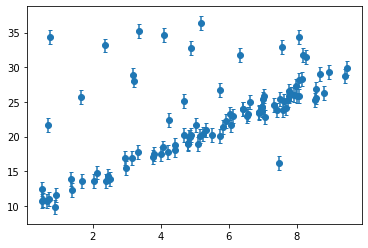

In [3]:
import matplotlib.pyplot as plt
import matplotlib
sigmax=1
n=100
xs_loaded,ys_loaded = zs_loaded 
matplotlib.rcParams.update({'errorbar.capsize': 2})
plt.errorbar(xs_loaded,ys_loaded,yerr=[sigmax]*n, fmt='o')

Visualize:
- parameterplanes: (m,c),(mua,sigmaa),(pa)
- all the time: 5 walker paths connected by blue to transparant (for t=1000) lines 
- (first 10 and last 10 drawls:) one of the 5 walkers: values: blue crosses moving, with blue dashed oval corr. to si*Sigmai,
- for i>1000: each walker red cross mean(last 1000), dashed circle: std(last 1000)  (innervar)  
- for i>1000: green cross & circle mean of means, var of means (zwischenvar) 
- real value: darkgreen cross (after convergence is reached)

In [5]:
# get full histories for all theta parameters and si*Sigmai for each walker
trackedparams = ["m","c","mua","sigmaa","pa","si*Sigmai"]
params2walker2valuehistory = {param:{w:[] for w in range(nwalkers_loaded)} for param in trackedparams}
for w,paramshist in walkers_loaded.items():
    [[mhist,chist,muahist,sigmaahist,pahist],[_,shist,Sigmahist,_],_] = get_theta_rho_hyperp_hists(paramshist)
    for param, hist in list(zip(trackedparams[:-1],[mhist,chist,muahist,sigmaahist,pahist])):
        params2walker2valuehistory[param][w] = hist
    params2walker2valuehistory["si*Sigmai"][w] = [si*Sigmai for si,Sigmai in list(zip(shist,Sigmahist))]
parampairs = [("m","c"),("mua","sigmaa"),("pa","step")]
parampairs2walker2param0values_param1values_theircovs = {parampair:{w:(
    
    params2walker2valuehistory[parampair[0]][w],
    
    params2walker2valuehistory[parampair[1]][w] 
        if parampair[1]!="step" 
        else list(range(len(params2walker2valuehistory[parampair[0]][w]))),
    
    [(
        siSigmai[trackedparams.index(parampair[0]):trackedparams.index(parampair[0])+2,
             trackedparams.index(parampair[0]):trackedparams.index(parampair[0])+2] 
         if parampair[1]!="step" 
         else siSigmai[trackedparams.index(parampair[0]),trackedparams.index(parampair[0])]
    )
     for siSigmai in params2walker2valuehistory["si*Sigmai"][w]]
                                                                        ) 
                                                                    
                                                                    for w in range(nwalkers_loaded)}
                                                        for parampair in parampairs} 
mat = np.array([[1,0],[0,0]])
for w in walkers_loaded:
    pas,steps, pavars = parampairs2walker2param0values_param1values_theircovs[("pa","step")][w]
    parampairs2walker2param0values_param1values_theircovs[("pa","step")][w] = (pas,[(step+30*w)/1000 for step in steps],
                                                                               [mat*var for var in pavars])
    
if False:
    for i in range(3):
        print(i,len(parampairs2walker2param0values_param1values_theircovs[("m","c")][4][i]))
        print(i,len(parampairs2walker2param0values_param1values_theircovs[("mua","sigmaa")][4][i]))
        print(i,len(parampairs2walker2param0values_param1values_theircovs[("pa","step")][4][i]))

In [69]:
for w in walkers_loaded:
    print(parampairs2walker2param0values_param1values_theircovs[("pa","step")][w][1][-10:])

[4.992, 4.993, 4.994, 4.995, 4.996, 4.997, 4.998, 4.999, 5.0, 5.001]
[5.002, 5.003, 5.004, 5.005, 5.006, 5.007, 5.008, 5.009, 5.01, 5.011]
[5.012, 5.013, 5.014, 5.015, 5.016, 5.017, 5.018, 5.019, 5.02, 5.021]
[5.022, 5.023, 5.024, 5.025, 5.026, 5.027, 5.028, 5.029, 5.03, 5.031]
[5.032, 5.033, 5.034, 5.035, 5.036, 5.037, 5.038, 5.039, 5.04, 5.041]


In [54]:
def confidence_ellipse(mean_x, mean_y, cov, n_std=3.0):
    mean_xy =[mean_x, mean_y]
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    t = np.linspace(0, 2*math.pi, 100)
    
    if cov.flatten().tolist().count(0)==3:
        if cov[0,0]!=0:
            ellipse_xs = np.linspace(mean_x-np.sqrt(cov[0,0])*n_std, 
                                     mean_x+np.sqrt(cov[0,0])*n_std,100)
            ellipse_ys = [mean_y]*100
        elif cov[1,1]!=0:
            ellipse_xs = [mean_x]*100
            ellipse_ys = np.linspace(mean_y-np.sqrt(cov[1,1])*n_std, 
                                     mean_y+np.sqrt(cov[1,1])*n_std,100)
    else:
        Ell = np.array([ell_radius_x*np.cos(t) , ell_radius_y*np.sin(t)]) 

        t_rot = math.pi/4
        R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],
                          [np.sin(t_rot) , np.cos(t_rot)]])  
        Ell_rot = np.zeros((2,Ell.shape[1]))
        for pt in range(Ell.shape[1]):
            Ell_rot[:,pt] = np.dot(R_rot,Ell[:,pt])

        Ell_rot_scaled_shifted = np.zeros((2,Ell.shape[1]))
        for xy in range(Ell.shape[0]):
            Ell_rot_scaled_shifted[xy,:] = mean_xy[xy] + Ell_rot[xy,:]*np.sqrt(cov[xy,xy]) * n_std

        ellipse_xs,ellipse_ys = [list(Ell_rot_scaled_shifted[xy,:]) for xy in range(2)]
        
    return ellipse_xs,ellipse_ys

In [78]:
# start with (m,c) animation:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
lwcrosses = 2
lw = 1.5
fontsize=18

paramsnames = [r"Steigung $m$",r"y-Achsenabschnitt $c$",
               r"Mittelwert $\mu_a$",r"Standardabweichung $\sigma_a$",
               r"Anteil Ausreißer $P_a$", r"Schritt $i/1000$"]
displayedparams = ["m","c","mua","sigmaa","pa","step"]
theta0 = (m0,c0,mua0,sigmaa0,pa0) = (0.5,13,25,1,0.5) # first guess modelparams
realtheta = (2,10,30,5,0.2)

plt.rcParams.update({'font.size': fontsize})

def create_animation(walkers2xycov,xname,yname):
    fig = plt.figure()
    fig.set_size_inches(4,7.5, True)
    
    allx,ally = [],[]
    for w,(xs,ys,covs) in walkers2xycov.items():
        allx += xs
        ally += ys
        
    ax = plt.axes(  xlim=( (min(allx),max(allx)) 
                          if xname!="pa" 
                          else (0,1) ), 
                    ylim=(  min(ally) , ( max(ally) 
                                         if xname!="pa" 
                                         else max(ally)+0.01 )  )
                 )
    
    title = "Geradenparameter" if xname=="m" else "Ausreißerparameter" if xname=="mua" else "Ausreißerwsk."
    ax.set_title(title)
    ax.set_xlabel(paramsnames[displayedparams.index(xname)],fontsize=fontsize)
    ax.set_ylabel(paramsnames[displayedparams.index(yname)],fontsize=fontsize)
    fig.tight_layout()
    
    steps = list(range(len(xs)))
    walkers = list(walkers2xycov.keys())
    
    walkerellipsepts = {w: ax.plot([],[],linestyle='solid',lw=lw,color='lightblue')[0] for w in walkers}
    walkerpts = {w: ax.plot([],[], lw=lw,color='darkblue')[0] for w in walkers}
    walkercross = {w: ax.plot([],[],'x',color='darkblue')[0] for w in walkers}
    
    innervarcross = {w: ax.plot([],[],'x',color="red")[0] for w in walkers}
    innervarellipsepts = {w: ax.plot([],[],linestyle='solid',lw=lw,color="red")[0] for w in walkers}
    
    realpoint = {None:ax.plot([],[],'o',color='yellow')[0]}
    
    meanvarcross = {None:ax.plot([],[],'x',color='green')[0]}
    meanvarellipselines = {None:ax.plot([],[],linestyle='solid',lw=2.5,color='green')[0]}
    
    startpoint = {None:ax.plot([],[],'x',color='black')[0]}
    
    collection = (walkerellipsepts,walkerpts,walkercross,
                  innervarcross,innervarellipsepts,
                  realpoint,
                  meanvarcross,meanvarellipselines,
                 startpoint)
    
    def init():
        for c in collection:
            for w in c.keys():
                c[w].set_data([], [])
        return collection

    def animate(step):
        meansx,meansy=[],[]
        for w,(xs,ys,covs) in walkers2xycov.items():
            x = xs[max(0,step-nlastdraws_loaded):max(1,step)] #TODO decide: start always at zero instead?
            y = ys[max(0,step-nlastdraws_loaded):max(1,step)] #TODO decide: start always at zero instead?
            
            walkerellipsepts[w].set_data(*confidence_ellipse(x[-1],y[-1], covs[step], n_std=3.0))
            walkerpts[w].set_data(x,y)
            walkercross[w].set_data([x[-1]],[y[-1]])
            
            if step>nlastdraws_loaded:
                meansx+=[np.mean(x)]
                meansy+=[np.mean(y)]
                innervarcross[w].set_data([np.mean(x)],[np.mean(y)])
                innervarellipsepts[w].set_data(*confidence_ellipse(np.mean(x),np.mean(y),np.cov(x,y)))
            else:   
                innervarcross[w].set_data([],[])
                innervarellipsepts[w].set_data([],[])
        
        if float(step)/1000>steps[-1]-float(nlastdraws_loaded)/1000:
            realpoint[None].set_data([realtheta[displayedparams.index(xname)]],
                                     [realtheta[displayedparams.index(yname)] if xname!="pa" else step])
        else:
            realpoint[None].set_data([],[])
        if step>nlastdraws_loaded:
            assert len(meansx)==len(meansy) and len(meansy)==len(walkers), (len(meansx),len(meansy),len(walkers))
            meanvarcross[None].set_data([np.mean(meansx)],[np.mean(meansy)])
            meanvarellipselines[None].set_data(*confidence_ellipse(np.mean(meansx),
                                                                   np.mean(meansy),
                                                                   np.cov(meansx,meansy)))
        else:
            meanvarcross[None].set_data([],[])
            meanvarellipselines[None].set_data([],[])
        
        startpoint[None].set_data([theta0[displayedparams.index(xname)]],
                                  [theta0[displayedparams.index(yname)] if xname!="pa" else 0])
        return collection

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(steps)-1, interval=20) #, blit=True)

    anim.save("C:/Users/Milu/Documents/Uni/astroseminar/animation_{}_{}.gif".format(xname,yname), 
              writer=animation.PillowWriter(fps=30)) 

<ipython-input-54-52870f6d8772>:3: RuntimeWarning: invalid value encountered in double_scalars
  pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])


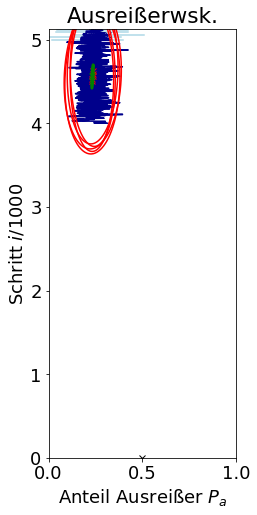

In [79]:
create_animation(parampairs2walker2param0values_param1values_theircovs[("pa","step")],"pa","step")

<ipython-input-54-52870f6d8772>:6: RuntimeWarning: invalid value encountered in sqrt
  ell_radius_y = np.sqrt(1 - pearson)


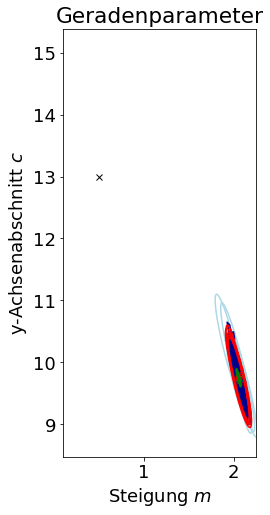

In [85]:
create_animation(parampairs2walker2param0values_param1values_theircovs[("m","c")],"m","c")

<ipython-input-54-52870f6d8772>:6: RuntimeWarning: invalid value encountered in sqrt
  ell_radius_y = np.sqrt(1 - pearson)


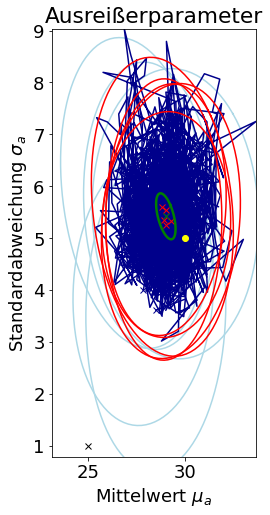

In [75]:
create_animation(parampairs2walker2param0values_param1values_theircovs[("mua","sigmaa")],"mua","sigmaa")

In [86]:
import imageio
import numpy as np    

#Create reader object for the gif
gif1 = imageio.get_reader("C:/Users/Milu/Documents/Uni/astroseminar/animation_m_c.gif")
gif2 = imageio.get_reader("C:/Users/Milu/Documents/Uni/astroseminar/animation_pa_step.gif")
gif3 = imageio.get_reader("C:/Users/Milu/Documents/Uni/astroseminar/animation_mua_sigmaa.gif")

#If they don't have the same number of frame take the shorter
print(gif1.get_length(), gif2.get_length(),gif3.get_length())
number_of_frames = min(gif1.get_length(), gif2.get_length(),gif3.get_length()) 

#Create writer object
new_gif = imageio.get_writer("C:/Users/Milu/Documents/Uni/astroseminar/animation_model_params.gif")

for frame_number in range(number_of_frames):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    img3 = gif3.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2, img3))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()
gif3.close() 

new_gif.close()

5001 4998 5001


Text(0, 0.5, 'Evidenz $P(Z)$')

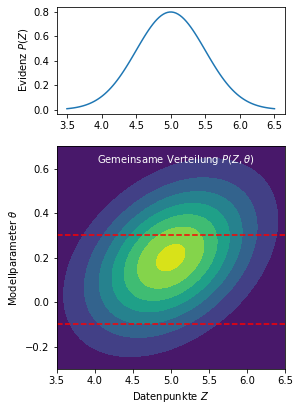

In [89]:
from copy import copy
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import numpy as np 
import itertools as itt 

a = np.linspace(3.5,6.5,100)
b = np.linspace(-0.3,0.7,100)
def pa(a):
    return scipy.stats.norm.pdf(a,5,0.5)
def pab(a,b): 
    a = a if iter(a) else [a]
    b = b if iter(b) else [b]
    return scipy.stats.multivariate_normal(mean=np.array([5,0.2]),cov=np.array([[0.5,0.06],[0.06,0.05]])).pdf(
        [[np.array([ai,bi]) for ai in a]
         for bi in b])
fig = plt.figure(figsize=(9,9))
pztax = fig.add_subplot(223)
pztax.contourf(a,b, pab(a,b))
pztax.hlines(-0.1,3.5,6.5,color='red',linestyle='dashed')
pztax.hlines(0.3,3.5,6.5,color='red',linestyle='dashed')
pztax.set_xlabel(r"Datenpunkte $Z$") #Evidenz $P(Z)=\int P(Z|\theta)d\theta$")
pztax.set_ylabel(r"Modellparameter $\theta$") #Prior $P(\theta)$")
pztax.text(0.8,2.15,r'Gemeinsame Verteilung $P(Z,\theta)$',
        horizontalalignment='center',
        transform=ax.transAxes, color="white")
pzax = fig.add_subplot(423)
pzax.plot(a,pa(a))
pzax.set_ylabel(r"Evidenz $P(Z)$")

<ipython-input-8-2809831c9b9a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-8-2809831c9b9a>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


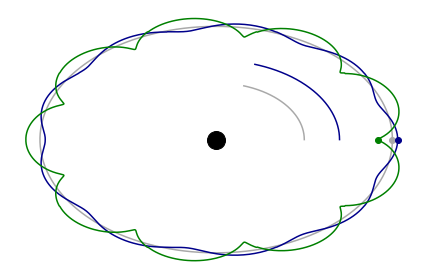

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
plt.axis('off')
ax = fig.add_subplot(111)
ax.plot([0],[0],color='black',marker='o',
           markersize=18)
T,TSB=1000,100
scaleS,scaleB = 0.03,-0.08
t = np.linspace(0,2*np.pi,T)
tSB = np.linspace(0,2*np.pi,TSB)
x0,y0 = np.cos(t),np.sin(t)
xS,yS = list(np.cos(tSB)*scaleS)*int(T/TSB),list(np.sin(tSB)*scaleS)*int(T/TSB)
xB,yB = list(np.cos(tSB)*scaleB)*int(T/TSB),list(np.sin(tSB)*scaleB)*int(T/TSB)

def trafo(xs,ys,scale,listlengthratio):
    return ([zi*scale for zi in zs][:int(len(zs)*listlengthratio)]
            for zs in [xs,ys])

ax.plot(*trafo(x0,y0,0.5,0.2),color='darkgrey')
ax.plot(*trafo(x0,y0,0.7,0.2),color='darkblue')
#ax.plot(*trafo(x0,y0,0.3,0.2),color='green')


ax.plot(x0,y0,color='darkgrey')
ax.scatter([1],[0],marker='o',color='darkgrey')
ax.plot(x0+xS,y0+yS,color='darkblue')
ax.scatter([1+xS[0]],[0],marker='o',color='darkblue')
ax.plot(x0+xB,y0+yB,color='green')
ax.scatter([1+xB[0]],[0],marker='o',color='green')
fig.tight_layout()
fig.savefig("C:/Users/Milu/Documents/Uni/astroseminar/pics/topview.jpg")
fig.show()

In [9]:
# start with (m,c) animation:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
lwcrosses = 2
lw = 1.5
fontsize=18

paramsnames = [r"Steigung $m$",r"y-Achsenabschnitt $c$",
               r"Mittelwert $\mu_a$",r"Standardabweichung $\sigma_a$",
               r"Anteil Ausreißer $P_a$", r"Schritt $i/1000$"]
displayedparams = ["m","c","mua","sigmaa","pa","step"]
theta0 = (m0,c0,mua0,sigmaa0,pa0) = (0.5,13,25,1,0.5) # first guess modelparams
realtheta = (2,10,30,5,0.2)

plt.rcParams.update({'font.size': fontsize})

def get_empty_figures(walkers2xycov,xname,yname):
    fig = plt.figure()
    fig.set_size_inches(4,7.5, True)
    
    allx,ally = [],[]
    for w,(xs,ys,covs) in walkers2xycov.items():
        allx += xs
        ally += ys
        
    ax = plt.axes(  xlim=( (min(allx),max(allx)) 
                          if xname!="pa" 
                          else (0,1) ), 
                    ylim=(  min(ally) , ( max(ally) 
                                         if xname!="pa" 
                                         else max(ally)+0.01 )  )
                 )
    
    title = "Geradenparameter" if xname=="m" else "Ausreißerparameter" if xname=="mua" else "Ausreißerwsk."
    ax.set_title(title)
    ax.set_xlabel(paramsnames[displayedparams.index(xname)],fontsize=fontsize)
    ax.set_ylabel(paramsnames[displayedparams.index(yname)],fontsize=fontsize)
    fig.tight_layout()
    fig.savefig("C:/Users/Milu/Documents/Uni/astroseminar/emptyfig_{}_{}.png".format(xname,yname))

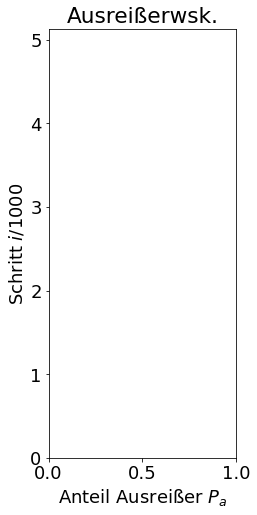

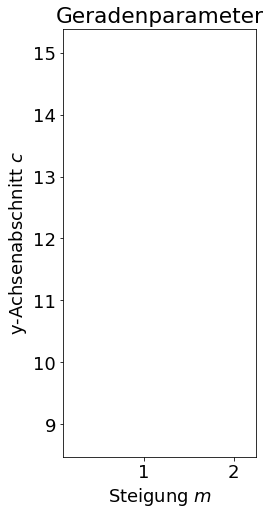

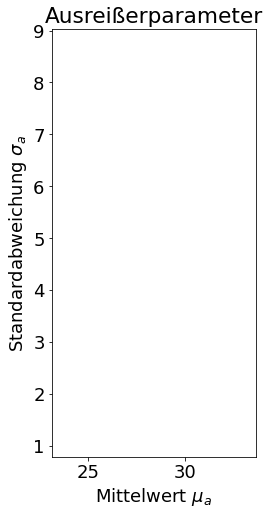

In [11]:
get_empty_figures(parampairs2walker2param0values_param1values_theircovs[("pa","step")],"pa","step")
get_empty_figures(parampairs2walker2param0values_param1values_theircovs[("m","c")],"m","c")
get_empty_figures(parampairs2walker2param0values_param1values_theircovs[("mua","sigmaa")],"mua","sigmaa")